In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
def getFileNameIn(path):
    files_names = []
    for dirname, dirnames, filenames in os.walk(path):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            files_names.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            files_names.append(os.path.join(dirname, filename))
        
        return files_names

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.fillna(0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
    
    output_path = '../../data_out/' + data_input_path[14:]
    # save file
    dataset.to_csv(output_path)
    
    return output_path

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

In [6]:
# plot each column in a graph
def plot_columns(dataset, values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = np.expm1(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = np.expm1(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests, days_to_predict):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nErrors')
    for i in range(0,len(y_hats_max)):
        error = abs(y_hats_max[i] - y_tests_max[i])
        print('{} = {}'.format(days_to_predict[29-i],error))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s)'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    print('\nErrors')
    for i in range(0,len(y_hats_min)):
        error = abs(y_hats_min[i] - y_tests_min[i])
        print('{} = {}'.format(days_to_predict[29-i],error))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_min)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s)'.format(percentual, j))
        j += 1

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2014-01-01           0.0        30.8        22.4        3.8               1.7   
2014-01-02           0.0        30.8        22.6        3.8               1.7   
2014-01-03           0.0        32.4        21.8        2.7               1.5   
2014-01-04           0.0        31.8        22.4        5.2               1.9   
2014-01-05           0.0        32.4        22.2        3.5               0.9   
...                  ...         ...         ...        ...               ...   
2018-12-27           0.0        33.9        21.8        7.1               4.9   
2018-12-28           0.0        33.9        21.2        6.8               4.9   
2018-12-29           0.0        33.9        21.2        6.8               4.9   
2018-12-30           0.0        33.9        21.2        6.8               4.9   
2018-12-31           0.0    

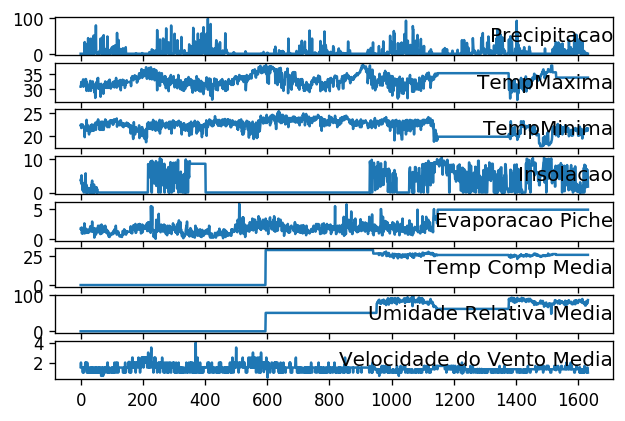

Train on 1570 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2187 - mean_squared_error: 5.4625 - val_loss: 1.1156 - val_mean_squared_error: 1.2756
Epoch 2/1000
 - 1s - loss: 0.3416 - mean_squared_error: 0.2611 - val_loss: 0.1323 - val_mean_squared_error: 0.0286
Epoch 3/1000
 - 1s - loss: 0.0749 - mean_squared_error: 0.0108 - val_loss: 0.0814 - val_mean_squared_error: 0.0071
Epoch 4/1000
 - 1s - loss: 0.0487 - mean_squared_error: 0.0044 - val_loss: 0.0452 - val_mean_squared_error: 0.0024
Epoch 5/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0035 - val_loss: 0.0223 - val_mean_squared_error: 7.8619e-04
Epoch 6/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0031 - val_loss: 0.0436 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0417 - mean_squared_error: 0.0032 - val_loss: 0.0273 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0410 - mean_squared_error: 0.0031 - val_loss: 0.0414 - val_mean_squared_error: 0.0018
Epoch 9/1000
 - 1s - loss: 0.04

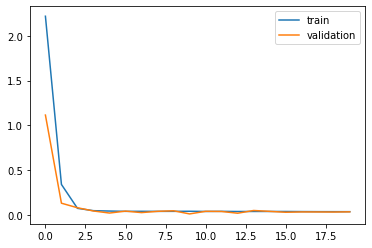


predict: [[32.41468697 22.96132217]]
real:      [[33.9 21.7]]

Train on 1569 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.3629 - mean_squared_error: 6.3836 - val_loss: 1.3906 - val_mean_squared_error: 2.8971
Epoch 2/1000
 - 1s - loss: 0.8349 - mean_squared_error: 1.2964 - val_loss: 0.3943 - val_mean_squared_error: 0.2113
Epoch 3/1000
 - 1s - loss: 0.1262 - mean_squared_error: 0.0324 - val_loss: 0.0314 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 1s - loss: 0.0511 - mean_squared_error: 0.0043 - val_loss: 0.0309 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 1s - loss: 0.0431 - mean_squared_error: 0.0033 - val_loss: 0.0288 - val_mean_squared_error: 9.0905e-04
Epoch 6/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0032 - val_loss: 0.0351 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 1s - loss: 0.0410 - mean_squared_error: 0.0032 - val_loss: 0.0305 - val_mean_squared_error: 9.7665e-04
Epoch 8/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0032 - val_loss: 0.0

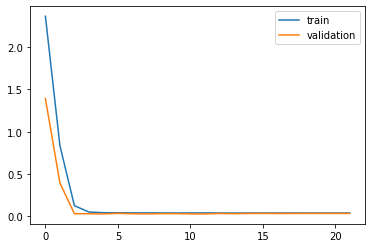


predict: [[32.20950823 22.61658354]]
real:      [[33.9 21.2]]

Train on 1568 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.7127 - mean_squared_error: 3.8243 - val_loss: 0.1154 - val_mean_squared_error: 0.0178
Epoch 2/1000
 - 1s - loss: 0.2209 - mean_squared_error: 0.0843 - val_loss: 0.0953 - val_mean_squared_error: 0.0098
Epoch 3/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0081 - val_loss: 0.0098 - val_mean_squared_error: 9.9833e-05
Epoch 4/1000
 - 1s - loss: 0.0495 - mean_squared_error: 0.0040 - val_loss: 0.0385 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 1s - loss: 0.0448 - mean_squared_error: 0.0035 - val_loss: 0.0218 - val_mean_squared_error: 4.7505e-04
Epoch 6/1000
 - 1s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0352 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0410 - mean_squared_error: 0.0031 - val_loss: 0.0297 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0404 - mean_squared_error: 0.0031 - val_loss: 0.0

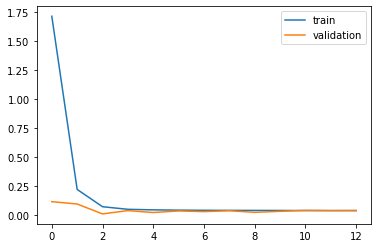


predict: [[31.91218126 22.29692529]]
real:      [[33.9 21.2]]

Train on 1567 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.7701 - mean_squared_error: 8.0577 - val_loss: 2.0393 - val_mean_squared_error: 4.1596
Epoch 2/1000
 - 1s - loss: 0.6804 - mean_squared_error: 0.7456 - val_loss: 0.0499 - val_mean_squared_error: 0.0039
Epoch 3/1000
 - 1s - loss: 0.1152 - mean_squared_error: 0.0218 - val_loss: 0.0401 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0055 - val_loss: 0.0326 - val_mean_squared_error: 0.0011
Epoch 5/1000
 - 1s - loss: 0.0465 - mean_squared_error: 0.0038 - val_loss: 0.0448 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 1s - loss: 0.0445 - mean_squared_error: 0.0035 - val_loss: 0.0400 - val_mean_squared_error: 0.0030
Epoch 7/1000
 - 1s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0500 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 1s - loss: 0.0416 - mean_squared_error: 0.0032 - val_loss: 0.0426 - va

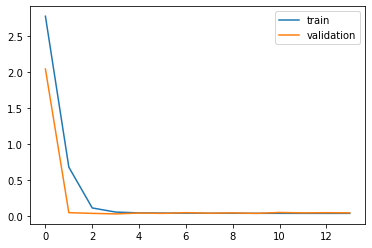


predict: [[33.77759376 22.77163994]]
real:      [[33.9 21.2]]

Train on 1566 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.2476 - mean_squared_error: 2.2798 - val_loss: 0.2245 - val_mean_squared_error: 0.0643
Epoch 2/1000
 - 1s - loss: 0.1641 - mean_squared_error: 0.0443 - val_loss: 0.0662 - val_mean_squared_error: 0.0044
Epoch 3/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0066 - val_loss: 0.0207 - val_mean_squared_error: 4.8678e-04
Epoch 4/1000
 - 1s - loss: 0.0461 - mean_squared_error: 0.0037 - val_loss: 0.0325 - val_mean_squared_error: 0.0011
Epoch 5/1000
 - 1s - loss: 0.0437 - mean_squared_error: 0.0035 - val_loss: 0.0280 - val_mean_squared_error: 7.8358e-04
Epoch 6/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0034 - val_loss: 0.0332 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0274 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0

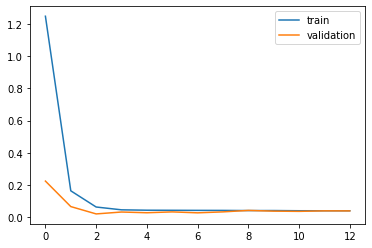


predict: [[32.85069542 23.22565661]]
real:      [[33.9 21.8]]

Train on 1565 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4727 - mean_squared_error: 6.3786 - val_loss: 1.6749 - val_mean_squared_error: 2.8238
Epoch 2/1000
 - 1s - loss: 0.6603 - mean_squared_error: 0.6852 - val_loss: 0.1823 - val_mean_squared_error: 0.0443
Epoch 3/1000
 - 1s - loss: 0.1118 - mean_squared_error: 0.0272 - val_loss: 0.0147 - val_mean_squared_error: 2.9068e-04
Epoch 4/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0059 - val_loss: 0.0299 - val_mean_squared_error: 9.7775e-04
Epoch 5/1000
 - 1s - loss: 0.0480 - mean_squared_error: 0.0041 - val_loss: 0.0462 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0036 - val_loss: 0.0434 - val_mean_squared_error: 0.0030
Epoch 7/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0034 - val_loss: 0.0453 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0

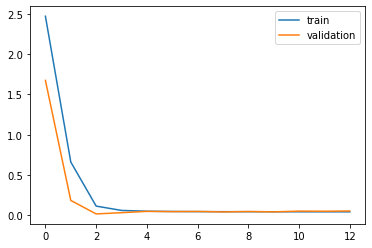


predict: [[36.93657765 23.35435389]]
real:      [[33.9 21.2]]

Train on 1564 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 3.1656 - mean_squared_error: 10.4870 - val_loss: 2.7397 - val_mean_squared_error: 8.1534
Epoch 2/1000
 - 1s - loss: 2.2075 - mean_squared_error: 7.1124 - val_loss: 1.6064 - val_mean_squared_error: 4.7234
Epoch 3/1000
 - 1s - loss: 1.1265 - mean_squared_error: 2.5765 - val_loss: 0.5110 - val_mean_squared_error: 0.5171
Epoch 4/1000
 - 1s - loss: 0.1820 - mean_squared_error: 0.0829 - val_loss: 0.0941 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0068 - val_loss: 0.0605 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 1s - loss: 0.0452 - mean_squared_error: 0.0036 - val_loss: 0.0369 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 1s - loss: 0.0416 - mean_squared_error: 0.0032 - val_loss: 0.0386 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0032 - val_loss: 0.0483 - v

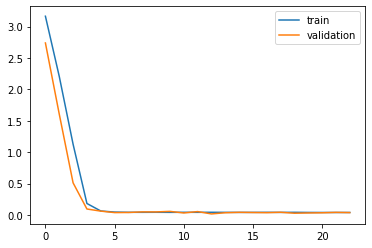


predict: [[32.75244111 22.71477701]]
real:      [[33.9 21.6]]

Train on 1563 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2890 - mean_squared_error: 6.1706 - val_loss: 1.6005 - val_mean_squared_error: 4.2307
Epoch 2/1000
 - 1s - loss: 1.0200 - mean_squared_error: 1.9210 - val_loss: 0.7125 - val_mean_squared_error: 0.9027
Epoch 3/1000
 - 1s - loss: 0.5207 - mean_squared_error: 0.4755 - val_loss: 0.3125 - val_mean_squared_error: 0.1626
Epoch 4/1000
 - 1s - loss: 0.1251 - mean_squared_error: 0.0302 - val_loss: 0.0233 - val_mean_squared_error: 8.6725e-04
Epoch 5/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0051 - val_loss: 0.0207 - val_mean_squared_error: 4.6870e-04
Epoch 6/1000
 - 1s - loss: 0.0479 - mean_squared_error: 0.0038 - val_loss: 0.0297 - val_mean_squared_error: 9.6833e-04
Epoch 7/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0034 - val_loss: 0.0192 - val_mean_squared_error: 5.0282e-04
Epoch 8/1000
 - 1s - loss: 0.0426 - mean_squared_error: 0.0031 - val_l

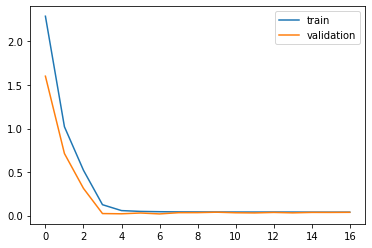


predict: [[32.63275844 22.58040631]]
real:      [[33.9 21.1]]

Train on 1562 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.3445 - mean_squared_error: 6.1902 - val_loss: 1.3269 - val_mean_squared_error: 2.4231
Epoch 2/1000
 - 1s - loss: 0.7230 - mean_squared_error: 0.9912 - val_loss: 0.3398 - val_mean_squared_error: 0.1619
Epoch 3/1000
 - 1s - loss: 0.2667 - mean_squared_error: 0.1170 - val_loss: 0.1163 - val_mean_squared_error: 0.0187
Epoch 4/1000
 - 1s - loss: 0.0824 - mean_squared_error: 0.0114 - val_loss: 0.0626 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0049 - val_loss: 0.0152 - val_mean_squared_error: 3.9640e-04
Epoch 6/1000
 - 1s - loss: 0.0519 - mean_squared_error: 0.0043 - val_loss: 0.0212 - val_mean_squared_error: 6.7177e-04
Epoch 7/1000
 - 1s - loss: 0.0481 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 2.2641e-05
Epoch 8/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0034 - val_loss:

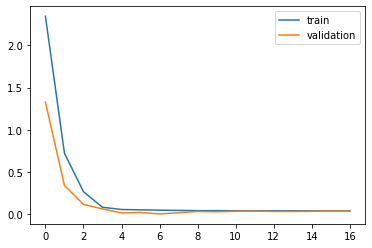


predict: [[33.39747564 23.00024094]]
real:      [[33.9 21.1]]

Train on 1561 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8383 - mean_squared_error: 4.3448 - val_loss: 0.4111 - val_mean_squared_error: 0.2660
Epoch 2/1000
 - 1s - loss: 0.2490 - mean_squared_error: 0.0995 - val_loss: 0.0387 - val_mean_squared_error: 0.0015
Epoch 3/1000
 - 1s - loss: 0.0706 - mean_squared_error: 0.0081 - val_loss: 0.0063 - val_mean_squared_error: 6.9291e-05
Epoch 4/1000
 - 1s - loss: 0.0487 - mean_squared_error: 0.0042 - val_loss: 0.0203 - val_mean_squared_error: 4.4945e-04
Epoch 5/1000
 - 1s - loss: 0.0453 - mean_squared_error: 0.0036 - val_loss: 0.0262 - val_mean_squared_error: 7.0667e-04
Epoch 6/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0035 - val_loss: 0.0293 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0426 - mean_squared_error: 0.0033 - val_loss: 0.0426 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 1s - loss: 0.0422 - mean_squared_error: 0.0032 - val_loss:

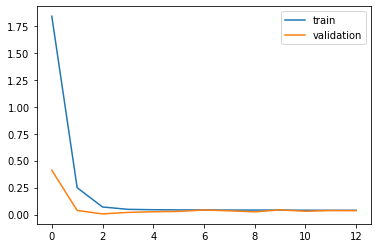


predict: [[32.00418869 22.38829647]]
real:      [[33.9 21.1]]

Train on 1560 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.9173 - mean_squared_error: 4.9276 - val_loss: 0.3344 - val_mean_squared_error: 0.2157
Epoch 2/1000
 - 1s - loss: 0.2463 - mean_squared_error: 0.1004 - val_loss: 0.0252 - val_mean_squared_error: 0.0012
Epoch 3/1000
 - 1s - loss: 0.0770 - mean_squared_error: 0.0100 - val_loss: 0.0183 - val_mean_squared_error: 6.1309e-04
Epoch 4/1000
 - 1s - loss: 0.0464 - mean_squared_error: 0.0038 - val_loss: 0.0359 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0033 - val_loss: 0.0331 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0032 - val_loss: 0.0318 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0408 - mean_squared_error: 0.0031 - val_loss: 0.0251 - val_mean_squared_error: 9.0814e-04
Epoch 8/1000
 - 1s - loss: 0.0404 - mean_squared_error: 0.0031 - val_loss: 0.0

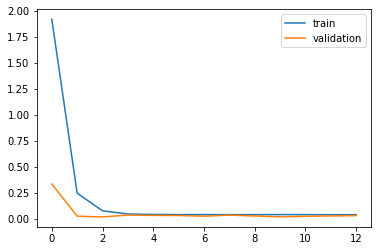


predict: [[32.2132773  22.50098335]]
real:      [[33.9 21.2]]

Train on 1559 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.5818 - mean_squared_error: 6.9942 - val_loss: 1.6901 - val_mean_squared_error: 2.8575
Epoch 2/1000
 - 1s - loss: 0.6310 - mean_squared_error: 0.7230 - val_loss: 0.1627 - val_mean_squared_error: 0.0266
Epoch 3/1000
 - 1s - loss: 0.1066 - mean_squared_error: 0.0199 - val_loss: 0.0349 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.0541 - mean_squared_error: 0.0048 - val_loss: 0.0181 - val_mean_squared_error: 4.3648e-04
Epoch 5/1000
 - 1s - loss: 0.0444 - mean_squared_error: 0.0035 - val_loss: 0.0341 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0234 - val_mean_squared_error: 9.5124e-04
Epoch 7/1000
 - 1s - loss: 0.0418 - mean_squared_error: 0.0032 - val_loss: 0.0267 - val_mean_squared_error: 7.1979e-04
Epoch 8/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0031 - val_loss:

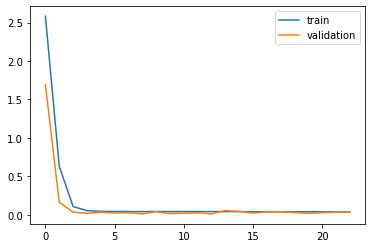


predict: [[31.93943689 23.04332122]]
real:      [[33.9 21.2]]

Train on 1558 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2553 - mean_squared_error: 5.7034 - val_loss: 1.4525 - val_mean_squared_error: 2.1782
Epoch 2/1000
 - 1s - loss: 0.3605 - mean_squared_error: 0.2287 - val_loss: 0.2225 - val_mean_squared_error: 0.0495
Epoch 3/1000
 - 1s - loss: 0.0871 - mean_squared_error: 0.0126 - val_loss: 0.0610 - val_mean_squared_error: 0.0039
Epoch 4/1000
 - 1s - loss: 0.0459 - mean_squared_error: 0.0037 - val_loss: 0.0344 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0410 - mean_squared_error: 0.0031 - val_loss: 0.0363 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0399 - mean_squared_error: 0.0030 - val_loss: 0.0362 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0392 - mean_squared_error: 0.0029 - val_loss: 0.0351 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 1s - loss: 0.0394 - mean_squared_error: 0.0029 - val_loss: 0.0476 - va

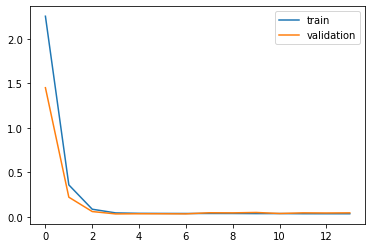


predict: [[31.59378288 23.22964805]]
real:      [[33.9 21.2]]

Train on 1557 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.6900 - mean_squared_error: 7.9055 - val_loss: 1.8333 - val_mean_squared_error: 4.2743
Epoch 2/1000
 - 1s - loss: 0.9960 - mean_squared_error: 1.6771 - val_loss: 0.6145 - val_mean_squared_error: 0.5132
Epoch 3/1000
 - 1s - loss: 0.1692 - mean_squared_error: 0.0590 - val_loss: 0.0460 - val_mean_squared_error: 0.0022
Epoch 4/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0389 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0479 - mean_squared_error: 0.0036 - val_loss: 0.0178 - val_mean_squared_error: 5.1276e-04
Epoch 6/1000
 - 1s - loss: 0.0444 - mean_squared_error: 0.0032 - val_loss: 0.0208 - val_mean_squared_error: 4.4785e-04
Epoch 7/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0031 - val_loss: 0.0147 - val_mean_squared_error: 2.1742e-04
Epoch 8/1000
 - 1s - loss: 0.0416 - mean_squared_error: 0.0030 - val_loss:

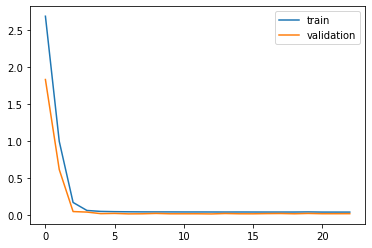


predict: [[31.97937192 22.61791804]]
real:      [[33.9 21.4]]

Train on 1556 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.2888 - mean_squared_error: 7.0991 - val_loss: 1.7640 - val_mean_squared_error: 4.2768
Epoch 2/1000
 - 1s - loss: 1.2971 - mean_squared_error: 3.0911 - val_loss: 0.9380 - val_mean_squared_error: 1.6221
Epoch 3/1000
 - 1s - loss: 0.7003 - mean_squared_error: 0.9374 - val_loss: 0.3873 - val_mean_squared_error: 0.2810
Epoch 4/1000
 - 1s - loss: 0.2023 - mean_squared_error: 0.0956 - val_loss: 0.1163 - val_mean_squared_error: 0.0254
Epoch 5/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0068 - val_loss: 0.0355 - val_mean_squared_error: 0.0019
Epoch 6/1000
 - 1s - loss: 0.0469 - mean_squared_error: 0.0037 - val_loss: 0.0168 - val_mean_squared_error: 2.8287e-04
Epoch 7/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0032 - val_loss: 0.0139 - val_mean_squared_error: 2.0365e-04
Epoch 8/1000
 - 1s - loss: 0.0416 - mean_squared_error: 0.0032 - val_loss: 0.0

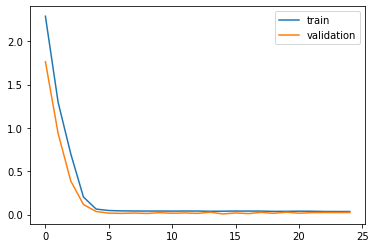


predict: [[32.17584314 22.8552079 ]]
real:      [[33.9 20.4]]

Train on 1555 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.5175 - mean_squared_error: 6.7652 - val_loss: 1.5387 - val_mean_squared_error: 2.4757
Epoch 2/1000
 - 1s - loss: 0.5842 - mean_squared_error: 0.5399 - val_loss: 0.0739 - val_mean_squared_error: 0.0057
Epoch 3/1000
 - 1s - loss: 0.1116 - mean_squared_error: 0.0202 - val_loss: 0.0779 - val_mean_squared_error: 0.0061
Epoch 4/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0050 - val_loss: 0.0121 - val_mean_squared_error: 1.7481e-04
Epoch 5/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0035 - val_loss: 0.0225 - val_mean_squared_error: 5.2221e-04
Epoch 6/1000
 - 1s - loss: 0.0429 - mean_squared_error: 0.0033 - val_loss: 0.0107 - val_mean_squared_error: 1.1696e-04
Epoch 7/1000
 - 1s - loss: 0.0422 - mean_squared_error: 0.0033 - val_loss: 0.0060 - val_mean_squared_error: 3.8362e-05
Epoch 8/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0034 - val_l

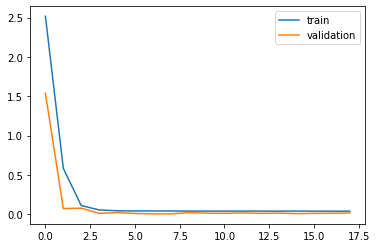


predict: [[32.21684881 22.95960839]]
real:      [[33.9 20.4]]

Train on 1554 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9799 - mean_squared_error: 9.0871 - val_loss: 2.2786 - val_mean_squared_error: 5.4250
Epoch 2/1000
 - 1s - loss: 1.1035 - mean_squared_error: 1.7772 - val_loss: 0.2497 - val_mean_squared_error: 0.0635
Epoch 3/1000
 - 1s - loss: 0.1753 - mean_squared_error: 0.0505 - val_loss: 0.0527 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 1s - loss: 0.0684 - mean_squared_error: 0.0084 - val_loss: 0.0244 - val_mean_squared_error: 7.5967e-04
Epoch 5/1000
 - 1s - loss: 0.0490 - mean_squared_error: 0.0041 - val_loss: 0.0465 - val_mean_squared_error: 0.0022
Epoch 6/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0036 - val_loss: 0.0295 - val_mean_squared_error: 9.9765e-04
Epoch 7/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0298 - val_mean_squared_error: 9.4895e-04
Epoch 8/1000
 - 1s - loss: 0.0428 - mean_squared_error: 0.0034 - val_loss:

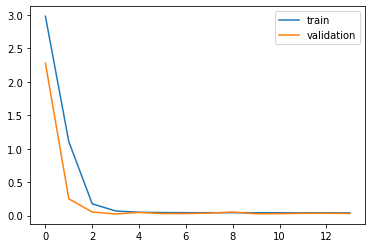


predict: [[33.88398015 22.63463662]]
real:      [[33.9 20.4]]

Train on 1553 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8397 - mean_squared_error: 8.2329 - val_loss: 1.9946 - val_mean_squared_error: 4.0153
Epoch 2/1000
 - 1s - loss: 1.0762 - mean_squared_error: 1.5888 - val_loss: 0.2914 - val_mean_squared_error: 0.1308
Epoch 3/1000
 - 1s - loss: 0.1619 - mean_squared_error: 0.0445 - val_loss: 0.0132 - val_mean_squared_error: 1.9248e-04
Epoch 4/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0056 - val_loss: 0.0293 - val_mean_squared_error: 8.6052e-04
Epoch 5/1000
 - 1s - loss: 0.0451 - mean_squared_error: 0.0034 - val_loss: 0.0329 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0436 - mean_squared_error: 0.0033 - val_loss: 0.0055 - val_mean_squared_error: 3.0859e-05
Epoch 7/1000
 - 1s - loss: 0.0417 - mean_squared_error: 0.0031 - val_loss: 0.0227 - val_mean_squared_error: 6.0965e-04
Epoch 8/1000
 - 1s - loss: 0.0407 - mean_squared_error: 0.0030 - val_l

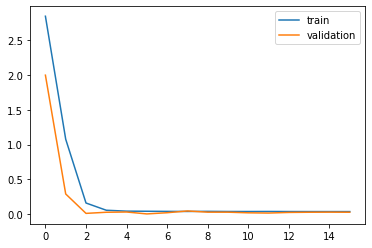


predict: [[31.88969979 22.87365398]]
real:      [[33.9 21.2]]

Train on 1552 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8217 - mean_squared_error: 8.5588 - val_loss: 2.0045 - val_mean_squared_error: 4.6937
Epoch 2/1000
 - 1s - loss: 1.1606 - mean_squared_error: 1.9476 - val_loss: 0.7387 - val_mean_squared_error: 1.0104
Epoch 3/1000
 - 1s - loss: 0.4221 - mean_squared_error: 0.4069 - val_loss: 0.1201 - val_mean_squared_error: 0.0287
Epoch 4/1000
 - 1s - loss: 0.0864 - mean_squared_error: 0.0137 - val_loss: 0.0615 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 1s - loss: 0.0497 - mean_squared_error: 0.0043 - val_loss: 0.0498 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0443 - mean_squared_error: 0.0035 - val_loss: 0.0463 - val_mean_squared_error: 0.0022
Epoch 7/1000
 - 1s - loss: 0.0434 - mean_squared_error: 0.0034 - val_loss: 0.0178 - val_mean_squared_error: 3.4644e-04
Epoch 8/1000
 - 1s - loss: 0.0429 - mean_squared_error: 0.0034 - val_loss: 0.0541 

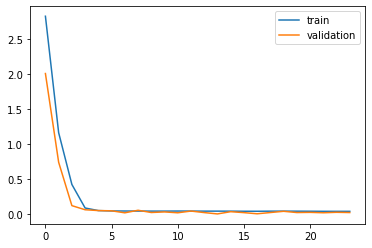


predict: [[31.36678677 22.06692652]]
real:      [[33.9 19.5]]

Train on 1551 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.4044 - mean_squared_error: 6.7096 - val_loss: 1.4336 - val_mean_squared_error: 3.0828
Epoch 2/1000
 - 1s - loss: 0.8141 - mean_squared_error: 1.2340 - val_loss: 0.1440 - val_mean_squared_error: 0.0372
Epoch 3/1000
 - 1s - loss: 0.1200 - mean_squared_error: 0.0238 - val_loss: 0.0340 - val_mean_squared_error: 0.0018
Epoch 4/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0054 - val_loss: 0.0520 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 1s - loss: 0.0476 - mean_squared_error: 0.0040 - val_loss: 0.0370 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0455 - mean_squared_error: 0.0037 - val_loss: 0.0279 - val_mean_squared_error: 9.1198e-04
Epoch 7/1000
 - 1s - loss: 0.0448 - mean_squared_error: 0.0036 - val_loss: 0.0342 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0436 - mean_squared_error: 0.0034 - val_loss: 0.0446 

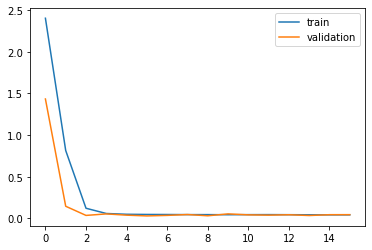


predict: [[32.07137007 23.16960343]]
real:      [[33.9 20.2]]

Train on 1550 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.6208 - mean_squared_error: 7.2235 - val_loss: 1.6828 - val_mean_squared_error: 2.8319
Epoch 2/1000
 - 1s - loss: 0.6194 - mean_squared_error: 0.7209 - val_loss: 0.1040 - val_mean_squared_error: 0.0129
Epoch 3/1000
 - 1s - loss: 0.1019 - mean_squared_error: 0.0173 - val_loss: 0.0387 - val_mean_squared_error: 0.0025
Epoch 4/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0064 - val_loss: 0.0308 - val_mean_squared_error: 9.5090e-04
Epoch 5/1000
 - 1s - loss: 0.0467 - mean_squared_error: 0.0038 - val_loss: 0.0129 - val_mean_squared_error: 2.3132e-04
Epoch 6/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0171 - val_mean_squared_error: 3.6187e-04
Epoch 7/1000
 - 1s - loss: 0.0421 - mean_squared_error: 0.0032 - val_loss: 0.0184 - val_mean_squared_error: 3.5438e-04
Epoch 8/1000
 - 1s - loss: 0.0421 - mean_squared_error: 0.0032 - val_l

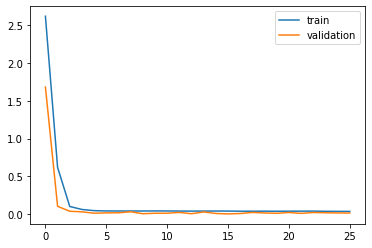


predict: [[31.15909351 23.32004986]]
real:      [[33.9 21.6]]

Train on 1549 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.9226 - mean_squared_error: 4.2633 - val_loss: 0.9267 - val_mean_squared_error: 0.8998
Epoch 2/1000
 - 1s - loss: 0.3092 - mean_squared_error: 0.1664 - val_loss: 0.2535 - val_mean_squared_error: 0.0931
Epoch 3/1000
 - 1s - loss: 0.0887 - mean_squared_error: 0.0137 - val_loss: 0.0381 - val_mean_squared_error: 0.0018
Epoch 4/1000
 - 1s - loss: 0.0487 - mean_squared_error: 0.0042 - val_loss: 0.0160 - val_mean_squared_error: 2.7658e-04
Epoch 5/1000
 - 1s - loss: 0.0437 - mean_squared_error: 0.0035 - val_loss: 0.0083 - val_mean_squared_error: 6.8782e-05
Epoch 6/1000
 - 1s - loss: 0.0426 - mean_squared_error: 0.0033 - val_loss: 0.0211 - val_mean_squared_error: 5.4761e-04
Epoch 7/1000
 - 1s - loss: 0.0418 - mean_squared_error: 0.0032 - val_loss: 0.0185 - val_mean_squared_error: 3.6497e-04
Epoch 8/1000
 - 1s - loss: 0.0423 - mean_squared_error: 0.0032 - val_l

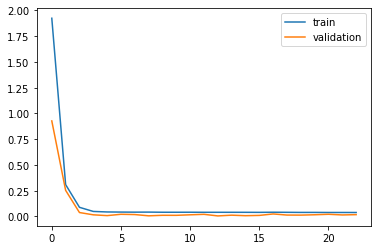


predict: [[32.44362652 22.91573156]]
real:      [[33.9 20.6]]

Train on 1548 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.5436 - mean_squared_error: 6.8760 - val_loss: 1.6105 - val_mean_squared_error: 2.8050
Epoch 2/1000
 - 1s - loss: 0.5320 - mean_squared_error: 0.5054 - val_loss: 0.1486 - val_mean_squared_error: 0.0315
Epoch 3/1000
 - 1s - loss: 0.1209 - mean_squared_error: 0.0225 - val_loss: 0.0343 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0050 - val_loss: 0.0125 - val_mean_squared_error: 1.5746e-04
Epoch 5/1000
 - 1s - loss: 0.0457 - mean_squared_error: 0.0036 - val_loss: 0.0204 - val_mean_squared_error: 5.7451e-04
Epoch 6/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0275 - val_mean_squared_error: 7.5822e-04
Epoch 7/1000
 - 1s - loss: 0.0414 - mean_squared_error: 0.0032 - val_loss: 0.0227 - val_mean_squared_error: 5.3974e-04
Epoch 8/1000
 - 1s - loss: 0.0414 - mean_squared_error: 0.0032 - val_l

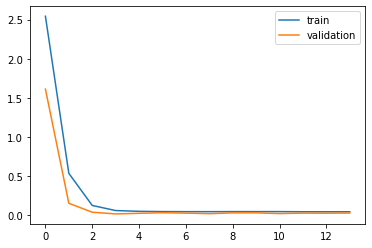


predict: [[31.90461774 22.9451375 ]]
real:      [[33.9 20.6]]

Train on 1547 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.4394 - mean_squared_error: 6.3032 - val_loss: 1.3430 - val_mean_squared_error: 1.8831
Epoch 2/1000
 - 1s - loss: 0.4040 - mean_squared_error: 0.2876 - val_loss: 0.2518 - val_mean_squared_error: 0.0661
Epoch 3/1000
 - 1s - loss: 0.0976 - mean_squared_error: 0.0154 - val_loss: 0.0099 - val_mean_squared_error: 9.9419e-05
Epoch 4/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0055 - val_loss: 0.0075 - val_mean_squared_error: 5.9324e-05
Epoch 5/1000
 - 1s - loss: 0.0459 - mean_squared_error: 0.0037 - val_loss: 0.0071 - val_mean_squared_error: 7.8503e-05
Epoch 6/1000
 - 1s - loss: 0.0436 - mean_squared_error: 0.0034 - val_loss: 0.0115 - val_mean_squared_error: 1.5272e-04
Epoch 7/1000
 - 1s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0198 - val_mean_squared_error: 5.3677e-04
Epoch 8/1000
 - 1s - loss: 0.0423 - mean_squared_error: 0.0032 - v

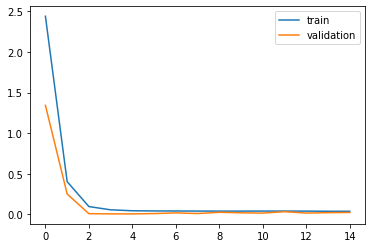


predict: [[32.60456858 23.7389939 ]]
real:      [[33.9 20.6]]

Train on 1546 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.2444 - mean_squared_error: 5.8098 - val_loss: 1.2005 - val_mean_squared_error: 1.9900
Epoch 2/1000
 - 1s - loss: 0.6206 - mean_squared_error: 0.6274 - val_loss: 0.1954 - val_mean_squared_error: 0.0416
Epoch 3/1000
 - 1s - loss: 0.1008 - mean_squared_error: 0.0160 - val_loss: 0.0753 - val_mean_squared_error: 0.0057
Epoch 4/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0054 - val_loss: 0.0537 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 1s - loss: 0.0467 - mean_squared_error: 0.0036 - val_loss: 0.0322 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0032 - val_loss: 0.0040 - val_mean_squared_error: 1.6161e-05
Epoch 7/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0033 - val_loss: 0.0093 - val_mean_squared_error: 1.1867e-04
Epoch 8/1000
 - 1s - loss: 0.0421 - mean_squared_error: 0.0032 - val_loss: 0.0

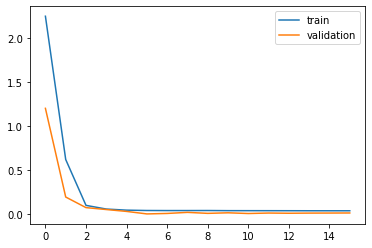


predict: [[32.14551526 22.80385372]]
real:      [[33.9 21. ]]

Train on 1545 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.0518 - mean_squared_error: 9.5172 - val_loss: 2.1940 - val_mean_squared_error: 4.8742
Epoch 2/1000
 - 1s - loss: 1.0938 - mean_squared_error: 1.7744 - val_loss: 0.3384 - val_mean_squared_error: 0.1195
Epoch 3/1000
 - 1s - loss: 0.1690 - mean_squared_error: 0.0460 - val_loss: 0.0597 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0069 - val_loss: 0.0643 - val_mean_squared_error: 0.0047
Epoch 5/1000
 - 1s - loss: 0.0482 - mean_squared_error: 0.0039 - val_loss: 0.0461 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0435 - mean_squared_error: 0.0035 - val_loss: 0.0495 - val_mean_squared_error: 0.0034
Epoch 7/1000
 - 1s - loss: 0.0423 - mean_squared_error: 0.0033 - val_loss: 0.0414 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 1s - loss: 0.0421 - mean_squared_error: 0.0033 - val_loss: 0.0491 - va

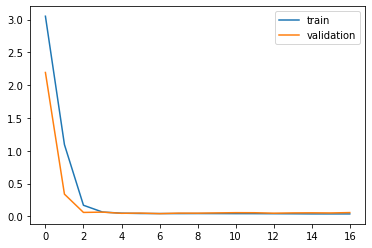


predict: [[31.72490896 22.53398057]]
real:      [[33.9 20.4]]

Train on 1544 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.7790 - mean_squared_error: 3.9350 - val_loss: 0.2425 - val_mean_squared_error: 0.0729
Epoch 2/1000
 - 1s - loss: 0.1803 - mean_squared_error: 0.0517 - val_loss: 0.0705 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0071 - val_loss: 0.0151 - val_mean_squared_error: 3.9865e-04
Epoch 4/1000
 - 1s - loss: 0.0463 - mean_squared_error: 0.0037 - val_loss: 0.0197 - val_mean_squared_error: 3.9585e-04
Epoch 5/1000
 - 1s - loss: 0.0436 - mean_squared_error: 0.0034 - val_loss: 0.0206 - val_mean_squared_error: 8.1527e-04
Epoch 6/1000
 - 1s - loss: 0.0436 - mean_squared_error: 0.0034 - val_loss: 0.0109 - val_mean_squared_error: 1.5273e-04
Epoch 7/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0032 - val_loss: 0.0257 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0424 - mean_squared_error: 0.0033 - val_l

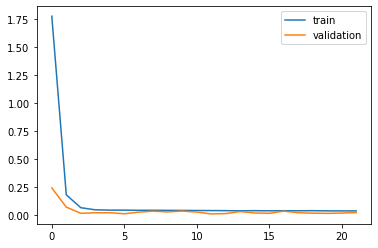


predict: [[33.47849835 22.88329804]]
real:      [[33.9 22.1]]

Train on 1543 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3659 - mean_squared_error: 6.4371 - val_loss: 1.1622 - val_mean_squared_error: 1.8255
Epoch 2/1000
 - 1s - loss: 0.5243 - mean_squared_error: 0.6590 - val_loss: 0.0810 - val_mean_squared_error: 0.0068
Epoch 3/1000
 - 1s - loss: 0.0864 - mean_squared_error: 0.0123 - val_loss: 0.0357 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0053 - val_loss: 0.0338 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 1s - loss: 0.0454 - mean_squared_error: 0.0036 - val_loss: 0.0492 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0033 - val_loss: 0.0282 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0033 - val_loss: 0.0429 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 1s - loss: 0.0424 - mean_squared_error: 0.0032 - val_loss: 0.0251 - va

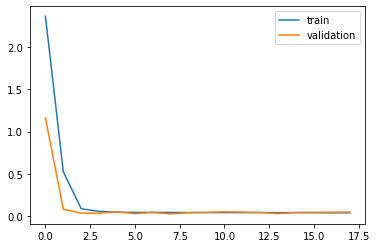


predict: [[32.76060197 23.26199658]]
real:      [[33.9 20.2]]

Train on 1542 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8488 - mean_squared_error: 8.3061 - val_loss: 2.4191 - val_mean_squared_error: 5.8598
Epoch 2/1000
 - 1s - loss: 0.9408 - mean_squared_error: 1.3400 - val_loss: 0.1199 - val_mean_squared_error: 0.0148
Epoch 3/1000
 - 1s - loss: 0.1680 - mean_squared_error: 0.0482 - val_loss: 0.1051 - val_mean_squared_error: 0.0126
Epoch 4/1000
 - 1s - loss: 0.0703 - mean_squared_error: 0.0084 - val_loss: 0.0255 - val_mean_squared_error: 6.9939e-04
Epoch 5/1000
 - 1s - loss: 0.0447 - mean_squared_error: 0.0036 - val_loss: 0.0490 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.0421 - mean_squared_error: 0.0032 - val_loss: 0.0418 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 1s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0611 - val_mean_squared_error: 0.0039
Epoch 8/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0031 - val_loss: 0.0573 

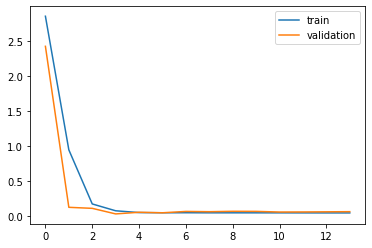


predict: [[34.02954756 23.7738357 ]]
real:      [[33.9 21.9]]

Train on 1541 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0598 - mean_squared_error: 9.6767 - val_loss: 2.5272 - val_mean_squared_error: 6.4270
Epoch 2/1000
 - 1s - loss: 1.8278 - mean_squared_error: 3.5395 - val_loss: 1.1043 - val_mean_squared_error: 1.2390
Epoch 3/1000
 - 1s - loss: 0.3765 - mean_squared_error: 0.2482 - val_loss: 0.1112 - val_mean_squared_error: 0.0158
Epoch 4/1000
 - 1s - loss: 0.0817 - mean_squared_error: 0.0130 - val_loss: 0.0315 - val_mean_squared_error: 0.0018
Epoch 5/1000
 - 1s - loss: 0.0507 - mean_squared_error: 0.0045 - val_loss: 0.0499 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0034 - val_loss: 0.0598 - val_mean_squared_error: 0.0043
Epoch 7/1000
 - 1s - loss: 0.0428 - mean_squared_error: 0.0033 - val_loss: 0.0441 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 1s - loss: 0.0420 - mean_squared_error: 0.0033 - val_loss: 0.0455 - va

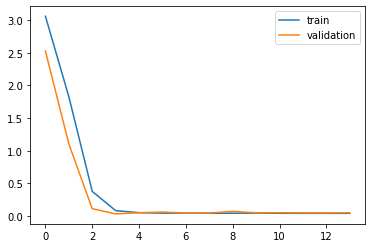


predict: [[35.99841706 24.02357433]]
real:      [[33.9 21.9]]

Train and validation time: 7.836887208620707

Maximum metrics
Test RMSE -------------------------- 1.736
Test VARIANCE ---------------------- -3.033e+28
Test MAX-ERROR --------------------- 3.037
Test MEAN-ABSOLUTE-ERROR ----------- 1.569
Test MEDIAN-ABSOLUTE-ERROR --------- 1.707

Errors
2018-12-31 = 1.4853130293693368
2018-12-30 = 1.690491769097875
2018-12-29 = 1.9878187437665673
2018-12-28 = 0.12240624101745823
2018-12-27 = 1.049304582861808
2018-12-26 = 3.036577652172525
2018-12-24 = 1.147558889201811
2018-12-23 = 1.2672415627016633
2018-12-22 = 0.502524361244312
2018-12-21 = 1.8958113124471652
2018-12-20 = 1.6867226996790947
2018-12-19 = 1.9605631126608252
2018-12-18 = 2.3062171177992923
2018-12-17 = 1.920628078697895
2018-12-16 = 1.7241568611511298
2018-12-15 = 1.683151190932179
2018-12-14 = 0.016019850148374815
2018-12-13 = 2.0103002071689353
2018-12-12 = 2.5332132329674444
2018-12-11 = 1.8286299342717243
2018-12-10

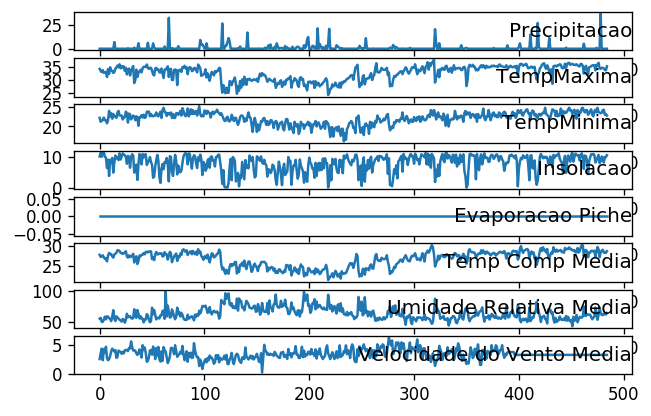

Train on 423 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.3110 - mean_squared_error: 11.2681 - val_loss: 2.9412 - val_mean_squared_error: 8.7368
Epoch 2/1000
 - 0s - loss: 2.7343 - mean_squared_error: 7.5375 - val_loss: 2.5073 - val_mean_squared_error: 6.2869
Epoch 3/1000
 - 0s - loss: 2.2979 - mean_squared_error: 5.3049 - val_loss: 2.0666 - val_mean_squared_error: 4.2709
Epoch 4/1000
 - 0s - loss: 1.8400 - mean_squared_error: 3.4134 - val_loss: 1.5840 - val_mean_squared_error: 2.5116
Epoch 5/1000
 - 0s - loss: 1.3257 - mean_squared_error: 1.8075 - val_loss: 1.0186 - val_mean_squared_error: 1.0891
Epoch 6/1000
 - 0s - loss: 0.7169 - mean_squared_error: 0.6548 - val_loss: 0.4454 - val_mean_squared_error: 0.3141
Epoch 7/1000
 - 0s - loss: 0.3380 - mean_squared_error: 0.1558 - val_loss: 0.0983 - val_mean_squared_error: 0.0132
Epoch 8/1000
 - 0s - loss: 0.1646 - mean_squared_error: 0.0400 - val_loss: 0.2205 - val_mean_squared_error: 0.0503
Epoch 9/1000
 - 0s - loss: 0.1838 -

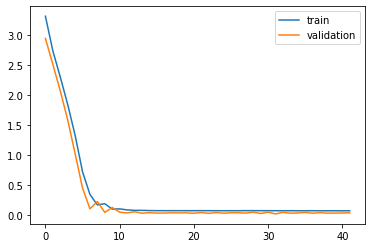


predict: [[33.86352636 22.69652148]]
real:      [[35.4 22.8]]

Train on 422 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9912 - mean_squared_error: 9.1534 - val_loss: 2.4829 - val_mean_squared_error: 6.2019
Epoch 2/1000
 - 0s - loss: 2.0974 - mean_squared_error: 4.4687 - val_loss: 1.6608 - val_mean_squared_error: 2.7615
Epoch 3/1000
 - 0s - loss: 1.2603 - mean_squared_error: 1.6543 - val_loss: 0.8214 - val_mean_squared_error: 0.6756
Epoch 4/1000
 - 0s - loss: 0.4523 - mean_squared_error: 0.2596 - val_loss: 0.0508 - val_mean_squared_error: 0.0026
Epoch 5/1000
 - 0s - loss: 0.1967 - mean_squared_error: 0.0512 - val_loss: 0.2116 - val_mean_squared_error: 0.0448
Epoch 6/1000
 - 0s - loss: 0.1701 - mean_squared_error: 0.0395 - val_loss: 0.0796 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 0s - loss: 0.1201 - mean_squared_error: 0.0196 - val_loss: 0.1704 - val_mean_squared_error: 0.0291
Epoch 8/1000
 - 0s - loss: 0.0949 - mean_squared_error: 0.0131 - val_loss: 0.0121 - val

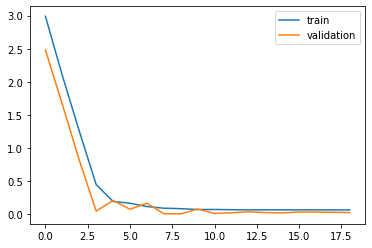


predict: [[34.15762889 22.82342445]]
real:      [[33.8 23.2]]

Train on 421 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9441 - mean_squared_error: 8.7164 - val_loss: 2.7132 - val_mean_squared_error: 7.4187
Epoch 2/1000
 - 0s - loss: 2.4414 - mean_squared_error: 6.0800 - val_loss: 2.2442 - val_mean_squared_error: 5.2327
Epoch 3/1000
 - 0s - loss: 1.9616 - mean_squared_error: 4.1157 - val_loss: 1.7487 - val_mean_squared_error: 3.4033
Epoch 4/1000
 - 0s - loss: 1.4127 - mean_squared_error: 2.4042 - val_loss: 1.1121 - val_mean_squared_error: 1.6796
Epoch 5/1000
 - 0s - loss: 0.7707 - mean_squared_error: 0.9650 - val_loss: 0.5542 - val_mean_squared_error: 0.4640
Epoch 6/1000
 - 0s - loss: 0.3011 - mean_squared_error: 0.1496 - val_loss: 0.1007 - val_mean_squared_error: 0.0102
Epoch 7/1000
 - 0s - loss: 0.2299 - mean_squared_error: 0.0748 - val_loss: 0.1513 - val_mean_squared_error: 0.0248
Epoch 8/1000
 - 0s - loss: 0.1261 - mean_squared_error: 0.0265 - val_loss: 0.1378 - val

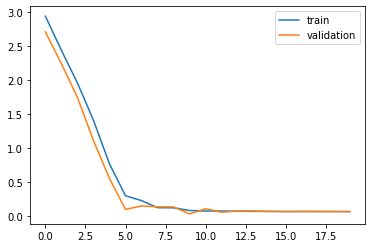


predict: [[33.59957373 24.04088793]]
real:      [[34. 23.]]

Train on 420 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.2176 - mean_squared_error: 10.4023 - val_loss: 3.0629 - val_mean_squared_error: 9.3923
Epoch 2/1000
 - 0s - loss: 2.8254 - mean_squared_error: 8.0112 - val_loss: 2.6570 - val_mean_squared_error: 7.0606
Epoch 3/1000
 - 0s - loss: 2.4068 - mean_squared_error: 5.8153 - val_loss: 2.2320 - val_mean_squared_error: 4.9823
Epoch 4/1000
 - 0s - loss: 1.9562 - mean_squared_error: 3.8531 - val_loss: 1.7485 - val_mean_squared_error: 3.0637
Epoch 5/1000
 - 0s - loss: 1.4424 - mean_squared_error: 2.1199 - val_loss: 1.1953 - val_mean_squared_error: 1.4482
Epoch 6/1000
 - 0s - loss: 0.8655 - mean_squared_error: 0.8081 - val_loss: 0.5793 - val_mean_squared_error: 0.3770
Epoch 7/1000
 - 0s - loss: 0.3150 - mean_squared_error: 0.1383 - val_loss: 0.2516 - val_mean_squared_error: 0.0645
Epoch 8/1000
 - 0s - loss: 0.2792 - mean_squared_error: 0.1230 - val_loss: 0.2069 - val_

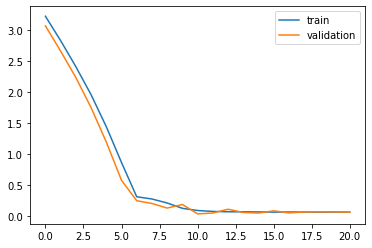


predict: [[34.7035509  22.95284584]]
real:      [[34.6 24.3]]

Train on 419 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7314 - mean_squared_error: 7.8804 - val_loss: 2.2593 - val_mean_squared_error: 5.7019
Epoch 2/1000
 - 0s - loss: 1.8361 - mean_squared_error: 4.2847 - val_loss: 1.4366 - val_mean_squared_error: 3.4199
Epoch 3/1000
 - 0s - loss: 1.2863 - mean_squared_error: 2.7875 - val_loss: 1.1933 - val_mean_squared_error: 2.3192
Epoch 4/1000
 - 0s - loss: 1.1126 - mean_squared_error: 1.9503 - val_loss: 0.9500 - val_mean_squared_error: 1.8017
Epoch 5/1000
 - 0s - loss: 0.9099 - mean_squared_error: 1.4977 - val_loss: 0.8877 - val_mean_squared_error: 1.3256
Epoch 6/1000
 - 0s - loss: 0.7376 - mean_squared_error: 0.9612 - val_loss: 0.6793 - val_mean_squared_error: 0.7772
Epoch 7/1000
 - 0s - loss: 0.6389 - mean_squared_error: 0.5895 - val_loss: 0.5604 - val_mean_squared_error: 0.5251
Epoch 8/1000
 - 0s - loss: 0.4988 - mean_squared_error: 0.4002 - val_loss: 0.4806 - val

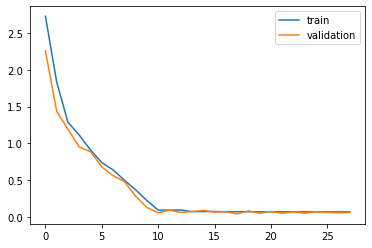


predict: [[35.21328501 23.18120609]]
real:      [[34.8 24.2]]

Train on 418 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1468 - mean_squared_error: 9.9550 - val_loss: 3.0548 - val_mean_squared_error: 9.4066
Epoch 2/1000
 - 0s - loss: 2.8886 - mean_squared_error: 8.4621 - val_loss: 2.7997 - val_mean_squared_error: 7.9946
Epoch 3/1000
 - 0s - loss: 2.6106 - mean_squared_error: 7.0138 - val_loss: 2.4832 - val_mean_squared_error: 6.3883
Epoch 4/1000
 - 0s - loss: 2.2390 - mean_squared_error: 5.2477 - val_loss: 2.0063 - val_mean_squared_error: 4.2034
Epoch 5/1000
 - 0s - loss: 1.7223 - mean_squared_error: 3.1501 - val_loss: 1.4401 - val_mean_squared_error: 2.1820
Epoch 6/1000
 - 0s - loss: 1.1148 - mean_squared_error: 1.3606 - val_loss: 0.7522 - val_mean_squared_error: 0.5937
Epoch 7/1000
 - 0s - loss: 0.3725 - mean_squared_error: 0.2043 - val_loss: 0.0916 - val_mean_squared_error: 0.0099
Epoch 8/1000
 - 0s - loss: 0.2935 - mean_squared_error: 0.1041 - val_loss: 0.2380 - val

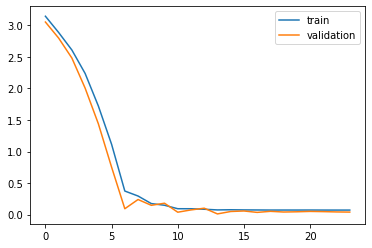


predict: [[35.69220501 24.93413772]]
real:      [[34.8 23.5]]

Train on 417 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.6423 - mean_squared_error: 7.0369 - val_loss: 2.3540 - val_mean_squared_error: 5.5486
Epoch 2/1000
 - 0s - loss: 2.0976 - mean_squared_error: 4.4382 - val_loss: 1.8763 - val_mean_squared_error: 3.5453
Epoch 3/1000
 - 0s - loss: 1.6089 - mean_squared_error: 2.6587 - val_loss: 1.3711 - val_mean_squared_error: 1.9505
Epoch 4/1000
 - 0s - loss: 1.0859 - mean_squared_error: 1.3101 - val_loss: 0.8283 - val_mean_squared_error: 0.8216
Epoch 5/1000
 - 0s - loss: 0.5566 - mean_squared_error: 0.4662 - val_loss: 0.4028 - val_mean_squared_error: 0.2313
Epoch 6/1000
 - 0s - loss: 0.3545 - mean_squared_error: 0.1452 - val_loss: 0.2335 - val_mean_squared_error: 0.0564
Epoch 7/1000
 - 0s - loss: 0.1913 - mean_squared_error: 0.0528 - val_loss: 0.0482 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 0s - loss: 0.1082 - mean_squared_error: 0.0182 - val_loss: 0.1607 - val

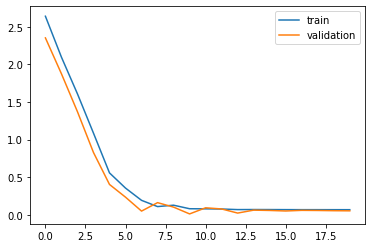


predict: [[34.75693792 24.41594759]]
real:      [[34.4 23.4]]

Train on 416 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1266 - mean_squared_error: 9.9697 - val_loss: 2.7616 - val_mean_squared_error: 8.0159
Epoch 2/1000
 - 0s - loss: 2.3603 - mean_squared_error: 6.2537 - val_loss: 2.0620 - val_mean_squared_error: 5.3895
Epoch 3/1000
 - 0s - loss: 1.6844 - mean_squared_error: 4.4431 - val_loss: 1.5319 - val_mean_squared_error: 4.2259
Epoch 4/1000
 - 0s - loss: 1.4077 - mean_squared_error: 3.3183 - val_loss: 1.1877 - val_mean_squared_error: 2.6471
Epoch 5/1000
 - 0s - loss: 1.0488 - mean_squared_error: 1.9141 - val_loss: 1.0035 - val_mean_squared_error: 1.4928
Epoch 6/1000
 - 0s - loss: 0.7454 - mean_squared_error: 0.9625 - val_loss: 0.5572 - val_mean_squared_error: 0.5803
Epoch 7/1000
 - 0s - loss: 0.3853 - mean_squared_error: 0.2527 - val_loss: 0.1906 - val_mean_squared_error: 0.0404
Epoch 8/1000
 - 0s - loss: 0.1492 - mean_squared_error: 0.0380 - val_loss: 0.1739 - val

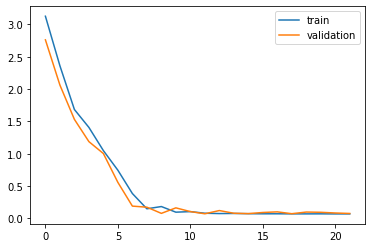


predict: [[35.35919787 22.50589215]]
real:      [[34.6 23.5]]

Train on 415 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7484 - mean_squared_error: 7.8319 - val_loss: 2.4149 - val_mean_squared_error: 6.0291
Epoch 2/1000
 - 0s - loss: 2.0434 - mean_squared_error: 4.4029 - val_loss: 1.7734 - val_mean_squared_error: 3.3223
Epoch 3/1000
 - 0s - loss: 1.3728 - mean_squared_error: 2.1147 - val_loss: 1.0702 - val_mean_squared_error: 1.3351
Epoch 4/1000
 - 0s - loss: 0.6657 - mean_squared_error: 0.6617 - val_loss: 0.4272 - val_mean_squared_error: 0.2753
Epoch 5/1000
 - 0s - loss: 0.3183 - mean_squared_error: 0.1274 - val_loss: 0.0765 - val_mean_squared_error: 0.0069
Epoch 6/1000
 - 0s - loss: 0.1932 - mean_squared_error: 0.0502 - val_loss: 0.2223 - val_mean_squared_error: 0.0618
Epoch 7/1000
 - 0s - loss: 0.1585 - mean_squared_error: 0.0337 - val_loss: 0.1814 - val_mean_squared_error: 0.0331
Epoch 8/1000
 - 0s - loss: 0.1029 - mean_squared_error: 0.0154 - val_loss: 0.1085 - val

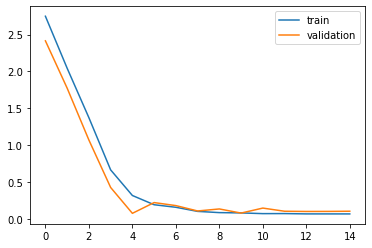


predict: [[38.86528388 28.12024092]]
real:      [[36.8 23.8]]

Train on 414 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9471 - mean_squared_error: 8.8061 - val_loss: 2.4741 - val_mean_squared_error: 6.2337
Epoch 2/1000
 - 0s - loss: 1.9475 - mean_squared_error: 4.0233 - val_loss: 1.3812 - val_mean_squared_error: 2.0724
Epoch 3/1000
 - 0s - loss: 0.8303 - mean_squared_error: 0.9469 - val_loss: 0.4331 - val_mean_squared_error: 0.2489
Epoch 4/1000
 - 0s - loss: 0.3671 - mean_squared_error: 0.1726 - val_loss: 0.2344 - val_mean_squared_error: 0.0664
Epoch 5/1000
 - 0s - loss: 0.2268 - mean_squared_error: 0.0709 - val_loss: 0.2137 - val_mean_squared_error: 0.0615
Epoch 6/1000
 - 0s - loss: 0.1928 - mean_squared_error: 0.0495 - val_loss: 0.2554 - val_mean_squared_error: 0.0667
Epoch 7/1000
 - 0s - loss: 0.1062 - mean_squared_error: 0.0168 - val_loss: 0.0402 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 0s - loss: 0.1011 - mean_squared_error: 0.0165 - val_loss: 0.1638 - val

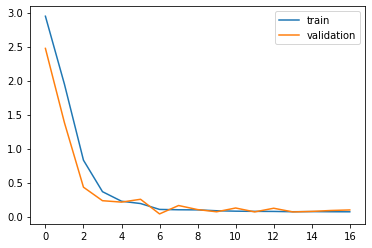


predict: [[36.0402351  27.50882721]]
real:      [[35.8 24.8]]

Train on 413 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7626 - mean_squared_error: 7.6821 - val_loss: 2.3939 - val_mean_squared_error: 5.7402
Epoch 2/1000
 - 0s - loss: 2.0279 - mean_squared_error: 4.1867 - val_loss: 1.6114 - val_mean_squared_error: 2.6287
Epoch 3/1000
 - 0s - loss: 1.1650 - mean_squared_error: 1.5004 - val_loss: 0.6496 - val_mean_squared_error: 0.5002
Epoch 4/1000
 - 0s - loss: 0.3459 - mean_squared_error: 0.1829 - val_loss: 0.1579 - val_mean_squared_error: 0.0322
Epoch 5/1000
 - 0s - loss: 0.2717 - mean_squared_error: 0.0899 - val_loss: 0.1735 - val_mean_squared_error: 0.0330
Epoch 6/1000
 - 0s - loss: 0.1263 - mean_squared_error: 0.0241 - val_loss: 0.2099 - val_mean_squared_error: 0.0450
Epoch 7/1000
 - 0s - loss: 0.1132 - mean_squared_error: 0.0183 - val_loss: 0.0660 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 0s - loss: 0.0836 - mean_squared_error: 0.0116 - val_loss: 0.0848 - val

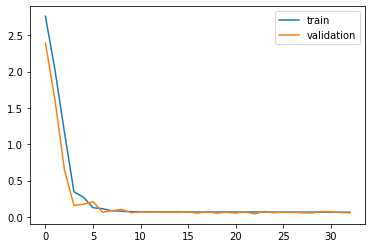


predict: [[33.4147923  22.62844463]]
real:      [[36.  23.6]]

Train on 412 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1315 - mean_squared_error: 9.8731 - val_loss: 3.0384 - val_mean_squared_error: 9.3501
Epoch 2/1000
 - 0s - loss: 2.8370 - mean_squared_error: 8.2469 - val_loss: 2.7415 - val_mean_squared_error: 7.8496
Epoch 3/1000
 - 0s - loss: 2.5183 - mean_squared_error: 6.8211 - val_loss: 2.3888 - val_mean_squared_error: 6.4378
Epoch 4/1000
 - 0s - loss: 2.1332 - mean_squared_error: 5.4649 - val_loss: 1.9603 - val_mean_squared_error: 4.9951
Epoch 5/1000
 - 0s - loss: 1.6925 - mean_squared_error: 4.2138 - val_loss: 1.5033 - val_mean_squared_error: 3.8516
Epoch 6/1000
 - 0s - loss: 1.3009 - mean_squared_error: 3.1414 - val_loss: 1.1138 - val_mean_squared_error: 2.4687
Epoch 7/1000
 - 0s - loss: 0.9629 - mean_squared_error: 1.7212 - val_loss: 0.8531 - val_mean_squared_error: 1.1209
Epoch 8/1000
 - 0s - loss: 0.6057 - mean_squared_error: 0.6375 - val_loss: 0.4174 - val

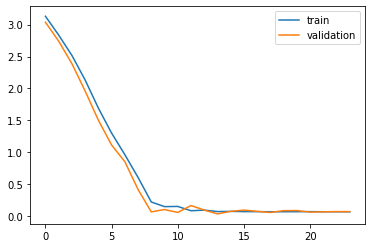


predict: [[35.73687375 22.84593903]]
real:      [[33.8 24.3]]

Train on 411 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0597 - mean_squared_error: 9.4243 - val_loss: 2.6823 - val_mean_squared_error: 7.2134
Epoch 2/1000
 - 0s - loss: 2.3703 - mean_squared_error: 5.7612 - val_loss: 2.0757 - val_mean_squared_error: 4.5219
Epoch 3/1000
 - 0s - loss: 1.7364 - mean_squared_error: 3.4424 - val_loss: 1.3976 - val_mean_squared_error: 2.4947
Epoch 4/1000
 - 0s - loss: 1.1029 - mean_squared_error: 1.9570 - val_loss: 0.9486 - val_mean_squared_error: 1.4973
Epoch 5/1000
 - 0s - loss: 0.9358 - mean_squared_error: 1.2489 - val_loss: 0.7554 - val_mean_squared_error: 0.9049
Epoch 6/1000
 - 0s - loss: 0.6767 - mean_squared_error: 0.7265 - val_loss: 0.5832 - val_mean_squared_error: 0.5288
Epoch 7/1000
 - 0s - loss: 0.4769 - mean_squared_error: 0.3707 - val_loss: 0.3785 - val_mean_squared_error: 0.1953
Epoch 8/1000
 - 0s - loss: 0.2512 - mean_squared_error: 0.0973 - val_loss: 0.1354 - val

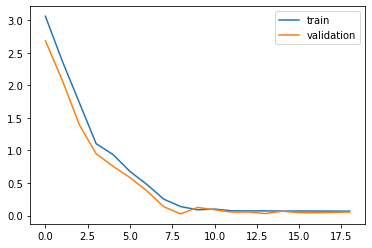


predict: [[35.59544756 23.70853059]]
real:      [[35.8 23.9]]

Train on 410 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.1690 - mean_squared_error: 10.0754 - val_loss: 3.0289 - val_mean_squared_error: 9.1888
Epoch 2/1000
 - 0s - loss: 2.8722 - mean_squared_error: 8.2979 - val_loss: 2.8191 - val_mean_squared_error: 7.9993
Epoch 3/1000
 - 0s - loss: 2.6529 - mean_squared_error: 7.1518 - val_loss: 2.5803 - val_mean_squared_error: 6.7951
Epoch 4/1000
 - 0s - loss: 2.3968 - mean_squared_error: 5.9973 - val_loss: 2.2882 - val_mean_squared_error: 5.5654
Epoch 5/1000
 - 0s - loss: 2.0817 - mean_squared_error: 4.8494 - val_loss: 1.9412 - val_mean_squared_error: 4.4108
Epoch 6/1000
 - 0s - loss: 1.7181 - mean_squared_error: 3.8259 - val_loss: 1.5574 - val_mean_squared_error: 3.4419
Epoch 7/1000
 - 0s - loss: 1.3307 - mean_squared_error: 3.0130 - val_loss: 1.1844 - val_mean_squared_error: 2.7069
Epoch 8/1000
 - 0s - loss: 1.1692 - mean_squared_error: 2.3395 - val_loss: 0.9836 - va

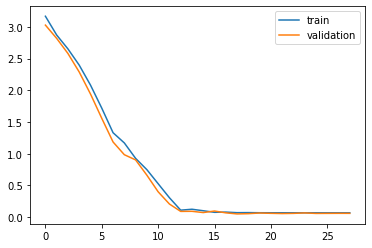


predict: [[32.99380697 23.23752888]]
real:      [[35.8 22.6]]

Train on 409 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 4.0140 - mean_squared_error: 16.2248 - val_loss: 3.7060 - val_mean_squared_error: 13.7825
Epoch 2/1000
 - 0s - loss: 3.4136 - mean_squared_error: 11.7764 - val_loss: 3.3157 - val_mean_squared_error: 11.1772
Epoch 3/1000
 - 0s - loss: 3.1273 - mean_squared_error: 10.0323 - val_loss: 3.0830 - val_mean_squared_error: 9.7872
Epoch 4/1000
 - 0s - loss: 2.8441 - mean_squared_error: 8.4296 - val_loss: 2.6761 - val_mean_squared_error: 7.5392
Epoch 5/1000
 - 0s - loss: 2.3671 - mean_squared_error: 6.0748 - val_loss: 2.1185 - val_mean_squared_error: 5.0391
Epoch 6/1000
 - 0s - loss: 1.7806 - mean_squared_error: 3.8651 - val_loss: 1.4822 - val_mean_squared_error: 3.0095
Epoch 7/1000
 - 0s - loss: 1.1578 - mean_squared_error: 2.2266 - val_loss: 0.9745 - val_mean_squared_error: 1.6547
Epoch 8/1000
 - 0s - loss: 0.8443 - mean_squared_error: 1.1092 - val_loss: 0.5633 

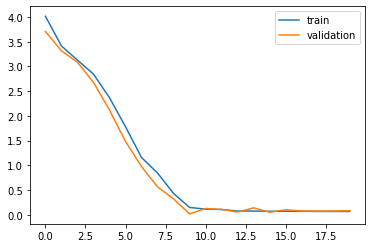


predict: [[36.59191847 24.70961468]]
real:      [[35.8 23. ]]

Train on 408 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.9325 - mean_squared_error: 9.8851 - val_loss: 2.6768 - val_mean_squared_error: 8.8915
Epoch 2/1000
 - 0s - loss: 2.3441 - mean_squared_error: 7.5696 - val_loss: 2.1072 - val_mean_squared_error: 6.7795
Epoch 3/1000
 - 0s - loss: 1.7839 - mean_squared_error: 5.6887 - val_loss: 1.5596 - val_mean_squared_error: 4.8558
Epoch 4/1000
 - 0s - loss: 1.4106 - mean_squared_error: 3.7505 - val_loss: 1.3096 - val_mean_squared_error: 2.8410
Epoch 5/1000
 - 0s - loss: 1.0564 - mean_squared_error: 2.0884 - val_loss: 0.8756 - val_mean_squared_error: 1.4461
Epoch 6/1000
 - 0s - loss: 0.6823 - mean_squared_error: 0.8721 - val_loss: 0.5270 - val_mean_squared_error: 0.3980
Epoch 7/1000
 - 0s - loss: 0.2479 - mean_squared_error: 0.1272 - val_loss: 0.0696 - val_mean_squared_error: 0.0051
Epoch 8/1000
 - 0s - loss: 0.1939 - mean_squared_error: 0.0653 - val_loss: 0.1788 - val

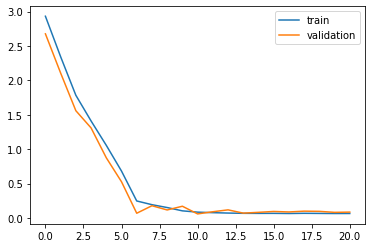


predict: [[35.40694176 21.87286966]]
real:      [[35.4 24.4]]

Train on 407 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.6421 - mean_squared_error: 13.3428 - val_loss: 3.3491 - val_mean_squared_error: 11.2702
Epoch 2/1000
 - 0s - loss: 3.1391 - mean_squared_error: 9.9462 - val_loss: 3.0195 - val_mean_squared_error: 9.2097
Epoch 3/1000
 - 0s - loss: 2.9297 - mean_squared_error: 8.6857 - val_loss: 2.9258 - val_mean_squared_error: 8.6529
Epoch 4/1000
 - 0s - loss: 2.8141 - mean_squared_error: 8.0269 - val_loss: 2.7803 - val_mean_squared_error: 7.8325
Epoch 5/1000
 - 0s - loss: 2.6517 - mean_squared_error: 7.1462 - val_loss: 2.5950 - val_mean_squared_error: 6.8396
Epoch 6/1000
 - 0s - loss: 2.4480 - mean_squared_error: 6.1126 - val_loss: 2.3605 - val_mean_squared_error: 5.6892
Epoch 7/1000
 - 0s - loss: 2.1855 - mean_squared_error: 4.9150 - val_loss: 2.0504 - val_mean_squared_error: 4.3474
Epoch 8/1000
 - 0s - loss: 1.8447 - mean_squared_error: 3.5817 - val_loss: 1.6798 - v

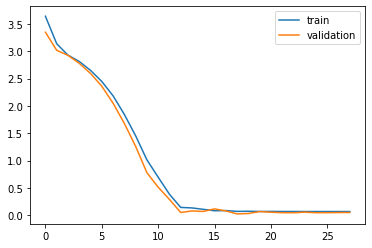


predict: [[34.50202912 22.41979534]]
real:      [[35.2 24. ]]

Train on 406 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0209 - mean_squared_error: 9.3767 - val_loss: 2.7988 - val_mean_squared_error: 8.1158
Epoch 2/1000
 - 0s - loss: 2.5969 - mean_squared_error: 7.1696 - val_loss: 2.3526 - val_mean_squared_error: 6.0812
Epoch 3/1000
 - 0s - loss: 2.1313 - mean_squared_error: 5.2858 - val_loss: 1.8661 - val_mean_squared_error: 4.3833
Epoch 4/1000
 - 0s - loss: 1.6206 - mean_squared_error: 3.7623 - val_loss: 1.3186 - val_mean_squared_error: 3.0214
Epoch 5/1000
 - 0s - loss: 1.1907 - mean_squared_error: 2.5441 - val_loss: 1.0417 - val_mean_squared_error: 1.9035
Epoch 6/1000
 - 0s - loss: 0.9168 - mean_squared_error: 1.4950 - val_loss: 0.7678 - val_mean_squared_error: 0.9839
Epoch 7/1000
 - 0s - loss: 0.6282 - mean_squared_error: 0.6735 - val_loss: 0.4389 - val_mean_squared_error: 0.3073
Epoch 8/1000
 - 0s - loss: 0.2777 - mean_squared_error: 0.1431 - val_loss: 0.0376 - val

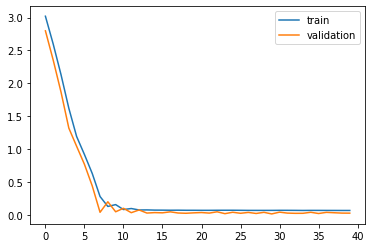


predict: [[32.57832366 22.60869071]]
real:      [[35.  23.4]]

Train on 405 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.6070 - mean_squared_error: 7.0409 - val_loss: 2.2219 - val_mean_squared_error: 5.3086
Epoch 2/1000
 - 0s - loss: 1.8487 - mean_squared_error: 4.0136 - val_loss: 1.4427 - val_mean_squared_error: 2.8971
Epoch 3/1000
 - 0s - loss: 1.1644 - mean_squared_error: 2.2154 - val_loss: 1.0806 - val_mean_squared_error: 1.7183
Epoch 4/1000
 - 0s - loss: 1.0467 - mean_squared_error: 1.4161 - val_loss: 0.9055 - val_mean_squared_error: 1.1042
Epoch 5/1000
 - 0s - loss: 0.8167 - mean_squared_error: 0.8886 - val_loss: 0.6148 - val_mean_squared_error: 0.6954
Epoch 6/1000
 - 0s - loss: 0.5584 - mean_squared_error: 0.5390 - val_loss: 0.5335 - val_mean_squared_error: 0.4052
Epoch 7/1000
 - 0s - loss: 0.3580 - mean_squared_error: 0.2186 - val_loss: 0.2053 - val_mean_squared_error: 0.0700
Epoch 8/1000
 - 0s - loss: 0.1543 - mean_squared_error: 0.0335 - val_loss: 0.0268 - val

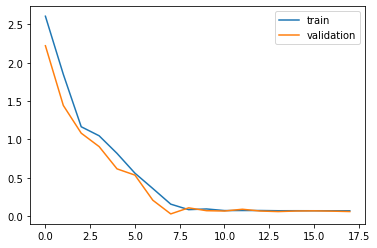


predict: [[34.09204887 23.02858207]]
real:      [[32.3 23. ]]

Train on 404 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.5107 - mean_squared_error: 6.3840 - val_loss: 2.0314 - val_mean_squared_error: 4.1375
Epoch 2/1000
 - 0s - loss: 1.5777 - mean_squared_error: 2.5662 - val_loss: 1.1355 - val_mean_squared_error: 1.2910
Epoch 3/1000
 - 0s - loss: 0.6604 - mean_squared_error: 0.5180 - val_loss: 0.1668 - val_mean_squared_error: 0.0332
Epoch 4/1000
 - 0s - loss: 0.2368 - mean_squared_error: 0.0730 - val_loss: 0.2268 - val_mean_squared_error: 0.0559
Epoch 5/1000
 - 0s - loss: 0.2247 - mean_squared_error: 0.0696 - val_loss: 0.1335 - val_mean_squared_error: 0.0213
Epoch 6/1000
 - 0s - loss: 0.1289 - mean_squared_error: 0.0243 - val_loss: 0.2115 - val_mean_squared_error: 0.0550
Epoch 7/1000
 - 0s - loss: 0.1002 - mean_squared_error: 0.0167 - val_loss: 0.0613 - val_mean_squared_error: 0.0050
Epoch 8/1000
 - 0s - loss: 0.0943 - mean_squared_error: 0.0155 - val_loss: 0.0769 - val

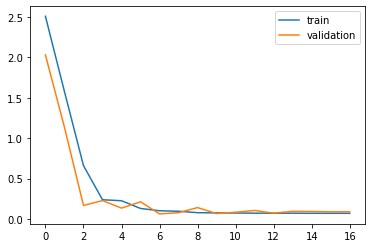


predict: [[35.84199752 22.18764369]]
real:      [[34.1 24.2]]

Train on 403 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.1041 - mean_squared_error: 9.6734 - val_loss: 2.8206 - val_mean_squared_error: 7.9701
Epoch 2/1000
 - 0s - loss: 2.5102 - mean_squared_error: 6.3598 - val_loss: 2.1899 - val_mean_squared_error: 4.8317
Epoch 3/1000
 - 0s - loss: 1.8534 - mean_squared_error: 3.4995 - val_loss: 1.5002 - val_mean_squared_error: 2.2558
Epoch 4/1000
 - 0s - loss: 1.1073 - mean_squared_error: 1.2859 - val_loss: 0.6256 - val_mean_squared_error: 0.4261
Epoch 5/1000
 - 0s - loss: 0.3499 - mean_squared_error: 0.1652 - val_loss: 0.1980 - val_mean_squared_error: 0.0544
Epoch 6/1000
 - 0s - loss: 0.2613 - mean_squared_error: 0.0869 - val_loss: 0.1361 - val_mean_squared_error: 0.0249
Epoch 7/1000
 - 0s - loss: 0.1812 - mean_squared_error: 0.0438 - val_loss: 0.1702 - val_mean_squared_error: 0.0423
Epoch 8/1000
 - 0s - loss: 0.1137 - mean_squared_error: 0.0190 - val_loss: 0.1047 - val

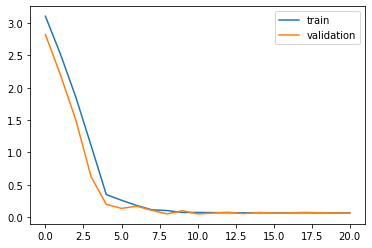


predict: [[33.55537812 21.96408327]]
real:      [[35.6 24.2]]

Train on 402 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.9087 - mean_squared_error: 8.5046 - val_loss: 2.5675 - val_mean_squared_error: 6.5922
Epoch 2/1000
 - 0s - loss: 2.2934 - mean_squared_error: 5.2942 - val_loss: 1.9853 - val_mean_squared_error: 3.9416
Epoch 3/1000
 - 0s - loss: 1.6882 - mean_squared_error: 2.8940 - val_loss: 1.3576 - val_mean_squared_error: 1.8446
Epoch 4/1000
 - 0s - loss: 1.0474 - mean_squared_error: 1.1428 - val_loss: 0.6763 - val_mean_squared_error: 0.4576
Epoch 5/1000
 - 0s - loss: 0.3480 - mean_squared_error: 0.1643 - val_loss: 0.0839 - val_mean_squared_error: 0.0092
Epoch 6/1000
 - 0s - loss: 0.2485 - mean_squared_error: 0.0730 - val_loss: 0.2161 - val_mean_squared_error: 0.0468
Epoch 7/1000
 - 0s - loss: 0.1598 - mean_squared_error: 0.0370 - val_loss: 0.1012 - val_mean_squared_error: 0.0158
Epoch 8/1000
 - 0s - loss: 0.1186 - mean_squared_error: 0.0184 - val_loss: 0.1345 - val

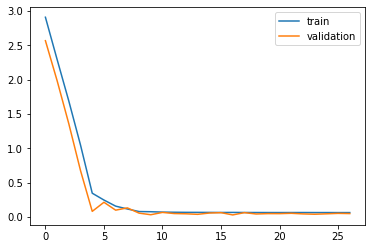


predict: [[33.39513023 23.23103452]]
real:      [[35.  23.6]]

Train on 401 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.1547 - mean_squared_error: 4.7934 - val_loss: 1.5004 - val_mean_squared_error: 2.2767
Epoch 2/1000
 - 0s - loss: 0.9510 - mean_squared_error: 1.0265 - val_loss: 0.4029 - val_mean_squared_error: 0.1847
Epoch 3/1000
 - 0s - loss: 0.2302 - mean_squared_error: 0.0723 - val_loss: 0.1877 - val_mean_squared_error: 0.0376
Epoch 4/1000
 - 0s - loss: 0.2345 - mean_squared_error: 0.0743 - val_loss: 0.1341 - val_mean_squared_error: 0.0357
Epoch 5/1000
 - 0s - loss: 0.1266 - mean_squared_error: 0.0222 - val_loss: 0.2179 - val_mean_squared_error: 0.0529
Epoch 6/1000
 - 0s - loss: 0.1137 - mean_squared_error: 0.0199 - val_loss: 0.0863 - val_mean_squared_error: 0.0077
Epoch 7/1000
 - 0s - loss: 0.0889 - mean_squared_error: 0.0136 - val_loss: 0.1091 - val_mean_squared_error: 0.0188
Epoch 8/1000
 - 0s - loss: 0.0818 - mean_squared_error: 0.0106 - val_loss: 0.1230 - val

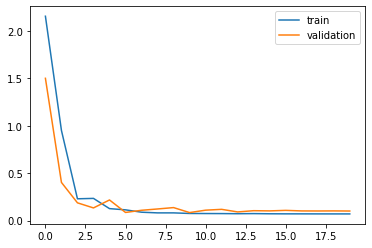


predict: [[34.24776942 22.18930779]]
real:      [[32.5 24. ]]

Train on 400 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0755 - mean_squared_error: 9.6848 - val_loss: 2.8435 - val_mean_squared_error: 8.2377
Epoch 2/1000
 - 0s - loss: 2.4216 - mean_squared_error: 6.0407 - val_loss: 2.0700 - val_mean_squared_error: 4.3619
Epoch 3/1000
 - 0s - loss: 1.6322 - mean_squared_error: 2.7943 - val_loss: 1.2751 - val_mean_squared_error: 1.7022
Epoch 4/1000
 - 0s - loss: 0.8308 - mean_squared_error: 0.8317 - val_loss: 0.4615 - val_mean_squared_error: 0.3126
Epoch 5/1000
 - 0s - loss: 0.2777 - mean_squared_error: 0.1120 - val_loss: 0.1240 - val_mean_squared_error: 0.0231
Epoch 6/1000
 - 0s - loss: 0.2583 - mean_squared_error: 0.0802 - val_loss: 0.1356 - val_mean_squared_error: 0.0186
Epoch 7/1000
 - 0s - loss: 0.1695 - mean_squared_error: 0.0436 - val_loss: 0.2257 - val_mean_squared_error: 0.0590
Epoch 8/1000
 - 0s - loss: 0.1049 - mean_squared_error: 0.0156 - val_loss: 0.1258 - val

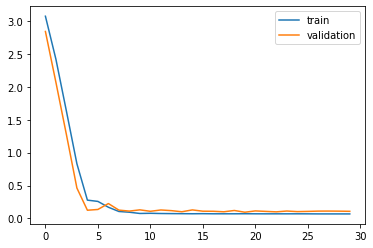


predict: [[34.48534136 22.35779781]]
real:      [[35.6 24.8]]

Train on 399 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.1706 - mean_squared_error: 10.1053 - val_loss: 2.8321 - val_mean_squared_error: 8.0211
Epoch 2/1000
 - 0s - loss: 2.4959 - mean_squared_error: 6.2655 - val_loss: 2.2312 - val_mean_squared_error: 4.9816
Epoch 3/1000
 - 0s - loss: 1.9347 - mean_squared_error: 3.7763 - val_loss: 1.6914 - val_mean_squared_error: 2.8669
Epoch 4/1000
 - 0s - loss: 1.3904 - mean_squared_error: 1.9734 - val_loss: 1.1298 - val_mean_squared_error: 1.2870
Epoch 5/1000
 - 0s - loss: 0.7981 - mean_squared_error: 0.6938 - val_loss: 0.4794 - val_mean_squared_error: 0.2613
Epoch 6/1000
 - 0s - loss: 0.2442 - mean_squared_error: 0.0893 - val_loss: 0.1482 - val_mean_squared_error: 0.0299
Epoch 7/1000
 - 0s - loss: 0.2638 - mean_squared_error: 0.0819 - val_loss: 0.0769 - val_mean_squared_error: 0.0102
Epoch 8/1000
 - 0s - loss: 0.1232 - mean_squared_error: 0.0224 - val_loss: 0.2131 - va

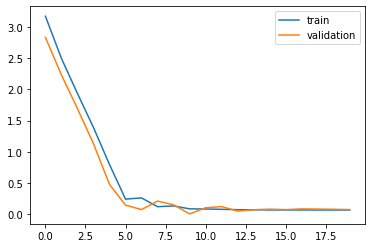


predict: [[37.38208735 23.97431319]]
real:      [[36.2 24.7]]

Train on 398 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.6347 - mean_squared_error: 7.0686 - val_loss: 2.3361 - val_mean_squared_error: 5.5822
Epoch 2/1000
 - 0s - loss: 2.0154 - mean_squared_error: 4.2649 - val_loss: 1.7103 - val_mean_squared_error: 3.1909
Epoch 3/1000
 - 0s - loss: 1.3658 - mean_squared_error: 2.2746 - val_loss: 1.0347 - val_mean_squared_error: 1.6126
Epoch 4/1000
 - 0s - loss: 0.8407 - mean_squared_error: 1.1335 - val_loss: 0.7364 - val_mean_squared_error: 0.7736
Epoch 5/1000
 - 0s - loss: 0.6059 - mean_squared_error: 0.4832 - val_loss: 0.3496 - val_mean_squared_error: 0.2376
Epoch 6/1000
 - 0s - loss: 0.2443 - mean_squared_error: 0.0994 - val_loss: 0.1572 - val_mean_squared_error: 0.0254
Epoch 7/1000
 - 0s - loss: 0.1231 - mean_squared_error: 0.0256 - val_loss: 0.1231 - val_mean_squared_error: 0.0190
Epoch 8/1000
 - 0s - loss: 0.1480 - mean_squared_error: 0.0350 - val_loss: 0.1032 - val

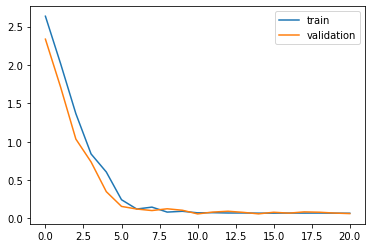


predict: [[34.88790989 21.69196071]]
real:      [[36.4 23.6]]

Train on 397 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.5243 - mean_squared_error: 12.4632 - val_loss: 3.2244 - val_mean_squared_error: 10.4586
Epoch 2/1000
 - 0s - loss: 3.0263 - mean_squared_error: 9.2221 - val_loss: 2.9072 - val_mean_squared_error: 8.5183
Epoch 3/1000
 - 0s - loss: 2.7300 - mean_squared_error: 7.5104 - val_loss: 2.5834 - val_mean_squared_error: 6.7254
Epoch 4/1000
 - 0s - loss: 2.3950 - mean_squared_error: 5.7859 - val_loss: 2.2257 - val_mean_squared_error: 4.9926
Epoch 5/1000
 - 0s - loss: 2.0107 - mean_squared_error: 4.0847 - val_loss: 1.8000 - val_mean_squared_error: 3.2616
Epoch 6/1000
 - 0s - loss: 1.5427 - mean_squared_error: 2.4179 - val_loss: 1.2100 - val_mean_squared_error: 1.4648
Epoch 7/1000
 - 0s - loss: 0.9025 - mean_squared_error: 0.8590 - val_loss: 0.5388 - val_mean_squared_error: 0.3035
Epoch 8/1000
 - 0s - loss: 0.2949 - mean_squared_error: 0.1212 - val_loss: 0.1574 - v

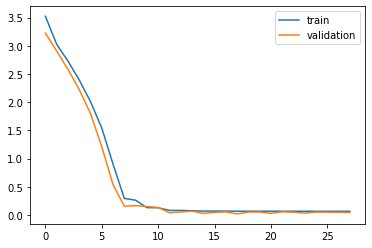


predict: [[34.09541241 22.61810949]]
real:      [[35.4 23.8]]

Train on 396 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.4238 - mean_squared_error: 11.7485 - val_loss: 3.3698 - val_mean_squared_error: 11.3623
Epoch 2/1000
 - 0s - loss: 3.2459 - mean_squared_error: 10.5483 - val_loss: 3.3114 - val_mean_squared_error: 10.9741
Epoch 3/1000
 - 0s - loss: 3.1860 - mean_squared_error: 10.1602 - val_loss: 3.2419 - val_mean_squared_error: 10.5147
Epoch 4/1000
 - 0s - loss: 3.1050 - mean_squared_error: 9.6491 - val_loss: 3.1420 - val_mean_squared_error: 9.8726
Epoch 5/1000
 - 0s - loss: 2.9934 - mean_squared_error: 8.9731 - val_loss: 2.9969 - val_mean_squared_error: 8.9874
Epoch 6/1000
 - 0s - loss: 2.8001 - mean_squared_error: 7.8727 - val_loss: 2.6864 - val_mean_squared_error: 7.2282
Epoch 7/1000
 - 0s - loss: 2.4366 - mean_squared_error: 5.9739 - val_loss: 2.2477 - val_mean_squared_error: 5.0592
Epoch 8/1000
 - 0s - loss: 1.9516 - mean_squared_error: 3.8536 - val_loss: 1.6896

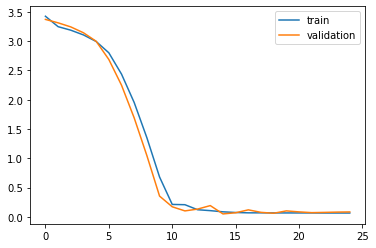


predict: [[33.69930129 23.12439874]]
real:      [[35.4 22.6]]

Train on 395 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.2184 - mean_squared_error: 10.8209 - val_loss: 3.0752 - val_mean_squared_error: 10.0708
Epoch 2/1000
 - 0s - loss: 2.9294 - mean_squared_error: 9.1534 - val_loss: 2.8633 - val_mean_squared_error: 8.9103
Epoch 3/1000
 - 0s - loss: 2.7195 - mean_squared_error: 8.1391 - val_loss: 2.6322 - val_mean_squared_error: 7.8917
Epoch 4/1000
 - 0s - loss: 2.4761 - mean_squared_error: 7.1435 - val_loss: 2.3540 - val_mean_squared_error: 6.8637
Epoch 5/1000
 - 0s - loss: 2.1699 - mean_squared_error: 6.1583 - val_loss: 2.0061 - val_mean_squared_error: 5.9892
Epoch 6/1000
 - 0s - loss: 1.7949 - mean_squared_error: 5.4196 - val_loss: 1.6789 - val_mean_squared_error: 5.3696
Epoch 7/1000
 - 0s - loss: 1.5578 - mean_squared_error: 4.5140 - val_loss: 1.4164 - val_mean_squared_error: 3.8519
Epoch 8/1000
 - 0s - loss: 1.2897 - mean_squared_error: 3.0845 - val_loss: 1.2019 - v

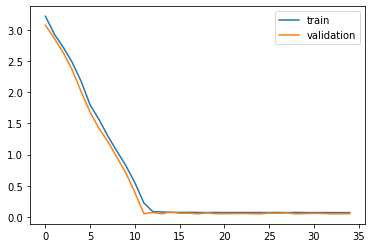


predict: [[33.69428824 22.56945157]]
real:      [[35.8 24.2]]

Train on 394 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.2030 - mean_squared_error: 10.8810 - val_loss: 3.0644 - val_mean_squared_error: 10.1802
Epoch 2/1000
 - 0s - loss: 2.9014 - mean_squared_error: 9.2076 - val_loss: 2.7966 - val_mean_squared_error: 8.8321
Epoch 3/1000
 - 0s - loss: 2.6257 - mean_squared_error: 7.9019 - val_loss: 2.5010 - val_mean_squared_error: 7.4622
Epoch 4/1000
 - 0s - loss: 2.2973 - mean_squared_error: 6.4752 - val_loss: 2.1082 - val_mean_squared_error: 5.7325
Epoch 5/1000
 - 0s - loss: 1.8777 - mean_squared_error: 4.7846 - val_loss: 1.6441 - val_mean_squared_error: 4.0260
Epoch 6/1000
 - 0s - loss: 1.3940 - mean_squared_error: 3.2424 - val_loss: 1.1457 - val_mean_squared_error: 2.5711
Epoch 7/1000
 - 0s - loss: 0.9545 - mean_squared_error: 1.7327 - val_loss: 0.7183 - val_mean_squared_error: 0.8827
Epoch 8/1000
 - 0s - loss: 0.4960 - mean_squared_error: 0.4197 - val_loss: 0.2623 - v

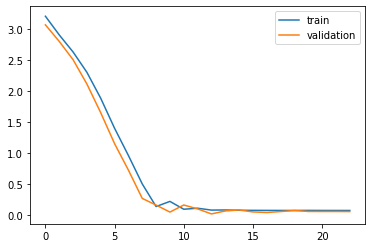


predict: [[35.40038888 23.28593891]]
real:      [[36.2 22. ]]

Train and validation time: 5.671196921666463

Maximum metrics
Test RMSE -------------------------- 1.468
Test VARIANCE ---------------------- -0.9159
Test MAX-ERROR --------------------- 2.806
Test MEAN-ABSOLUTE-ERROR ----------- 1.241
Test MEDIAN-ABSOLUTE-ERROR --------- 1.243

Errors
2015-04-30 = 1.536473644280271
2015-04-29 = 0.3576288904702949
2015-04-28 = 0.40042627159431277
2015-04-27 = 0.10355089814052576
2015-04-26 = 0.4132850069307352
2015-04-25 = 0.8922050069214507
2015-04-24 = 0.35693792017153214
2015-04-23 = 0.7591978743515924
2015-04-22 = 2.0652838816664527
2015-04-21 = 0.24023509916401053
2015-04-20 = 2.585207698628146
2015-04-19 = 1.9368737460799679
2015-04-18 = 0.20455243848663685
2015-04-17 = 2.806193033354596
2015-04-16 = 0.7919184712002547
2015-04-15 = 0.006941764052584176
2015-04-14 = 0.6979708754206797
2015-04-13 = 2.421676338046936
2015-04-12 = 1.7920488720987109
2015-04-11 = 1.7419975249194124
2015-0

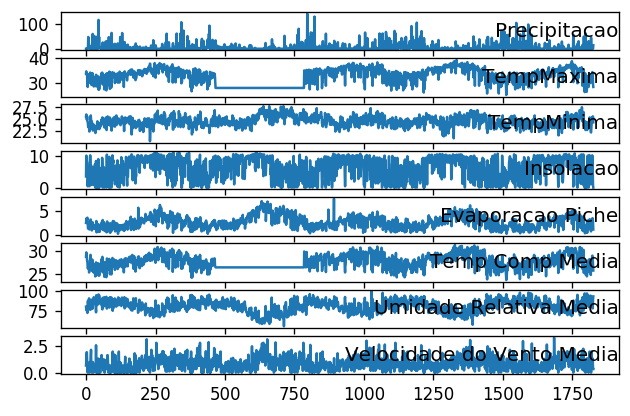

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 1.8807 - mean_squared_error: 4.4581 - val_loss: 0.1914 - val_mean_squared_error: 0.0455
Epoch 2/1000
 - 1s - loss: 0.1905 - mean_squared_error: 0.0537 - val_loss: 0.1536 - val_mean_squared_error: 0.0268
Epoch 3/1000
 - 1s - loss: 0.0732 - mean_squared_error: 0.0086 - val_loss: 0.0696 - val_mean_squared_error: 0.0070
Epoch 4/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0063 - val_loss: 0.0757 - val_mean_squared_error: 0.0078
Epoch 5/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0059 - val_loss: 0.0967 - val_mean_squared_error: 0.0124
Epoch 6/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0058 - val_loss: 0.0781 - val_mean_squared_error: 0.0089
Epoch 7/1000
 - 1s - loss: 0.0555 - mean_squared_error: 0.0058 - val_loss: 0.0844 - val_mean_squared_error: 0.0081
Epoch 8/1000
 - 1s - loss: 0.0546 - mean_squared_error: 0.0057 - val_loss: 0.0847 - val_mean_squared_error: 0.0088
Epoch 9/1000
 - 1s - loss: 0.0553 -

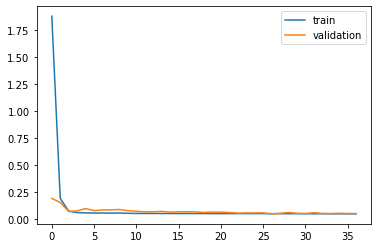


predict: [[32.5584514  24.09351685]]
real:      [[28.2 24.3]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 3.0964 - mean_squared_error: 10.0814 - val_loss: 2.4404 - val_mean_squared_error: 7.2128
Epoch 2/1000
 - 1s - loss: 1.3581 - mean_squared_error: 3.3400 - val_loss: 0.0784 - val_mean_squared_error: 0.0072
Epoch 3/1000
 - 1s - loss: 0.1589 - mean_squared_error: 0.0433 - val_loss: 0.0527 - val_mean_squared_error: 0.0033
Epoch 4/1000
 - 1s - loss: 0.0725 - mean_squared_error: 0.0085 - val_loss: 0.0222 - val_mean_squared_error: 4.9780e-04
Epoch 5/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0067 - val_loss: 0.0293 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0064 - val_loss: 0.0367 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0061 - val_loss: 0.0403 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0061 - val_loss: 0.0207

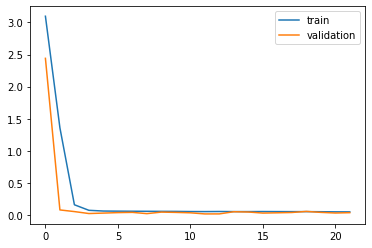


predict: [[32.31261472 24.62246426]]
real:      [[29.3 25.5]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.3766 - mean_squared_error: 6.5458 - val_loss: 1.0423 - val_mean_squared_error: 2.1482
Epoch 2/1000
 - 1s - loss: 0.4560 - mean_squared_error: 0.5365 - val_loss: 0.0987 - val_mean_squared_error: 0.0129
Epoch 3/1000
 - 1s - loss: 0.0812 - mean_squared_error: 0.0127 - val_loss: 0.0446 - val_mean_squared_error: 0.0033
Epoch 4/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0066 - val_loss: 0.0103 - val_mean_squared_error: 1.5819e-04
Epoch 5/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.0085 - val_mean_squared_error: 9.5429e-05
Epoch 6/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0060 - val_loss: 0.0171 - val_mean_squared_error: 3.4970e-04
Epoch 7/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0060 - val_loss: 0.0160 - val_mean_squared_error: 2.6197e-04
Epoch 8/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0060 - val_l

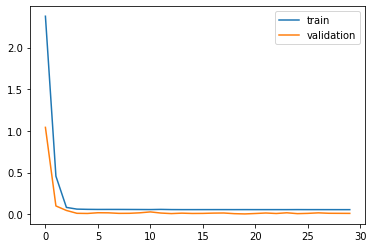


predict: [[34.35543394 24.38160663]]
real:      [[32.7 25.4]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.4378 - mean_squared_error: 6.9182 - val_loss: 1.4447 - val_mean_squared_error: 3.9754
Epoch 2/1000
 - 1s - loss: 0.9472 - mean_squared_error: 1.8005 - val_loss: 0.3755 - val_mean_squared_error: 0.2205
Epoch 3/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0362 - val_loss: 0.0928 - val_mean_squared_error: 0.0111
Epoch 4/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0077 - val_loss: 0.0468 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0061 - val_loss: 0.0363 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0059 - val_loss: 0.0270 - val_mean_squared_error: 9.9490e-04
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0060 - val_loss: 0.0265 - val_mean_squared_error: 7.0551e-04
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0058 - val_loss: 0.0

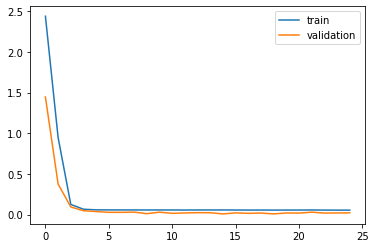


predict: [[34.11080342 25.25390854]]
real:      [[34.3 24.3]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.7928 - mean_squared_error: 8.3010 - val_loss: 1.4762 - val_mean_squared_error: 2.3286
Epoch 2/1000
 - 1s - loss: 0.5498 - mean_squared_error: 0.5492 - val_loss: 0.1439 - val_mean_squared_error: 0.0352
Epoch 3/1000
 - 1s - loss: 0.1033 - mean_squared_error: 0.0162 - val_loss: 0.0174 - val_mean_squared_error: 5.8781e-04
Epoch 4/1000
 - 1s - loss: 0.0668 - mean_squared_error: 0.0076 - val_loss: 0.0096 - val_mean_squared_error: 1.5945e-04
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0066 - val_loss: 0.0134 - val_mean_squared_error: 2.0647e-04
Epoch 6/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0064 - val_loss: 0.0202 - val_mean_squared_error: 5.3566e-04
Epoch 7/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0063 - val_loss: 0.0286 - val_mean_squared_error: 8.7092e-04
Epoch 8/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0063 - v

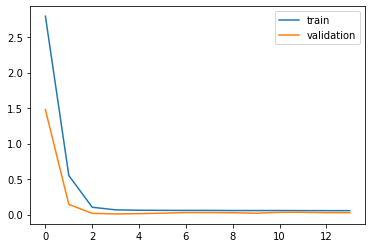


predict: [[33.7263313  25.54952787]]
real:      [[34.2 25.4]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 3.5511 - mean_squared_error: 12.7480 - val_loss: 3.2640 - val_mean_squared_error: 10.7278
Epoch 2/1000
 - 1s - loss: 3.0095 - mean_squared_error: 9.1707 - val_loss: 2.5352 - val_mean_squared_error: 6.4546
Epoch 3/1000
 - 1s - loss: 1.6909 - mean_squared_error: 3.2469 - val_loss: 0.4440 - val_mean_squared_error: 0.3921
Epoch 4/1000
 - 1s - loss: 0.1921 - mean_squared_error: 0.0775 - val_loss: 0.0909 - val_mean_squared_error: 0.0096
Epoch 5/1000
 - 1s - loss: 0.0721 - mean_squared_error: 0.0096 - val_loss: 0.0042 - val_mean_squared_error: 2.1386e-05
Epoch 6/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0061 - val_loss: 0.0220 - val_mean_squared_error: 6.1473e-04
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.0253 - val_mean_squared_error: 8.6141e-04
Epoch 8/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0059 - val_los

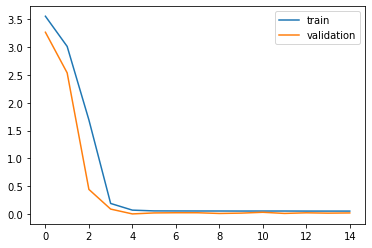


predict: [[32.22597334 24.13066735]]
real:      [[32.7 25.1]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.8792 - mean_squared_error: 8.4356 - val_loss: 2.2463 - val_mean_squared_error: 5.0680
Epoch 2/1000
 - 1s - loss: 1.5830 - mean_squared_error: 2.7241 - val_loss: 0.6020 - val_mean_squared_error: 0.3637
Epoch 3/1000
 - 1s - loss: 0.2024 - mean_squared_error: 0.0713 - val_loss: 0.0327 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0075 - val_loss: 0.0369 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0060 - val_loss: 0.0412 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0059 - val_loss: 0.0287 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0059 - val_loss: 0.0419 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0059 - val_loss: 0.0319 - va

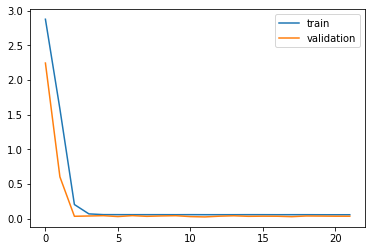


predict: [[32.79437701 24.20159417]]
real:      [[32.5 24.1]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.3357 - mean_squared_error: 2.5544 - val_loss: 0.5232 - val_mean_squared_error: 0.3491
Epoch 2/1000
 - 1s - loss: 0.2254 - mean_squared_error: 0.0971 - val_loss: 0.1060 - val_mean_squared_error: 0.0126
Epoch 3/1000
 - 1s - loss: 0.0687 - mean_squared_error: 0.0086 - val_loss: 0.0628 - val_mean_squared_error: 0.0051
Epoch 4/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0060 - val_loss: 0.0584 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0063 - val_loss: 0.0510 - val_mean_squared_error: 0.0045
Epoch 6/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0062 - val_loss: 0.0493 - val_mean_squared_error: 0.0040
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_loss: 0.0500 - val_mean_squared_error: 0.0047
Epoch 8/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062 - val_loss: 0.0726 - va

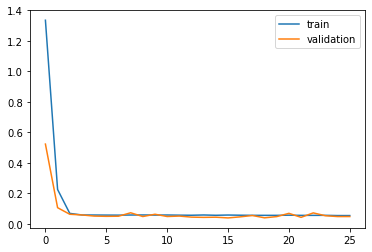


predict: [[33.34054228 24.53016093]]
real:      [[33.  23.1]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.0990 - mean_squared_error: 5.6673 - val_loss: 1.0784 - val_mean_squared_error: 1.9226
Epoch 2/1000
 - 1s - loss: 0.4303 - mean_squared_error: 0.4933 - val_loss: 0.1810 - val_mean_squared_error: 0.0407
Epoch 3/1000
 - 1s - loss: 0.0797 - mean_squared_error: 0.0120 - val_loss: 0.0557 - val_mean_squared_error: 0.0031
Epoch 4/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0067 - val_loss: 0.0790 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0061 - val_loss: 0.0865 - val_mean_squared_error: 0.0076
Epoch 6/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0060 - val_loss: 0.0868 - val_mean_squared_error: 0.0080
Epoch 7/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0059 - val_loss: 0.0998 - val_mean_squared_error: 0.0100
Epoch 8/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0059 - val_loss: 0.1013 - va

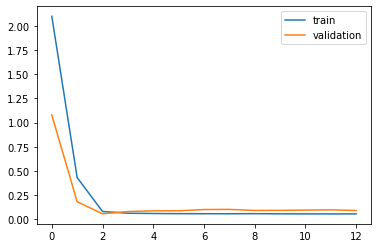


predict: [[30.12709438 22.45067128]]
real:      [[33.2 22.2]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.7842 - mean_squared_error: 4.0997 - val_loss: 0.3103 - val_mean_squared_error: 0.1148
Epoch 2/1000
 - 1s - loss: 0.2016 - mean_squared_error: 0.0707 - val_loss: 0.1369 - val_mean_squared_error: 0.0190
Epoch 3/1000
 - 1s - loss: 0.0835 - mean_squared_error: 0.0114 - val_loss: 0.0783 - val_mean_squared_error: 0.0067
Epoch 4/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0067 - val_loss: 0.0797 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0065 - val_loss: 0.0749 - val_mean_squared_error: 0.0060
Epoch 6/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0061 - val_loss: 0.0740 - val_mean_squared_error: 0.0064
Epoch 7/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0063 - val_loss: 0.0636 - val_mean_squared_error: 0.0047
Epoch 8/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0059 - val_loss: 0.0785 - va

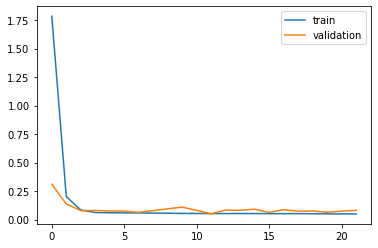


predict: [[32.44062859 24.20057875]]
real:      [[30.2 22.3]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.2545 - mean_squared_error: 2.7634 - val_loss: 0.2147 - val_mean_squared_error: 0.0902
Epoch 2/1000
 - 1s - loss: 0.1328 - mean_squared_error: 0.0287 - val_loss: 0.0194 - val_mean_squared_error: 6.6009e-04
Epoch 3/1000
 - 1s - loss: 0.0714 - mean_squared_error: 0.0084 - val_loss: 0.0165 - val_mean_squared_error: 3.9539e-04
Epoch 4/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0069 - val_loss: 0.0256 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0066 - val_loss: 0.0354 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0063 - val_loss: 0.0296 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_loss: 0.0207 - val_mean_squared_error: 5.0615e-04
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0061 - val_loss:

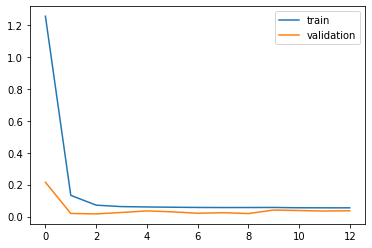


predict: [[32.14971175 23.36724199]]
real:      [[29.8 23.1]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.8280 - mean_squared_error: 8.5010 - val_loss: 2.1213 - val_mean_squared_error: 5.8385
Epoch 2/1000
 - 1s - loss: 1.7074 - mean_squared_error: 4.8879 - val_loss: 1.3474 - val_mean_squared_error: 3.4916
Epoch 3/1000
 - 1s - loss: 1.1291 - mean_squared_error: 2.4045 - val_loss: 0.7856 - val_mean_squared_error: 1.0953
Epoch 4/1000
 - 1s - loss: 0.4201 - mean_squared_error: 0.4013 - val_loss: 0.1141 - val_mean_squared_error: 0.0182
Epoch 5/1000
 - 1s - loss: 0.0871 - mean_squared_error: 0.0117 - val_loss: 0.0847 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.0631 - val_mean_squared_error: 0.0058
Epoch 7/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0060 - val_loss: 0.0601 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0060 - val_loss: 0.0582 - va

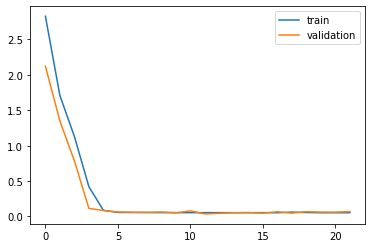


predict: [[32.01845005 24.42128669]]
real:      [[32.7 23.4]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.1188 - mean_squared_error: 5.3580 - val_loss: 0.5752 - val_mean_squared_error: 0.5576
Epoch 2/1000
 - 1s - loss: 0.2480 - mean_squared_error: 0.1148 - val_loss: 0.0861 - val_mean_squared_error: 0.0076
Epoch 3/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0094 - val_loss: 0.0209 - val_mean_squared_error: 8.6133e-04
Epoch 4/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0065 - val_loss: 0.0463 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - val_loss: 0.0360 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0059 - val_loss: 0.0503 - val_mean_squared_error: 0.0026
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0060 - val_loss: 0.0362 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0060 - val_loss: 0.0324 

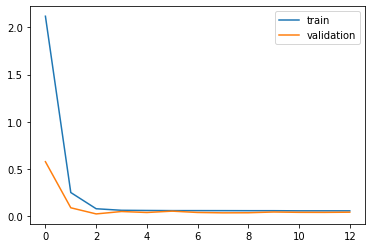


predict: [[33.63705355 25.42888272]]
real:      [[30.2 23.5]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.9770 - mean_squared_error: 8.9289 - val_loss: 2.4651 - val_mean_squared_error: 6.0790
Epoch 2/1000
 - 1s - loss: 1.7332 - mean_squared_error: 3.2714 - val_loss: 0.6451 - val_mean_squared_error: 0.4196
Epoch 3/1000
 - 1s - loss: 0.2117 - mean_squared_error: 0.0784 - val_loss: 0.0916 - val_mean_squared_error: 0.0134
Epoch 4/1000
 - 1s - loss: 0.0744 - mean_squared_error: 0.0098 - val_loss: 0.0072 - val_mean_squared_error: 5.7943e-05
Epoch 5/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0061 - val_loss: 0.0203 - val_mean_squared_error: 8.0906e-04
Epoch 6/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.0114 - val_mean_squared_error: 2.0340e-04
Epoch 7/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0060 - val_loss: 0.0126 - val_mean_squared_error: 1.6197e-04
Epoch 8/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0061 - val_l

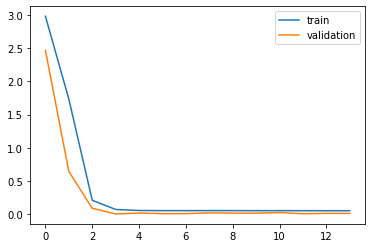


predict: [[32.42365866 24.18304066]]
real:      [[32.3 25.3]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.8319 - mean_squared_error: 4.0385 - val_loss: 0.2128 - val_mean_squared_error: 0.0642
Epoch 2/1000
 - 1s - loss: 0.1782 - mean_squared_error: 0.0497 - val_loss: 0.0630 - val_mean_squared_error: 0.0057
Epoch 3/1000
 - 1s - loss: 0.0730 - mean_squared_error: 0.0086 - val_loss: 0.0232 - val_mean_squared_error: 8.3412e-04
Epoch 4/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0064 - val_loss: 0.0108 - val_mean_squared_error: 1.1710e-04
Epoch 5/1000
 - 1s - loss: 0.0585 - mean_squared_error: 0.0062 - val_loss: 0.0111 - val_mean_squared_error: 1.9881e-04
Epoch 6/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062 - val_loss: 0.0073 - val_mean_squared_error: 7.7494e-05
Epoch 7/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0061 - val_loss: 0.0137 - val_mean_squared_error: 3.2464e-04
Epoch 8/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0060 - v

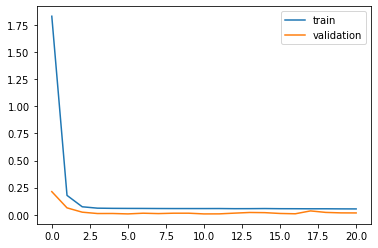


predict: [[33.07649483 24.24764349]]
real:      [[32.7 24.1]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.8103 - mean_squared_error: 4.2184 - val_loss: 0.1057 - val_mean_squared_error: 0.0170
Epoch 2/1000
 - 1s - loss: 0.1613 - mean_squared_error: 0.0390 - val_loss: 0.1031 - val_mean_squared_error: 0.0107
Epoch 3/1000
 - 1s - loss: 0.0678 - mean_squared_error: 0.0077 - val_loss: 0.0539 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0066 - val_loss: 0.0424 - val_mean_squared_error: 0.0018
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0063 - val_loss: 0.0375 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0061 - val_loss: 0.0492 - val_mean_squared_error: 0.0024
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0063 - val_loss: 0.0216 - val_mean_squared_error: 4.6735e-04
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0059 - val_loss: 0.0471 

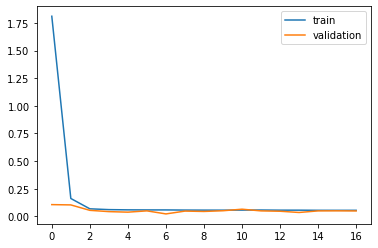


predict: [[32.33155466 24.15170074]]
real:      [[33.3 23.9]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3708 - mean_squared_error: 6.1368 - val_loss: 0.9782 - val_mean_squared_error: 1.1130
Epoch 2/1000
 - 1s - loss: 0.3757 - mean_squared_error: 0.2879 - val_loss: 0.1225 - val_mean_squared_error: 0.0156
Epoch 3/1000
 - 1s - loss: 0.0809 - mean_squared_error: 0.0099 - val_loss: 0.0799 - val_mean_squared_error: 0.0076
Epoch 4/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0068 - val_loss: 0.0854 - val_mean_squared_error: 0.0112
Epoch 5/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0063 - val_loss: 0.1150 - val_mean_squared_error: 0.0166
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.1111 - val_mean_squared_error: 0.0162
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0062 - val_loss: 0.1073 - val_mean_squared_error: 0.0143
Epoch 8/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.0921 - va

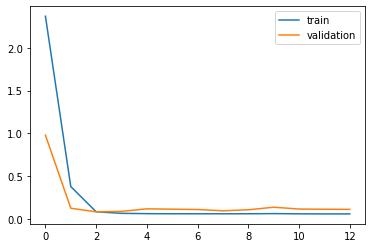


predict: [[30.73672317 25.16335356]]
real:      [[31.7 23.5]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.2990 - mean_squared_error: 5.9723 - val_loss: 0.9714 - val_mean_squared_error: 1.6479
Epoch 2/1000
 - 1s - loss: 0.5052 - mean_squared_error: 0.5264 - val_loss: 0.1226 - val_mean_squared_error: 0.0220
Epoch 3/1000
 - 1s - loss: 0.1026 - mean_squared_error: 0.0165 - val_loss: 0.0152 - val_mean_squared_error: 2.9712e-04
Epoch 4/1000
 - 1s - loss: 0.0672 - mean_squared_error: 0.0076 - val_loss: 0.0359 - val_mean_squared_error: 0.0014
Epoch 5/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0065 - val_loss: 0.0249 - val_mean_squared_error: 9.1329e-04
Epoch 6/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0064 - val_loss: 0.0252 - val_mean_squared_error: 8.2349e-04
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0064 - val_loss: 0.0161 - val_mean_squared_error: 3.0178e-04
Epoch 8/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_l

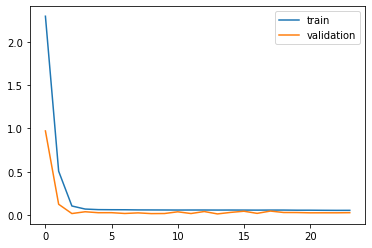


predict: [[33.25469818 24.39612214]]
real:      [[28.2 23.1]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.1553 - mean_squared_error: 5.1731 - val_loss: 0.8662 - val_mean_squared_error: 1.2160
Epoch 2/1000
 - 1s - loss: 0.4545 - mean_squared_error: 0.3879 - val_loss: 0.1452 - val_mean_squared_error: 0.0316
Epoch 3/1000
 - 1s - loss: 0.0938 - mean_squared_error: 0.0136 - val_loss: 0.0367 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0071 - val_loss: 0.0500 - val_mean_squared_error: 0.0032
Epoch 5/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0063 - val_loss: 0.0596 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.0695 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.0542 - val_mean_squared_error: 0.0034
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0060 - val_loss: 0.0466 - va

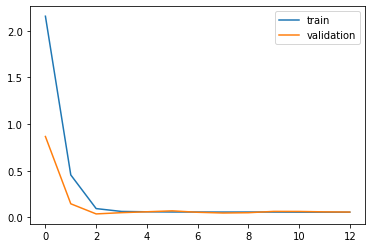


predict: [[30.81539993 24.32726238]]
real:      [[32.3 24. ]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.4534 - mean_squared_error: 6.4418 - val_loss: 1.3382 - val_mean_squared_error: 2.1099
Epoch 2/1000
 - 1s - loss: 0.5956 - mean_squared_error: 0.7512 - val_loss: 0.1799 - val_mean_squared_error: 0.0371
Epoch 3/1000
 - 1s - loss: 0.1052 - mean_squared_error: 0.0170 - val_loss: 0.0433 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0066 - val_loss: 0.0098 - val_mean_squared_error: 1.1656e-04
Epoch 5/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0063 - val_loss: 0.0087 - val_mean_squared_error: 7.5611e-05
Epoch 6/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0060 - val_loss: 0.0134 - val_mean_squared_error: 3.5145e-04
Epoch 7/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0061 - val_loss: 0.0238 - val_mean_squared_error: 9.2328e-04
Epoch 8/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0061 - val_l

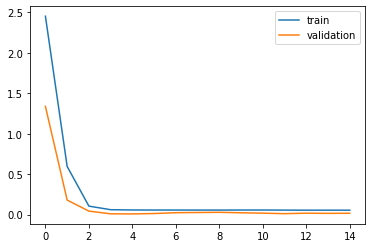


predict: [[33.32803417 24.62649643]]
real:      [[30.7 23.6]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.1756 - mean_squared_error: 5.3226 - val_loss: 0.6268 - val_mean_squared_error: 0.4321
Epoch 2/1000
 - 1s - loss: 0.2662 - mean_squared_error: 0.1217 - val_loss: 0.0784 - val_mean_squared_error: 0.0076
Epoch 3/1000
 - 1s - loss: 0.0802 - mean_squared_error: 0.0109 - val_loss: 0.0574 - val_mean_squared_error: 0.0052
Epoch 4/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0064 - val_loss: 0.0686 - val_mean_squared_error: 0.0090
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0063 - val_loss: 0.0819 - val_mean_squared_error: 0.0101
Epoch 6/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0062 - val_loss: 0.0614 - val_mean_squared_error: 0.0071
Epoch 7/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0060 - val_loss: 0.0703 - val_mean_squared_error: 0.0082
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0061 - val_loss: 0.0545 - va

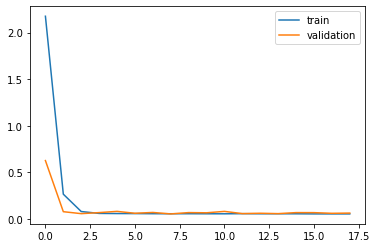


predict: [[32.21338024 24.13085909]]
real:      [[32.7 24.1]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.3829 - mean_squared_error: 3.1823 - val_loss: 0.2425 - val_mean_squared_error: 0.0634
Epoch 2/1000
 - 1s - loss: 0.1202 - mean_squared_error: 0.0219 - val_loss: 0.0395 - val_mean_squared_error: 0.0021
Epoch 3/1000
 - 1s - loss: 0.0697 - mean_squared_error: 0.0083 - val_loss: 0.0704 - val_mean_squared_error: 0.0050
Epoch 4/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0073 - val_loss: 0.0477 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0064 - val_loss: 0.0564 - val_mean_squared_error: 0.0034
Epoch 6/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0060 - val_loss: 0.0651 - val_mean_squared_error: 0.0043
Epoch 7/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0060 - val_loss: 0.0664 - val_mean_squared_error: 0.0044
Epoch 8/1000
 - 1s - loss: 0.0554 - mean_squared_error: 0.0057 - val_loss: 0.0771 - va

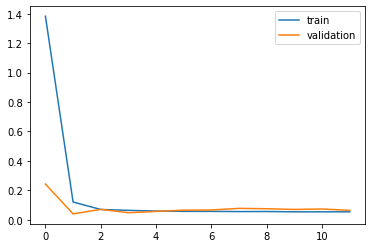


predict: [[31.89864034 24.41374198]]
real:      [[29.3 24.3]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.1647 - mean_squared_error: 2.1358 - val_loss: 0.1291 - val_mean_squared_error: 0.0201
Epoch 2/1000
 - 1s - loss: 0.1069 - mean_squared_error: 0.0173 - val_loss: 0.1152 - val_mean_squared_error: 0.0193
Epoch 3/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0069 - val_loss: 0.0978 - val_mean_squared_error: 0.0148
Epoch 4/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0062 - val_loss: 0.1256 - val_mean_squared_error: 0.0239
Epoch 5/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0062 - val_loss: 0.1199 - val_mean_squared_error: 0.0208
Epoch 6/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0059 - val_loss: 0.1126 - val_mean_squared_error: 0.0194
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0061 - val_loss: 0.1518 - val_mean_squared_error: 0.0297
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0060 - val_loss: 0.1058 - va

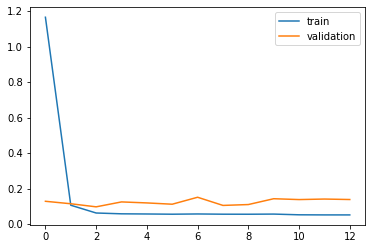


predict: [[31.78318881 23.29890667]]
real:      [[31.7 22.7]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.6158 - mean_squared_error: 3.5392 - val_loss: 0.3875 - val_mean_squared_error: 0.2104
Epoch 2/1000
 - 1s - loss: 0.1859 - mean_squared_error: 0.0627 - val_loss: 0.1866 - val_mean_squared_error: 0.0417
Epoch 3/1000
 - 1s - loss: 0.0685 - mean_squared_error: 0.0080 - val_loss: 0.1450 - val_mean_squared_error: 0.0282
Epoch 4/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0067 - val_loss: 0.1242 - val_mean_squared_error: 0.0256
Epoch 5/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0064 - val_loss: 0.1263 - val_mean_squared_error: 0.0256
Epoch 6/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062 - val_loss: 0.1272 - val_mean_squared_error: 0.0313
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0062 - val_loss: 0.1251 - val_mean_squared_error: 0.0258
Epoch 8/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.1513 - va

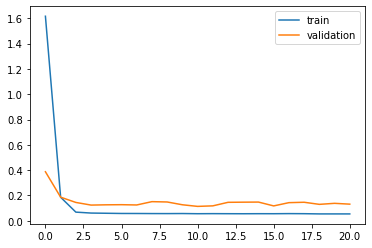


predict: [[32.57713884 24.74065556]]
real:      [[27.2 23.6]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.8585 - mean_squared_error: 8.4586 - val_loss: 2.2184 - val_mean_squared_error: 5.8334
Epoch 2/1000
 - 1s - loss: 1.7255 - mean_squared_error: 4.8578 - val_loss: 1.3059 - val_mean_squared_error: 3.1059
Epoch 3/1000
 - 1s - loss: 1.0144 - mean_squared_error: 1.9381 - val_loss: 0.6796 - val_mean_squared_error: 0.8253
Epoch 4/1000
 - 1s - loss: 0.4746 - mean_squared_error: 0.4054 - val_loss: 0.2328 - val_mean_squared_error: 0.0545
Epoch 5/1000
 - 1s - loss: 0.1036 - mean_squared_error: 0.0181 - val_loss: 0.0300 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0067 - val_loss: 0.0211 - val_mean_squared_error: 8.5529e-04
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0058 - val_loss: 0.0298 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0059 - val_loss: 0.0426 

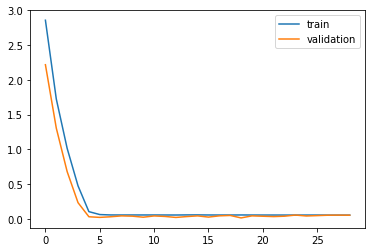


predict: [[32.92127396 24.16165712]]
real:      [[26.2 24. ]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.7532 - mean_squared_error: 4.2136 - val_loss: 0.7435 - val_mean_squared_error: 0.7137
Epoch 2/1000
 - 1s - loss: 0.2914 - mean_squared_error: 0.2081 - val_loss: 0.1198 - val_mean_squared_error: 0.0276
Epoch 3/1000
 - 1s - loss: 0.0736 - mean_squared_error: 0.0097 - val_loss: 0.0869 - val_mean_squared_error: 0.0083
Epoch 4/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0065 - val_loss: 0.0652 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0062 - val_loss: 0.0559 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0061 - val_loss: 0.0663 - val_mean_squared_error: 0.0047
Epoch 7/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0059 - val_loss: 0.0812 - val_mean_squared_error: 0.0067
Epoch 8/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0064 - val_loss: 0.0607 - va

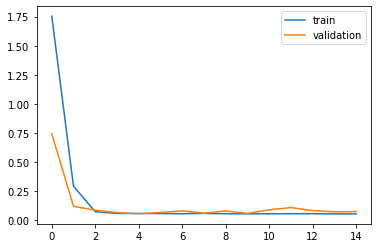


predict: [[32.25026219 24.66966817]]
real:      [[31.9 24. ]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.4898 - mean_squared_error: 6.6312 - val_loss: 1.4491 - val_mean_squared_error: 2.3914
Epoch 2/1000
 - 1s - loss: 0.6762 - mean_squared_error: 0.8378 - val_loss: 0.1264 - val_mean_squared_error: 0.0301
Epoch 3/1000
 - 1s - loss: 0.0895 - mean_squared_error: 0.0127 - val_loss: 0.1202 - val_mean_squared_error: 0.0210
Epoch 4/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0067 - val_loss: 0.1261 - val_mean_squared_error: 0.0186
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0063 - val_loss: 0.0923 - val_mean_squared_error: 0.0108
Epoch 6/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0062 - val_loss: 0.0986 - val_mean_squared_error: 0.0125
Epoch 7/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0060 - val_loss: 0.1033 - val_mean_squared_error: 0.0134
Epoch 8/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0063 - val_loss: 0.1010 - va

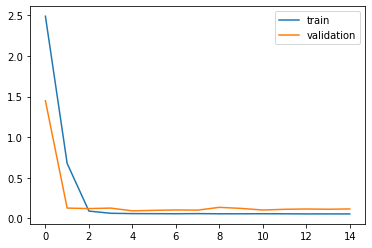


predict: [[30.82795621 23.99093728]]
real:      [[31.  23.3]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.8838 - mean_squared_error: 9.1552 - val_loss: 1.9254 - val_mean_squared_error: 5.4365
Epoch 2/1000
 - 1s - loss: 1.5512 - mean_squared_error: 4.2493 - val_loss: 1.1514 - val_mean_squared_error: 2.3474
Epoch 3/1000
 - 1s - loss: 0.8453 - mean_squared_error: 1.3654 - val_loss: 0.4390 - val_mean_squared_error: 0.2831
Epoch 4/1000
 - 1s - loss: 0.1766 - mean_squared_error: 0.0680 - val_loss: 0.0969 - val_mean_squared_error: 0.0127
Epoch 5/1000
 - 1s - loss: 0.0681 - mean_squared_error: 0.0078 - val_loss: 0.0989 - val_mean_squared_error: 0.0100
Epoch 6/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0064 - val_loss: 0.1005 - val_mean_squared_error: 0.0112
Epoch 7/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0063 - val_loss: 0.1025 - val_mean_squared_error: 0.0131
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0061 - val_loss: 0.0990 - va

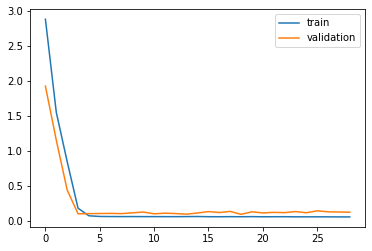


predict: [[32.6053778  24.58439154]]
real:      [[27.9 23.1]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.5870 - mean_squared_error: 7.0609 - val_loss: 1.5846 - val_mean_squared_error: 2.6672
Epoch 2/1000
 - 1s - loss: 0.6585 - mean_squared_error: 0.7196 - val_loss: 0.1067 - val_mean_squared_error: 0.0126
Epoch 3/1000
 - 1s - loss: 0.0979 - mean_squared_error: 0.0145 - val_loss: 0.0648 - val_mean_squared_error: 0.0048
Epoch 4/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0068 - val_loss: 0.0219 - val_mean_squared_error: 5.6266e-04
Epoch 5/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0062 - val_loss: 0.0153 - val_mean_squared_error: 2.5388e-04
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0062 - val_loss: 0.0202 - val_mean_squared_error: 7.0023e-04
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.0177 - val_mean_squared_error: 3.9614e-04
Epoch 8/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0061 - val_l

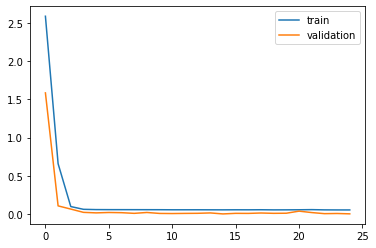


predict: [[32.95452162 24.92093999]]
real:      [[28.5 22.7]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 3.0541 - mean_squared_error: 9.4763 - val_loss: 2.5480 - val_mean_squared_error: 6.7749
Epoch 2/1000
 - 1s - loss: 1.9457 - mean_squared_error: 5.3334 - val_loss: 1.2876 - val_mean_squared_error: 2.8774
Epoch 3/1000
 - 1s - loss: 0.7437 - mean_squared_error: 1.2173 - val_loss: 0.0828 - val_mean_squared_error: 0.0134
Epoch 4/1000
 - 1s - loss: 0.0893 - mean_squared_error: 0.0152 - val_loss: 0.0467 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0074 - val_loss: 0.0059 - val_mean_squared_error: 5.1423e-05
Epoch 6/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0060 - val_loss: 0.0312 - val_mean_squared_error: 9.7762e-04
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.0184 - val_mean_squared_error: 6.3237e-04
Epoch 8/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0062 - val_loss:

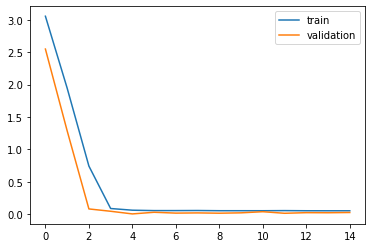


predict: [[32.31887388 25.37453467]]
real:      [[33.8 24.5]]

Train and validation time: 13.910328435897828

Maximum metrics
Test RMSE -------------------------- 2.744
Test VARIANCE ---------------------- -0.2209
Test MAX-ERROR --------------------- 6.721
Test MEAN-ABSOLUTE-ERROR ----------- 2.02
Test MEDIAN-ABSOLUTE-ERROR --------- 1.483

Errors
2018-12-31 = 4.358451400951868
2018-12-30 = 3.0126147236641216
2018-12-29 = 1.6554339425166802
2018-12-28 = 0.18919657550665647
2018-12-27 = 0.47366870391259397
2018-12-26 = 0.4740266579182375
2018-12-25 = 0.2943770057110413
2018-12-24 = 0.3405422787420207
2018-12-23 = 3.0729056183451924
2018-12-22 = 2.2406285858801667
2018-12-21 = 2.3497117535728727
2018-12-20 = 0.6815499451809259
2018-12-19 = 3.4370535455267444
2018-12-18 = 0.12365865898790673
2018-12-17 = 0.3764948254755467
2018-12-16 = 0.9684453407075111
2018-12-15 = 0.963276825860504
2018-12-14 = 5.054698184174139
2018-12-13 = 1.4846000702815019
2018-12-12 = 2.6280341744582145
2018-12-1

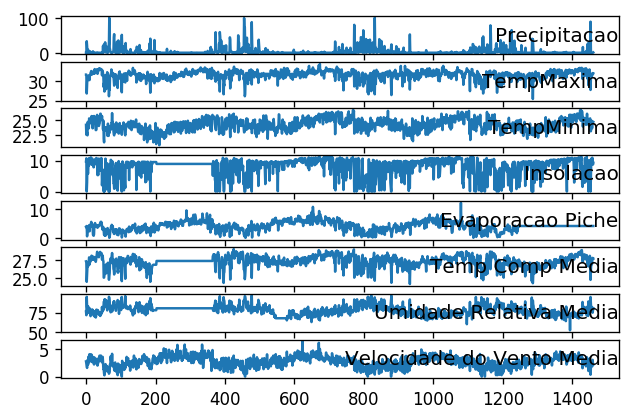

Train on 1399 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 3.0275 - mean_squared_error: 9.2799 - val_loss: 2.4828 - val_mean_squared_error: 6.1687
Epoch 2/1000
 - 1s - loss: 1.8014 - mean_squared_error: 3.4268 - val_loss: 0.9100 - val_mean_squared_error: 0.8526
Epoch 3/1000
 - 1s - loss: 0.3037 - mean_squared_error: 0.1534 - val_loss: 0.1058 - val_mean_squared_error: 0.0149
Epoch 4/1000
 - 1s - loss: 0.0720 - mean_squared_error: 0.0077 - val_loss: 0.0437 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 1s - loss: 0.0376 - mean_squared_error: 0.0024 - val_loss: 0.0213 - val_mean_squared_error: 8.0398e-04
Epoch 6/1000
 - 1s - loss: 0.0317 - mean_squared_error: 0.0018 - val_loss: 0.0172 - val_mean_squared_error: 2.9524e-04
Epoch 7/1000
 - 1s - loss: 0.0301 - mean_squared_error: 0.0016 - val_loss: 0.0142 - val_mean_squared_error: 2.0355e-04
Epoch 8/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0156 - val_mean_squared_error: 3.3328e-04
Epoch 9/1000
 - 1s 

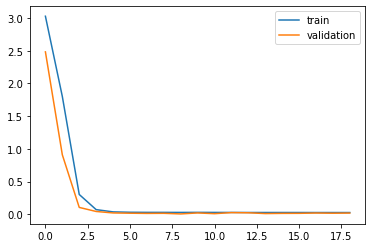


predict: [[31.09547938 23.70020216]]
real:      [[31.9 24.7]]

Train on 1398 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.5010 - mean_squared_error: 6.5959 - val_loss: 1.7026 - val_mean_squared_error: 3.3593
Epoch 2/1000
 - 1s - loss: 1.0289 - mean_squared_error: 1.6962 - val_loss: 0.4892 - val_mean_squared_error: 0.3452
Epoch 3/1000
 - 1s - loss: 0.1877 - mean_squared_error: 0.0689 - val_loss: 0.0247 - val_mean_squared_error: 0.0010
Epoch 4/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0054 - val_loss: 0.0607 - val_mean_squared_error: 0.0039
Epoch 5/1000
 - 1s - loss: 0.0388 - mean_squared_error: 0.0025 - val_loss: 0.0087 - val_mean_squared_error: 1.1617e-04
Epoch 6/1000
 - 1s - loss: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0141 - val_mean_squared_error: 2.1096e-04
Epoch 7/1000
 - 1s - loss: 0.0321 - mean_squared_error: 0.0018 - val_loss: 0.0086 - val_mean_squared_error: 8.5416e-05
Epoch 8/1000
 - 1s - loss: 0.0323 - mean_squared_error: 0.0018 - val_loss:

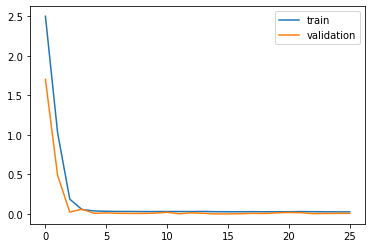


predict: [[31.50074983 23.77123695]]
real:      [[31.7 24.6]]

Train on 1397 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 3.0509 - mean_squared_error: 9.3979 - val_loss: 2.3040 - val_mean_squared_error: 5.3310
Epoch 2/1000
 - 1s - loss: 1.0885 - mean_squared_error: 1.7234 - val_loss: 0.2092 - val_mean_squared_error: 0.0460
Epoch 3/1000
 - 1s - loss: 0.1475 - mean_squared_error: 0.0312 - val_loss: 0.0784 - val_mean_squared_error: 0.0062
Epoch 4/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0542 - val_mean_squared_error: 0.0031
Epoch 5/1000
 - 1s - loss: 0.0363 - mean_squared_error: 0.0024 - val_loss: 0.0341 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 1s - loss: 0.0291 - mean_squared_error: 0.0015 - val_loss: 0.0330 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0290 - mean_squared_error: 0.0015 - val_loss: 0.0444 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 1s - loss: 0.0284 - mean_squared_error: 0.0015 - val_loss: 0.0436 - va

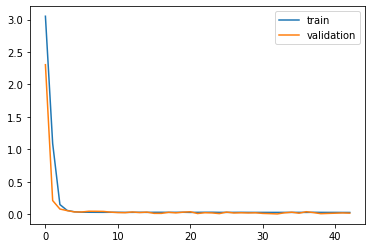


predict: [[31.51361535 23.10612675]]
real:      [[31.9 24.7]]

Train on 1396 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.8084 - mean_squared_error: 4.3177 - val_loss: 0.9026 - val_mean_squared_error: 1.0964
Epoch 2/1000
 - 1s - loss: 0.4197 - mean_squared_error: 0.3695 - val_loss: 0.1112 - val_mean_squared_error: 0.0200
Epoch 3/1000
 - 1s - loss: 0.0844 - mean_squared_error: 0.0135 - val_loss: 0.0293 - val_mean_squared_error: 9.9807e-04
Epoch 4/1000
 - 1s - loss: 0.0355 - mean_squared_error: 0.0022 - val_loss: 0.0375 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.0313 - mean_squared_error: 0.0017 - val_loss: 0.0448 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0404 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0320 - mean_squared_error: 0.0018 - val_loss: 0.0548 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 1s - loss: 0.0300 - mean_squared_error: 0.0016 - val_loss: 0.0458 

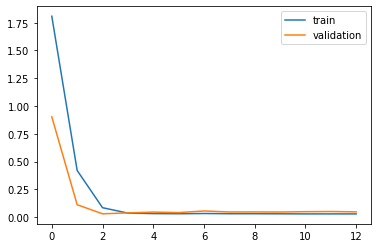


predict: [[30.60034112 24.42854869]]
real:      [[31.8 23.7]]

Train on 1395 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.4502 - mean_squared_error: 6.5100 - val_loss: 1.2479 - val_mean_squared_error: 1.6217
Epoch 2/1000
 - 1s - loss: 0.4710 - mean_squared_error: 0.3779 - val_loss: 0.1973 - val_mean_squared_error: 0.0409
Epoch 3/1000
 - 1s - loss: 0.0845 - mean_squared_error: 0.0106 - val_loss: 0.0735 - val_mean_squared_error: 0.0082
Epoch 4/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0031 - val_loss: 0.0288 - val_mean_squared_error: 8.8316e-04
Epoch 5/1000
 - 1s - loss: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0299 - val_mean_squared_error: 9.0635e-04
Epoch 6/1000
 - 1s - loss: 0.0325 - mean_squared_error: 0.0018 - val_loss: 0.0263 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0311 - mean_squared_error: 0.0017 - val_loss: 0.0223 - val_mean_squared_error: 7.0415e-04
Epoch 8/1000
 - 1s - loss: 0.0301 - mean_squared_error: 0.0016 - val_loss:

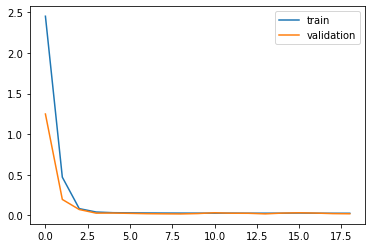


predict: [[31.5547106  24.19547823]]
real:      [[31.2 23.6]]

Train on 1394 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.3269 - mean_squared_error: 5.7305 - val_loss: 1.1971 - val_mean_squared_error: 1.4340
Epoch 2/1000
 - 1s - loss: 0.4372 - mean_squared_error: 0.3043 - val_loss: 0.0357 - val_mean_squared_error: 0.0013
Epoch 3/1000
 - 1s - loss: 0.0762 - mean_squared_error: 0.0087 - val_loss: 0.0120 - val_mean_squared_error: 1.4714e-04
Epoch 4/1000
 - 1s - loss: 0.0381 - mean_squared_error: 0.0024 - val_loss: 0.0415 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0331 - mean_squared_error: 0.0019 - val_loss: 0.0389 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 1s - loss: 0.0322 - mean_squared_error: 0.0018 - val_loss: 0.0314 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0315 - mean_squared_error: 0.0018 - val_loss: 0.0483 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0478 

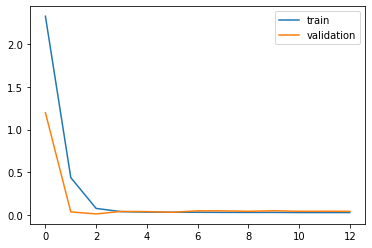


predict: [[30.2180486  22.85200604]]
real:      [[31.  24.9]]

Train on 1393 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.0270 - mean_squared_error: 4.8378 - val_loss: 0.4506 - val_mean_squared_error: 0.3679
Epoch 2/1000
 - 1s - loss: 0.3207 - mean_squared_error: 0.1693 - val_loss: 0.0921 - val_mean_squared_error: 0.0086
Epoch 3/1000
 - 1s - loss: 0.0723 - mean_squared_error: 0.0077 - val_loss: 0.0730 - val_mean_squared_error: 0.0056
Epoch 4/1000
 - 1s - loss: 0.0371 - mean_squared_error: 0.0023 - val_loss: 0.0538 - val_mean_squared_error: 0.0029
Epoch 5/1000
 - 1s - loss: 0.0303 - mean_squared_error: 0.0016 - val_loss: 0.0543 - val_mean_squared_error: 0.0030
Epoch 6/1000
 - 1s - loss: 0.0282 - mean_squared_error: 0.0014 - val_loss: 0.0558 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 1s - loss: 0.0280 - mean_squared_error: 0.0014 - val_loss: 0.0527 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.0275 - mean_squared_error: 0.0014 - val_loss: 0.0539 - va

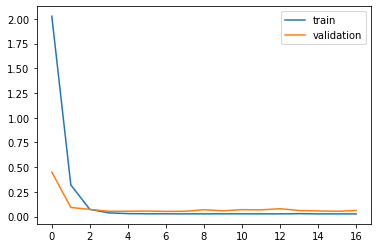


predict: [[32.10505543 24.70860331]]
real:      [[31.  23.5]]

Train on 1392 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.5502 - mean_squared_error: 6.8772 - val_loss: 1.6245 - val_mean_squared_error: 2.7465
Epoch 2/1000
 - 1s - loss: 0.8275 - mean_squared_error: 1.0023 - val_loss: 0.2240 - val_mean_squared_error: 0.0502
Epoch 3/1000
 - 1s - loss: 0.1238 - mean_squared_error: 0.0219 - val_loss: 0.0632 - val_mean_squared_error: 0.0054
Epoch 4/1000
 - 1s - loss: 0.0470 - mean_squared_error: 0.0035 - val_loss: 0.0818 - val_mean_squared_error: 0.0078
Epoch 5/1000
 - 1s - loss: 0.0331 - mean_squared_error: 0.0019 - val_loss: 0.0882 - val_mean_squared_error: 0.0087
Epoch 6/1000
 - 1s - loss: 0.0300 - mean_squared_error: 0.0016 - val_loss: 0.0988 - val_mean_squared_error: 0.0113
Epoch 7/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.1063 - val_mean_squared_error: 0.0129
Epoch 8/1000
 - 1s - loss: 0.0294 - mean_squared_error: 0.0016 - val_loss: 0.1112 - va

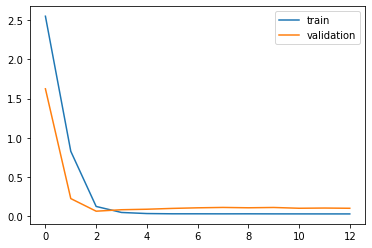


predict: [[26.54781478 26.40884795]]
real:      [[30.6 23.1]]

Train on 1391 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.9273 - mean_squared_error: 4.3611 - val_loss: 0.5481 - val_mean_squared_error: 0.4339
Epoch 2/1000
 - 1s - loss: 0.2322 - mean_squared_error: 0.0884 - val_loss: 0.1572 - val_mean_squared_error: 0.0280
Epoch 3/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0060 - val_loss: 0.0169 - val_mean_squared_error: 2.9445e-04
Epoch 4/1000
 - 1s - loss: 0.0338 - mean_squared_error: 0.0019 - val_loss: 0.0060 - val_mean_squared_error: 3.6732e-05
Epoch 5/1000
 - 1s - loss: 0.0309 - mean_squared_error: 0.0017 - val_loss: 0.0090 - val_mean_squared_error: 1.2232e-04
Epoch 6/1000
 - 1s - loss: 0.0295 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 7.7503e-06
Epoch 7/1000
 - 1s - loss: 0.0289 - mean_squared_error: 0.0015 - val_loss: 0.0038 - val_mean_squared_error: 1.6561e-05
Epoch 8/1000
 - 1s - loss: 0.0291 - mean_squared_error: 0.0015 - v

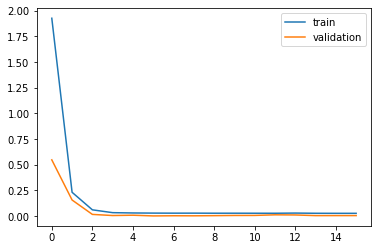


predict: [[31.20578305 24.18595282]]
real:      [[27.7 23.1]]

Train on 1390 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 3.3215 - mean_squared_error: 11.4995 - val_loss: 2.9706 - val_mean_squared_error: 10.0756
Epoch 2/1000
 - 1s - loss: 2.5504 - mean_squared_error: 9.5708 - val_loss: 2.1646 - val_mean_squared_error: 9.1244
Epoch 3/1000
 - 1s - loss: 2.0087 - mean_squared_error: 7.7057 - val_loss: 1.8542 - val_mean_squared_error: 6.3001
Epoch 4/1000
 - 1s - loss: 1.6158 - mean_squared_error: 5.0896 - val_loss: 1.3865 - val_mean_squared_error: 3.7177
Epoch 5/1000
 - 1s - loss: 1.1376 - mean_squared_error: 2.5510 - val_loss: 0.8293 - val_mean_squared_error: 1.2952
Epoch 6/1000
 - 1s - loss: 0.4324 - mean_squared_error: 0.4411 - val_loss: 0.0366 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0801 - mean_squared_error: 0.0113 - val_loss: 0.0333 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 1s - loss: 0.0349 - mean_squared_error: 0.0020 - val_loss: 0.0268 - 

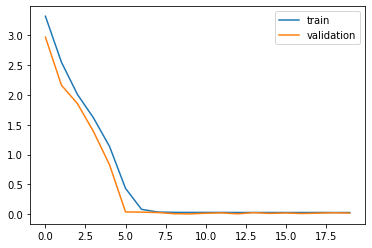


predict: [[31.79619742 24.51536196]]
real:      [[32.  25.3]]

Train on 1389 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.4632 - mean_squared_error: 2.7896 - val_loss: 0.4487 - val_mean_squared_error: 0.3514
Epoch 2/1000
 - 1s - loss: 0.1626 - mean_squared_error: 0.0589 - val_loss: 0.0404 - val_mean_squared_error: 0.0016
Epoch 3/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0049 - val_loss: 0.0239 - val_mean_squared_error: 9.1203e-04
Epoch 4/1000
 - 1s - loss: 0.0365 - mean_squared_error: 0.0022 - val_loss: 0.0096 - val_mean_squared_error: 1.5256e-04
Epoch 5/1000
 - 1s - loss: 0.0336 - mean_squared_error: 0.0019 - val_loss: 0.0195 - val_mean_squared_error: 3.8409e-04
Epoch 6/1000
 - 1s - loss: 0.0319 - mean_squared_error: 0.0018 - val_loss: 0.0260 - val_mean_squared_error: 7.8452e-04
Epoch 7/1000
 - 1s - loss: 0.0312 - mean_squared_error: 0.0017 - val_loss: 0.0210 - val_mean_squared_error: 4.6808e-04
Epoch 8/1000
 - 1s - loss: 0.0307 - mean_squared_error: 0.0016 - v

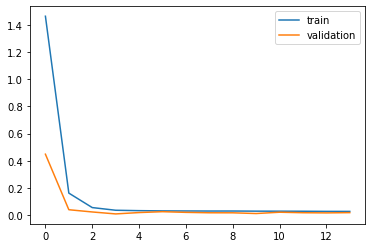


predict: [[32.02087479 23.77146729]]
real:      [[32.2 25.2]]

Train on 1388 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.9094 - mean_squared_error: 4.0664 - val_loss: 0.6781 - val_mean_squared_error: 0.5481
Epoch 2/1000
 - 1s - loss: 0.2475 - mean_squared_error: 0.1002 - val_loss: 0.1613 - val_mean_squared_error: 0.0263
Epoch 3/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0060 - val_loss: 0.0132 - val_mean_squared_error: 1.9975e-04
Epoch 4/1000
 - 1s - loss: 0.0366 - mean_squared_error: 0.0022 - val_loss: 0.0074 - val_mean_squared_error: 5.6116e-05
Epoch 5/1000
 - 1s - loss: 0.0314 - mean_squared_error: 0.0017 - val_loss: 0.0095 - val_mean_squared_error: 1.3051e-04
Epoch 6/1000
 - 1s - loss: 0.0304 - mean_squared_error: 0.0016 - val_loss: 0.0076 - val_mean_squared_error: 7.0146e-05
Epoch 7/1000
 - 1s - loss: 0.0297 - mean_squared_error: 0.0016 - val_loss: 0.0062 - val_mean_squared_error: 5.6225e-05
Epoch 8/1000
 - 1s - loss: 0.0295 - mean_squared_error: 0.0015 - v

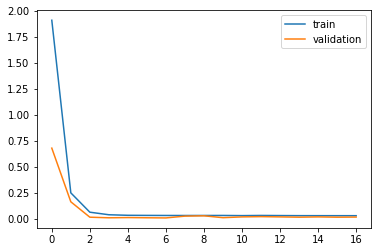


predict: [[31.66326709 24.25422969]]
real:      [[32.9 24.5]]

Train on 1387 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.9691 - mean_squared_error: 9.4547 - val_loss: 2.5567 - val_mean_squared_error: 7.9041
Epoch 2/1000
 - 1s - loss: 2.1052 - mean_squared_error: 6.8953 - val_loss: 1.7352 - val_mean_squared_error: 5.7142
Epoch 3/1000
 - 1s - loss: 1.4832 - mean_squared_error: 4.2745 - val_loss: 1.0543 - val_mean_squared_error: 2.2171
Epoch 4/1000
 - 1s - loss: 0.5282 - mean_squared_error: 0.7411 - val_loss: 0.2008 - val_mean_squared_error: 0.0592
Epoch 5/1000
 - 1s - loss: 0.0917 - mean_squared_error: 0.0178 - val_loss: 0.0589 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 1s - loss: 0.0386 - mean_squared_error: 0.0024 - val_loss: 0.0189 - val_mean_squared_error: 3.8338e-04
Epoch 7/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0246 - val_mean_squared_error: 8.2925e-04
Epoch 8/1000
 - 1s - loss: 0.0302 - mean_squared_error: 0.0016 - val_loss: 0.0

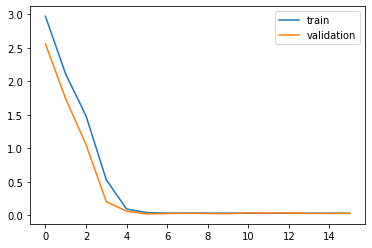


predict: [[31.3100252  24.71806886]]
real:      [[31.4 24.7]]

Train on 1386 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.7293 - mean_squared_error: 7.8076 - val_loss: 2.0705 - val_mean_squared_error: 4.7556
Epoch 2/1000
 - 1s - loss: 1.4909 - mean_squared_error: 3.1192 - val_loss: 0.7829 - val_mean_squared_error: 1.1492
Epoch 3/1000
 - 1s - loss: 0.3749 - mean_squared_error: 0.3596 - val_loss: 0.1911 - val_mean_squared_error: 0.0547
Epoch 4/1000
 - 1s - loss: 0.0750 - mean_squared_error: 0.0102 - val_loss: 0.0504 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 1s - loss: 0.0348 - mean_squared_error: 0.0021 - val_loss: 0.0489 - val_mean_squared_error: 0.0039
Epoch 6/1000
 - 1s - loss: 0.0305 - mean_squared_error: 0.0016 - val_loss: 0.0611 - val_mean_squared_error: 0.0053
Epoch 7/1000
 - 1s - loss: 0.0297 - mean_squared_error: 0.0016 - val_loss: 0.0543 - val_mean_squared_error: 0.0053
Epoch 8/1000
 - 1s - loss: 0.0295 - mean_squared_error: 0.0016 - val_loss: 0.0576 - va

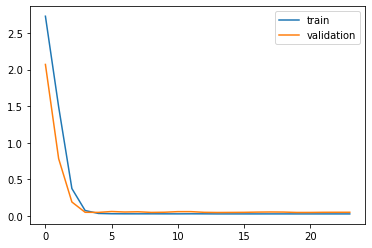


predict: [[31.88067545 23.62253688]]
real:      [[31.5 24.1]]

Train on 1385 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.5634 - mean_squared_error: 7.3149 - val_loss: 1.7410 - val_mean_squared_error: 4.3179
Epoch 2/1000
 - 1s - loss: 1.2191 - mean_squared_error: 2.7462 - val_loss: 0.7132 - val_mean_squared_error: 1.0061
Epoch 3/1000
 - 1s - loss: 0.3152 - mean_squared_error: 0.2626 - val_loss: 0.1113 - val_mean_squared_error: 0.0225
Epoch 4/1000
 - 1s - loss: 0.0704 - mean_squared_error: 0.0090 - val_loss: 0.0115 - val_mean_squared_error: 2.2713e-04
Epoch 5/1000
 - 1s - loss: 0.0368 - mean_squared_error: 0.0022 - val_loss: 0.0156 - val_mean_squared_error: 3.0665e-04
Epoch 6/1000
 - 1s - loss: 0.0307 - mean_squared_error: 0.0016 - val_loss: 0.0047 - val_mean_squared_error: 2.2838e-05
Epoch 7/1000
 - 1s - loss: 0.0291 - mean_squared_error: 0.0015 - val_loss: 0.0070 - val_mean_squared_error: 4.9689e-05
Epoch 8/1000
 - 1s - loss: 0.0292 - mean_squared_error: 0.0015 - val_l

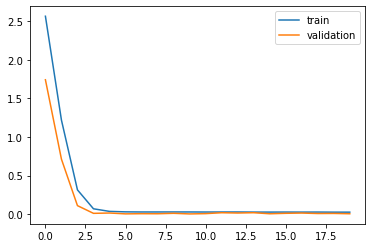


predict: [[31.52927011 24.28956801]]
real:      [[28.9 25.2]]

Train on 1384 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.5286 - mean_squared_error: 6.8079 - val_loss: 1.4835 - val_mean_squared_error: 2.5164
Epoch 2/1000
 - 1s - loss: 0.6115 - mean_squared_error: 0.6594 - val_loss: 0.0803 - val_mean_squared_error: 0.0066
Epoch 3/1000
 - 1s - loss: 0.1111 - mean_squared_error: 0.0216 - val_loss: 0.1031 - val_mean_squared_error: 0.0126
Epoch 4/1000
 - 1s - loss: 0.0524 - mean_squared_error: 0.0046 - val_loss: 0.0109 - val_mean_squared_error: 1.9430e-04
Epoch 5/1000
 - 1s - loss: 0.0363 - mean_squared_error: 0.0023 - val_loss: 0.0086 - val_mean_squared_error: 7.3610e-05
Epoch 6/1000
 - 1s - loss: 0.0339 - mean_squared_error: 0.0020 - val_loss: 0.0236 - val_mean_squared_error: 6.5123e-04
Epoch 7/1000
 - 1s - loss: 0.0318 - mean_squared_error: 0.0018 - val_loss: 0.0089 - val_mean_squared_error: 1.5574e-04
Epoch 8/1000
 - 1s - loss: 0.0309 - mean_squared_error: 0.0017 - val_l

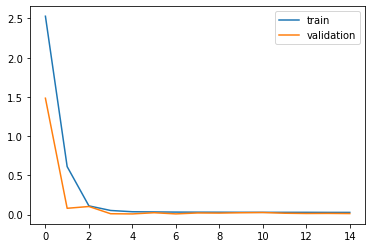


predict: [[33.21285178 25.20983544]]
real:      [[31.7 24.7]]

Train on 1383 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.8302 - mean_squared_error: 10.0230 - val_loss: 2.3633 - val_mean_squared_error: 8.8393
Epoch 2/1000
 - 1s - loss: 1.9250 - mean_squared_error: 6.9575 - val_loss: 1.3631 - val_mean_squared_error: 3.5686
Epoch 3/1000
 - 1s - loss: 0.7828 - mean_squared_error: 1.4750 - val_loss: 0.1241 - val_mean_squared_error: 0.0196
Epoch 4/1000
 - 1s - loss: 0.1201 - mean_squared_error: 0.0239 - val_loss: 0.0403 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0391 - mean_squared_error: 0.0025 - val_loss: 0.0400 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0316 - mean_squared_error: 0.0017 - val_loss: 0.0270 - val_mean_squared_error: 9.5056e-04
Epoch 7/1000
 - 1s - loss: 0.0300 - mean_squared_error: 0.0016 - val_loss: 0.0322 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0296 - mean_squared_error: 0.0016 - val_loss: 0.0251

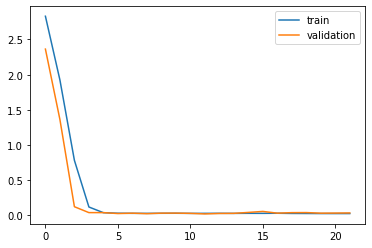


predict: [[31.98356311 24.6760645 ]]
real:      [[31.9 24.4]]

Train on 1382 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.7019 - mean_squared_error: 7.7669 - val_loss: 1.8808 - val_mean_squared_error: 4.1932
Epoch 2/1000
 - 1s - loss: 1.2316 - mean_squared_error: 2.4821 - val_loss: 0.7886 - val_mean_squared_error: 1.0151
Epoch 3/1000
 - 1s - loss: 0.3504 - mean_squared_error: 0.3074 - val_loss: 0.1373 - val_mean_squared_error: 0.0267
Epoch 4/1000
 - 1s - loss: 0.0774 - mean_squared_error: 0.0113 - val_loss: 0.0499 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 1s - loss: 0.0380 - mean_squared_error: 0.0023 - val_loss: 0.0244 - val_mean_squared_error: 7.9876e-04
Epoch 6/1000
 - 1s - loss: 0.0316 - mean_squared_error: 0.0017 - val_loss: 0.0301 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0305 - mean_squared_error: 0.0016 - val_loss: 0.0259 - val_mean_squared_error: 0.0010
Epoch 8/1000
 - 1s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0332 

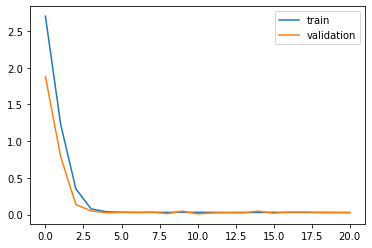


predict: [[32.04617187 24.75215897]]
real:      [[30.6 24.5]]

Train on 1381 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 3.3815 - mean_squared_error: 11.4713 - val_loss: 3.3248 - val_mean_squared_error: 11.0682
Epoch 2/1000
 - 1s - loss: 3.2030 - mean_squared_error: 10.4017 - val_loss: 3.0782 - val_mean_squared_error: 10.0153
Epoch 3/1000
 - 1s - loss: 2.1808 - mean_squared_error: 5.8782 - val_loss: 1.0920 - val_mean_squared_error: 2.2677
Epoch 4/1000
 - 1s - loss: 0.4741 - mean_squared_error: 0.5710 - val_loss: 0.1367 - val_mean_squared_error: 0.0277
Epoch 5/1000
 - 1s - loss: 0.0892 - mean_squared_error: 0.0150 - val_loss: 0.0051 - val_mean_squared_error: 3.3216e-05
Epoch 6/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0031 - val_loss: 0.0517 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 1s - loss: 0.0337 - mean_squared_error: 0.0020 - val_loss: 0.0300 - val_mean_squared_error: 9.1067e-04
Epoch 8/1000
 - 1s - loss: 0.0304 - mean_squared_error: 0.0016 - val_loss:

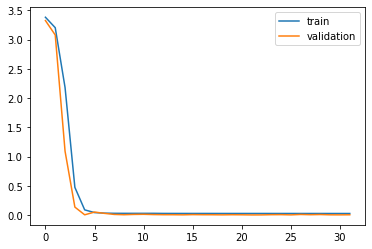


predict: [[31.9293861  24.11335155]]
real:      [[32.8 26.1]]

Train on 1380 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.3001 - mean_squared_error: 5.7699 - val_loss: 0.7665 - val_mean_squared_error: 0.5887
Epoch 2/1000
 - 1s - loss: 0.3322 - mean_squared_error: 0.1770 - val_loss: 0.0445 - val_mean_squared_error: 0.0023
Epoch 3/1000
 - 1s - loss: 0.0890 - mean_squared_error: 0.0117 - val_loss: 0.0094 - val_mean_squared_error: 1.3459e-04
Epoch 4/1000
 - 1s - loss: 0.0412 - mean_squared_error: 0.0028 - val_loss: 0.0127 - val_mean_squared_error: 2.9603e-04
Epoch 5/1000
 - 1s - loss: 0.0316 - mean_squared_error: 0.0017 - val_loss: 0.0118 - val_mean_squared_error: 1.7608e-04
Epoch 6/1000
 - 1s - loss: 0.0297 - mean_squared_error: 0.0016 - val_loss: 0.0086 - val_mean_squared_error: 7.5257e-05
Epoch 7/1000
 - 1s - loss: 0.0292 - mean_squared_error: 0.0015 - val_loss: 0.0095 - val_mean_squared_error: 1.5848e-04
Epoch 8/1000
 - 1s - loss: 0.0289 - mean_squared_error: 0.0015 - v

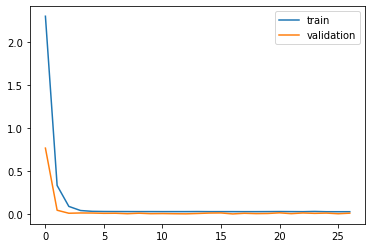


predict: [[31.65919446 24.39167218]]
real:      [[32.6 25.1]]

Train on 1379 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.5326 - mean_squared_error: 7.9596 - val_loss: 1.5524 - val_mean_squared_error: 4.2276
Epoch 2/1000
 - 1s - loss: 1.1890 - mean_squared_error: 2.5435 - val_loss: 0.7979 - val_mean_squared_error: 1.2444
Epoch 3/1000
 - 1s - loss: 0.3691 - mean_squared_error: 0.3432 - val_loss: 0.0798 - val_mean_squared_error: 0.0101
Epoch 4/1000
 - 1s - loss: 0.0724 - mean_squared_error: 0.0096 - val_loss: 0.0101 - val_mean_squared_error: 1.7726e-04
Epoch 5/1000
 - 1s - loss: 0.0358 - mean_squared_error: 0.0022 - val_loss: 0.0276 - val_mean_squared_error: 7.7199e-04
Epoch 6/1000
 - 1s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0285 - val_mean_squared_error: 9.3166e-04
Epoch 7/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0266 - val_mean_squared_error: 7.5242e-04
Epoch 8/1000
 - 1s - loss: 0.0290 - mean_squared_error: 0.0015 - val_l

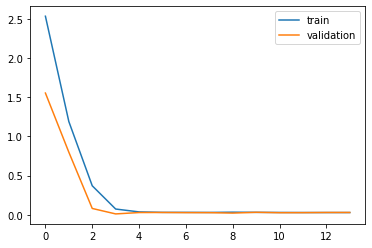


predict: [[33.36391714 24.80331735]]
real:      [[31.8 24.8]]

Train on 1378 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 3.0907 - mean_squared_error: 9.6316 - val_loss: 2.6949 - val_mean_squared_error: 7.3691
Epoch 2/1000
 - 1s - loss: 2.1557 - mean_squared_error: 5.1507 - val_loss: 1.3520 - val_mean_squared_error: 2.8899
Epoch 3/1000
 - 1s - loss: 0.8225 - mean_squared_error: 1.3032 - val_loss: 0.3033 - val_mean_squared_error: 0.1617
Epoch 4/1000
 - 1s - loss: 0.1219 - mean_squared_error: 0.0283 - val_loss: 0.0478 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 1s - loss: 0.0446 - mean_squared_error: 0.0035 - val_loss: 0.0535 - val_mean_squared_error: 0.0032
Epoch 6/1000
 - 1s - loss: 0.0345 - mean_squared_error: 0.0020 - val_loss: 0.0290 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0307 - mean_squared_error: 0.0017 - val_loss: 0.0200 - val_mean_squared_error: 4.2954e-04
Epoch 8/1000
 - 1s - loss: 0.0303 - mean_squared_error: 0.0016 - val_loss: 0.0362 

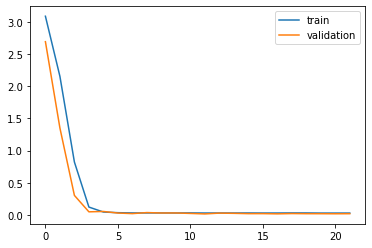


predict: [[31.42172324 24.485729  ]]
real:      [[33.2 24.2]]

Train on 1377 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.4059 - mean_squared_error: 6.0679 - val_loss: 1.3732 - val_mean_squared_error: 2.0160
Epoch 2/1000
 - 1s - loss: 0.6494 - mean_squared_error: 0.6842 - val_loss: 0.0684 - val_mean_squared_error: 0.0050
Epoch 3/1000
 - 1s - loss: 0.1117 - mean_squared_error: 0.0213 - val_loss: 0.0854 - val_mean_squared_error: 0.0090
Epoch 4/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0031 - val_loss: 0.0230 - val_mean_squared_error: 6.4670e-04
Epoch 5/1000
 - 1s - loss: 0.0321 - mean_squared_error: 0.0019 - val_loss: 0.0331 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.0305 - mean_squared_error: 0.0017 - val_loss: 0.0099 - val_mean_squared_error: 1.0280e-04
Epoch 7/1000
 - 1s - loss: 0.0294 - mean_squared_error: 0.0016 - val_loss: 0.0091 - val_mean_squared_error: 1.2465e-04
Epoch 8/1000
 - 1s - loss: 0.0287 - mean_squared_error: 0.0015 - val_loss:

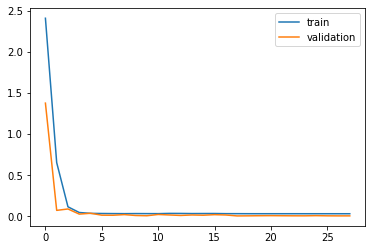


predict: [[31.68694976 23.98348455]]
real:      [[32.4 25.3]]

Train on 1376 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.7026 - mean_squared_error: 7.9099 - val_loss: 1.7859 - val_mean_squared_error: 3.4033
Epoch 2/1000
 - 1s - loss: 0.7893 - mean_squared_error: 0.9552 - val_loss: 0.2002 - val_mean_squared_error: 0.0538
Epoch 3/1000
 - 1s - loss: 0.1261 - mean_squared_error: 0.0244 - val_loss: 0.0249 - val_mean_squared_error: 6.3519e-04
Epoch 4/1000
 - 1s - loss: 0.0432 - mean_squared_error: 0.0030 - val_loss: 0.0391 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 1s - loss: 0.0317 - mean_squared_error: 0.0017 - val_loss: 0.0149 - val_mean_squared_error: 2.3093e-04
Epoch 6/1000
 - 1s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0131 - val_mean_squared_error: 1.7909e-04
Epoch 7/1000
 - 1s - loss: 0.0297 - mean_squared_error: 0.0016 - val_loss: 0.0204 - val_mean_squared_error: 4.2793e-04
Epoch 8/1000
 - 1s - loss: 0.0294 - mean_squared_error: 0.0015 - val_l

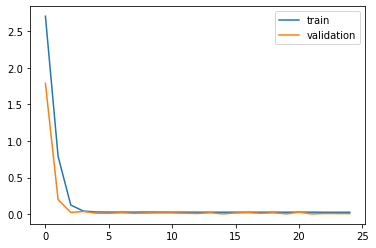


predict: [[31.73340669 24.47783715]]
real:      [[32.2 25.3]]

Train on 1375 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.4805 - mean_squared_error: 6.4600 - val_loss: 1.5485 - val_mean_squared_error: 2.6105
Epoch 2/1000
 - 1s - loss: 0.7668 - mean_squared_error: 0.9174 - val_loss: 0.0687 - val_mean_squared_error: 0.0049
Epoch 3/1000
 - 1s - loss: 0.0714 - mean_squared_error: 0.0079 - val_loss: 0.0113 - val_mean_squared_error: 1.3307e-04
Epoch 4/1000
 - 1s - loss: 0.0349 - mean_squared_error: 0.0021 - val_loss: 0.0295 - val_mean_squared_error: 9.0355e-04
Epoch 5/1000
 - 1s - loss: 0.0312 - mean_squared_error: 0.0017 - val_loss: 0.0178 - val_mean_squared_error: 3.1776e-04
Epoch 6/1000
 - 1s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0156 - val_mean_squared_error: 3.2454e-04
Epoch 7/1000
 - 1s - loss: 0.0287 - mean_squared_error: 0.0014 - val_loss: 0.0240 - val_mean_squared_error: 5.8306e-04
Epoch 8/1000
 - 1s - loss: 0.0284 - mean_squared_error: 0.0014 - v

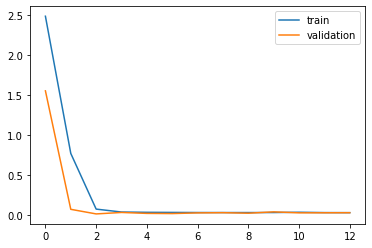


predict: [[30.29455165 24.22858089]]
real:      [[32.4 25.3]]

Train on 1374 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.9290 - mean_squared_error: 8.9403 - val_loss: 1.9603 - val_mean_squared_error: 3.9925
Epoch 2/1000
 - 1s - loss: 1.2166 - mean_squared_error: 2.1503 - val_loss: 0.5925 - val_mean_squared_error: 0.5406
Epoch 3/1000
 - 1s - loss: 0.2443 - mean_squared_error: 0.1274 - val_loss: 0.0764 - val_mean_squared_error: 0.0095
Epoch 4/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0058 - val_loss: 0.0130 - val_mean_squared_error: 3.1496e-04
Epoch 5/1000
 - 1s - loss: 0.0394 - mean_squared_error: 0.0026 - val_loss: 0.0389 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0333 - mean_squared_error: 0.0019 - val_loss: 0.0177 - val_mean_squared_error: 3.8554e-04
Epoch 7/1000
 - 1s - loss: 0.0320 - mean_squared_error: 0.0018 - val_loss: 0.0159 - val_mean_squared_error: 4.5476e-04
Epoch 8/1000
 - 1s - loss: 0.0309 - mean_squared_error: 0.0017 - val_loss:

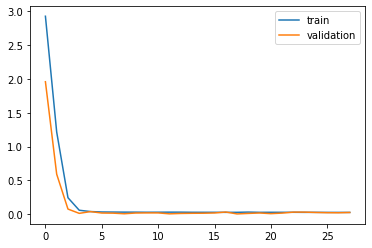


predict: [[32.84237562 23.97833864]]
real:      [[31.2 25.3]]

Train on 1373 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 1.9517 - mean_squared_error: 4.6462 - val_loss: 0.3389 - val_mean_squared_error: 0.2000
Epoch 2/1000
 - 1s - loss: 0.2067 - mean_squared_error: 0.0603 - val_loss: 0.1107 - val_mean_squared_error: 0.0128
Epoch 3/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0056 - val_loss: 0.0137 - val_mean_squared_error: 2.0867e-04
Epoch 4/1000
 - 1s - loss: 0.0413 - mean_squared_error: 0.0028 - val_loss: 0.0044 - val_mean_squared_error: 2.3062e-05
Epoch 5/1000
 - 1s - loss: 0.0349 - mean_squared_error: 0.0021 - val_loss: 0.0101 - val_mean_squared_error: 1.0242e-04
Epoch 6/1000
 - 1s - loss: 0.0346 - mean_squared_error: 0.0020 - val_loss: 0.0234 - val_mean_squared_error: 5.6762e-04
Epoch 7/1000
 - 1s - loss: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0123 - val_mean_squared_error: 2.5935e-04
Epoch 8/1000
 - 1s - loss: 0.0349 - mean_squared_error: 0.0020 - v

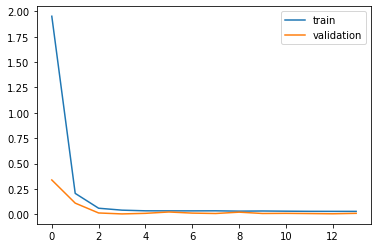


predict: [[31.80447902 24.84607832]]
real:      [[33.1 25.2]]

Train on 1372 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 3.2100 - mean_squared_error: 10.3291 - val_loss: 2.9716 - val_mean_squared_error: 8.8383
Epoch 2/1000
 - 1s - loss: 2.5848 - mean_squared_error: 6.8095 - val_loss: 1.9941 - val_mean_squared_error: 4.2894
Epoch 3/1000
 - 1s - loss: 1.3144 - mean_squared_error: 2.6766 - val_loss: 0.6561 - val_mean_squared_error: 0.6490
Epoch 4/1000
 - 1s - loss: 0.2592 - mean_squared_error: 0.1601 - val_loss: 0.0886 - val_mean_squared_error: 0.0129
Epoch 5/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0058 - val_loss: 0.0052 - val_mean_squared_error: 3.7663e-05
Epoch 6/1000
 - 1s - loss: 0.0320 - mean_squared_error: 0.0018 - val_loss: 0.0237 - val_mean_squared_error: 6.2262e-04
Epoch 7/1000
 - 1s - loss: 0.0296 - mean_squared_error: 0.0015 - val_loss: 0.0260 - val_mean_squared_error: 9.8216e-04
Epoch 8/1000
 - 1s - loss: 0.0314 - mean_squared_error: 0.0017 - val_loss

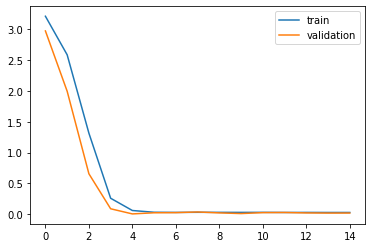


predict: [[32.47089133 24.27903667]]
real:      [[32.7 25.4]]

Train on 1371 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 1.3384 - mean_squared_error: 2.5021 - val_loss: 0.2056 - val_mean_squared_error: 0.0690
Epoch 2/1000
 - 1s - loss: 0.1660 - mean_squared_error: 0.0418 - val_loss: 0.0440 - val_mean_squared_error: 0.0024
Epoch 3/1000
 - 1s - loss: 0.0503 - mean_squared_error: 0.0039 - val_loss: 0.0133 - val_mean_squared_error: 2.4206e-04
Epoch 4/1000
 - 1s - loss: 0.0353 - mean_squared_error: 0.0021 - val_loss: 0.0110 - val_mean_squared_error: 1.5518e-04
Epoch 5/1000
 - 1s - loss: 0.0314 - mean_squared_error: 0.0017 - val_loss: 0.0167 - val_mean_squared_error: 4.2702e-04
Epoch 6/1000
 - 1s - loss: 0.0315 - mean_squared_error: 0.0017 - val_loss: 0.0103 - val_mean_squared_error: 1.0838e-04
Epoch 7/1000
 - 1s - loss: 0.0295 - mean_squared_error: 0.0015 - val_loss: 0.0252 - val_mean_squared_error: 8.0121e-04
Epoch 8/1000
 - 1s - loss: 0.0306 - mean_squared_error: 0.0016 - v

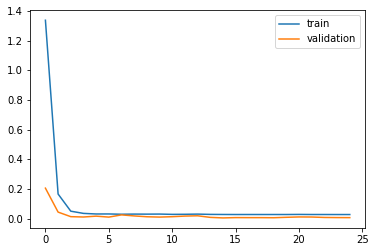


predict: [[31.73213462 24.49199441]]
real:      [[32.2 25.4]]

Train on 1370 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.2312 - mean_squared_error: 5.3320 - val_loss: 1.0766 - val_mean_squared_error: 1.3779
Epoch 2/1000
 - 1s - loss: 0.5851 - mean_squared_error: 0.4959 - val_loss: 0.1241 - val_mean_squared_error: 0.0211
Epoch 3/1000
 - 1s - loss: 0.0902 - mean_squared_error: 0.0131 - val_loss: 0.0387 - val_mean_squared_error: 0.0018
Epoch 4/1000
 - 1s - loss: 0.0440 - mean_squared_error: 0.0032 - val_loss: 0.0122 - val_mean_squared_error: 2.2427e-04
Epoch 5/1000
 - 1s - loss: 0.0364 - mean_squared_error: 0.0023 - val_loss: 0.0169 - val_mean_squared_error: 4.9604e-04
Epoch 6/1000
 - 1s - loss: 0.0348 - mean_squared_error: 0.0021 - val_loss: 0.0189 - val_mean_squared_error: 3.6345e-04
Epoch 7/1000
 - 1s - loss: 0.0355 - mean_squared_error: 0.0021 - val_loss: 0.0327 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 1s - loss: 0.0330 - mean_squared_error: 0.0019 - val_loss:

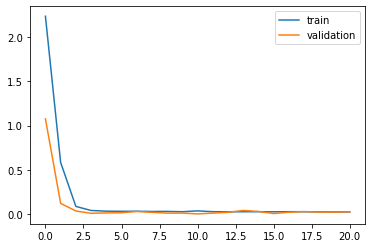


predict: [[30.90161061 24.45363613]]
real:      [[31.9 24.8]]

Train and validation time: 15.584292066097259

Maximum metrics
Test RMSE -------------------------- 1.461
Test VARIANCE ---------------------- -0.6428
Test MAX-ERROR --------------------- 4.052
Test MEAN-ABSOLUTE-ERROR ----------- 1.107
Test MEDIAN-ABSOLUTE-ERROR --------- 0.9057

Errors
2018-12-31 = 0.8045206215295089
2018-12-30 = 0.19925017182932336
2018-12-29 = 0.3863846469660679
2018-12-28 = 1.1996588840155304
2018-12-27 = 0.35471060329247095
2018-12-26 = 0.7819513958368383
2018-12-25 = 1.1050554295525856
2018-12-24 = 4.052185224518105
2018-12-23 = 3.5057830496789677
2018-12-22 = 0.2038025819155962
2018-12-21 = 0.1791252148750715
2018-12-20 = 1.2367329137406777
2018-12-19 = 0.08997480382961243
2018-12-18 = 0.3806754467863236
2018-12-17 = 2.6292701056705283
2018-12-16 = 1.5128517795078835
2018-12-15 = 0.08356311062992106
2018-12-14 = 1.4461718717799847
2018-12-13 = 0.8706138973408102
2018-12-12 = 0.9408055378692133
2018

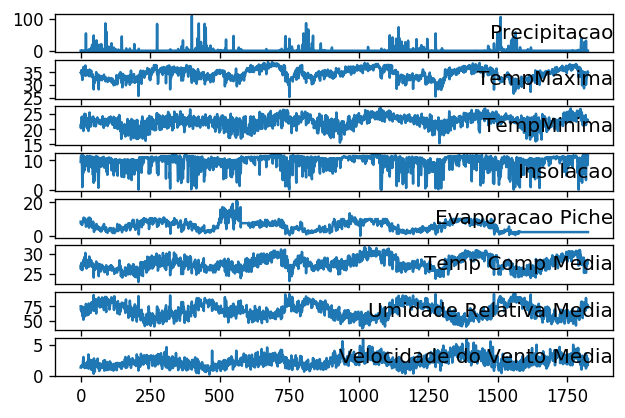

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.7995 - mean_squared_error: 8.5420 - val_loss: 2.0901 - val_mean_squared_error: 5.4721
Epoch 2/1000
 - 1s - loss: 1.3748 - mean_squared_error: 3.2253 - val_loss: 0.7641 - val_mean_squared_error: 0.9792
Epoch 3/1000
 - 1s - loss: 0.2918 - mean_squared_error: 0.2186 - val_loss: 0.0573 - val_mean_squared_error: 0.0033
Epoch 4/1000
 - 1s - loss: 0.0722 - mean_squared_error: 0.0084 - val_loss: 0.0592 - val_mean_squared_error: 0.0037
Epoch 5/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0059 - val_loss: 0.0273 - val_mean_squared_error: 7.7258e-04
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.0304 - val_mean_squared_error: 9.2910e-04
Epoch 7/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0056 - val_loss: 0.0292 - val_mean_squared_error: 8.9883e-04
Epoch 8/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0055 - val_loss: 0.0197 - val_mean_squared_error: 4.2089e-04
Epoch 9/1000
 - 1s 

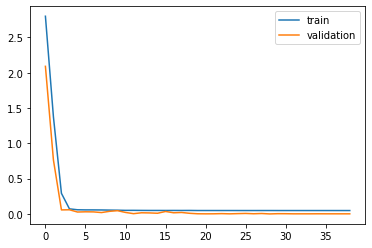


predict: [[35.5415317  22.85527046]]
real:      [[35.  22.8]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.1557 - mean_squared_error: 5.0460 - val_loss: 0.9799 - val_mean_squared_error: 1.1847
Epoch 2/1000
 - 1s - loss: 0.3302 - mean_squared_error: 0.2481 - val_loss: 0.0306 - val_mean_squared_error: 0.0012
Epoch 3/1000
 - 1s - loss: 0.0787 - mean_squared_error: 0.0101 - val_loss: 0.0422 - val_mean_squared_error: 0.0026
Epoch 4/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0060 - val_loss: 0.0267 - val_mean_squared_error: 8.6377e-04
Epoch 5/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0057 - val_loss: 0.0167 - val_mean_squared_error: 2.8072e-04
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0056 - val_loss: 0.0251 - val_mean_squared_error: 8.8272e-04
Epoch 7/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.0173 - val_mean_squared_error: 5.3075e-04
Epoch 8/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0057 - val_l

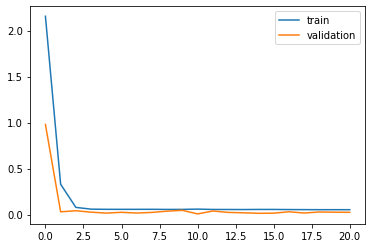


predict: [[34.265573   22.68979365]]
real:      [[35.3 23.1]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.4142 - mean_squared_error: 8.1798 - val_loss: 1.5241 - val_mean_squared_error: 3.8828
Epoch 2/1000
 - 1s - loss: 0.6878 - mean_squared_error: 1.2193 - val_loss: 0.2031 - val_mean_squared_error: 0.0737
Epoch 3/1000
 - 1s - loss: 0.1049 - mean_squared_error: 0.0196 - val_loss: 0.0618 - val_mean_squared_error: 0.0054
Epoch 4/1000
 - 1s - loss: 0.0672 - mean_squared_error: 0.0073 - val_loss: 0.0289 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.0645 - mean_squared_error: 0.0067 - val_loss: 0.0168 - val_mean_squared_error: 4.6984e-04
Epoch 6/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0063 - val_loss: 0.0252 - val_mean_squared_error: 8.4107e-04
Epoch 7/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0060 - val_loss: 0.0092 - val_mean_squared_error: 1.3149e-04
Epoch 8/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss:

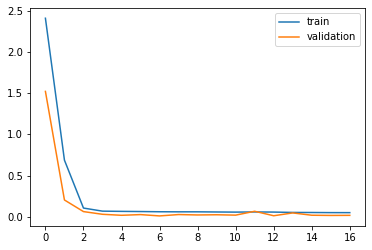


predict: [[34.81321384 22.09466109]]
real:      [[33.8 22.7]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.1105 - mean_squared_error: 5.2379 - val_loss: 0.4828 - val_mean_squared_error: 0.4560
Epoch 2/1000
 - 1s - loss: 0.2326 - mean_squared_error: 0.0985 - val_loss: 0.0712 - val_mean_squared_error: 0.0073
Epoch 3/1000
 - 1s - loss: 0.0745 - mean_squared_error: 0.0088 - val_loss: 0.0447 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0060 - val_loss: 0.0324 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0056 - val_loss: 0.0357 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0056 - val_loss: 0.0382 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0055 - val_loss: 0.0404 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 1s - loss: 0.0554 - mean_squared_error: 0.0055 - val_loss: 0.0348 - va

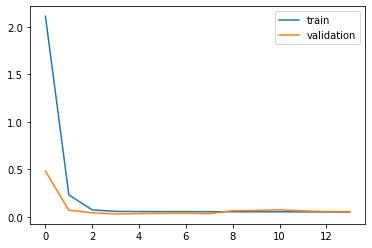


predict: [[34.9558516  22.97838102]]
real:      [[34.3 22.9]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.7180 - mean_squared_error: 3.9036 - val_loss: 0.2755 - val_mean_squared_error: 0.0781
Epoch 2/1000
 - 1s - loss: 0.1548 - mean_squared_error: 0.0361 - val_loss: 0.0396 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 1s - loss: 0.0679 - mean_squared_error: 0.0076 - val_loss: 0.0130 - val_mean_squared_error: 1.7214e-04
Epoch 4/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0063 - val_loss: 0.0268 - val_mean_squared_error: 7.3839e-04
Epoch 5/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0060 - val_loss: 0.0324 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0540 - mean_squared_error: 0.0052 - val_loss: 0.0378 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0507 - mean_squared_error: 0.0048 - val_loss: 0.0553 - val_mean_squared_error: 0.0042
Epoch 8/1000
 - 1s - loss: 0.0504 - mean_squared_error: 0.0047 - val_loss: 0.0

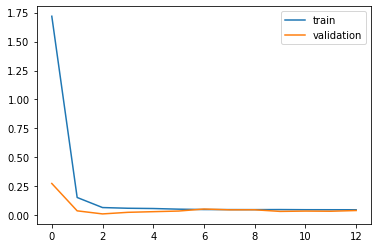


predict: [[32.82643572 22.74248103]]
real:      [[33.  22.3]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.2659 - mean_squared_error: 7.5227 - val_loss: 1.4563 - val_mean_squared_error: 3.9013
Epoch 2/1000
 - 1s - loss: 1.0395 - mean_squared_error: 2.1706 - val_loss: 0.3006 - val_mean_squared_error: 0.1746
Epoch 3/1000
 - 1s - loss: 0.1568 - mean_squared_error: 0.0475 - val_loss: 0.0283 - val_mean_squared_error: 0.0012
Epoch 4/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0072 - val_loss: 0.0611 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0062 - val_loss: 0.0550 - val_mean_squared_error: 0.0058
Epoch 6/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0058 - val_loss: 0.0600 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0054 - val_loss: 0.0488 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0055 - val_loss: 0.0649 - v

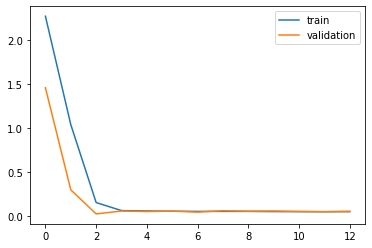


predict: [[32.05844936 21.99912301]]
real:      [[32.6 22.9]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.0824 - mean_squared_error: 5.7924 - val_loss: 1.0395 - val_mean_squared_error: 1.4991
Epoch 2/1000
 - 1s - loss: 0.4532 - mean_squared_error: 0.4289 - val_loss: 0.1838 - val_mean_squared_error: 0.0378
Epoch 3/1000
 - 1s - loss: 0.0816 - mean_squared_error: 0.0107 - val_loss: 0.0486 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0065 - val_loss: 0.0778 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0058 - val_loss: 0.0981 - val_mean_squared_error: 0.0114
Epoch 6/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0060 - val_loss: 0.1013 - val_mean_squared_error: 0.0125
Epoch 7/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0059 - val_loss: 0.1022 - val_mean_squared_error: 0.0127
Epoch 8/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0057 - val_loss: 0.1147 - va

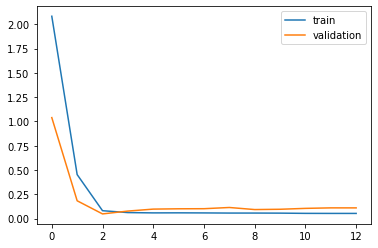


predict: [[35.45471358 23.84103089]]
real:      [[31.4 23.2]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.7653 - mean_squared_error: 8.4744 - val_loss: 2.0482 - val_mean_squared_error: 5.2788
Epoch 2/1000
 - 1s - loss: 1.3451 - mean_squared_error: 3.1255 - val_loss: 0.7236 - val_mean_squared_error: 0.8115
Epoch 3/1000
 - 1s - loss: 0.2840 - mean_squared_error: 0.2030 - val_loss: 0.1270 - val_mean_squared_error: 0.0214
Epoch 4/1000
 - 1s - loss: 0.0701 - mean_squared_error: 0.0080 - val_loss: 0.0618 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0058 - val_loss: 0.0758 - val_mean_squared_error: 0.0065
Epoch 6/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0057 - val_loss: 0.0676 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0770 - val_mean_squared_error: 0.0061
Epoch 8/1000
 - 1s - loss: 0.0549 - mean_squared_error: 0.0053 - val_loss: 0.0736 - va

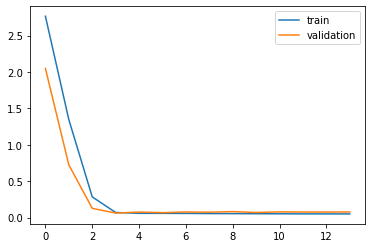


predict: [[34.23091558 22.19555613]]
real:      [[30.  21.3]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.5129 - mean_squared_error: 6.7427 - val_loss: 1.6592 - val_mean_squared_error: 2.8694
Epoch 2/1000
 - 1s - loss: 0.6688 - mean_squared_error: 0.7610 - val_loss: 0.1901 - val_mean_squared_error: 0.0481
Epoch 3/1000
 - 1s - loss: 0.0917 - mean_squared_error: 0.0140 - val_loss: 0.0485 - val_mean_squared_error: 0.0031
Epoch 4/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0291 - val_mean_squared_error: 9.4145e-04
Epoch 5/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0057 - val_loss: 0.0360 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0055 - val_loss: 0.0226 - val_mean_squared_error: 7.0703e-04
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.0283 - val_mean_squared_error: 8.0855e-04
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0055 - val_loss:

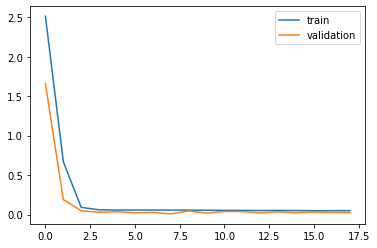


predict: [[34.58425372 23.23936079]]
real:      [[32.6 24.6]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.9564 - mean_squared_error: 8.9454 - val_loss: 2.4259 - val_mean_squared_error: 6.0998
Epoch 2/1000
 - 1s - loss: 1.6951 - mean_squared_error: 3.4827 - val_loss: 0.7992 - val_mean_squared_error: 1.2274
Epoch 3/1000
 - 1s - loss: 0.5181 - mean_squared_error: 0.4743 - val_loss: 0.0837 - val_mean_squared_error: 0.0100
Epoch 4/1000
 - 1s - loss: 0.0805 - mean_squared_error: 0.0102 - val_loss: 0.0361 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.0203 - val_mean_squared_error: 4.9337e-04
Epoch 6/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0057 - val_loss: 0.0110 - val_mean_squared_error: 1.2408e-04
Epoch 7/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0058 - val_loss: 0.0175 - val_mean_squared_error: 3.3767e-04
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss:

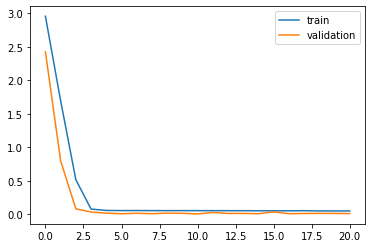


predict: [[34.64973361 22.76190499]]
real:      [[34.4 23.7]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.8670 - mean_squared_error: 4.2473 - val_loss: 0.5982 - val_mean_squared_error: 0.5076
Epoch 2/1000
 - 1s - loss: 0.3326 - mean_squared_error: 0.1754 - val_loss: 0.0783 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 1s - loss: 0.0669 - mean_squared_error: 0.0072 - val_loss: 0.0229 - val_mean_squared_error: 5.2890e-04
Epoch 4/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0062 - val_loss: 0.0252 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0059 - val_loss: 0.0213 - val_mean_squared_error: 4.7812e-04
Epoch 6/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0055 - val_loss: 0.0207 - val_mean_squared_error: 6.6810e-04
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.0338 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0055 - val_loss:

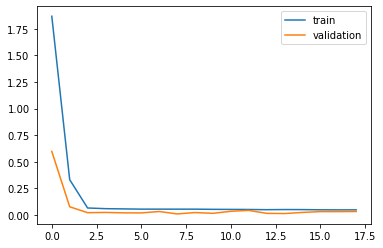


predict: [[33.93042816 22.13232662]]
real:      [[34.9 22.9]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.0372 - mean_squared_error: 4.7809 - val_loss: 0.4455 - val_mean_squared_error: 0.2800
Epoch 2/1000
 - 1s - loss: 0.2127 - mean_squared_error: 0.0760 - val_loss: 0.0478 - val_mean_squared_error: 0.0030
Epoch 3/1000
 - 1s - loss: 0.0683 - mean_squared_error: 0.0077 - val_loss: 0.0203 - val_mean_squared_error: 4.2176e-04
Epoch 4/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0056 - val_loss: 0.0103 - val_mean_squared_error: 2.0271e-04
Epoch 5/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0055 - val_loss: 0.0057 - val_mean_squared_error: 5.8399e-05
Epoch 6/1000
 - 1s - loss: 0.0553 - mean_squared_error: 0.0054 - val_loss: 0.0167 - val_mean_squared_error: 2.8190e-04
Epoch 7/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0056 - val_loss: 0.0146 - val_mean_squared_error: 3.4395e-04
Epoch 8/1000
 - 1s - loss: 0.0554 - mean_squared_error: 0.0054 - v

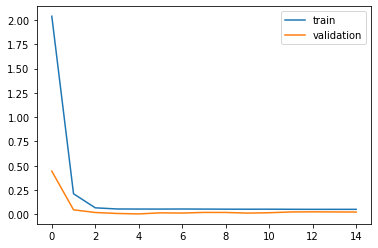


predict: [[35.06253197 22.36263771]]
real:      [[34.  22.8]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.6239 - mean_squared_error: 3.4111 - val_loss: 0.3178 - val_mean_squared_error: 0.1063
Epoch 2/1000
 - 1s - loss: 0.1464 - mean_squared_error: 0.0332 - val_loss: 0.0741 - val_mean_squared_error: 0.0056
Epoch 3/1000
 - 1s - loss: 0.0663 - mean_squared_error: 0.0074 - val_loss: 0.0319 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0062 - val_loss: 0.0096 - val_mean_squared_error: 9.2728e-05
Epoch 5/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0058 - val_loss: 0.0194 - val_mean_squared_error: 5.5414e-04
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.0216 - val_mean_squared_error: 6.3039e-04
Epoch 7/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0056 - val_loss: 0.0052 - val_mean_squared_error: 2.9013e-05
Epoch 8/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0054 - val_l

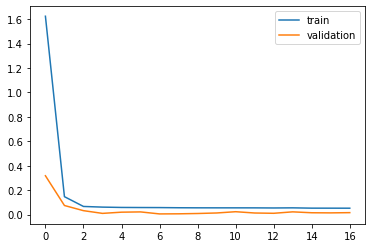


predict: [[36.24002767 23.92193427]]
real:      [[34.7 22.3]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.9354 - mean_squared_error: 4.5339 - val_loss: 0.2844 - val_mean_squared_error: 0.1028
Epoch 2/1000
 - 1s - loss: 0.2028 - mean_squared_error: 0.0601 - val_loss: 0.1058 - val_mean_squared_error: 0.0123
Epoch 3/1000
 - 1s - loss: 0.0706 - mean_squared_error: 0.0082 - val_loss: 0.1290 - val_mean_squared_error: 0.0227
Epoch 4/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0061 - val_loss: 0.1237 - val_mean_squared_error: 0.0256
Epoch 5/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0059 - val_loss: 0.1116 - val_mean_squared_error: 0.0216
Epoch 6/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0056 - val_loss: 0.1026 - val_mean_squared_error: 0.0197
Epoch 7/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0054 - val_loss: 0.1055 - val_mean_squared_error: 0.0221
Epoch 8/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0056 - val_loss: 0.1129 - va

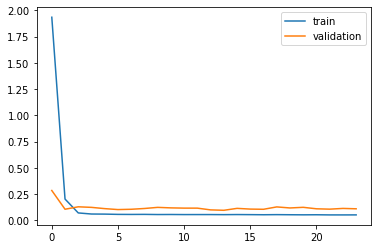


predict: [[34.3973191  22.69069171]]
real:      [[34.9 23.1]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.5856 - mean_squared_error: 7.0447 - val_loss: 1.8005 - val_mean_squared_error: 3.6274
Epoch 2/1000
 - 1s - loss: 1.1233 - mean_squared_error: 1.7939 - val_loss: 0.7311 - val_mean_squared_error: 0.6733
Epoch 3/1000
 - 1s - loss: 0.3962 - mean_squared_error: 0.2764 - val_loss: 0.0434 - val_mean_squared_error: 0.0022
Epoch 4/1000
 - 1s - loss: 0.0793 - mean_squared_error: 0.0101 - val_loss: 0.0513 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0064 - val_mean_squared_error: 7.2180e-05
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0210 - val_mean_squared_error: 4.5628e-04
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0140 - val_mean_squared_error: 2.7425e-04
Epoch 8/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0054 - val_loss:

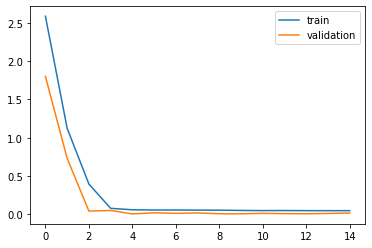


predict: [[35.00886038 23.00820743]]
real:      [[28.6 23.2]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 3.0780 - mean_squared_error: 9.7042 - val_loss: 2.4188 - val_mean_squared_error: 6.0638
Epoch 2/1000
 - 1s - loss: 1.4643 - mean_squared_error: 2.8687 - val_loss: 0.5511 - val_mean_squared_error: 0.4444
Epoch 3/1000
 - 1s - loss: 0.1838 - mean_squared_error: 0.0732 - val_loss: 0.1023 - val_mean_squared_error: 0.0105
Epoch 4/1000
 - 1s - loss: 0.0702 - mean_squared_error: 0.0079 - val_loss: 0.0262 - val_mean_squared_error: 6.9218e-04
Epoch 5/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0058 - val_loss: 0.0258 - val_mean_squared_error: 8.5925e-04
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0097 - val_mean_squared_error: 1.4255e-04
Epoch 7/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0057 - val_loss: 0.0054 - val_mean_squared_error: 3.6879e-05
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0056 - val_l

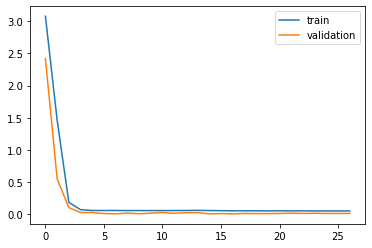


predict: [[34.76095348 22.4792143 ]]
real:      [[35.  23.2]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.8347 - mean_squared_error: 8.3802 - val_loss: 2.1077 - val_mean_squared_error: 4.5549
Epoch 2/1000
 - 1s - loss: 1.3087 - mean_squared_error: 2.1071 - val_loss: 0.4468 - val_mean_squared_error: 0.3333
Epoch 3/1000
 - 1s - loss: 0.1869 - mean_squared_error: 0.0666 - val_loss: 0.0670 - val_mean_squared_error: 0.0073
Epoch 4/1000
 - 1s - loss: 0.0672 - mean_squared_error: 0.0074 - val_loss: 0.0545 - val_mean_squared_error: 0.0030
Epoch 5/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0058 - val_loss: 0.0478 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0058 - val_loss: 0.0191 - val_mean_squared_error: 3.6550e-04
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0058 - val_loss: 0.0189 - val_mean_squared_error: 6.4939e-04
Epoch 8/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0

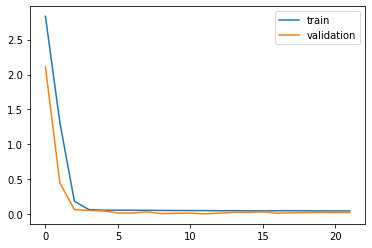


predict: [[35.04166212 23.37953821]]
real:      [[35.  22.7]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.4653 - mean_squared_error: 2.9987 - val_loss: 0.2386 - val_mean_squared_error: 0.0630
Epoch 2/1000
 - 1s - loss: 0.1458 - mean_squared_error: 0.0325 - val_loss: 0.0673 - val_mean_squared_error: 0.0046
Epoch 3/1000
 - 1s - loss: 0.0676 - mean_squared_error: 0.0076 - val_loss: 0.0369 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0057 - val_loss: 0.0359 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.0374 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0056 - val_loss: 0.0216 - val_mean_squared_error: 4.6859e-04
Epoch 7/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0055 - val_loss: 0.0358 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0543 - mean_squared_error: 0.0052 - val_loss: 0.0368 

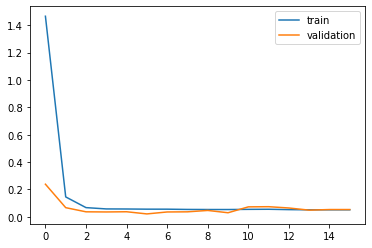


predict: [[35.84885832 21.9565125 ]]
real:      [[35.2 23.6]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.6985 - mean_squared_error: 3.7294 - val_loss: 0.4953 - val_mean_squared_error: 0.2589
Epoch 2/1000
 - 1s - loss: 0.1842 - mean_squared_error: 0.0543 - val_loss: 0.1048 - val_mean_squared_error: 0.0114
Epoch 3/1000
 - 1s - loss: 0.0771 - mean_squared_error: 0.0095 - val_loss: 0.0275 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0069 - val_loss: 0.0033 - val_mean_squared_error: 1.1480e-05
Epoch 5/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0119 - val_mean_squared_error: 1.7876e-04
Epoch 6/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0352 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0059 - val_loss: 0.0395 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0059 - val_loss: 0.0

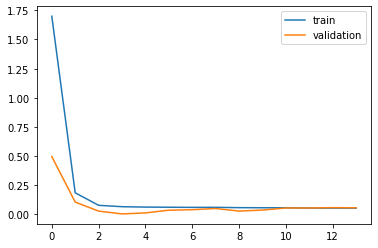


predict: [[33.81818005 21.84886585]]
real:      [[34.9 21.2]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.1884 - mean_squared_error: 5.1921 - val_loss: 1.0914 - val_mean_squared_error: 1.2393
Epoch 2/1000
 - 1s - loss: 0.3606 - mean_squared_error: 0.2359 - val_loss: 0.1165 - val_mean_squared_error: 0.0149
Epoch 3/1000
 - 1s - loss: 0.0755 - mean_squared_error: 0.0094 - val_loss: 0.0532 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0057 - val_loss: 0.0346 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0057 - val_loss: 0.0490 - val_mean_squared_error: 0.0040
Epoch 6/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0056 - val_loss: 0.0428 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0396 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0055 - val_loss: 0.0400 - va

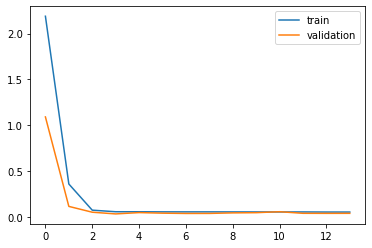


predict: [[35.9354703  23.67778707]]
real:      [[33.4 21.6]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.2692 - mean_squared_error: 6.6658 - val_loss: 1.1895 - val_mean_squared_error: 2.6405
Epoch 2/1000
 - 1s - loss: 0.5519 - mean_squared_error: 0.8054 - val_loss: 0.2281 - val_mean_squared_error: 0.1019
Epoch 3/1000
 - 1s - loss: 0.0978 - mean_squared_error: 0.0165 - val_loss: 0.0686 - val_mean_squared_error: 0.0075
Epoch 4/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0061 - val_loss: 0.0833 - val_mean_squared_error: 0.0096
Epoch 5/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0057 - val_loss: 0.0811 - val_mean_squared_error: 0.0105
Epoch 6/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0853 - val_mean_squared_error: 0.0096
Epoch 7/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0054 - val_loss: 0.0846 - val_mean_squared_error: 0.0101
Epoch 8/1000
 - 1s - loss: 0.0553 - mean_squared_error: 0.0054 - val_loss: 0.0935 - v

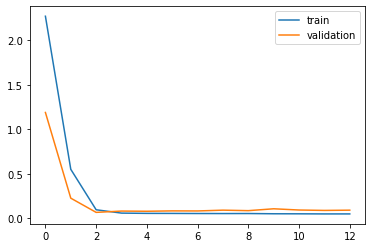


predict: [[35.90909664 24.14987183]]
real:      [[34.4 24.5]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.8259 - mean_squared_error: 4.1704 - val_loss: 0.3489 - val_mean_squared_error: 0.2294
Epoch 2/1000
 - 1s - loss: 0.1698 - mean_squared_error: 0.0468 - val_loss: 0.0596 - val_mean_squared_error: 0.0042
Epoch 3/1000
 - 1s - loss: 0.0705 - mean_squared_error: 0.0083 - val_loss: 0.1035 - val_mean_squared_error: 0.0120
Epoch 4/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0831 - val_mean_squared_error: 0.0094
Epoch 5/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0061 - val_loss: 0.0920 - val_mean_squared_error: 0.0118
Epoch 6/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0054 - val_loss: 0.0548 - val_mean_squared_error: 0.0048
Epoch 7/1000
 - 1s - loss: 0.0545 - mean_squared_error: 0.0052 - val_loss: 0.0659 - val_mean_squared_error: 0.0073
Epoch 8/1000
 - 1s - loss: 0.0536 - mean_squared_error: 0.0051 - val_loss: 0.0538 - v

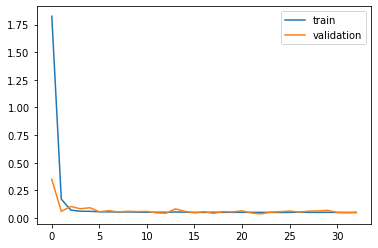


predict: [[35.11926301 23.51329567]]
real:      [[29.8 23.4]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.8213 - mean_squared_error: 4.3346 - val_loss: 0.8479 - val_mean_squared_error: 0.9010
Epoch 2/1000
 - 1s - loss: 0.5467 - mean_squared_error: 0.4071 - val_loss: 0.1198 - val_mean_squared_error: 0.0225
Epoch 3/1000
 - 1s - loss: 0.0932 - mean_squared_error: 0.0140 - val_loss: 0.0910 - val_mean_squared_error: 0.0088
Epoch 4/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0067 - val_loss: 0.0727 - val_mean_squared_error: 0.0053
Epoch 5/1000
 - 1s - loss: 0.0585 - mean_squared_error: 0.0059 - val_loss: 0.0506 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0323 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.0381 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0055 - val_loss: 0.0575 - v

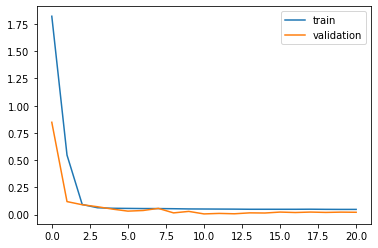


predict: [[36.21766003 23.7844343 ]]
real:      [[35.5 25.5]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.4984 - mean_squared_error: 3.0998 - val_loss: 0.6235 - val_mean_squared_error: 0.4895
Epoch 2/1000
 - 1s - loss: 0.2225 - mean_squared_error: 0.1094 - val_loss: 0.0595 - val_mean_squared_error: 0.0065
Epoch 3/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0064 - val_loss: 0.0138 - val_mean_squared_error: 1.9229e-04
Epoch 4/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0054 - val_loss: 0.0096 - val_mean_squared_error: 1.1406e-04
Epoch 5/1000
 - 1s - loss: 0.0553 - mean_squared_error: 0.0054 - val_loss: 0.0058 - val_mean_squared_error: 3.3831e-05
Epoch 6/1000
 - 1s - loss: 0.0544 - mean_squared_error: 0.0053 - val_loss: 0.0073 - val_mean_squared_error: 7.0895e-05
Epoch 7/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.0212 - val_mean_squared_error: 4.4917e-04
Epoch 8/1000
 - 1s - loss: 0.0535 - mean_squared_error: 0.0051 - 

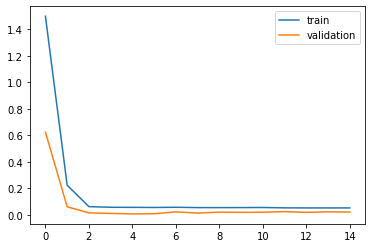


predict: [[36.89891579 23.89731152]]
real:      [[35.6 23.9]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.9963 - mean_squared_error: 4.8404 - val_loss: 0.3006 - val_mean_squared_error: 0.1215
Epoch 2/1000
 - 1s - loss: 0.1691 - mean_squared_error: 0.0479 - val_loss: 0.0499 - val_mean_squared_error: 0.0032
Epoch 3/1000
 - 1s - loss: 0.0688 - mean_squared_error: 0.0075 - val_loss: 0.0463 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0060 - val_loss: 0.0172 - val_mean_squared_error: 3.8453e-04
Epoch 5/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0053 - val_loss: 0.0277 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0550 - mean_squared_error: 0.0052 - val_loss: 0.0448 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 1s - loss: 0.0538 - mean_squared_error: 0.0050 - val_loss: 0.0497 - val_mean_squared_error: 0.0029
Epoch 8/1000
 - 1s - loss: 0.0539 - mean_squared_error: 0.0051 - val_loss: 0.0281

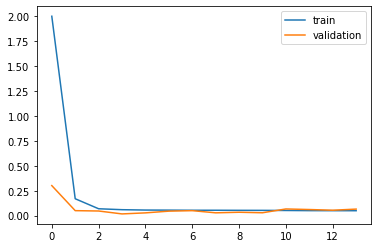


predict: [[35.90152958 24.28509452]]
real:      [[34.8 23. ]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.5428 - mean_squared_error: 6.8537 - val_loss: 1.5454 - val_mean_squared_error: 2.6533
Epoch 2/1000
 - 1s - loss: 0.6034 - mean_squared_error: 0.7591 - val_loss: 0.2158 - val_mean_squared_error: 0.0492
Epoch 3/1000
 - 1s - loss: 0.1013 - mean_squared_error: 0.0183 - val_loss: 0.0882 - val_mean_squared_error: 0.0155
Epoch 4/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0063 - val_loss: 0.0875 - val_mean_squared_error: 0.0098
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0058 - val_loss: 0.0991 - val_mean_squared_error: 0.0126
Epoch 6/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.1011 - val_mean_squared_error: 0.0152
Epoch 7/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0057 - val_loss: 0.0936 - val_mean_squared_error: 0.0127
Epoch 8/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0057 - val_loss: 0.0744 - v

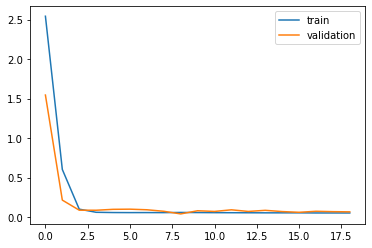


predict: [[34.07749401 23.75466457]]
real:      [[33.2 22.8]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.5274 - mean_squared_error: 6.9255 - val_loss: 1.5879 - val_mean_squared_error: 2.5652
Epoch 2/1000
 - 1s - loss: 0.6216 - mean_squared_error: 0.6319 - val_loss: 0.0990 - val_mean_squared_error: 0.0108
Epoch 3/1000
 - 1s - loss: 0.0964 - mean_squared_error: 0.0145 - val_loss: 0.0951 - val_mean_squared_error: 0.0111
Epoch 4/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0062 - val_loss: 0.1128 - val_mean_squared_error: 0.0143
Epoch 5/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0059 - val_loss: 0.1272 - val_mean_squared_error: 0.0170
Epoch 6/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0983 - val_mean_squared_error: 0.0106
Epoch 7/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0057 - val_loss: 0.1064 - val_mean_squared_error: 0.0138
Epoch 8/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0058 - val_loss: 0.1142 - v

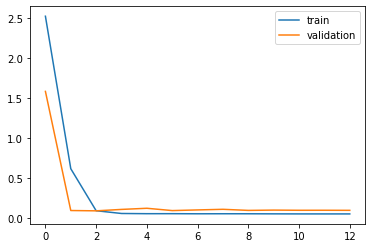


predict: [[35.31578492 22.3113268 ]]
real:      [[35.4 26.5]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.0289 - mean_squared_error: 4.8682 - val_loss: 0.5113 - val_mean_squared_error: 0.3153
Epoch 2/1000
 - 1s - loss: 0.1827 - mean_squared_error: 0.0543 - val_loss: 0.1146 - val_mean_squared_error: 0.0137
Epoch 3/1000
 - 1s - loss: 0.0722 - mean_squared_error: 0.0085 - val_loss: 0.1118 - val_mean_squared_error: 0.0187
Epoch 4/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0065 - val_loss: 0.1059 - val_mean_squared_error: 0.0140
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0063 - val_loss: 0.1191 - val_mean_squared_error: 0.0176
Epoch 6/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0059 - val_loss: 0.1100 - val_mean_squared_error: 0.0167
Epoch 7/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0057 - val_loss: 0.1047 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0055 - val_loss: 0.1016 - v

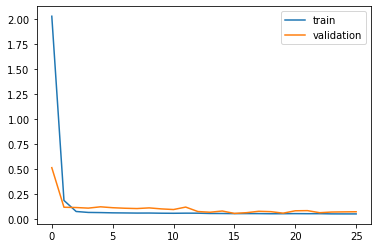


predict: [[33.71396407 22.80052256]]
real:      [[36.6 25.9]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.3025 - mean_squared_error: 5.7829 - val_loss: 1.2177 - val_mean_squared_error: 1.6045
Epoch 2/1000
 - 1s - loss: 0.3510 - mean_squared_error: 0.2616 - val_loss: 0.1692 - val_mean_squared_error: 0.0296
Epoch 3/1000
 - 1s - loss: 0.0709 - mean_squared_error: 0.0081 - val_loss: 0.0786 - val_mean_squared_error: 0.0067
Epoch 4/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0059 - val_loss: 0.0892 - val_mean_squared_error: 0.0093
Epoch 5/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0059 - val_loss: 0.0887 - val_mean_squared_error: 0.0094
Epoch 6/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0057 - val_loss: 0.0652 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0061 - val_loss: 0.0910 - val_mean_squared_error: 0.0093
Epoch 8/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0057 - val_loss: 0.0806 - v

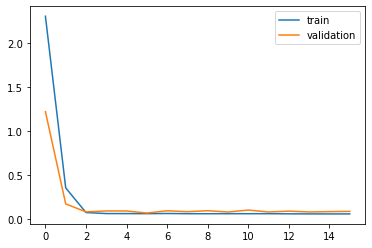


predict: [[33.63375046 23.68428347]]
real:      [[36.2 26.4]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 3.0235 - mean_squared_error: 9.3839 - val_loss: 2.4527 - val_mean_squared_error: 6.3547
Epoch 2/1000
 - 1s - loss: 1.4398 - mean_squared_error: 2.8012 - val_loss: 0.5601 - val_mean_squared_error: 0.4731
Epoch 3/1000
 - 1s - loss: 0.2074 - mean_squared_error: 0.0844 - val_loss: 0.0718 - val_mean_squared_error: 0.0052
Epoch 4/1000
 - 1s - loss: 0.0711 - mean_squared_error: 0.0082 - val_loss: 0.0875 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0059 - val_loss: 0.0732 - val_mean_squared_error: 0.0054
Epoch 6/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0056 - val_loss: 0.0804 - val_mean_squared_error: 0.0067
Epoch 7/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0056 - val_loss: 0.0693 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.0739 - v

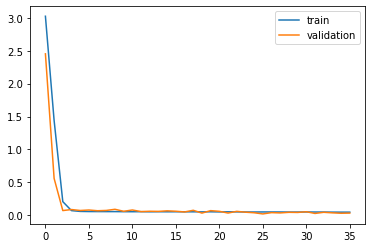


predict: [[33.74786442 22.39489963]]
real:      [[35.8 25.8]]

Train and validation time: 19.235522639751434

Maximum metrics
Test RMSE -------------------------- 2.23
Test VARIANCE ---------------------- -0.2176
Test MAX-ERROR --------------------- 6.409
Test MEAN-ABSOLUTE-ERROR ----------- 1.597
Test MEDIAN-ABSOLUTE-ERROR --------- 1.048

Errors
2018-12-31 = 0.5415317035015761
2018-12-30 = 1.0344269999988427
2018-12-29 = 1.013213839097908
2018-12-28 = 0.6558516025522039
2018-12-27 = 0.1735642841853533
2018-12-26 = 0.5415506444363061
2018-12-25 = 4.054713581137808
2018-12-24 = 4.230915581810976
2018-12-23 = 1.9842537195090983
2018-12-22 = 0.2497336086131412
2018-12-21 = 0.9695718393112003
2018-12-20 = 1.062531969512591
2018-12-19 = 1.5400276663098396
2018-12-18 = 0.5026809043634799
2018-12-17 = 6.408860382427665
2018-12-16 = 0.23904652363459888
2018-12-15 = 0.04166212097956645
2018-12-14 = 0.6488583245004591
2018-12-13 = 1.0818199498379784
2018-12-12 = 2.535470304735803
2018-12-11 = 

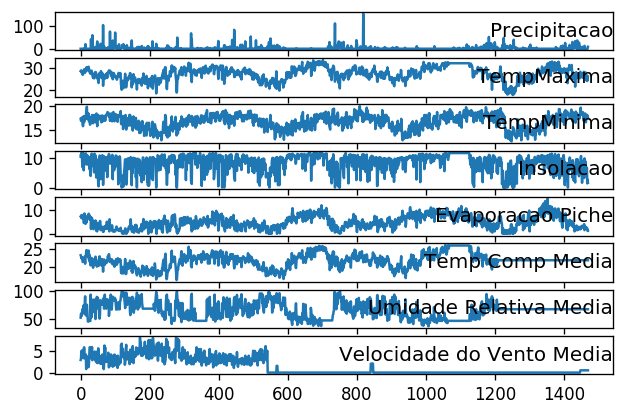

Train on 1409 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.7036 - mean_squared_error: 3.4372 - val_loss: 0.6976 - val_mean_squared_error: 0.6484
Epoch 2/1000
 - 1s - loss: 0.2926 - mean_squared_error: 0.1465 - val_loss: 0.0938 - val_mean_squared_error: 0.0173
Epoch 3/1000
 - 1s - loss: 0.0937 - mean_squared_error: 0.0141 - val_loss: 0.0653 - val_mean_squared_error: 0.0047
Epoch 4/1000
 - 1s - loss: 0.0794 - mean_squared_error: 0.0102 - val_loss: 0.0765 - val_mean_squared_error: 0.0061
Epoch 5/1000
 - 1s - loss: 0.0777 - mean_squared_error: 0.0101 - val_loss: 0.0841 - val_mean_squared_error: 0.0099
Epoch 6/1000
 - 1s - loss: 0.0767 - mean_squared_error: 0.0098 - val_loss: 0.0858 - val_mean_squared_error: 0.0112
Epoch 7/1000
 - 1s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.0914 - val_mean_squared_error: 0.0100
Epoch 8/1000
 - 1s - loss: 0.0756 - mean_squared_error: 0.0097 - val_loss: 0.0778 - val_mean_squared_error: 0.0079
Epoch 9/1000
 - 1s - loss: 0.0751 

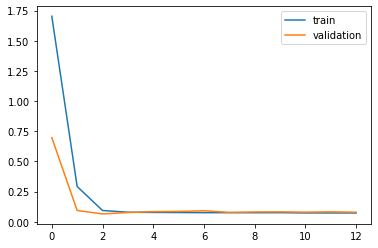


predict: [[25.93309807 16.32109933]]
real:      [[26.2 17.5]]

Train on 1408 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.1506 - mean_squared_error: 5.1618 - val_loss: 1.0847 - val_mean_squared_error: 2.2330
Epoch 2/1000
 - 1s - loss: 1.0022 - mean_squared_error: 1.6340 - val_loss: 0.8703 - val_mean_squared_error: 1.3778
Epoch 3/1000
 - 1s - loss: 0.7359 - mean_squared_error: 0.9350 - val_loss: 0.7156 - val_mean_squared_error: 0.7972
Epoch 4/1000
 - 1s - loss: 0.5508 - mean_squared_error: 0.5215 - val_loss: 0.5130 - val_mean_squared_error: 0.3611
Epoch 5/1000
 - 1s - loss: 0.2782 - mean_squared_error: 0.1366 - val_loss: 0.1495 - val_mean_squared_error: 0.0254
Epoch 6/1000
 - 1s - loss: 0.0889 - mean_squared_error: 0.0130 - val_loss: 0.1241 - val_mean_squared_error: 0.0205
Epoch 7/1000
 - 1s - loss: 0.0798 - mean_squared_error: 0.0104 - val_loss: 0.0825 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 1s - loss: 0.0772 - mean_squared_error: 0.0098 - val_loss: 0.1050 - v

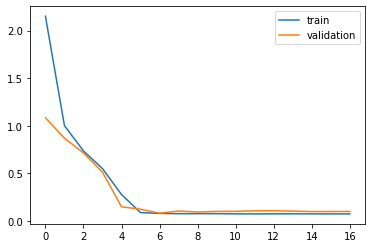


predict: [[25.50859234 16.24495088]]
real:      [[25.2 17.5]]

Train on 1407 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.5746 - mean_squared_error: 7.5814 - val_loss: 1.8365 - val_mean_squared_error: 5.2326
Epoch 2/1000
 - 1s - loss: 1.3709 - mean_squared_error: 3.5436 - val_loss: 0.8380 - val_mean_squared_error: 1.3231
Epoch 3/1000
 - 1s - loss: 0.3666 - mean_squared_error: 0.3498 - val_loss: 0.1808 - val_mean_squared_error: 0.0443
Epoch 4/1000
 - 1s - loss: 0.1012 - mean_squared_error: 0.0171 - val_loss: 0.0655 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 1s - loss: 0.0811 - mean_squared_error: 0.0111 - val_loss: 0.0421 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 1s - loss: 0.0768 - mean_squared_error: 0.0098 - val_loss: 0.0446 - val_mean_squared_error: 0.0020
Epoch 7/1000
 - 1s - loss: 0.0772 - mean_squared_error: 0.0099 - val_loss: 0.0515 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0775 - mean_squared_error: 0.0100 - val_loss: 0.0330 - v

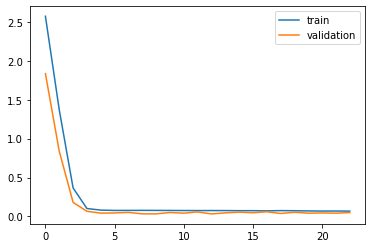


predict: [[26.45714325 17.32973333]]
real:      [[24.2 18.1]]

Train on 1406 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.6317 - mean_squared_error: 7.2575 - val_loss: 1.7537 - val_mean_squared_error: 3.3095
Epoch 2/1000
 - 1s - loss: 1.0127 - mean_squared_error: 1.5041 - val_loss: 0.3649 - val_mean_squared_error: 0.1353
Epoch 3/1000
 - 1s - loss: 0.1663 - mean_squared_error: 0.0421 - val_loss: 0.0345 - val_mean_squared_error: 0.0012
Epoch 4/1000
 - 1s - loss: 0.0841 - mean_squared_error: 0.0115 - val_loss: 0.0692 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.0761 - mean_squared_error: 0.0096 - val_loss: 0.0587 - val_mean_squared_error: 0.0038
Epoch 6/1000
 - 1s - loss: 0.0753 - mean_squared_error: 0.0095 - val_loss: 0.0520 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 1s - loss: 0.0748 - mean_squared_error: 0.0094 - val_loss: 0.0429 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.0747 - mean_squared_error: 0.0093 - val_loss: 0.0588 - v

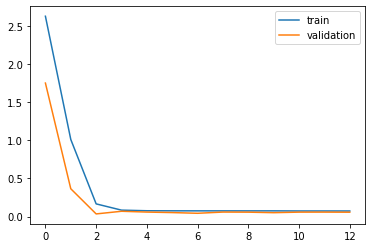


predict: [[26.917099   16.88242928]]
real:      [[26.8 17.4]]

Train on 1405 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.1344 - mean_squared_error: 1.8788 - val_loss: 0.2689 - val_mean_squared_error: 0.0747
Epoch 2/1000
 - 1s - loss: 0.1584 - mean_squared_error: 0.0395 - val_loss: 0.0538 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 1s - loss: 0.0900 - mean_squared_error: 0.0129 - val_loss: 0.0464 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 1s - loss: 0.0806 - mean_squared_error: 0.0105 - val_loss: 0.0598 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0788 - mean_squared_error: 0.0100 - val_loss: 0.0720 - val_mean_squared_error: 0.0098
Epoch 6/1000
 - 1s - loss: 0.0774 - mean_squared_error: 0.0099 - val_loss: 0.0743 - val_mean_squared_error: 0.0083
Epoch 7/1000
 - 1s - loss: 0.0773 - mean_squared_error: 0.0097 - val_loss: 0.0886 - val_mean_squared_error: 0.0130
Epoch 8/1000
 - 1s - loss: 0.0756 - mean_squared_error: 0.0096 - val_loss: 0.0778 - v

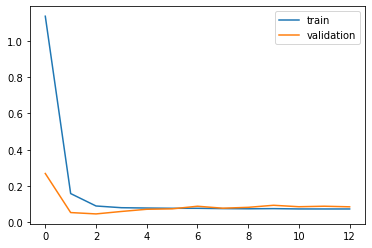


predict: [[26.86968235 16.98007332]]
real:      [[26.2 17.8]]

Train on 1404 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.0588 - mean_squared_error: 4.7053 - val_loss: 0.8671 - val_mean_squared_error: 1.0497
Epoch 2/1000
 - 1s - loss: 0.3551 - mean_squared_error: 0.2456 - val_loss: 0.0781 - val_mean_squared_error: 0.0083
Epoch 3/1000
 - 1s - loss: 0.1109 - mean_squared_error: 0.0192 - val_loss: 0.0150 - val_mean_squared_error: 4.2938e-04
Epoch 4/1000
 - 1s - loss: 0.0846 - mean_squared_error: 0.0116 - val_loss: 0.0658 - val_mean_squared_error: 0.0051
Epoch 5/1000
 - 1s - loss: 0.0769 - mean_squared_error: 0.0099 - val_loss: 0.0588 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 1s - loss: 0.0765 - mean_squared_error: 0.0098 - val_loss: 0.0833 - val_mean_squared_error: 0.0090
Epoch 7/1000
 - 1s - loss: 0.0751 - mean_squared_error: 0.0095 - val_loss: 0.0630 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0747 - mean_squared_error: 0.0093 - val_loss: 0.0866

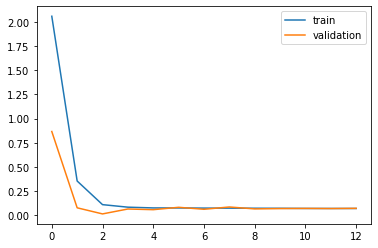


predict: [[24.66210481 15.99798952]]
real:      [[24.5 17.5]]

Train on 1403 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.3226 - mean_squared_error: 5.6662 - val_loss: 1.6048 - val_mean_squared_error: 2.7918
Epoch 2/1000
 - 1s - loss: 0.8004 - mean_squared_error: 1.0580 - val_loss: 0.1535 - val_mean_squared_error: 0.0350
Epoch 3/1000
 - 1s - loss: 0.1413 - mean_squared_error: 0.0321 - val_loss: 0.1338 - val_mean_squared_error: 0.0185
Epoch 4/1000
 - 1s - loss: 0.0883 - mean_squared_error: 0.0131 - val_loss: 0.0715 - val_mean_squared_error: 0.0051
Epoch 5/1000
 - 1s - loss: 0.0803 - mean_squared_error: 0.0106 - val_loss: 0.0557 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0772 - mean_squared_error: 0.0099 - val_loss: 0.0350 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0770 - mean_squared_error: 0.0098 - val_loss: 0.0477 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.0770 - mean_squared_error: 0.0098 - val_loss: 0.0330 - v

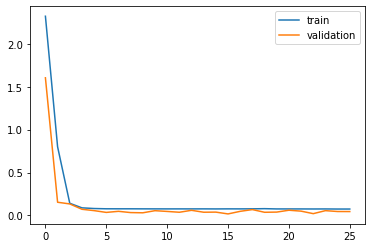


predict: [[26.95696332 17.24455662]]
real:      [[26.3 16.6]]

Train on 1402 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.9598 - mean_squared_error: 4.4614 - val_loss: 0.6711 - val_mean_squared_error: 0.6533
Epoch 2/1000
 - 1s - loss: 0.5272 - mean_squared_error: 0.3190 - val_loss: 0.3260 - val_mean_squared_error: 0.1238
Epoch 3/1000
 - 1s - loss: 0.1604 - mean_squared_error: 0.0435 - val_loss: 0.0949 - val_mean_squared_error: 0.0092
Epoch 4/1000
 - 1s - loss: 0.0860 - mean_squared_error: 0.0120 - val_loss: 0.0504 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.0779 - mean_squared_error: 0.0101 - val_loss: 0.0265 - val_mean_squared_error: 9.6912e-04
Epoch 6/1000
 - 1s - loss: 0.0783 - mean_squared_error: 0.0100 - val_loss: 0.0427 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0769 - mean_squared_error: 0.0099 - val_loss: 0.0510 - val_mean_squared_error: 0.0035
Epoch 8/1000
 - 1s - loss: 0.0755 - mean_squared_error: 0.0095 - val_loss: 0.0405

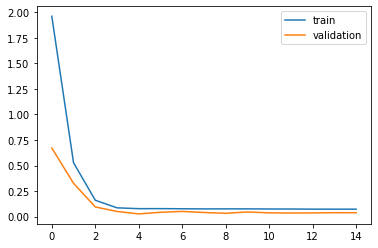


predict: [[27.71176466 17.20135303]]
real:      [[28.1 18.3]]

Train on 1401 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.8497 - mean_squared_error: 4.1415 - val_loss: 0.6003 - val_mean_squared_error: 0.7098
Epoch 2/1000
 - 1s - loss: 0.3136 - mean_squared_error: 0.1634 - val_loss: 0.1994 - val_mean_squared_error: 0.0398
Epoch 3/1000
 - 1s - loss: 0.0992 - mean_squared_error: 0.0154 - val_loss: 0.0613 - val_mean_squared_error: 0.0054
Epoch 4/1000
 - 1s - loss: 0.0797 - mean_squared_error: 0.0104 - val_loss: 0.0719 - val_mean_squared_error: 0.0056
Epoch 5/1000
 - 1s - loss: 0.0782 - mean_squared_error: 0.0098 - val_loss: 0.0369 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0777 - mean_squared_error: 0.0100 - val_loss: 0.0430 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 1s - loss: 0.0766 - mean_squared_error: 0.0097 - val_loss: 0.0335 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 1s - loss: 0.0761 - mean_squared_error: 0.0095 - val_loss: 0.0305 - v

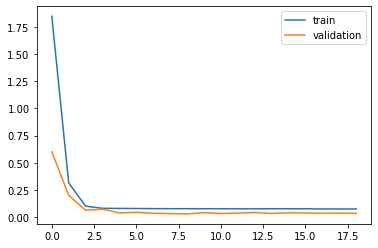


predict: [[27.90330576 17.06808133]]
real:      [[28.1 18.4]]

Train on 1400 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.5113 - mean_squared_error: 6.4398 - val_loss: 1.9798 - val_mean_squared_error: 3.9308
Epoch 2/1000
 - 1s - loss: 1.3730 - mean_squared_error: 2.0437 - val_loss: 0.5908 - val_mean_squared_error: 0.3761
Epoch 3/1000
 - 1s - loss: 0.2275 - mean_squared_error: 0.0904 - val_loss: 0.0879 - val_mean_squared_error: 0.0078
Epoch 4/1000
 - 1s - loss: 0.0935 - mean_squared_error: 0.0143 - val_loss: 0.0666 - val_mean_squared_error: 0.0046
Epoch 5/1000
 - 1s - loss: 0.0810 - mean_squared_error: 0.0108 - val_loss: 0.0436 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0795 - mean_squared_error: 0.0102 - val_loss: 0.0324 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0763 - mean_squared_error: 0.0095 - val_loss: 0.0454 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.0759 - mean_squared_error: 0.0095 - val_loss: 0.0601 - v

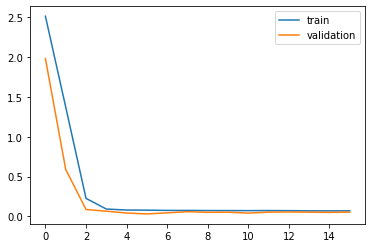


predict: [[27.34532621 17.27063513]]
real:      [[28.  18.1]]

Train on 1399 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.3672 - mean_squared_error: 6.0514 - val_loss: 1.6395 - val_mean_squared_error: 3.4032
Epoch 2/1000
 - 1s - loss: 1.0613 - mean_squared_error: 1.9079 - val_loss: 0.6192 - val_mean_squared_error: 0.5769
Epoch 3/1000
 - 1s - loss: 0.2503 - mean_squared_error: 0.1423 - val_loss: 0.1179 - val_mean_squared_error: 0.0201
Epoch 4/1000
 - 1s - loss: 0.0907 - mean_squared_error: 0.0141 - val_loss: 0.0640 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 1s - loss: 0.0775 - mean_squared_error: 0.0102 - val_loss: 0.0334 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0749 - mean_squared_error: 0.0095 - val_loss: 0.0370 - val_mean_squared_error: 0.0025
Epoch 7/1000
 - 1s - loss: 0.0750 - mean_squared_error: 0.0095 - val_loss: 0.0339 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.0741 - mean_squared_error: 0.0093 - val_loss: 0.0525 - v

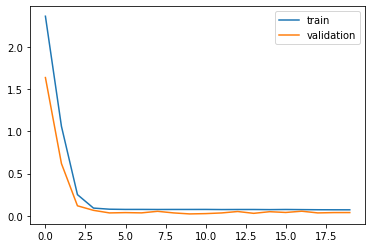


predict: [[27.61764417 16.96530284]]
real:      [[27.2 18.3]]

Train on 1398 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.4297 - mean_squared_error: 2.6495 - val_loss: 0.3526 - val_mean_squared_error: 0.1310
Epoch 2/1000
 - 1s - loss: 0.1732 - mean_squared_error: 0.0477 - val_loss: 0.1069 - val_mean_squared_error: 0.0216
Epoch 3/1000
 - 1s - loss: 0.0936 - mean_squared_error: 0.0147 - val_loss: 0.0699 - val_mean_squared_error: 0.0057
Epoch 4/1000
 - 1s - loss: 0.0815 - mean_squared_error: 0.0111 - val_loss: 0.0168 - val_mean_squared_error: 3.9781e-04
Epoch 5/1000
 - 1s - loss: 0.0766 - mean_squared_error: 0.0098 - val_loss: 0.0141 - val_mean_squared_error: 1.9886e-04
Epoch 6/1000
 - 1s - loss: 0.0753 - mean_squared_error: 0.0095 - val_loss: 0.0031 - val_mean_squared_error: 1.8484e-05
Epoch 7/1000
 - 1s - loss: 0.0754 - mean_squared_error: 0.0096 - val_loss: 0.0147 - val_mean_squared_error: 2.4935e-04
Epoch 8/1000
 - 1s - loss: 0.0747 - mean_squared_error: 0.0094 - val_

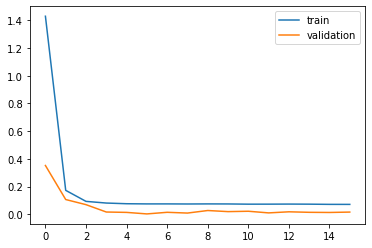


predict: [[27.18942923 16.34066024]]
real:      [[28.  18.1]]

Train on 1397 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.9431 - mean_squared_error: 4.4125 - val_loss: 0.5466 - val_mean_squared_error: 0.3010
Epoch 2/1000
 - 1s - loss: 0.2142 - mean_squared_error: 0.0749 - val_loss: 0.0853 - val_mean_squared_error: 0.0121
Epoch 3/1000
 - 1s - loss: 0.0977 - mean_squared_error: 0.0163 - val_loss: 0.0367 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0796 - mean_squared_error: 0.0107 - val_loss: 0.0630 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 1s - loss: 0.0753 - mean_squared_error: 0.0097 - val_loss: 0.0809 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 1s - loss: 0.0737 - mean_squared_error: 0.0093 - val_loss: 0.0746 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 1s - loss: 0.0751 - mean_squared_error: 0.0095 - val_loss: 0.0741 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 1s - loss: 0.0756 - mean_squared_error: 0.0096 - val_loss: 0.0493 - v

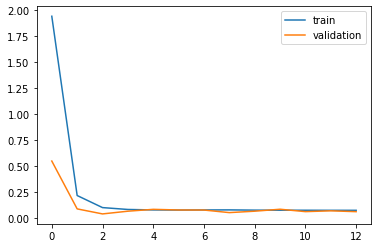


predict: [[25.70501332 16.4665799 ]]
real:      [[28.4 16.9]]

Train on 1396 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.5427 - mean_squared_error: 6.7827 - val_loss: 2.0088 - val_mean_squared_error: 4.9019
Epoch 2/1000
 - 1s - loss: 1.5340 - mean_squared_error: 3.8729 - val_loss: 1.2056 - val_mean_squared_error: 2.4774
Epoch 3/1000
 - 1s - loss: 0.8657 - mean_squared_error: 1.3609 - val_loss: 0.5140 - val_mean_squared_error: 0.5182
Epoch 4/1000
 - 1s - loss: 0.2444 - mean_squared_error: 0.1299 - val_loss: 0.0656 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.0955 - mean_squared_error: 0.0143 - val_loss: 0.0906 - val_mean_squared_error: 0.0083
Epoch 6/1000
 - 1s - loss: 0.0785 - mean_squared_error: 0.0104 - val_loss: 0.0736 - val_mean_squared_error: 0.0062
Epoch 7/1000
 - 1s - loss: 0.0765 - mean_squared_error: 0.0098 - val_loss: 0.0644 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0096 - val_loss: 0.0585 - v

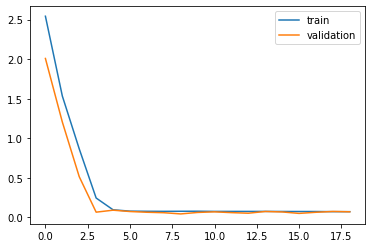


predict: [[26.33007352 16.96795438]]
real:      [[27.1 18.1]]

Train on 1395 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 3.1164 - mean_squared_error: 10.1287 - val_loss: 2.9234 - val_mean_squared_error: 9.5129
Epoch 2/1000
 - 1s - loss: 2.5602 - mean_squared_error: 9.5812 - val_loss: 2.1441 - val_mean_squared_error: 9.1537
Epoch 3/1000
 - 1s - loss: 1.9699 - mean_squared_error: 7.3405 - val_loss: 1.6287 - val_mean_squared_error: 4.8521
Epoch 4/1000
 - 1s - loss: 1.3153 - mean_squared_error: 3.3648 - val_loss: 0.8447 - val_mean_squared_error: 1.2810
Epoch 5/1000
 - 1s - loss: 0.4286 - mean_squared_error: 0.4596 - val_loss: 0.1971 - val_mean_squared_error: 0.0508
Epoch 6/1000
 - 1s - loss: 0.1159 - mean_squared_error: 0.0232 - val_loss: 0.0647 - val_mean_squared_error: 0.0082
Epoch 7/1000
 - 1s - loss: 0.0795 - mean_squared_error: 0.0108 - val_loss: 0.0949 - val_mean_squared_error: 0.0111
Epoch 8/1000
 - 1s - loss: 0.0776 - mean_squared_error: 0.0100 - val_loss: 0.0915 - 

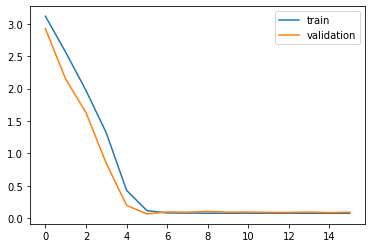


predict: [[25.46970147 16.41012353]]
real:      [[27.6 18.4]]

Train on 1394 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.6584 - mean_squared_error: 7.8448 - val_loss: 2.0979 - val_mean_squared_error: 6.4241
Epoch 2/1000
 - 1s - loss: 1.7646 - mean_squared_error: 5.7043 - val_loss: 1.5416 - val_mean_squared_error: 4.2703
Epoch 3/1000
 - 1s - loss: 1.2823 - mean_squared_error: 3.1520 - val_loss: 0.9492 - val_mean_squared_error: 1.7785
Epoch 4/1000
 - 1s - loss: 0.7827 - mean_squared_error: 1.1583 - val_loss: 0.4940 - val_mean_squared_error: 0.4481
Epoch 5/1000
 - 1s - loss: 0.2708 - mean_squared_error: 0.1641 - val_loss: 0.1471 - val_mean_squared_error: 0.0238
Epoch 6/1000
 - 1s - loss: 0.0971 - mean_squared_error: 0.0161 - val_loss: 0.0333 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 1s - loss: 0.0788 - mean_squared_error: 0.0104 - val_loss: 0.0522 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.0774 - mean_squared_error: 0.0097 - val_loss: 0.0637 - v

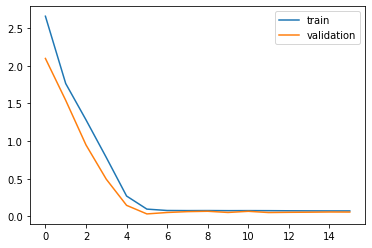


predict: [[26.49990417 17.23625031]]
real:      [[25.7 18.7]]

Train on 1393 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.4575 - mean_squared_error: 2.9663 - val_loss: 0.2902 - val_mean_squared_error: 0.0935
Epoch 2/1000
 - 1s - loss: 0.1961 - mean_squared_error: 0.0583 - val_loss: 0.0707 - val_mean_squared_error: 0.0054
Epoch 3/1000
 - 1s - loss: 0.0890 - mean_squared_error: 0.0131 - val_loss: 0.0471 - val_mean_squared_error: 0.0031
Epoch 4/1000
 - 1s - loss: 0.0766 - mean_squared_error: 0.0100 - val_loss: 0.0610 - val_mean_squared_error: 0.0038
Epoch 5/1000
 - 1s - loss: 0.0745 - mean_squared_error: 0.0094 - val_loss: 0.0636 - val_mean_squared_error: 0.0042
Epoch 6/1000
 - 1s - loss: 0.0744 - mean_squared_error: 0.0094 - val_loss: 0.0634 - val_mean_squared_error: 0.0041
Epoch 7/1000
 - 1s - loss: 0.0745 - mean_squared_error: 0.0093 - val_loss: 0.0650 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0734 - mean_squared_error: 0.0092 - val_loss: 0.0787 - v

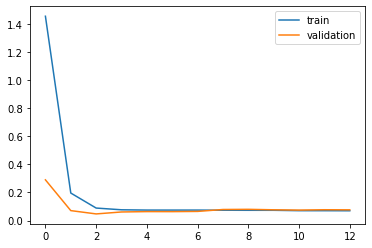


predict: [[28.74195201 17.85889223]]
real:      [[26.6 18.3]]

Train on 1392 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.5392 - mean_squared_error: 7.0786 - val_loss: 1.7628 - val_mean_squared_error: 4.0117
Epoch 2/1000
 - 1s - loss: 1.0940 - mean_squared_error: 2.1928 - val_loss: 0.4407 - val_mean_squared_error: 0.2628
Epoch 3/1000
 - 1s - loss: 0.1903 - mean_squared_error: 0.0717 - val_loss: 0.0823 - val_mean_squared_error: 0.0119
Epoch 4/1000
 - 1s - loss: 0.0950 - mean_squared_error: 0.0151 - val_loss: 0.0718 - val_mean_squared_error: 0.0061
Epoch 5/1000
 - 1s - loss: 0.0784 - mean_squared_error: 0.0101 - val_loss: 0.0849 - val_mean_squared_error: 0.0079
Epoch 6/1000
 - 1s - loss: 0.0760 - mean_squared_error: 0.0097 - val_loss: 0.0766 - val_mean_squared_error: 0.0060
Epoch 7/1000
 - 1s - loss: 0.0749 - mean_squared_error: 0.0095 - val_loss: 0.0968 - val_mean_squared_error: 0.0096
Epoch 8/1000
 - 1s - loss: 0.0749 - mean_squared_error: 0.0094 - val_loss: 0.0937 - v

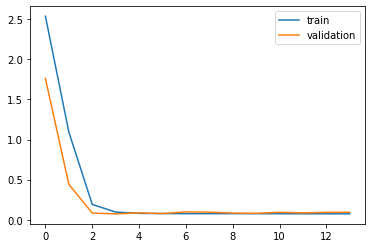


predict: [[26.89100654 16.70113665]]
real:      [[26.3 18.1]]

Train on 1391 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.3415 - mean_squared_error: 6.0730 - val_loss: 1.6027 - val_mean_squared_error: 3.4007
Epoch 2/1000
 - 1s - loss: 1.1245 - mean_squared_error: 2.1812 - val_loss: 0.6872 - val_mean_squared_error: 0.7634
Epoch 3/1000
 - 1s - loss: 0.3612 - mean_squared_error: 0.2908 - val_loss: 0.0892 - val_mean_squared_error: 0.0093
Epoch 4/1000
 - 1s - loss: 0.0926 - mean_squared_error: 0.0146 - val_loss: 0.0457 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 1s - loss: 0.0787 - mean_squared_error: 0.0101 - val_loss: 0.1052 - val_mean_squared_error: 0.0111
Epoch 6/1000
 - 1s - loss: 0.0747 - mean_squared_error: 0.0093 - val_loss: 0.0701 - val_mean_squared_error: 0.0050
Epoch 7/1000
 - 1s - loss: 0.0721 - mean_squared_error: 0.0087 - val_loss: 0.0792 - val_mean_squared_error: 0.0067
Epoch 8/1000
 - 1s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.0809 - v

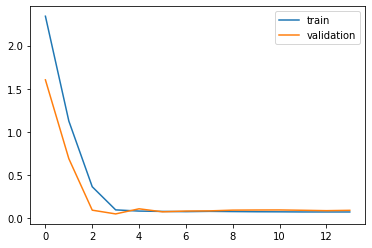


predict: [[26.57729419 17.2984174 ]]
real:      [[26.1 18.6]]

Train on 1390 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 1.5546 - mean_squared_error: 3.1349 - val_loss: 0.3362 - val_mean_squared_error: 0.1135
Epoch 2/1000
 - 1s - loss: 0.2039 - mean_squared_error: 0.0661 - val_loss: 0.0910 - val_mean_squared_error: 0.0083
Epoch 3/1000
 - 1s - loss: 0.0933 - mean_squared_error: 0.0141 - val_loss: 0.0505 - val_mean_squared_error: 0.0026
Epoch 4/1000
 - 1s - loss: 0.0815 - mean_squared_error: 0.0110 - val_loss: 0.0781 - val_mean_squared_error: 0.0065
Epoch 5/1000
 - 1s - loss: 0.0773 - mean_squared_error: 0.0100 - val_loss: 0.0685 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 1s - loss: 0.0751 - mean_squared_error: 0.0095 - val_loss: 0.0705 - val_mean_squared_error: 0.0057
Epoch 7/1000
 - 1s - loss: 0.0744 - mean_squared_error: 0.0094 - val_loss: 0.0825 - val_mean_squared_error: 0.0070
Epoch 8/1000
 - 1s - loss: 0.0752 - mean_squared_error: 0.0096 - val_loss: 0.0703 - v

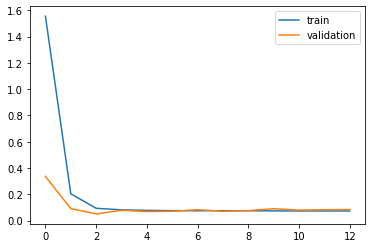


predict: [[27.87799211 17.86014674]]
real:      [[26.  18.7]]

Train on 1389 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.8681 - mean_squared_error: 8.4601 - val_loss: 2.3677 - val_mean_squared_error: 5.9391
Epoch 2/1000
 - 1s - loss: 1.6061 - mean_squared_error: 3.5229 - val_loss: 0.8782 - val_mean_squared_error: 1.4672
Epoch 3/1000
 - 1s - loss: 0.4462 - mean_squared_error: 0.4608 - val_loss: 0.1817 - val_mean_squared_error: 0.0330
Epoch 4/1000
 - 1s - loss: 0.1101 - mean_squared_error: 0.0195 - val_loss: 0.0903 - val_mean_squared_error: 0.0130
Epoch 5/1000
 - 1s - loss: 0.0814 - mean_squared_error: 0.0108 - val_loss: 0.0835 - val_mean_squared_error: 0.0130
Epoch 6/1000
 - 1s - loss: 0.0786 - mean_squared_error: 0.0102 - val_loss: 0.0891 - val_mean_squared_error: 0.0128
Epoch 7/1000
 - 1s - loss: 0.0782 - mean_squared_error: 0.0100 - val_loss: 0.1074 - val_mean_squared_error: 0.0174
Epoch 8/1000
 - 1s - loss: 0.0774 - mean_squared_error: 0.0099 - val_loss: 0.0924 - v

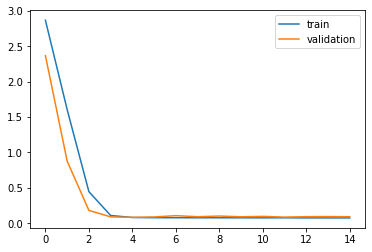


predict: [[27.53452478 16.90111318]]
real:      [[27.  18.6]]

Train on 1388 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.0659 - mean_squared_error: 4.8495 - val_loss: 0.9428 - val_mean_squared_error: 0.9805
Epoch 2/1000
 - 1s - loss: 0.3284 - mean_squared_error: 0.2008 - val_loss: 0.0156 - val_mean_squared_error: 3.4950e-04
Epoch 3/1000
 - 1s - loss: 0.0948 - mean_squared_error: 0.0152 - val_loss: 0.0456 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0795 - mean_squared_error: 0.0105 - val_loss: 0.0448 - val_mean_squared_error: 0.0032
Epoch 5/1000
 - 1s - loss: 0.0770 - mean_squared_error: 0.0099 - val_loss: 0.0463 - val_mean_squared_error: 0.0023
Epoch 6/1000
 - 1s - loss: 0.0756 - mean_squared_error: 0.0096 - val_loss: 0.0466 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 1s - loss: 0.0762 - mean_squared_error: 0.0097 - val_loss: 0.0267 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 1s - loss: 0.0760 - mean_squared_error: 0.0096 - val_loss: 0.0181

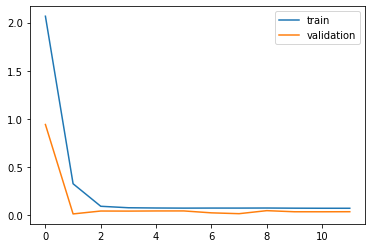


predict: [[26.85017385 16.27220708]]
real:      [[27.2 19.6]]

Train on 1387 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.1316 - mean_squared_error: 5.0677 - val_loss: 0.8194 - val_mean_squared_error: 0.8488
Epoch 2/1000
 - 1s - loss: 0.4007 - mean_squared_error: 0.2437 - val_loss: 0.1494 - val_mean_squared_error: 0.0231
Epoch 3/1000
 - 1s - loss: 0.1076 - mean_squared_error: 0.0182 - val_loss: 0.1022 - val_mean_squared_error: 0.0115
Epoch 4/1000
 - 1s - loss: 0.0816 - mean_squared_error: 0.0111 - val_loss: 0.0598 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 1s - loss: 0.0769 - mean_squared_error: 0.0102 - val_loss: 0.0840 - val_mean_squared_error: 0.0071
Epoch 6/1000
 - 1s - loss: 0.0759 - mean_squared_error: 0.0097 - val_loss: 0.0811 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 1s - loss: 0.0759 - mean_squared_error: 0.0096 - val_loss: 0.0869 - val_mean_squared_error: 0.0076
Epoch 8/1000
 - 1s - loss: 0.0754 - mean_squared_error: 0.0098 - val_loss: 0.0799 - v

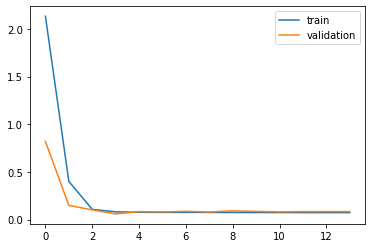


predict: [[25.98473664 16.80834704]]
real:      [[28.4 18.3]]

Train on 1386 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.7173 - mean_squared_error: 7.7693 - val_loss: 2.0540 - val_mean_squared_error: 4.4834
Epoch 2/1000
 - 1s - loss: 1.5018 - mean_squared_error: 2.7791 - val_loss: 0.6650 - val_mean_squared_error: 0.7935
Epoch 3/1000
 - 1s - loss: 0.3801 - mean_squared_error: 0.2888 - val_loss: 0.2259 - val_mean_squared_error: 0.0668
Epoch 4/1000
 - 1s - loss: 0.1033 - mean_squared_error: 0.0183 - val_loss: 0.0805 - val_mean_squared_error: 0.0109
Epoch 5/1000
 - 1s - loss: 0.0791 - mean_squared_error: 0.0105 - val_loss: 0.0609 - val_mean_squared_error: 0.0068
Epoch 6/1000
 - 1s - loss: 0.0769 - mean_squared_error: 0.0099 - val_loss: 0.0794 - val_mean_squared_error: 0.0070
Epoch 7/1000
 - 1s - loss: 0.0763 - mean_squared_error: 0.0097 - val_loss: 0.0638 - val_mean_squared_error: 0.0054
Epoch 8/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0097 - val_loss: 0.0597 - v

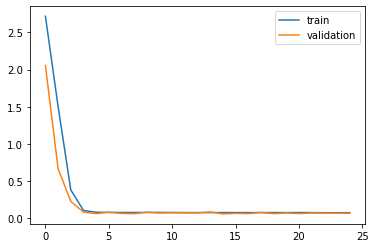


predict: [[28.02809628 17.28172031]]
real:      [[26.  18.5]]

Train on 1385 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.6682 - mean_squared_error: 7.4484 - val_loss: 1.8933 - val_mean_squared_error: 4.1170
Epoch 2/1000
 - 1s - loss: 1.2292 - mean_squared_error: 2.4653 - val_loss: 0.5187 - val_mean_squared_error: 0.3864
Epoch 3/1000
 - 1s - loss: 0.2268 - mean_squared_error: 0.1084 - val_loss: 0.0333 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.0950 - mean_squared_error: 0.0148 - val_loss: 0.0772 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0794 - mean_squared_error: 0.0103 - val_loss: 0.0760 - val_mean_squared_error: 0.0069
Epoch 6/1000
 - 1s - loss: 0.0762 - mean_squared_error: 0.0096 - val_loss: 0.0813 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 1s - loss: 0.0761 - mean_squared_error: 0.0097 - val_loss: 0.0912 - val_mean_squared_error: 0.0090
Epoch 8/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0097 - val_loss: 0.0901 - v

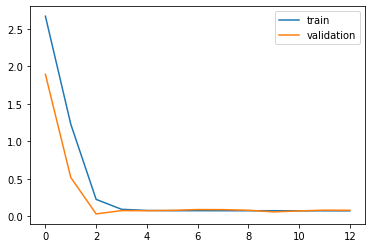


predict: [[25.62144415 17.10384529]]
real:      [[25.4 17.4]]

Train on 1384 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.3030 - mean_squared_error: 5.9045 - val_loss: 1.2392 - val_mean_squared_error: 1.9713
Epoch 2/1000
 - 1s - loss: 0.7801 - mean_squared_error: 0.9666 - val_loss: 0.3736 - val_mean_squared_error: 0.1718
Epoch 3/1000
 - 1s - loss: 0.1687 - mean_squared_error: 0.0540 - val_loss: 0.1211 - val_mean_squared_error: 0.0148
Epoch 4/1000
 - 1s - loss: 0.0864 - mean_squared_error: 0.0118 - val_loss: 0.1127 - val_mean_squared_error: 0.0150
Epoch 5/1000
 - 1s - loss: 0.0767 - mean_squared_error: 0.0099 - val_loss: 0.0972 - val_mean_squared_error: 0.0100
Epoch 6/1000
 - 1s - loss: 0.0764 - mean_squared_error: 0.0098 - val_loss: 0.0972 - val_mean_squared_error: 0.0097
Epoch 7/1000
 - 1s - loss: 0.0760 - mean_squared_error: 0.0098 - val_loss: 0.0923 - val_mean_squared_error: 0.0086
Epoch 8/1000
 - 1s - loss: 0.0752 - mean_squared_error: 0.0097 - val_loss: 0.0990 - v

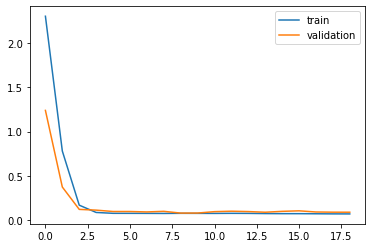


predict: [[27.91327888 17.42995601]]
real:      [[25.5 17.4]]

Train on 1383 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.6303 - mean_squared_error: 7.5134 - val_loss: 1.4722 - val_mean_squared_error: 2.5569
Epoch 2/1000
 - 1s - loss: 0.6640 - mean_squared_error: 0.8444 - val_loss: 0.2758 - val_mean_squared_error: 0.0783
Epoch 3/1000
 - 1s - loss: 0.1429 - mean_squared_error: 0.0337 - val_loss: 0.0528 - val_mean_squared_error: 0.0032
Epoch 4/1000
 - 1s - loss: 0.0835 - mean_squared_error: 0.0123 - val_loss: 0.0758 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0785 - mean_squared_error: 0.0106 - val_loss: 0.0844 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 1s - loss: 0.0768 - mean_squared_error: 0.0100 - val_loss: 0.0839 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 1s - loss: 0.0771 - mean_squared_error: 0.0102 - val_loss: 0.0720 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0097 - val_loss: 0.0758 - v

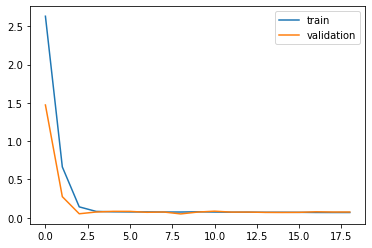


predict: [[26.80518439 16.82038382]]
real:      [[25.5 18.1]]

Train on 1382 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 1.9606 - mean_squared_error: 4.9077 - val_loss: 0.7519 - val_mean_squared_error: 0.8757
Epoch 2/1000
 - 1s - loss: 0.3516 - mean_squared_error: 0.2284 - val_loss: 0.1269 - val_mean_squared_error: 0.0185
Epoch 3/1000
 - 1s - loss: 0.1050 - mean_squared_error: 0.0181 - val_loss: 0.0974 - val_mean_squared_error: 0.0105
Epoch 4/1000
 - 1s - loss: 0.0793 - mean_squared_error: 0.0106 - val_loss: 0.0648 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.0761 - mean_squared_error: 0.0098 - val_loss: 0.0614 - val_mean_squared_error: 0.0074
Epoch 6/1000
 - 1s - loss: 0.0752 - mean_squared_error: 0.0097 - val_loss: 0.0843 - val_mean_squared_error: 0.0090
Epoch 7/1000
 - 1s - loss: 0.0746 - mean_squared_error: 0.0096 - val_loss: 0.0741 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 1s - loss: 0.0754 - mean_squared_error: 0.0096 - val_loss: 0.0686 - v

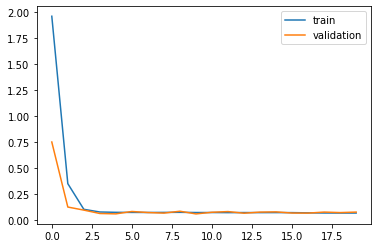


predict: [[28.08990972 17.24677952]]
real:      [[26.8 18.1]]

Train on 1381 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 3.1800 - mean_squared_error: 10.2145 - val_loss: 3.0814 - val_mean_squared_error: 9.5328
Epoch 2/1000
 - 1s - loss: 2.9475 - mean_squared_error: 8.8021 - val_loss: 2.6336 - val_mean_squared_error: 7.0850
Epoch 3/1000
 - 1s - loss: 2.2507 - mean_squared_error: 5.5192 - val_loss: 1.6067 - val_mean_squared_error: 3.1784
Epoch 4/1000
 - 1s - loss: 1.1319 - mean_squared_error: 1.9395 - val_loss: 0.8224 - val_mean_squared_error: 0.9862
Epoch 5/1000
 - 1s - loss: 0.6551 - mean_squared_error: 0.7412 - val_loss: 0.3799 - val_mean_squared_error: 0.2448
Epoch 6/1000
 - 1s - loss: 0.2289 - mean_squared_error: 0.1047 - val_loss: 0.0734 - val_mean_squared_error: 0.0076
Epoch 7/1000
 - 1s - loss: 0.0914 - mean_squared_error: 0.0135 - val_loss: 0.0478 - val_mean_squared_error: 0.0038
Epoch 8/1000
 - 1s - loss: 0.0793 - mean_squared_error: 0.0105 - val_loss: 0.0482 - 

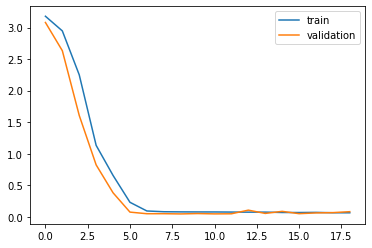


predict: [[27.61136772 16.64136047]]
real:      [[25.8 17.7]]

Train on 1380 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.2341 - mean_squared_error: 5.7841 - val_loss: 1.0695 - val_mean_squared_error: 2.1567
Epoch 2/1000
 - 1s - loss: 0.8193 - mean_squared_error: 1.1927 - val_loss: 0.4327 - val_mean_squared_error: 0.2875
Epoch 3/1000
 - 1s - loss: 0.2881 - mean_squared_error: 0.1375 - val_loss: 0.0465 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.0880 - mean_squared_error: 0.0135 - val_loss: 0.0187 - val_mean_squared_error: 3.5503e-04
Epoch 5/1000
 - 1s - loss: 0.0753 - mean_squared_error: 0.0097 - val_loss: 0.0477 - val_mean_squared_error: 0.0023
Epoch 6/1000
 - 1s - loss: 0.0747 - mean_squared_error: 0.0095 - val_loss: 0.0584 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 1s - loss: 0.0760 - mean_squared_error: 0.0097 - val_loss: 0.0574 - val_mean_squared_error: 0.0046
Epoch 8/1000
 - 1s - loss: 0.0775 - mean_squared_error: 0.0103 - val_loss: 0.0550

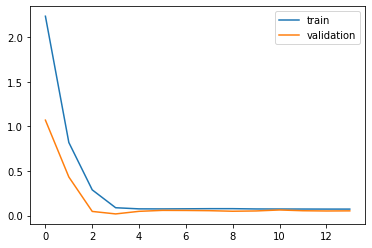


predict: [[26.95261112 17.45850863]]
real:      [[26.  17.3]]

Train and validation time: 19.186955428123476

Maximum metrics
Test RMSE -------------------------- 1.331
Test VARIANCE ---------------------- -0.3665
Test MAX-ERROR --------------------- 2.695
Test MEAN-ABSOLUTE-ERROR ----------- 1.057
Test MEDIAN-ABSOLUTE-ERROR --------- 0.7198

Errors
2018-03-31 = 0.2669019306349725
2018-03-30 = 0.3085923418755634
2018-03-29 = 2.2571432515934156
2018-03-28 = 0.11709899872714757
2018-03-27 = 0.6696823528126927
2018-03-26 = 0.16210481136402777
2018-03-25 = 0.6569633249974842
2018-03-24 = 0.38823533982714054
2018-03-23 = 0.19669424454073337
2018-03-22 = 0.6546737891374121
2018-03-21 = 0.41764416854556785
2018-03-20 = 0.8105707684846983
2018-03-19 = 2.6949866783250513
2018-03-14 = 0.7699264813279925
2018-03-13 = 2.130298529493583
2018-03-12 = 0.7999041692723168
2018-03-11 = 2.141952008645582
2018-03-10 = 0.591006544056448
2018-03-09 = 0.4772941855610924
2018-03-08 = 1.877992109134702
2018-0

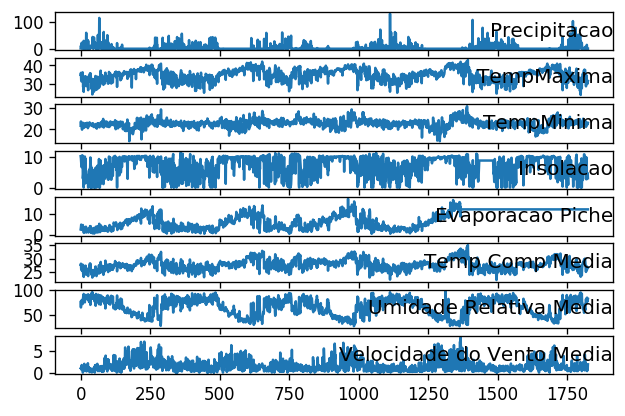

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.9328 - mean_squared_error: 5.7359 - val_loss: 0.6107 - val_mean_squared_error: 0.5606
Epoch 2/1000
 - 1s - loss: 0.2420 - mean_squared_error: 0.1280 - val_loss: 0.1161 - val_mean_squared_error: 0.0137
Epoch 3/1000
 - 1s - loss: 0.0819 - mean_squared_error: 0.0110 - val_loss: 0.0704 - val_mean_squared_error: 0.0055
Epoch 4/1000
 - 1s - loss: 0.0677 - mean_squared_error: 0.0078 - val_loss: 0.0430 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0069 - val_loss: 0.0079 - val_mean_squared_error: 1.0242e-04
Epoch 6/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0064 - val_loss: 0.0053 - val_mean_squared_error: 4.6686e-05
Epoch 7/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0062 - val_loss: 0.0110 - val_mean_squared_error: 1.9862e-04
Epoch 8/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0062 - val_loss: 0.0210 - val_mean_squared_error: 5.1273e-04
Epoch 9/1000
 - 1s

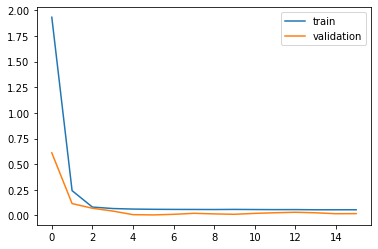


predict: [[32.94860441 22.38108755]]
real:      [[31.6 23.1]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.0967 - mean_squared_error: 5.3045 - val_loss: 0.5718 - val_mean_squared_error: 0.5615
Epoch 2/1000
 - 1s - loss: 0.2779 - mean_squared_error: 0.1546 - val_loss: 0.0849 - val_mean_squared_error: 0.0075
Epoch 3/1000
 - 1s - loss: 0.0853 - mean_squared_error: 0.0122 - val_loss: 0.0514 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0088 - val_loss: 0.0519 - val_mean_squared_error: 0.0032
Epoch 5/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0078 - val_loss: 0.0532 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0074 - val_loss: 0.0365 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0070 - val_loss: 0.0330 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0066 - val_loss: 0.0287 - v

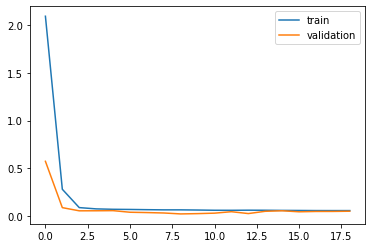


predict: [[33.01363698 22.44072127]]
real:      [[31.7 22.6]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.1183 - mean_squared_error: 4.9692 - val_loss: 0.7512 - val_mean_squared_error: 0.5644
Epoch 2/1000
 - 1s - loss: 0.2515 - mean_squared_error: 0.1027 - val_loss: 0.0632 - val_mean_squared_error: 0.0041
Epoch 3/1000
 - 1s - loss: 0.0880 - mean_squared_error: 0.0131 - val_loss: 0.0735 - val_mean_squared_error: 0.0090
Epoch 4/1000
 - 1s - loss: 0.0693 - mean_squared_error: 0.0083 - val_loss: 0.0244 - val_mean_squared_error: 6.6824e-04
Epoch 5/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0074 - val_loss: 0.0166 - val_mean_squared_error: 3.0818e-04
Epoch 6/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0071 - val_loss: 0.0192 - val_mean_squared_error: 7.0450e-04
Epoch 7/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0070 - val_loss: 0.0322 - val_mean_squared_error: 0.0020
Epoch 8/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss

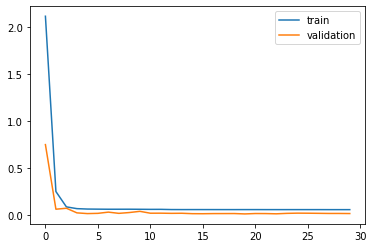


predict: [[33.56543897 22.63908863]]
real:      [[30.  22.8]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.7215 - mean_squared_error: 8.6655 - val_loss: 1.9632 - val_mean_squared_error: 6.9880
Epoch 2/1000
 - 1s - loss: 1.6206 - mean_squared_error: 4.9895 - val_loss: 1.0820 - val_mean_squared_error: 2.2111
Epoch 3/1000
 - 1s - loss: 0.5574 - mean_squared_error: 0.7653 - val_loss: 0.1637 - val_mean_squared_error: 0.0283
Epoch 4/1000
 - 1s - loss: 0.0999 - mean_squared_error: 0.0168 - val_loss: 0.0737 - val_mean_squared_error: 0.0055
Epoch 5/1000
 - 1s - loss: 0.0661 - mean_squared_error: 0.0076 - val_loss: 0.0446 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0072 - val_loss: 0.0374 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0072 - val_loss: 0.0385 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0070 - val_loss: 0.0540 - v

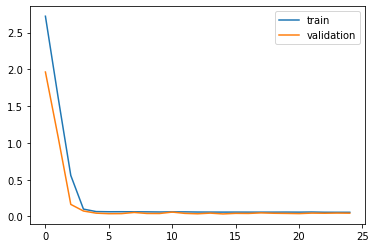


predict: [[32.69206868 22.81134627]]
real:      [[32. 22.]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.6874 - mean_squared_error: 3.8800 - val_loss: 0.4549 - val_mean_squared_error: 0.2120
Epoch 2/1000
 - 1s - loss: 0.2101 - mean_squared_error: 0.0776 - val_loss: 0.0814 - val_mean_squared_error: 0.0125
Epoch 3/1000
 - 1s - loss: 0.0767 - mean_squared_error: 0.0099 - val_loss: 0.0546 - val_mean_squared_error: 0.0045
Epoch 4/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0078 - val_loss: 0.0317 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0075 - val_loss: 0.0353 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0645 - mean_squared_error: 0.0073 - val_loss: 0.0408 - val_mean_squared_error: 0.0031
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0070 - val_loss: 0.0483 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0069 - val_loss: 0.0476 - val

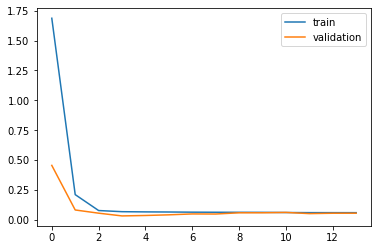


predict: [[35.53238506 23.41815237]]
real:      [[31. 22.]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.3799 - mean_squared_error: 6.3959 - val_loss: 1.3709 - val_mean_squared_error: 2.6868
Epoch 2/1000
 - 1s - loss: 0.7933 - mean_squared_error: 1.2316 - val_loss: 0.1086 - val_mean_squared_error: 0.0208
Epoch 3/1000
 - 1s - loss: 0.0926 - mean_squared_error: 0.0144 - val_loss: 0.0355 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0691 - mean_squared_error: 0.0082 - val_loss: 0.0268 - val_mean_squared_error: 7.2232e-04
Epoch 5/1000
 - 1s - loss: 0.0673 - mean_squared_error: 0.0079 - val_loss: 0.0231 - val_mean_squared_error: 5.4035e-04
Epoch 6/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0076 - val_loss: 0.0224 - val_mean_squared_error: 5.1099e-04
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss: 0.0142 - val_mean_squared_error: 3.0534e-04
Epoch 8/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0073 - val_lo

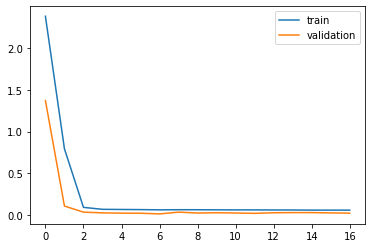


predict: [[35.38097152 22.51861162]]
real:      [[34.6 22.4]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.4726 - mean_squared_error: 6.5534 - val_loss: 0.9985 - val_mean_squared_error: 1.1866
Epoch 2/1000
 - 1s - loss: 0.4338 - mean_squared_error: 0.3438 - val_loss: 0.0329 - val_mean_squared_error: 0.0019
Epoch 3/1000
 - 1s - loss: 0.1110 - mean_squared_error: 0.0208 - val_loss: 0.1494 - val_mean_squared_error: 0.0253
Epoch 4/1000
 - 1s - loss: 0.0715 - mean_squared_error: 0.0087 - val_loss: 0.1205 - val_mean_squared_error: 0.0178
Epoch 5/1000
 - 1s - loss: 0.0657 - mean_squared_error: 0.0077 - val_loss: 0.1074 - val_mean_squared_error: 0.0139
Epoch 6/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0071 - val_loss: 0.0994 - val_mean_squared_error: 0.0108
Epoch 7/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0069 - val_loss: 0.1156 - val_mean_squared_error: 0.0139
Epoch 8/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0068 - val_loss: 0.1053 - v

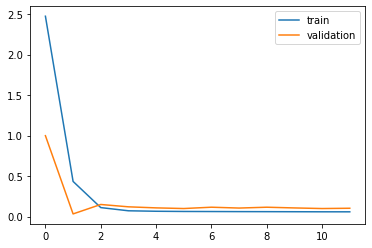


predict: [[27.64674531 22.52898736]]
real:      [[32.6 22.2]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.1278 - mean_squared_error: 5.4178 - val_loss: 0.4214 - val_mean_squared_error: 0.2828
Epoch 2/1000
 - 1s - loss: 0.2220 - mean_squared_error: 0.0793 - val_loss: 0.0315 - val_mean_squared_error: 0.0012
Epoch 3/1000
 - 1s - loss: 0.0844 - mean_squared_error: 0.0116 - val_loss: 0.0672 - val_mean_squared_error: 0.0085
Epoch 4/1000
 - 1s - loss: 0.0692 - mean_squared_error: 0.0080 - val_loss: 0.0394 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0665 - mean_squared_error: 0.0076 - val_loss: 0.0704 - val_mean_squared_error: 0.0071
Epoch 6/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0073 - val_loss: 0.0686 - val_mean_squared_error: 0.0083
Epoch 7/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0072 - val_loss: 0.0443 - val_mean_squared_error: 0.0037
Epoch 8/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0070 - val_loss: 0.0505 - v

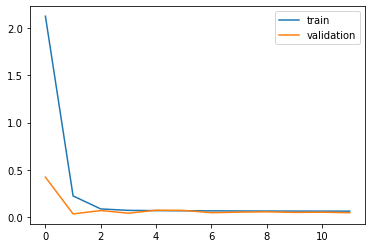


predict: [[39.82998051 21.62337146]]
real:      [[28.7 21.2]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.5994 - mean_squared_error: 3.3160 - val_loss: 0.5173 - val_mean_squared_error: 0.4921
Epoch 2/1000
 - 1s - loss: 0.1980 - mean_squared_error: 0.0692 - val_loss: 0.1108 - val_mean_squared_error: 0.0222
Epoch 3/1000
 - 1s - loss: 0.0814 - mean_squared_error: 0.0107 - val_loss: 0.0226 - val_mean_squared_error: 5.5027e-04
Epoch 4/1000
 - 1s - loss: 0.0673 - mean_squared_error: 0.0078 - val_loss: 0.0558 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0076 - val_loss: 0.0514 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.0601 - val_mean_squared_error: 0.0039
Epoch 7/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0074 - val_loss: 0.0465 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0067 - val_loss: 0.0552

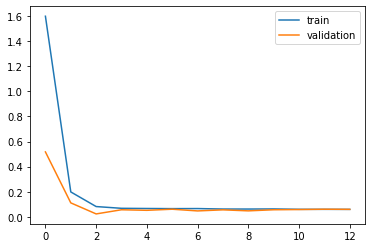


predict: [[36.3517827  24.11549517]]
real:      [[34.5 22.8]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.6049 - mean_squared_error: 7.4779 - val_loss: 1.8907 - val_mean_squared_error: 4.7383
Epoch 2/1000
 - 1s - loss: 1.0227 - mean_squared_error: 2.0854 - val_loss: 0.1109 - val_mean_squared_error: 0.0123
Epoch 3/1000
 - 1s - loss: 0.1237 - mean_squared_error: 0.0243 - val_loss: 0.0374 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0080 - val_loss: 0.0443 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0071 - val_loss: 0.0658 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0071 - val_loss: 0.0681 - val_mean_squared_error: 0.0088
Epoch 7/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0072 - val_loss: 0.0658 - val_mean_squared_error: 0.0071
Epoch 8/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0070 - val_loss: 0.0576 - v

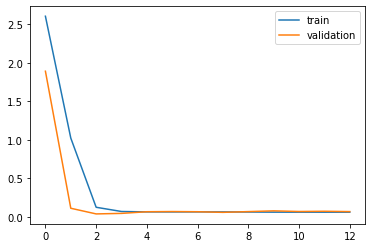


predict: [[37.36925065 22.24169107]]
real:      [[34.7 24. ]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.0749 - mean_squared_error: 4.9290 - val_loss: 0.6222 - val_mean_squared_error: 0.5801
Epoch 2/1000
 - 1s - loss: 0.2315 - mean_squared_error: 0.1060 - val_loss: 0.1331 - val_mean_squared_error: 0.0250
Epoch 3/1000
 - 1s - loss: 0.0871 - mean_squared_error: 0.0130 - val_loss: 0.0714 - val_mean_squared_error: 0.0056
Epoch 4/1000
 - 1s - loss: 0.0681 - mean_squared_error: 0.0080 - val_loss: 0.0928 - val_mean_squared_error: 0.0095
Epoch 5/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0073 - val_loss: 0.1016 - val_mean_squared_error: 0.0136
Epoch 6/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0069 - val_loss: 0.0712 - val_mean_squared_error: 0.0084
Epoch 7/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0066 - val_loss: 0.0911 - val_mean_squared_error: 0.0135
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0065 - val_loss: 0.0784 - v

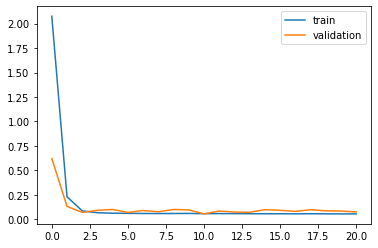


predict: [[34.22070302 23.40014654]]
real:      [[37.5 23.6]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.5991 - mean_squared_error: 3.5286 - val_loss: 0.5391 - val_mean_squared_error: 0.4230
Epoch 2/1000
 - 1s - loss: 0.1841 - mean_squared_error: 0.0726 - val_loss: 0.1029 - val_mean_squared_error: 0.0177
Epoch 3/1000
 - 1s - loss: 0.0779 - mean_squared_error: 0.0100 - val_loss: 0.0777 - val_mean_squared_error: 0.0082
Epoch 4/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0074 - val_loss: 0.0770 - val_mean_squared_error: 0.0073
Epoch 5/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0071 - val_loss: 0.0733 - val_mean_squared_error: 0.0090
Epoch 6/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0070 - val_loss: 0.0807 - val_mean_squared_error: 0.0104
Epoch 7/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0069 - val_loss: 0.0840 - val_mean_squared_error: 0.0105
Epoch 8/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0069 - val_loss: 0.0895 - v

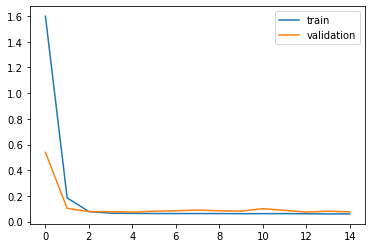


predict: [[36.94524355 22.9698015 ]]
real:      [[37.6 23.8]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.2448 - mean_squared_error: 2.4615 - val_loss: 0.1253 - val_mean_squared_error: 0.0276
Epoch 2/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0245 - val_loss: 0.1480 - val_mean_squared_error: 0.0231
Epoch 3/1000
 - 1s - loss: 0.0712 - mean_squared_error: 0.0085 - val_loss: 0.1086 - val_mean_squared_error: 0.0137
Epoch 4/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0073 - val_loss: 0.0842 - val_mean_squared_error: 0.0111
Epoch 5/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0068 - val_loss: 0.0971 - val_mean_squared_error: 0.0139
Epoch 6/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0068 - val_loss: 0.0898 - val_mean_squared_error: 0.0152
Epoch 7/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0066 - val_loss: 0.0761 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0063 - val_loss: 0.0933 - v

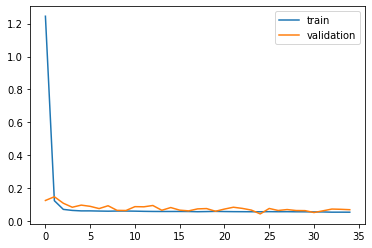


predict: [[34.02114676 23.11991858]]
real:      [[37.  23.4]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.3589 - mean_squared_error: 6.3681 - val_loss: 1.0054 - val_mean_squared_error: 1.3759
Epoch 2/1000
 - 1s - loss: 0.4185 - mean_squared_error: 0.3436 - val_loss: 0.1147 - val_mean_squared_error: 0.0144
Epoch 3/1000
 - 1s - loss: 0.0896 - mean_squared_error: 0.0128 - val_loss: 0.0610 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 1s - loss: 0.0706 - mean_squared_error: 0.0086 - val_loss: 0.0609 - val_mean_squared_error: 0.0061
Epoch 5/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0080 - val_loss: 0.0463 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0077 - val_loss: 0.0581 - val_mean_squared_error: 0.0059
Epoch 7/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0072 - val_loss: 0.0616 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0070 - val_loss: 0.0839 - v

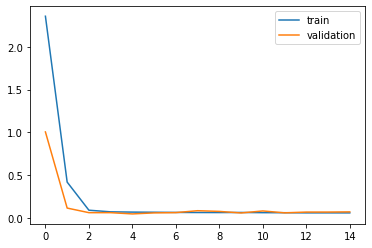


predict: [[37.47057874 23.13395997]]
real:      [[37.7 23.4]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.9066 - mean_squared_error: 8.9964 - val_loss: 2.2033 - val_mean_squared_error: 5.8953
Epoch 2/1000
 - 1s - loss: 1.4362 - mean_squared_error: 3.3892 - val_loss: 0.8419 - val_mean_squared_error: 1.1772
Epoch 3/1000
 - 1s - loss: 0.3280 - mean_squared_error: 0.2759 - val_loss: 0.0640 - val_mean_squared_error: 0.0066
Epoch 4/1000
 - 1s - loss: 0.0823 - mean_squared_error: 0.0115 - val_loss: 0.0286 - val_mean_squared_error: 9.3108e-04
Epoch 5/1000
 - 1s - loss: 0.0690 - mean_squared_error: 0.0082 - val_loss: 0.0496 - val_mean_squared_error: 0.0041
Epoch 6/1000
 - 1s - loss: 0.0667 - mean_squared_error: 0.0077 - val_loss: 0.0488 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0073 - val_loss: 0.0765 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0072 - val_loss: 0.0688

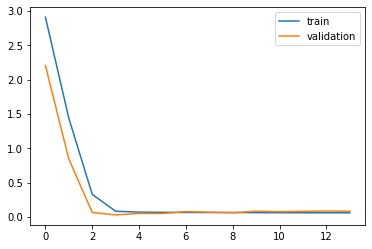


predict: [[36.36465316 23.34042801]]
real:      [[37.2 22.7]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.5268 - mean_squared_error: 3.1625 - val_loss: 0.5132 - val_mean_squared_error: 0.3677
Epoch 2/1000
 - 1s - loss: 0.1935 - mean_squared_error: 0.0767 - val_loss: 0.0633 - val_mean_squared_error: 0.0041
Epoch 3/1000
 - 1s - loss: 0.0826 - mean_squared_error: 0.0111 - val_loss: 0.0377 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0698 - mean_squared_error: 0.0082 - val_loss: 0.0557 - val_mean_squared_error: 0.0038
Epoch 5/1000
 - 1s - loss: 0.0662 - mean_squared_error: 0.0076 - val_loss: 0.0543 - val_mean_squared_error: 0.0034
Epoch 6/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0073 - val_loss: 0.0713 - val_mean_squared_error: 0.0060
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0071 - val_loss: 0.0726 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0069 - val_loss: 0.0446 - v

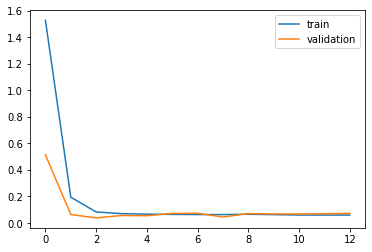


predict: [[34.57139438 23.16188294]]
real:      [[37.2 22.7]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.7039 - mean_squared_error: 8.5985 - val_loss: 2.0642 - val_mean_squared_error: 7.8196
Epoch 2/1000
 - 1s - loss: 1.5129 - mean_squared_error: 4.3900 - val_loss: 0.8590 - val_mean_squared_error: 1.2980
Epoch 3/1000
 - 1s - loss: 0.3531 - mean_squared_error: 0.3172 - val_loss: 0.0563 - val_mean_squared_error: 0.0062
Epoch 4/1000
 - 1s - loss: 0.0875 - mean_squared_error: 0.0121 - val_loss: 0.0598 - val_mean_squared_error: 0.0055
Epoch 5/1000
 - 1s - loss: 0.0674 - mean_squared_error: 0.0077 - val_loss: 0.0318 - val_mean_squared_error: 0.0010
Epoch 6/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0072 - val_loss: 0.0393 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0069 - val_loss: 0.0534 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0065 - val_loss: 0.0511 - v

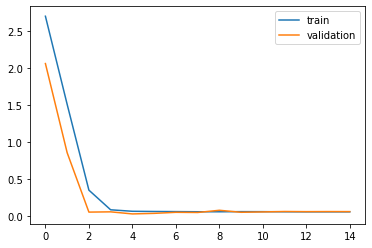


predict: [[34.71377574 23.37037938]]
real:      [[35.6 22.9]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.7427 - mean_squared_error: 7.7858 - val_loss: 1.9552 - val_mean_squared_error: 3.9349
Epoch 2/1000
 - 1s - loss: 1.1187 - mean_squared_error: 1.7848 - val_loss: 0.3637 - val_mean_squared_error: 0.1750
Epoch 3/1000
 - 1s - loss: 0.1496 - mean_squared_error: 0.0353 - val_loss: 0.1052 - val_mean_squared_error: 0.0114
Epoch 4/1000
 - 1s - loss: 0.0730 - mean_squared_error: 0.0088 - val_loss: 0.0335 - val_mean_squared_error: 0.0011
Epoch 5/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0074 - val_loss: 0.0638 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0071 - val_loss: 0.0693 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0073 - val_loss: 0.0735 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0072 - val_loss: 0.0662 - v

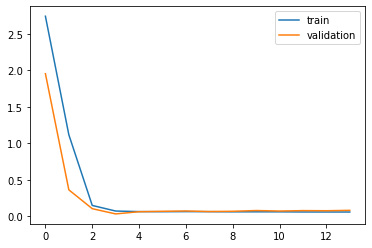


predict: [[35.95136874 22.86815053]]
real:      [[34.1 25. ]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.1901 - mean_squared_error: 5.7987 - val_loss: 0.7721 - val_mean_squared_error: 1.1721
Epoch 2/1000
 - 1s - loss: 0.3171 - mean_squared_error: 0.2262 - val_loss: 0.1152 - val_mean_squared_error: 0.0169
Epoch 3/1000
 - 1s - loss: 0.0811 - mean_squared_error: 0.0108 - val_loss: 0.1035 - val_mean_squared_error: 0.0117
Epoch 4/1000
 - 1s - loss: 0.0657 - mean_squared_error: 0.0075 - val_loss: 0.0821 - val_mean_squared_error: 0.0075
Epoch 5/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0070 - val_loss: 0.0733 - val_mean_squared_error: 0.0065
Epoch 6/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0070 - val_loss: 0.0723 - val_mean_squared_error: 0.0067
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0069 - val_loss: 0.0593 - val_mean_squared_error: 0.0039
Epoch 8/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss: 0.0831 - v

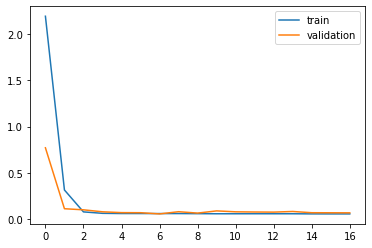


predict: [[35.7451955  23.70382415]]
real:      [[35.4 24.2]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.5823 - mean_squared_error: 3.4907 - val_loss: 0.2788 - val_mean_squared_error: 0.1390
Epoch 2/1000
 - 1s - loss: 0.1657 - mean_squared_error: 0.0431 - val_loss: 0.0717 - val_mean_squared_error: 0.0055
Epoch 3/1000
 - 1s - loss: 0.0817 - mean_squared_error: 0.0108 - val_loss: 0.0534 - val_mean_squared_error: 0.0029
Epoch 4/1000
 - 1s - loss: 0.0701 - mean_squared_error: 0.0084 - val_loss: 0.0551 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 1s - loss: 0.0670 - mean_squared_error: 0.0078 - val_loss: 0.0576 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0655 - mean_squared_error: 0.0074 - val_loss: 0.0478 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0072 - val_loss: 0.0325 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0071 - val_loss: 0.0429 - v

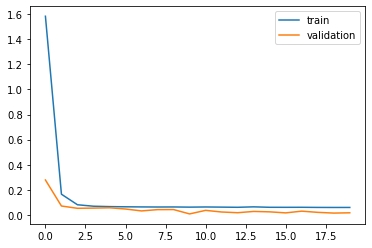


predict: [[35.07210279 23.0757654 ]]
real:      [[35.4 24. ]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.7277 - mean_squared_error: 3.8430 - val_loss: 0.2845 - val_mean_squared_error: 0.0817
Epoch 2/1000
 - 1s - loss: 0.1925 - mean_squared_error: 0.0630 - val_loss: 0.1442 - val_mean_squared_error: 0.0244
Epoch 3/1000
 - 1s - loss: 0.0823 - mean_squared_error: 0.0110 - val_loss: 0.0528 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 1s - loss: 0.0690 - mean_squared_error: 0.0082 - val_loss: 0.0395 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 1s - loss: 0.0673 - mean_squared_error: 0.0079 - val_loss: 0.0408 - val_mean_squared_error: 0.0018
Epoch 6/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0075 - val_loss: 0.0422 - val_mean_squared_error: 0.0024
Epoch 7/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0072 - val_loss: 0.0530 - val_mean_squared_error: 0.0041
Epoch 8/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0069 - val_loss: 0.0400 - v

Epoch 69/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0056 - val_loss: 0.0326 - val_mean_squared_error: 0.0021

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 70/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0056 - val_loss: 0.0326 - val_mean_squared_error: 0.0021
Epoch 71/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0056 - val_loss: 0.0326 - val_mean_squared_error: 0.0021
Epoch 72/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0056 - val_loss: 0.0326 - val_mean_squared_error: 0.0021


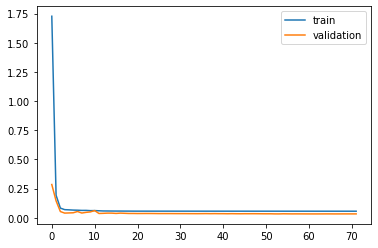


predict: [[32.85251136 22.46771907]]
real:      [[32.4 23.9]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.8051 - mean_squared_error: 4.2203 - val_loss: 0.7875 - val_mean_squared_error: 0.9089
Epoch 2/1000
 - 1s - loss: 0.2610 - mean_squared_error: 0.1590 - val_loss: 0.1294 - val_mean_squared_error: 0.0170
Epoch 3/1000
 - 1s - loss: 0.0830 - mean_squared_error: 0.0113 - val_loss: 0.0844 - val_mean_squared_error: 0.0108
Epoch 4/1000
 - 1s - loss: 0.0678 - mean_squared_error: 0.0080 - val_loss: 0.0809 - val_mean_squared_error: 0.0118
Epoch 5/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0076 - val_loss: 0.0879 - val_mean_squared_error: 0.0139
Epoch 6/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.0929 - val_mean_squared_error: 0.0130
Epoch 7/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0071 - val_loss: 0.0854 - val_mean_squared_error: 0.0131
Epoch 8/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0071 - val_loss: 0.0780 - v

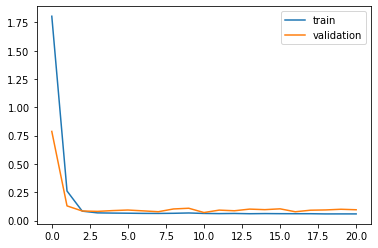


predict: [[30.56842769 22.29781402]]
real:      [[32.6 21.3]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.1205 - mean_squared_error: 2.0075 - val_loss: 0.2062 - val_mean_squared_error: 0.0601
Epoch 2/1000
 - 1s - loss: 0.1170 - mean_squared_error: 0.0230 - val_loss: 0.0313 - val_mean_squared_error: 0.0017
Epoch 3/1000
 - 1s - loss: 0.0690 - mean_squared_error: 0.0080 - val_loss: 0.0560 - val_mean_squared_error: 0.0032
Epoch 4/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0073 - val_loss: 0.0392 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0072 - val_loss: 0.0392 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0067 - val_loss: 0.0221 - val_mean_squared_error: 6.6429e-04
Epoch 7/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0065 - val_loss: 0.0319 - val_mean_squared_error: 0.0010
Epoch 8/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0070 - val_loss: 0.0231

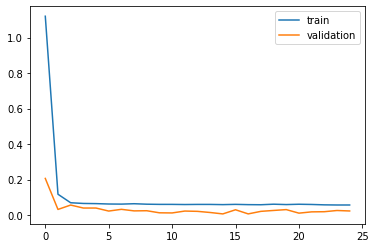


predict: [[31.68549247 21.56841045]]
real:      [[27.6 22.5]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.7105 - mean_squared_error: 7.5077 - val_loss: 1.9336 - val_mean_squared_error: 3.7609
Epoch 2/1000
 - 1s - loss: 1.1732 - mean_squared_error: 1.6937 - val_loss: 0.3175 - val_mean_squared_error: 0.1049
Epoch 3/1000
 - 1s - loss: 0.1102 - mean_squared_error: 0.0210 - val_loss: 0.0848 - val_mean_squared_error: 0.0125
Epoch 4/1000
 - 1s - loss: 0.0692 - mean_squared_error: 0.0081 - val_loss: 0.0723 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0073 - val_loss: 0.0778 - val_mean_squared_error: 0.0103
Epoch 6/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0076 - val_loss: 0.0643 - val_mean_squared_error: 0.0049
Epoch 7/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0072 - val_loss: 0.0560 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0071 - val_loss: 0.0795 - v

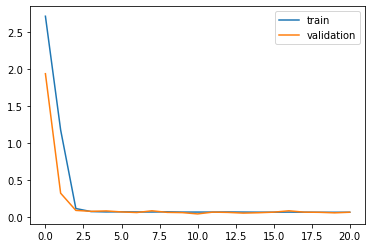


predict: [[32.7613264 22.143481 ]]
real:      [[33.6 22.3]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.5382 - mean_squared_error: 6.7385 - val_loss: 1.5259 - val_mean_squared_error: 2.3610
Epoch 2/1000
 - 1s - loss: 0.6888 - mean_squared_error: 0.7894 - val_loss: 0.2931 - val_mean_squared_error: 0.1446
Epoch 3/1000
 - 1s - loss: 0.1038 - mean_squared_error: 0.0190 - val_loss: 0.1130 - val_mean_squared_error: 0.0163
Epoch 4/1000
 - 1s - loss: 0.0724 - mean_squared_error: 0.0087 - val_loss: 0.1206 - val_mean_squared_error: 0.0166
Epoch 5/1000
 - 1s - loss: 0.0667 - mean_squared_error: 0.0077 - val_loss: 0.1019 - val_mean_squared_error: 0.0112
Epoch 6/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0075 - val_loss: 0.1021 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0074 - val_loss: 0.1093 - val_mean_squared_error: 0.0130
Epoch 8/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0073 - val_loss: 0.1025 - val

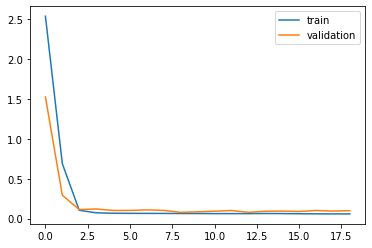


predict: [[32.13452469 22.87338077]]
real:      [[30.2 22.4]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.6827 - mean_squared_error: 8.2446 - val_loss: 1.6917 - val_mean_squared_error: 4.7174
Epoch 2/1000
 - 1s - loss: 1.2842 - mean_squared_error: 3.0564 - val_loss: 0.8790 - val_mean_squared_error: 1.0217
Epoch 3/1000
 - 1s - loss: 0.2790 - mean_squared_error: 0.2068 - val_loss: 0.2222 - val_mean_squared_error: 0.0541
Epoch 4/1000
 - 1s - loss: 0.0813 - mean_squared_error: 0.0110 - val_loss: 0.1851 - val_mean_squared_error: 0.0486
Epoch 5/1000
 - 1s - loss: 0.0674 - mean_squared_error: 0.0077 - val_loss: 0.1382 - val_mean_squared_error: 0.0366
Epoch 6/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0072 - val_loss: 0.1431 - val_mean_squared_error: 0.0389
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss: 0.1636 - val_mean_squared_error: 0.0476
Epoch 8/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0068 - val_loss: 0.1619 - v

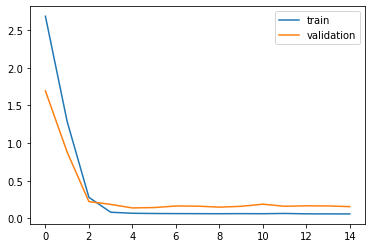


predict: [[30.93363246 22.50613314]]
real:      [[28.9 21.5]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.2600 - mean_squared_error: 5.7634 - val_loss: 0.6336 - val_mean_squared_error: 0.4836
Epoch 2/1000
 - 1s - loss: 0.2298 - mean_squared_error: 0.0875 - val_loss: 0.0493 - val_mean_squared_error: 0.0027
Epoch 3/1000
 - 1s - loss: 0.0861 - mean_squared_error: 0.0123 - val_loss: 0.0265 - val_mean_squared_error: 7.4133e-04
Epoch 4/1000
 - 1s - loss: 0.0750 - mean_squared_error: 0.0095 - val_loss: 0.0391 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0726 - mean_squared_error: 0.0089 - val_loss: 0.0138 - val_mean_squared_error: 2.8908e-04
Epoch 6/1000
 - 1s - loss: 0.0686 - mean_squared_error: 0.0081 - val_loss: 0.0209 - val_mean_squared_error: 7.0088e-04
Epoch 7/1000
 - 1s - loss: 0.0669 - mean_squared_error: 0.0077 - val_loss: 0.0322 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0074 - val_loss

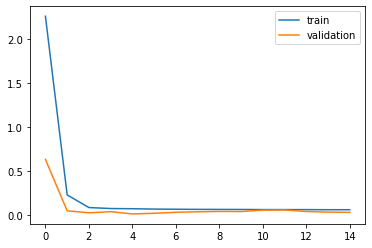


predict: [[34.98611684 24.3160031 ]]
real:      [[24.  22.5]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.1404 - mean_squared_error: 5.1986 - val_loss: 0.6352 - val_mean_squared_error: 0.5516
Epoch 2/1000
 - 1s - loss: 0.2957 - mean_squared_error: 0.1765 - val_loss: 0.0847 - val_mean_squared_error: 0.0082
Epoch 3/1000
 - 1s - loss: 0.0888 - mean_squared_error: 0.0130 - val_loss: 0.1412 - val_mean_squared_error: 0.0231
Epoch 4/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0076 - val_loss: 0.1416 - val_mean_squared_error: 0.0268
Epoch 5/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0072 - val_loss: 0.1417 - val_mean_squared_error: 0.0213
Epoch 6/1000
 - 1s - loss: 0.0647 - mean_squared_error: 0.0072 - val_loss: 0.1227 - val_mean_squared_error: 0.0174
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss: 0.1358 - val_mean_squared_error: 0.0186
Epoch 8/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0074 - val_loss: 0.1164 - v

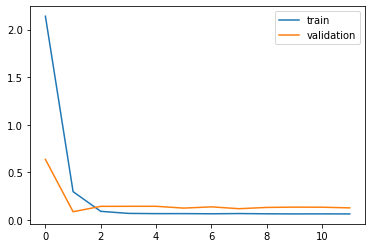


predict: [[31.44943919 21.18480673]]
real:      [[32.6 21.6]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.8146 - mean_squared_error: 4.2613 - val_loss: 0.4681 - val_mean_squared_error: 0.2239
Epoch 2/1000
 - 1s - loss: 0.1548 - mean_squared_error: 0.0355 - val_loss: 0.2745 - val_mean_squared_error: 0.0801
Epoch 3/1000
 - 1s - loss: 0.0742 - mean_squared_error: 0.0091 - val_loss: 0.1665 - val_mean_squared_error: 0.0350
Epoch 4/1000
 - 1s - loss: 0.0678 - mean_squared_error: 0.0079 - val_loss: 0.1710 - val_mean_squared_error: 0.0321
Epoch 5/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0074 - val_loss: 0.1555 - val_mean_squared_error: 0.0271
Epoch 6/1000
 - 1s - loss: 0.0645 - mean_squared_error: 0.0072 - val_loss: 0.1395 - val_mean_squared_error: 0.0230
Epoch 7/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0070 - val_loss: 0.1578 - val_mean_squared_error: 0.0314
Epoch 8/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0069 - val_loss: 0.1337 - v

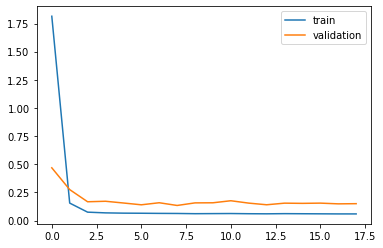


predict: [[31.19566443 22.53502422]]
real:      [[27.2 20.9]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.1775 - mean_squared_error: 5.5355 - val_loss: 0.4978 - val_mean_squared_error: 0.3680
Epoch 2/1000
 - 1s - loss: 0.2137 - mean_squared_error: 0.0901 - val_loss: 0.0223 - val_mean_squared_error: 5.7927e-04
Epoch 3/1000
 - 1s - loss: 0.0782 - mean_squared_error: 0.0103 - val_loss: 0.0776 - val_mean_squared_error: 0.0082
Epoch 4/1000
 - 1s - loss: 0.0704 - mean_squared_error: 0.0085 - val_loss: 0.0653 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 1s - loss: 0.0680 - mean_squared_error: 0.0079 - val_loss: 0.0385 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0688 - mean_squared_error: 0.0080 - val_loss: 0.0404 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 1s - loss: 0.0662 - mean_squared_error: 0.0075 - val_loss: 0.0292 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0074 - val_loss: 0.0276

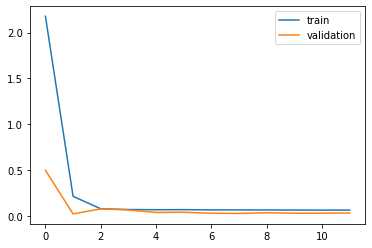


predict: [[30.19002355 22.48917504]]
real:      [[26.3 24.8]]

Train and validation time: 25.32427402337392

Maximum metrics
Test RMSE -------------------------- 3.705
Test VARIANCE ---------------------- 0.05976
Test MAX-ERROR --------------------- 11.13
Test MEAN-ABSOLUTE-ERROR ----------- 2.608
Test MEDIAN-ABSOLUTE-ERROR --------- 1.893

Errors
2018-12-31 = 1.3486044083738733
2018-12-30 = 1.3136369793456737
2018-12-29 = 3.5654389673925806
2018-12-28 = 0.6920686760959356
2018-12-27 = 4.532385059362255
2018-12-26 = 0.7809715178319578
2018-12-25 = 4.953254689604243
2018-12-24 = 11.129980505820239
2018-12-23 = 1.8517827001902916
2018-12-22 = 2.6692506450647926
2018-12-21 = 3.2792969787975608
2018-12-20 = 0.6547564542260957
2018-12-19 = 2.978853241314198
2018-12-18 = 0.22942125616170728
2018-12-17 = 0.8353468392098904
2018-12-16 = 2.6286056203651498
2018-12-15 = 0.8862242577960586
2018-12-14 = 1.85136874013984
2018-12-13 = 0.34519550405090627
2018-12-12 = 0.32789721158463436
2018-12-11 

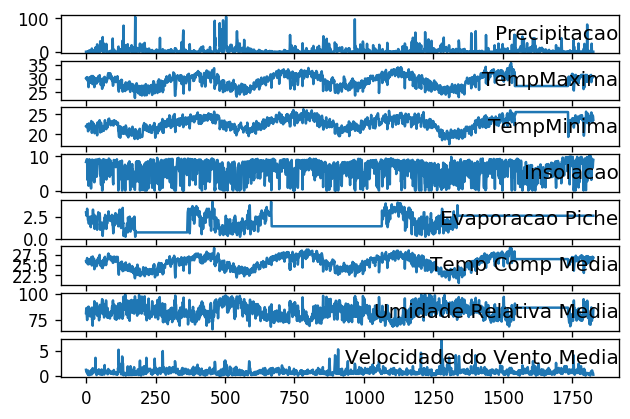

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.6145 - mean_squared_error: 3.4270 - val_loss: 0.3612 - val_mean_squared_error: 0.1347
Epoch 2/1000
 - 1s - loss: 0.1501 - mean_squared_error: 0.0352 - val_loss: 0.0539 - val_mean_squared_error: 0.0054
Epoch 3/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0067 - val_loss: 0.0715 - val_mean_squared_error: 0.0051
Epoch 4/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0056 - val_loss: 0.0789 - val_mean_squared_error: 0.0065
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0056 - val_loss: 0.0758 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0054 - val_loss: 0.0760 - val_mean_squared_error: 0.0061
Epoch 7/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0053 - val_loss: 0.0581 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0052 - val_loss: 0.0498 - val_mean_squared_error: 0.0025
Epoch 9/1000
 - 1s - loss: 0.0591 

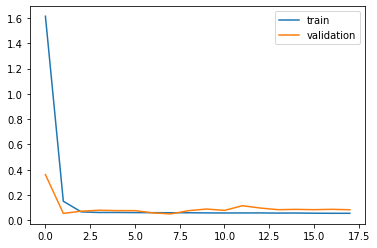


predict: [[30.33019171 23.92422199]]
real:      [[30.7 23.6]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.2190 - mean_squared_error: 5.4957 - val_loss: 0.9539 - val_mean_squared_error: 1.1718
Epoch 2/1000
 - 1s - loss: 0.3701 - mean_squared_error: 0.2675 - val_loss: 0.1804 - val_mean_squared_error: 0.0577
Epoch 3/1000
 - 1s - loss: 0.0822 - mean_squared_error: 0.0106 - val_loss: 0.1192 - val_mean_squared_error: 0.0176
Epoch 4/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0063 - val_loss: 0.1097 - val_mean_squared_error: 0.0127
Epoch 5/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0060 - val_loss: 0.1229 - val_mean_squared_error: 0.0155
Epoch 6/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0060 - val_loss: 0.1250 - val_mean_squared_error: 0.0159
Epoch 7/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0059 - val_loss: 0.1148 - val_mean_squared_error: 0.0132
Epoch 8/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0062 - val_loss: 0.1498 - v

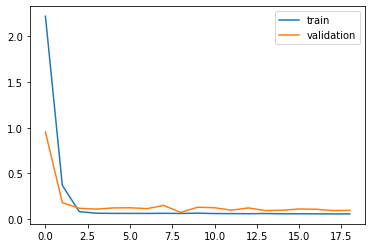


predict: [[30.28606941 24.27066053]]
real:      [[30.8 24.4]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.8061 - mean_squared_error: 3.7975 - val_loss: 0.5192 - val_mean_squared_error: 0.2697
Epoch 2/1000
 - 1s - loss: 0.1718 - mean_squared_error: 0.0427 - val_loss: 0.1251 - val_mean_squared_error: 0.0157
Epoch 3/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0073 - val_loss: 0.0851 - val_mean_squared_error: 0.0073
Epoch 4/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0056 - val_loss: 0.0992 - val_mean_squared_error: 0.0099
Epoch 5/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0056 - val_loss: 0.1047 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0058 - val_loss: 0.0739 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0055 - val_loss: 0.0804 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0055 - val_loss: 0.0688 - v

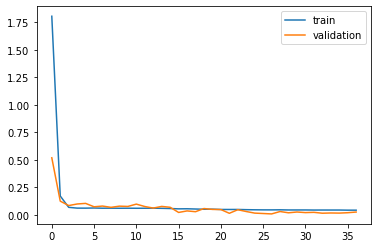


predict: [[30.76798872 23.77491071]]
real:      [[30.6 24.7]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.6832 - mean_squared_error: 3.7885 - val_loss: 0.7869 - val_mean_squared_error: 1.0941
Epoch 2/1000
 - 1s - loss: 0.3236 - mean_squared_error: 0.2561 - val_loss: 0.1097 - val_mean_squared_error: 0.0163
Epoch 3/1000
 - 1s - loss: 0.0760 - mean_squared_error: 0.0089 - val_loss: 0.1046 - val_mean_squared_error: 0.0122
Epoch 4/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0061 - val_loss: 0.1238 - val_mean_squared_error: 0.0169
Epoch 5/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0061 - val_loss: 0.1185 - val_mean_squared_error: 0.0165
Epoch 6/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0057 - val_loss: 0.0930 - val_mean_squared_error: 0.0100
Epoch 7/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0056 - val_loss: 0.0959 - val_mean_squared_error: 0.0110
Epoch 8/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0054 - val_loss: 0.0787 - v

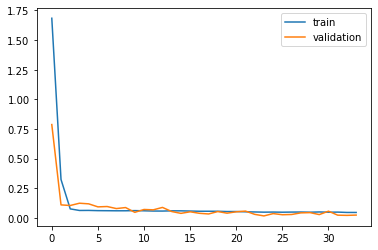


predict: [[31.0407443  23.14678325]]
real:      [[30.6 23.9]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.0450 - mean_squared_error: 4.7279 - val_loss: 0.6508 - val_mean_squared_error: 0.4693
Epoch 2/1000
 - 1s - loss: 0.2038 - mean_squared_error: 0.0679 - val_loss: 0.0319 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 1s - loss: 0.0739 - mean_squared_error: 0.0085 - val_loss: 0.0865 - val_mean_squared_error: 0.0075
Epoch 4/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0059 - val_loss: 0.0751 - val_mean_squared_error: 0.0061
Epoch 5/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0057 - val_loss: 0.0860 - val_mean_squared_error: 0.0074
Epoch 6/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0057 - val_loss: 0.0994 - val_mean_squared_error: 0.0099
Epoch 7/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0057 - val_loss: 0.0661 - val_mean_squared_error: 0.0044
Epoch 8/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0056 - val_loss: 0.0952 - v

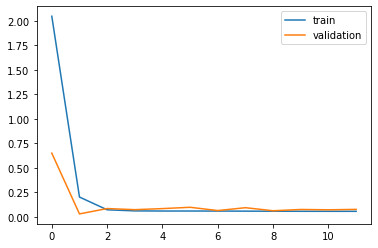


predict: [[30.14387099 24.00980839]]
real:      [[30.2 23. ]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.2446 - mean_squared_error: 5.9281 - val_loss: 0.7541 - val_mean_squared_error: 1.1169
Epoch 2/1000
 - 1s - loss: 0.3229 - mean_squared_error: 0.2452 - val_loss: 0.0838 - val_mean_squared_error: 0.0078
Epoch 3/1000
 - 1s - loss: 0.0838 - mean_squared_error: 0.0110 - val_loss: 0.0870 - val_mean_squared_error: 0.0076
Epoch 4/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0064 - val_loss: 0.0654 - val_mean_squared_error: 0.0048
Epoch 5/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0059 - val_loss: 0.0873 - val_mean_squared_error: 0.0076
Epoch 6/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0057 - val_loss: 0.0829 - val_mean_squared_error: 0.0071
Epoch 7/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0056 - val_loss: 0.0968 - val_mean_squared_error: 0.0095
Epoch 8/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0055 - val_loss: 0.0757 - v

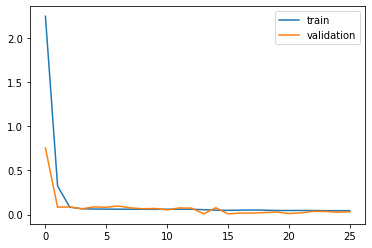


predict: [[32.23635238 23.61002422]]
real:      [[30.1 23.5]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.2734 - mean_squared_error: 5.8510 - val_loss: 1.1879 - val_mean_squared_error: 2.3586
Epoch 2/1000
 - 1s - loss: 0.4344 - mean_squared_error: 0.5079 - val_loss: 0.0923 - val_mean_squared_error: 0.0093
Epoch 3/1000
 - 1s - loss: 0.0890 - mean_squared_error: 0.0130 - val_loss: 0.1172 - val_mean_squared_error: 0.0143
Epoch 4/1000
 - 1s - loss: 0.0676 - mean_squared_error: 0.0069 - val_loss: 0.0942 - val_mean_squared_error: 0.0101
Epoch 5/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0059 - val_loss: 0.1056 - val_mean_squared_error: 0.0114
Epoch 6/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0057 - val_loss: 0.1067 - val_mean_squared_error: 0.0128
Epoch 7/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0056 - val_loss: 0.0999 - val_mean_squared_error: 0.0103
Epoch 8/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0057 - val_loss: 0.0945 - v

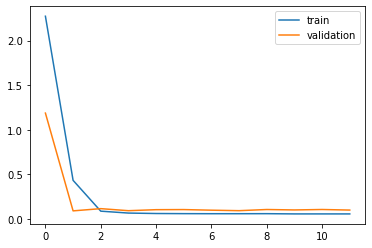


predict: [[27.31975852 22.24820849]]
real:      [[29.8 23.6]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.1949 - mean_squared_error: 5.0938 - val_loss: 1.3304 - val_mean_squared_error: 1.9832
Epoch 2/1000
 - 1s - loss: 0.5489 - mean_squared_error: 0.5618 - val_loss: 0.1226 - val_mean_squared_error: 0.0159
Epoch 3/1000
 - 1s - loss: 0.1081 - mean_squared_error: 0.0188 - val_loss: 0.0525 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.0693 - mean_squared_error: 0.0072 - val_loss: 0.0865 - val_mean_squared_error: 0.0075
Epoch 5/1000
 - 1s - loss: 0.0647 - mean_squared_error: 0.0062 - val_loss: 0.1061 - val_mean_squared_error: 0.0115
Epoch 6/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0060 - val_loss: 0.1120 - val_mean_squared_error: 0.0126
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0059 - val_loss: 0.0755 - val_mean_squared_error: 0.0057
Epoch 8/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0059 - val_loss: 0.0982 - v

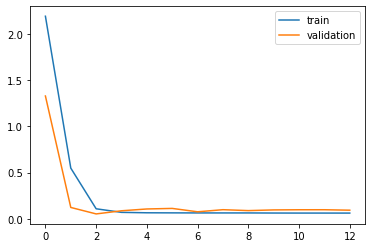


predict: [[29.10817111 24.47343967]]
real:      [[28.7 25.4]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.8828 - mean_squared_error: 4.1378 - val_loss: 0.3364 - val_mean_squared_error: 0.1165
Epoch 2/1000
 - 1s - loss: 0.1673 - mean_squared_error: 0.0419 - val_loss: 0.0184 - val_mean_squared_error: 3.4302e-04
Epoch 3/1000
 - 1s - loss: 0.0739 - mean_squared_error: 0.0084 - val_loss: 0.1059 - val_mean_squared_error: 0.0113
Epoch 4/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0061 - val_loss: 0.0562 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0056 - val_loss: 0.0785 - val_mean_squared_error: 0.0070
Epoch 6/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0056 - val_loss: 0.0825 - val_mean_squared_error: 0.0077
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0054 - val_loss: 0.0662 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0053 - val_loss: 0.0777

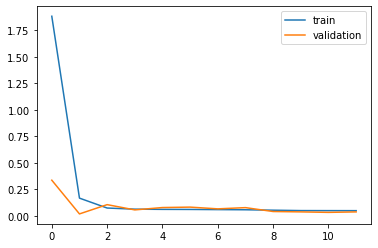


predict: [[29.87197057 25.34674299]]
real:      [[31.3 23.3]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.9073 - mean_squared_error: 8.6431 - val_loss: 2.0921 - val_mean_squared_error: 4.3776
Epoch 2/1000
 - 1s - loss: 0.8780 - mean_squared_error: 1.1992 - val_loss: 0.0801 - val_mean_squared_error: 0.0073
Epoch 3/1000
 - 1s - loss: 0.1070 - mean_squared_error: 0.0175 - val_loss: 0.1696 - val_mean_squared_error: 0.0288
Epoch 4/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0071 - val_loss: 0.0987 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0057 - val_loss: 0.1050 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0056 - val_loss: 0.1022 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0055 - val_loss: 0.1214 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0055 - val_loss: 0.1267 - v

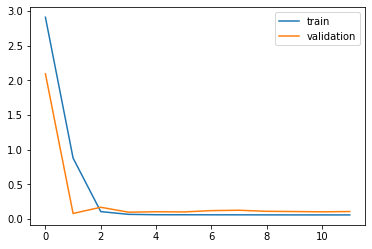


predict: [[33.92204281 30.35876886]]
real:      [[30.5 23.3]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 3.0999 - mean_squared_error: 9.8652 - val_loss: 2.4397 - val_mean_squared_error: 6.1252
Epoch 2/1000
 - 1s - loss: 1.7301 - mean_squared_error: 3.8043 - val_loss: 1.1442 - val_mean_squared_error: 2.0341
Epoch 3/1000
 - 1s - loss: 0.7392 - mean_squared_error: 1.0034 - val_loss: 0.3279 - val_mean_squared_error: 0.1621
Epoch 4/1000
 - 1s - loss: 0.1161 - mean_squared_error: 0.0259 - val_loss: 0.0837 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0062 - val_loss: 0.0548 - val_mean_squared_error: 0.0033
Epoch 6/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0055 - val_loss: 0.0633 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0055 - val_loss: 0.0675 - val_mean_squared_error: 0.0054
Epoch 8/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0054 - val_loss: 0.0642 - v

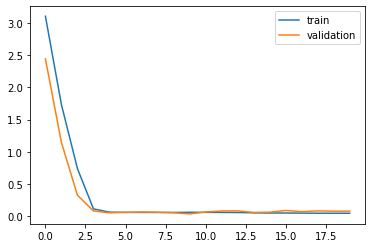


predict: [[31.52792842 23.16081724]]
real:      [[30.6 23.5]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.3605 - mean_squared_error: 2.6422 - val_loss: 0.0432 - val_mean_squared_error: 0.0027
Epoch 2/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0273 - val_loss: 0.0443 - val_mean_squared_error: 0.0025
Epoch 3/1000
 - 1s - loss: 0.0706 - mean_squared_error: 0.0077 - val_loss: 0.1213 - val_mean_squared_error: 0.0156
Epoch 4/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0060 - val_loss: 0.1092 - val_mean_squared_error: 0.0120
Epoch 5/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0056 - val_loss: 0.1157 - val_mean_squared_error: 0.0135
Epoch 6/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0055 - val_loss: 0.1412 - val_mean_squared_error: 0.0201
Epoch 7/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0055 - val_loss: 0.1199 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0053 - val_loss: 0.1055 - v

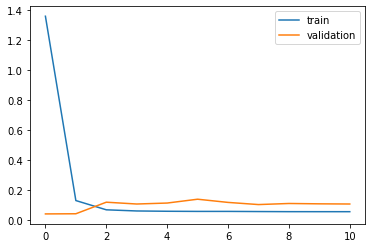


predict: [[31.06075737 24.67435662]]
real:      [[31.1 23.2]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.4859 - mean_squared_error: 6.7549 - val_loss: 1.1032 - val_mean_squared_error: 1.7017
Epoch 2/1000
 - 1s - loss: 0.4185 - mean_squared_error: 0.3820 - val_loss: 0.0517 - val_mean_squared_error: 0.0028
Epoch 3/1000
 - 1s - loss: 0.0813 - mean_squared_error: 0.0100 - val_loss: 0.0642 - val_mean_squared_error: 0.0049
Epoch 4/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0060 - val_loss: 0.0798 - val_mean_squared_error: 0.0064
Epoch 5/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0056 - val_loss: 0.0755 - val_mean_squared_error: 0.0058
Epoch 6/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0058 - val_loss: 0.1175 - val_mean_squared_error: 0.0139
Epoch 7/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0055 - val_loss: 0.1016 - val_mean_squared_error: 0.0104
Epoch 8/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0053 - val_loss: 0.0879 - v

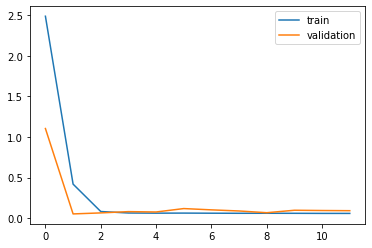


predict: [[28.47144705 25.87170939]]
real:      [[30.7 24.4]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.2014 - mean_squared_error: 6.2747 - val_loss: 1.1672 - val_mean_squared_error: 2.4445
Epoch 2/1000
 - 1s - loss: 0.4903 - mean_squared_error: 0.6312 - val_loss: 0.1475 - val_mean_squared_error: 0.0299
Epoch 3/1000
 - 1s - loss: 0.0939 - mean_squared_error: 0.0146 - val_loss: 0.0769 - val_mean_squared_error: 0.0087
Epoch 4/1000
 - 1s - loss: 0.0676 - mean_squared_error: 0.0068 - val_loss: 0.0711 - val_mean_squared_error: 0.0062
Epoch 5/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0064 - val_loss: 0.0532 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0060 - val_loss: 0.0668 - val_mean_squared_error: 0.0061
Epoch 7/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0058 - val_loss: 0.0709 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0060 - val_loss: 0.0560 - v

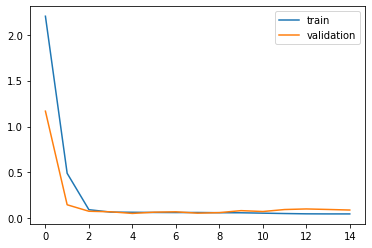


predict: [[28.38245003 24.08958648]]
real:      [[29.8 24.3]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.6191 - mean_squared_error: 3.5321 - val_loss: 0.6085 - val_mean_squared_error: 0.4001
Epoch 2/1000
 - 1s - loss: 0.2133 - mean_squared_error: 0.0771 - val_loss: 0.1048 - val_mean_squared_error: 0.0114
Epoch 3/1000
 - 1s - loss: 0.0724 - mean_squared_error: 0.0080 - val_loss: 0.0882 - val_mean_squared_error: 0.0086
Epoch 4/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0060 - val_loss: 0.0867 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0058 - val_loss: 0.0614 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0056 - val_loss: 0.0827 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0054 - val_loss: 0.0884 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0053 - val_loss: 0.0644 - v

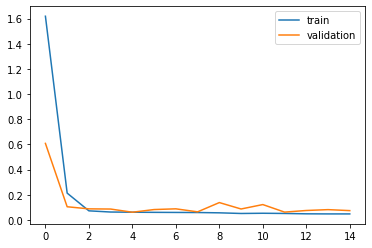


predict: [[29.16756584 23.40235727]]
real:      [[30.2 23.6]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.5713 - mean_squared_error: 3.3352 - val_loss: 0.2390 - val_mean_squared_error: 0.0595
Epoch 2/1000
 - 1s - loss: 0.1406 - mean_squared_error: 0.0316 - val_loss: 0.0898 - val_mean_squared_error: 0.0084
Epoch 3/1000
 - 1s - loss: 0.0700 - mean_squared_error: 0.0077 - val_loss: 0.1227 - val_mean_squared_error: 0.0178
Epoch 4/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0061 - val_loss: 0.1111 - val_mean_squared_error: 0.0145
Epoch 5/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0060 - val_loss: 0.1136 - val_mean_squared_error: 0.0154
Epoch 6/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0060 - val_loss: 0.0882 - val_mean_squared_error: 0.0098
Epoch 7/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0059 - val_loss: 0.1191 - val_mean_squared_error: 0.0166
Epoch 8/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0057 - val_loss: 0.0913 - v

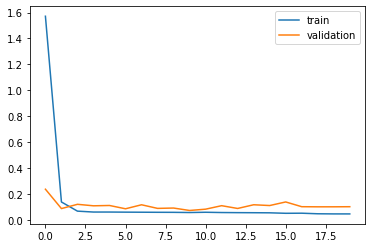


predict: [[29.68928218 23.48514172]]
real:      [[29.9 23.9]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.4458 - mean_squared_error: 6.8651 - val_loss: 1.0668 - val_mean_squared_error: 2.2561
Epoch 2/1000
 - 1s - loss: 0.5138 - mean_squared_error: 0.6305 - val_loss: 0.1387 - val_mean_squared_error: 0.0232
Epoch 3/1000
 - 1s - loss: 0.1029 - mean_squared_error: 0.0183 - val_loss: 0.0701 - val_mean_squared_error: 0.0051
Epoch 4/1000
 - 1s - loss: 0.0725 - mean_squared_error: 0.0080 - val_loss: 0.0838 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 1s - loss: 0.0682 - mean_squared_error: 0.0072 - val_loss: 0.1256 - val_mean_squared_error: 0.0158
Epoch 6/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0064 - val_loss: 0.0993 - val_mean_squared_error: 0.0116
Epoch 7/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0059 - val_loss: 0.0846 - val_mean_squared_error: 0.0102
Epoch 8/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0062 - val_loss: 0.1140 - v

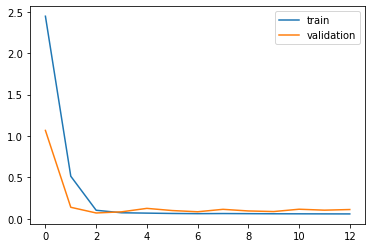


predict: [[28.33709059 23.60097235]]
real:      [[29.7 24. ]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.7269 - mean_squared_error: 8.1227 - val_loss: 1.9154 - val_mean_squared_error: 6.1956
Epoch 2/1000
 - 1s - loss: 1.3387 - mean_squared_error: 3.4661 - val_loss: 0.8080 - val_mean_squared_error: 1.1271
Epoch 3/1000
 - 1s - loss: 0.3199 - mean_squared_error: 0.2589 - val_loss: 0.0959 - val_mean_squared_error: 0.0122
Epoch 4/1000
 - 1s - loss: 0.0779 - mean_squared_error: 0.0094 - val_loss: 0.0054 - val_mean_squared_error: 3.0376e-05
Epoch 5/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0058 - val_loss: 0.0370 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0056 - val_loss: 0.0635 - val_mean_squared_error: 0.0045
Epoch 7/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0057 - val_loss: 0.0400 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0546 - mean_squared_error: 0.0046 - val_loss: 0.0909

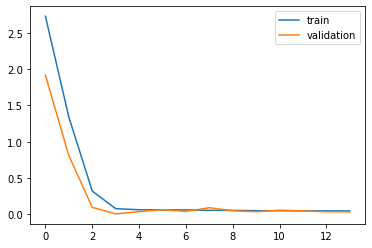


predict: [[29.44083837 23.59748273]]
real:      [[29.9 24.3]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.1333 - mean_squared_error: 5.0294 - val_loss: 1.0467 - val_mean_squared_error: 1.3375
Epoch 2/1000
 - 1s - loss: 0.3661 - mean_squared_error: 0.2699 - val_loss: 0.1821 - val_mean_squared_error: 0.0465
Epoch 3/1000
 - 1s - loss: 0.0828 - mean_squared_error: 0.0107 - val_loss: 0.1242 - val_mean_squared_error: 0.0155
Epoch 4/1000
 - 1s - loss: 0.0640 - mean_squared_error: 0.0062 - val_loss: 0.1486 - val_mean_squared_error: 0.0223
Epoch 5/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0059 - val_loss: 0.1395 - val_mean_squared_error: 0.0195
Epoch 6/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0057 - val_loss: 0.1653 - val_mean_squared_error: 0.0274
Epoch 7/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0057 - val_loss: 0.1335 - val_mean_squared_error: 0.0178
Epoch 8/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0058 - val_loss: 0.1434 - v

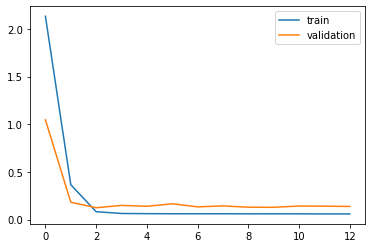


predict: [[30.36121378 23.03658662]]
real:      [[30.1 23.7]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.2253 - mean_squared_error: 5.4066 - val_loss: 1.0955 - val_mean_squared_error: 1.2612
Epoch 2/1000
 - 1s - loss: 0.3456 - mean_squared_error: 0.2319 - val_loss: 0.0420 - val_mean_squared_error: 0.0032
Epoch 3/1000
 - 1s - loss: 0.0793 - mean_squared_error: 0.0099 - val_loss: 0.0622 - val_mean_squared_error: 0.0039
Epoch 4/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0063 - val_loss: 0.0491 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0055 - val_loss: 0.0657 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0053 - val_loss: 0.0606 - val_mean_squared_error: 0.0041
Epoch 7/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0053 - val_loss: 0.0688 - val_mean_squared_error: 0.0058
Epoch 8/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0054 - val_loss: 0.0698 - v

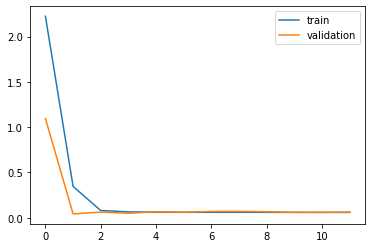


predict: [[28.93840268 23.60917345]]
real:      [[30.5 25.1]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.6564 - mean_squared_error: 7.3042 - val_loss: 1.8865 - val_mean_squared_error: 3.6177
Epoch 2/1000
 - 1s - loss: 0.9281 - mean_squared_error: 1.2264 - val_loss: 0.0817 - val_mean_squared_error: 0.0076
Epoch 3/1000
 - 1s - loss: 0.1168 - mean_squared_error: 0.0207 - val_loss: 0.0368 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0655 - mean_squared_error: 0.0065 - val_loss: 0.0562 - val_mean_squared_error: 0.0046
Epoch 5/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0056 - val_loss: 0.0464 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0055 - val_loss: 0.0476 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0055 - val_loss: 0.0618 - val_mean_squared_error: 0.0047
Epoch 8/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0054 - val_loss: 0.0590 - v

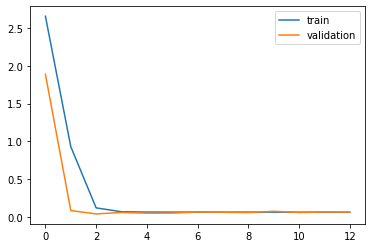


predict: [[29.57398747 24.40751398]]
real:      [[30.  24.2]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.2004 - mean_squared_error: 6.1664 - val_loss: 1.1898 - val_mean_squared_error: 2.5541
Epoch 2/1000
 - 1s - loss: 0.5651 - mean_squared_error: 0.7932 - val_loss: 0.1429 - val_mean_squared_error: 0.0244
Epoch 3/1000
 - 1s - loss: 0.0982 - mean_squared_error: 0.0162 - val_loss: 0.0575 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0062 - val_loss: 0.0298 - val_mean_squared_error: 9.6748e-04
Epoch 5/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0057 - val_loss: 0.0318 - val_mean_squared_error: 0.0010
Epoch 6/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0056 - val_loss: 0.0442 - val_mean_squared_error: 0.0020
Epoch 7/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0056 - val_loss: 0.0486 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0054 - val_loss: 0.0480

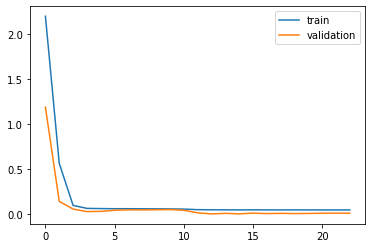


predict: [[29.87723374 23.60994208]]
real:      [[30.  23.2]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.5155 - mean_squared_error: 8.4870 - val_loss: 2.0222 - val_mean_squared_error: 7.9563
Epoch 2/1000
 - 1s - loss: 1.7878 - mean_squared_error: 6.1128 - val_loss: 1.5920 - val_mean_squared_error: 4.9043
Epoch 3/1000
 - 1s - loss: 1.3047 - mean_squared_error: 3.3032 - val_loss: 0.9906 - val_mean_squared_error: 1.9145
Epoch 4/1000
 - 1s - loss: 0.5301 - mean_squared_error: 0.6462 - val_loss: 0.0322 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 1s - loss: 0.0882 - mean_squared_error: 0.0129 - val_loss: 0.0383 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0065 - val_loss: 0.0596 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0059 - val_loss: 0.0534 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0055 - val_loss: 0.0656 - v

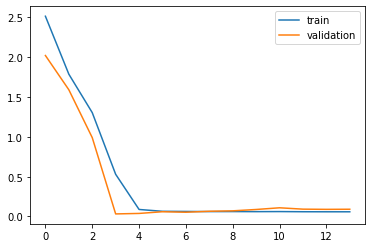


predict: [[31.64048094 22.88034862]]
real:      [[28.8 22.8]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 3.1712 - mean_squared_error: 10.4375 - val_loss: 2.8934 - val_mean_squared_error: 9.4192
Epoch 2/1000
 - 1s - loss: 2.1846 - mean_squared_error: 7.6503 - val_loss: 1.5485 - val_mean_squared_error: 4.4960
Epoch 3/1000
 - 1s - loss: 0.7977 - mean_squared_error: 1.5358 - val_loss: 0.0591 - val_mean_squared_error: 0.0036
Epoch 4/1000
 - 1s - loss: 0.1140 - mean_squared_error: 0.0221 - val_loss: 0.0396 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 1s - loss: 0.0673 - mean_squared_error: 0.0068 - val_loss: 0.0609 - val_mean_squared_error: 0.0038
Epoch 6/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0057 - val_loss: 0.0674 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0056 - val_loss: 0.0832 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0054 - val_loss: 0.0857 - 

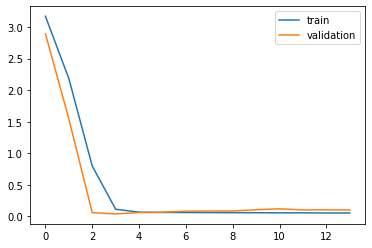


predict: [[31.45795825 22.50935022]]
real:      [[31.3 23.8]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.7295 - mean_squared_error: 7.7965 - val_loss: 1.6741 - val_mean_squared_error: 3.3331
Epoch 2/1000
 - 1s - loss: 0.7854 - mean_squared_error: 1.0201 - val_loss: 0.2186 - val_mean_squared_error: 0.0480
Epoch 3/1000
 - 1s - loss: 0.1082 - mean_squared_error: 0.0190 - val_loss: 0.1378 - val_mean_squared_error: 0.0190
Epoch 4/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0066 - val_loss: 0.1033 - val_mean_squared_error: 0.0109
Epoch 5/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0060 - val_loss: 0.1418 - val_mean_squared_error: 0.0201
Epoch 6/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0055 - val_loss: 0.1356 - val_mean_squared_error: 0.0184
Epoch 7/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0054 - val_loss: 0.1301 - val_mean_squared_error: 0.0169
Epoch 8/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0053 - val_loss: 0.1279 - v

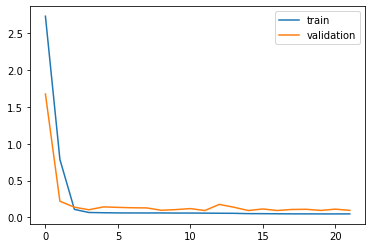


predict: [[29.8040422  22.89084978]]
real:      [[30.8 24.8]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.0526 - mean_squared_error: 5.0694 - val_loss: 0.9519 - val_mean_squared_error: 1.6802
Epoch 2/1000
 - 1s - loss: 0.4255 - mean_squared_error: 0.3986 - val_loss: 0.1398 - val_mean_squared_error: 0.0213
Epoch 3/1000
 - 1s - loss: 0.0833 - mean_squared_error: 0.0108 - val_loss: 0.1037 - val_mean_squared_error: 0.0109
Epoch 4/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0063 - val_loss: 0.1266 - val_mean_squared_error: 0.0165
Epoch 5/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0057 - val_loss: 0.1234 - val_mean_squared_error: 0.0160
Epoch 6/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0056 - val_loss: 0.1281 - val_mean_squared_error: 0.0172
Epoch 7/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0059 - val_loss: 0.1385 - val_mean_squared_error: 0.0202
Epoch 8/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0056 - val_loss: 0.1275 - v

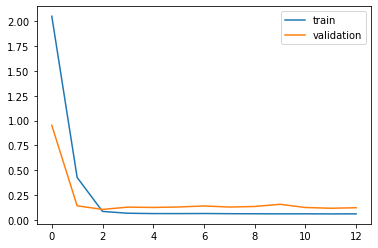


predict: [[27.09779139 22.87881142]]
real:      [[30.9 24.8]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.9462 - mean_squared_error: 4.7523 - val_loss: 0.6303 - val_mean_squared_error: 0.5273
Epoch 2/1000
 - 1s - loss: 0.2049 - mean_squared_error: 0.0822 - val_loss: 0.1615 - val_mean_squared_error: 0.0327
Epoch 3/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0081 - val_loss: 0.0901 - val_mean_squared_error: 0.0084
Epoch 4/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0060 - val_loss: 0.0997 - val_mean_squared_error: 0.0107
Epoch 5/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0058 - val_loss: 0.0982 - val_mean_squared_error: 0.0096
Epoch 6/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0056 - val_loss: 0.0912 - val_mean_squared_error: 0.0083
Epoch 7/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0056 - val_loss: 0.0734 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0054 - val_loss: 0.0712 - v

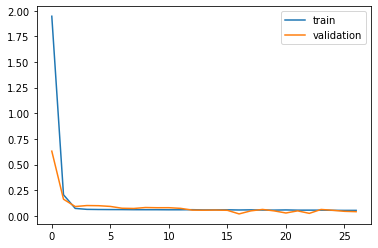


predict: [[29.80009859 22.33497634]]
real:      [[29.9 25.6]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.3139 - mean_squared_error: 6.6367 - val_loss: 1.5584 - val_mean_squared_error: 4.6450
Epoch 2/1000
 - 1s - loss: 1.2677 - mean_squared_error: 2.9645 - val_loss: 0.9916 - val_mean_squared_error: 1.5959
Epoch 3/1000
 - 1s - loss: 0.6137 - mean_squared_error: 0.7342 - val_loss: 0.3739 - val_mean_squared_error: 0.1882
Epoch 4/1000
 - 1s - loss: 0.1188 - mean_squared_error: 0.0282 - val_loss: 0.1104 - val_mean_squared_error: 0.0147
Epoch 5/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0060 - val_loss: 0.0942 - val_mean_squared_error: 0.0100
Epoch 6/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0054 - val_loss: 0.0982 - val_mean_squared_error: 0.0104
Epoch 7/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0054 - val_loss: 0.0966 - val_mean_squared_error: 0.0097
Epoch 8/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0054 - val_loss: 0.1104 - v

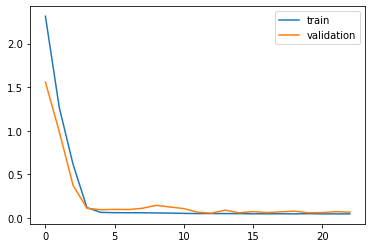


predict: [[30.24061638 23.40182202]]
real:      [[28.9 23.3]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.8452 - mean_squared_error: 4.3313 - val_loss: 0.0666 - val_mean_squared_error: 0.0073
Epoch 2/1000
 - 1s - loss: 0.1689 - mean_squared_error: 0.0449 - val_loss: 0.0894 - val_mean_squared_error: 0.0100
Epoch 3/1000
 - 1s - loss: 0.0711 - mean_squared_error: 0.0076 - val_loss: 0.1336 - val_mean_squared_error: 0.0179
Epoch 4/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0060 - val_loss: 0.1406 - val_mean_squared_error: 0.0198
Epoch 5/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0058 - val_loss: 0.1262 - val_mean_squared_error: 0.0159
Epoch 6/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0057 - val_loss: 0.1341 - val_mean_squared_error: 0.0181
Epoch 7/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0055 - val_loss: 0.1246 - val_mean_squared_error: 0.0155
Epoch 8/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0054 - val_loss: 0.1395 - v

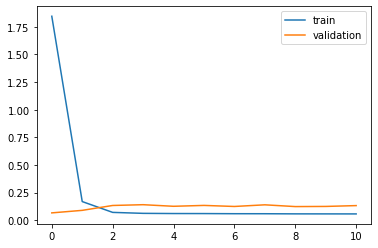


predict: [[38.0060791 28.0901802]]
real:      [[31.3 24.1]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.9105 - mean_squared_error: 4.6430 - val_loss: 0.4790 - val_mean_squared_error: 0.3877
Epoch 2/1000
 - 1s - loss: 0.1737 - mean_squared_error: 0.0527 - val_loss: 0.1311 - val_mean_squared_error: 0.0173
Epoch 3/1000
 - 1s - loss: 0.0729 - mean_squared_error: 0.0082 - val_loss: 0.1413 - val_mean_squared_error: 0.0213
Epoch 4/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0063 - val_loss: 0.1384 - val_mean_squared_error: 0.0193
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0059 - val_loss: 0.1354 - val_mean_squared_error: 0.0185
Epoch 6/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0056 - val_loss: 0.1450 - val_mean_squared_error: 0.0214
Epoch 7/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0058 - val_loss: 0.1500 - val_mean_squared_error: 0.0233
Epoch 8/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0056 - val_loss: 0.1325 - val

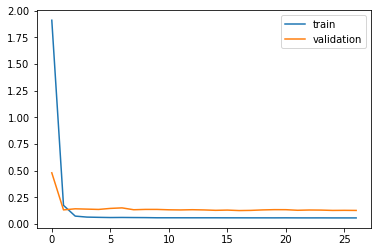


predict: [[29.56218091 22.83766265]]
real:      [[30.1 24. ]]

Train and validation time: 27.977506359418232

Maximum metrics
Test RMSE -------------------------- 1.911
Test VARIANCE ---------------------- -7.086
Test MAX-ERROR --------------------- 6.706
Test MEAN-ABSOLUTE-ERROR ----------- 1.265
Test MEDIAN-ABSOLUTE-ERROR --------- 0.7329

Errors
2018-12-31 = 0.3698082933957423
2018-12-30 = 0.51393059094449
2018-12-29 = 0.16798872367366968
2018-12-28 = 0.44074430039237456
2018-12-27 = 0.05612901150747618
2018-12-26 = 2.1363523758836465
2018-12-25 = 2.4802414794089813
2018-12-24 = 0.40817110935386935
2018-12-23 = 1.4280294295178635
2018-12-22 = 3.4220428078474967
2018-12-21 = 0.9279284175927209
2018-12-20 = 0.03924262623122843
2018-12-19 = 2.22855295392052
2018-12-18 = 1.4175499740834887
2018-12-17 = 1.032434163853413
2018-12-16 = 0.21071782396330363
2018-12-15 = 1.3629094124421286
2018-12-14 = 0.45916163309367164
2018-12-13 = 0.2612137787918378
2018-12-12 = 1.5615973189711632
2018-1

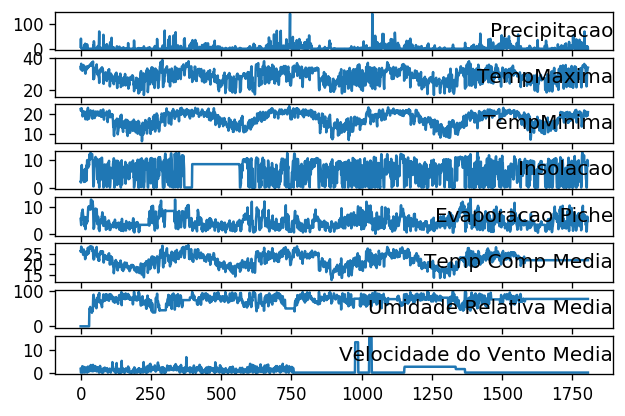

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.3666 - mean_squared_error: 2.5431 - val_loss: 0.0575 - val_mean_squared_error: 0.0049
Epoch 2/1000
 - 1s - loss: 0.1942 - mean_squared_error: 0.0612 - val_loss: 0.0881 - val_mean_squared_error: 0.0145
Epoch 3/1000
 - 1s - loss: 0.1105 - mean_squared_error: 0.0218 - val_loss: 0.0821 - val_mean_squared_error: 0.0076
Epoch 4/1000
 - 1s - loss: 0.1057 - mean_squared_error: 0.0195 - val_loss: 0.0916 - val_mean_squared_error: 0.0091
Epoch 5/1000
 - 1s - loss: 0.1011 - mean_squared_error: 0.0182 - val_loss: 0.0668 - val_mean_squared_error: 0.0046
Epoch 6/1000
 - 1s - loss: 0.1014 - mean_squared_error: 0.0181 - val_loss: 0.0911 - val_mean_squared_error: 0.0086
Epoch 7/1000
 - 1s - loss: 0.1006 - mean_squared_error: 0.0180 - val_loss: 0.0860 - val_mean_squared_error: 0.0076
Epoch 8/1000
 - 1s - loss: 0.0999 - mean_squared_error: 0.0176 - val_loss: 0.0885 - val_mean_squared_error: 0.0078

Epoch 00008: ReduceLROnPlateau re

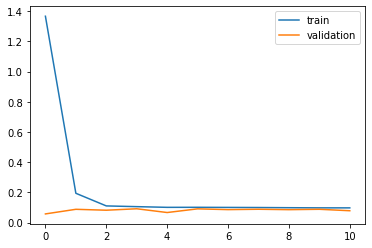


predict: [[38.30638434 21.61576743]]
real:      [[34.2 20.7]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.4276 - mean_squared_error: 2.8848 - val_loss: 0.3079 - val_mean_squared_error: 0.1142
Epoch 2/1000
 - 1s - loss: 0.1631 - mean_squared_error: 0.0438 - val_loss: 0.0622 - val_mean_squared_error: 0.0039
Epoch 3/1000
 - 1s - loss: 0.1308 - mean_squared_error: 0.0300 - val_loss: 0.0356 - val_mean_squared_error: 0.0025
Epoch 4/1000
 - 1s - loss: 0.1249 - mean_squared_error: 0.0266 - val_loss: 0.0270 - val_mean_squared_error: 0.0014
Epoch 5/1000
 - 1s - loss: 0.1210 - mean_squared_error: 0.0256 - val_loss: 0.0806 - val_mean_squared_error: 0.0067
Epoch 6/1000
 - 1s - loss: 0.1175 - mean_squared_error: 0.0237 - val_loss: 0.0253 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 1s - loss: 0.1104 - mean_squared_error: 0.0214 - val_loss: 0.0300 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 1s - loss: 0.1059 - mean_squared_error: 0.0197 - val_loss: 0.0368 - v

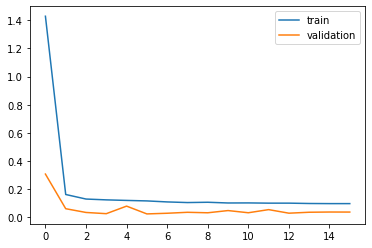


predict: [[32.26004614 20.76217245]]
real:      [[33.7 19. ]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.3108 - mean_squared_error: 5.7147 - val_loss: 1.2240 - val_mean_squared_error: 1.6109
Epoch 2/1000
 - 1s - loss: 0.4249 - mean_squared_error: 0.3443 - val_loss: 0.1078 - val_mean_squared_error: 0.0164
Epoch 3/1000
 - 1s - loss: 0.1400 - mean_squared_error: 0.0325 - val_loss: 0.0950 - val_mean_squared_error: 0.0136
Epoch 4/1000
 - 1s - loss: 0.1296 - mean_squared_error: 0.0291 - val_loss: 0.0465 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.1291 - mean_squared_error: 0.0290 - val_loss: 0.1654 - val_mean_squared_error: 0.0338
Epoch 6/1000
 - 1s - loss: 0.1272 - mean_squared_error: 0.0277 - val_loss: 0.0636 - val_mean_squared_error: 0.0041
Epoch 7/1000
 - 1s - loss: 0.1251 - mean_squared_error: 0.0270 - val_loss: 0.0664 - val_mean_squared_error: 0.0046
Epoch 8/1000
 - 1s - loss: 0.1234 - mean_squared_error: 0.0263 - val_loss: 0.0889 - v

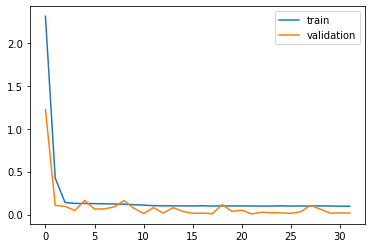


predict: [[31.22233438 19.19435363]]
real:      [[32.2 19.3]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.9688 - mean_squared_error: 4.6418 - val_loss: 0.0943 - val_mean_squared_error: 0.0092
Epoch 2/1000
 - 1s - loss: 0.2276 - mean_squared_error: 0.0782 - val_loss: 0.1209 - val_mean_squared_error: 0.0259
Epoch 3/1000
 - 1s - loss: 0.1343 - mean_squared_error: 0.0313 - val_loss: 0.1385 - val_mean_squared_error: 0.0302
Epoch 4/1000
 - 1s - loss: 0.1260 - mean_squared_error: 0.0274 - val_loss: 0.1463 - val_mean_squared_error: 0.0341
Epoch 5/1000
 - 1s - loss: 0.1174 - mean_squared_error: 0.0240 - val_loss: 0.1459 - val_mean_squared_error: 0.0397
Epoch 6/1000
 - 1s - loss: 0.1077 - mean_squared_error: 0.0205 - val_loss: 0.1874 - val_mean_squared_error: 0.0359
Epoch 7/1000
 - 1s - loss: 0.1079 - mean_squared_error: 0.0204 - val_loss: 0.1535 - val_mean_squared_error: 0.0421
Epoch 8/1000
 - 1s - loss: 0.1039 - mean_squared_error: 0.0191 - val_loss: 0.1390 - v

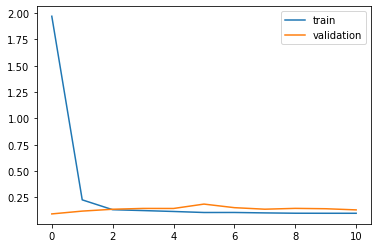


predict: [[23.38139248 20.22260872]]
real:      [[32.  19.7]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.7551 - mean_squared_error: 7.7232 - val_loss: 2.1019 - val_mean_squared_error: 4.4246
Epoch 2/1000
 - 1s - loss: 1.3956 - mean_squared_error: 2.2476 - val_loss: 0.5468 - val_mean_squared_error: 0.4095
Epoch 3/1000
 - 1s - loss: 0.2259 - mean_squared_error: 0.0920 - val_loss: 0.1395 - val_mean_squared_error: 0.0245
Epoch 4/1000
 - 1s - loss: 0.1223 - mean_squared_error: 0.0257 - val_loss: 0.1690 - val_mean_squared_error: 0.0504
Epoch 5/1000
 - 1s - loss: 0.1117 - mean_squared_error: 0.0228 - val_loss: 0.1985 - val_mean_squared_error: 0.0699
Epoch 6/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0215 - val_loss: 0.1888 - val_mean_squared_error: 0.0610
Epoch 7/1000
 - 1s - loss: 0.1062 - mean_squared_error: 0.0206 - val_loss: 0.1760 - val_mean_squared_error: 0.0514
Epoch 8/1000
 - 1s - loss: 0.1051 - mean_squared_error: 0.0200 - val_loss: 0.1681 - v

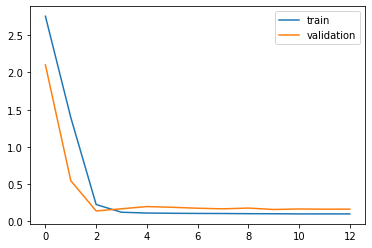


predict: [[27.09982798 18.21296823]]
real:      [[23.2 19.3]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.9062 - mean_squared_error: 4.6376 - val_loss: 0.5881 - val_mean_squared_error: 0.5295
Epoch 2/1000
 - 1s - loss: 0.2466 - mean_squared_error: 0.1154 - val_loss: 0.1069 - val_mean_squared_error: 0.0118
Epoch 3/1000
 - 1s - loss: 0.1393 - mean_squared_error: 0.0325 - val_loss: 0.0245 - val_mean_squared_error: 6.1359e-04
Epoch 4/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0280 - val_loss: 0.0531 - val_mean_squared_error: 0.0029
Epoch 5/1000
 - 1s - loss: 0.1250 - mean_squared_error: 0.0268 - val_loss: 0.0316 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 1s - loss: 0.1221 - mean_squared_error: 0.0256 - val_loss: 0.0471 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 1s - loss: 0.1182 - mean_squared_error: 0.0245 - val_loss: 0.0381 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.1149 - mean_squared_error: 0.0230 - val_loss: 0.0681

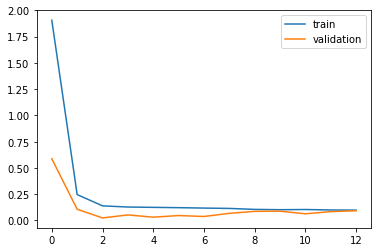


predict: [[28.09496619 17.65963276]]
real:      [[22.4 20.1]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.4972 - mean_squared_error: 6.9438 - val_loss: 1.7609 - val_mean_squared_error: 4.5651
Epoch 2/1000
 - 1s - loss: 1.1496 - mean_squared_error: 2.4387 - val_loss: 0.5431 - val_mean_squared_error: 0.4825
Epoch 3/1000
 - 1s - loss: 0.2205 - mean_squared_error: 0.0946 - val_loss: 0.1199 - val_mean_squared_error: 0.0182
Epoch 4/1000
 - 1s - loss: 0.1388 - mean_squared_error: 0.0319 - val_loss: 0.0808 - val_mean_squared_error: 0.0072
Epoch 5/1000
 - 1s - loss: 0.1237 - mean_squared_error: 0.0266 - val_loss: 0.0708 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 1s - loss: 0.1101 - mean_squared_error: 0.0213 - val_loss: 0.0467 - val_mean_squared_error: 0.0031
Epoch 7/1000
 - 1s - loss: 0.1054 - mean_squared_error: 0.0194 - val_loss: 0.0652 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.1038 - mean_squared_error: 0.0188 - val_loss: 0.0408 - v

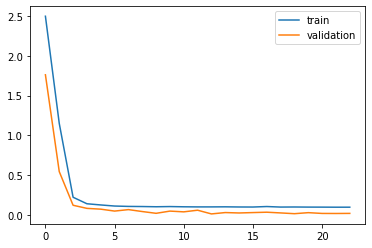


predict: [[31.56799349 20.2395711 ]]
real:      [[28.2 18.6]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.3284 - mean_squared_error: 6.0274 - val_loss: 1.4334 - val_mean_squared_error: 2.4417
Epoch 2/1000
 - 1s - loss: 0.6195 - mean_squared_error: 0.6496 - val_loss: 0.1481 - val_mean_squared_error: 0.0284
Epoch 3/1000
 - 1s - loss: 0.1546 - mean_squared_error: 0.0389 - val_loss: 0.1125 - val_mean_squared_error: 0.0145
Epoch 4/1000
 - 1s - loss: 0.1333 - mean_squared_error: 0.0305 - val_loss: 0.0871 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 1s - loss: 0.1306 - mean_squared_error: 0.0296 - val_loss: 0.0826 - val_mean_squared_error: 0.0068
Epoch 6/1000
 - 1s - loss: 0.1291 - mean_squared_error: 0.0286 - val_loss: 0.0581 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.1262 - mean_squared_error: 0.0275 - val_loss: 0.0551 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 1s - loss: 0.1174 - mean_squared_error: 0.0241 - val_loss: 0.0217 - v

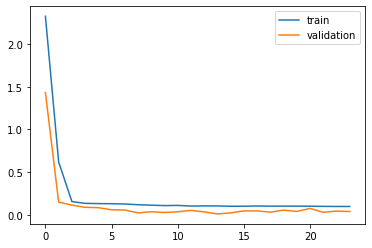


predict: [[31.61481012 19.3061804 ]]
real:      [[30.8 20.1]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.9643 - mean_squared_error: 8.8882 - val_loss: 2.7062 - val_mean_squared_error: 7.4314
Epoch 2/1000
 - 1s - loss: 1.6376 - mean_squared_error: 3.2703 - val_loss: 0.6377 - val_mean_squared_error: 0.7390
Epoch 3/1000
 - 1s - loss: 0.2572 - mean_squared_error: 0.1252 - val_loss: 0.2196 - val_mean_squared_error: 0.0575
Epoch 4/1000
 - 1s - loss: 0.1395 - mean_squared_error: 0.0327 - val_loss: 0.1420 - val_mean_squared_error: 0.0204
Epoch 5/1000
 - 1s - loss: 0.1190 - mean_squared_error: 0.0254 - val_loss: 0.2294 - val_mean_squared_error: 0.0531
Epoch 6/1000
 - 1s - loss: 0.1124 - mean_squared_error: 0.0234 - val_loss: 0.1285 - val_mean_squared_error: 0.0179
Epoch 7/1000
 - 1s - loss: 0.1097 - mean_squared_error: 0.0221 - val_loss: 0.1091 - val_mean_squared_error: 0.0120
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0217 - val_loss: 0.1265 - v

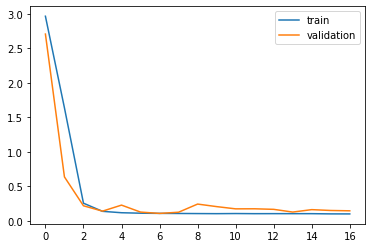


predict: [[30.79859516 18.26175987]]
real:      [[32.2 20.3]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.2176 - mean_squared_error: 5.8299 - val_loss: 1.1056 - val_mean_squared_error: 2.3321
Epoch 2/1000
 - 1s - loss: 0.5647 - mean_squared_error: 0.6832 - val_loss: 0.1527 - val_mean_squared_error: 0.0255
Epoch 3/1000
 - 1s - loss: 0.1587 - mean_squared_error: 0.0414 - val_loss: 0.1376 - val_mean_squared_error: 0.0260
Epoch 4/1000
 - 1s - loss: 0.1344 - mean_squared_error: 0.0315 - val_loss: 0.1078 - val_mean_squared_error: 0.0117
Epoch 5/1000
 - 1s - loss: 0.1302 - mean_squared_error: 0.0292 - val_loss: 0.1431 - val_mean_squared_error: 0.0213
Epoch 6/1000
 - 1s - loss: 0.1274 - mean_squared_error: 0.0278 - val_loss: 0.1087 - val_mean_squared_error: 0.0137
Epoch 7/1000
 - 1s - loss: 0.1188 - mean_squared_error: 0.0246 - val_loss: 0.0639 - val_mean_squared_error: 0.0047
Epoch 8/1000
 - 1s - loss: 0.1094 - mean_squared_error: 0.0210 - val_loss: 0.1111 - v

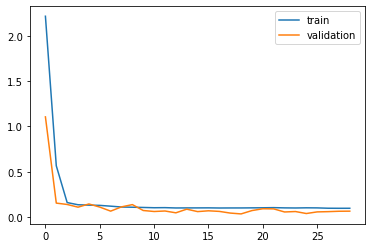


predict: [[32.76453018 20.29265137]]
real:      [[35.7 21.1]]

Train on 1734 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.1652 - mean_squared_error: 4.9666 - val_loss: 1.3773 - val_mean_squared_error: 1.8970
Epoch 2/1000
 - 1s - loss: 0.4911 - mean_squared_error: 0.3892 - val_loss: 0.1097 - val_mean_squared_error: 0.0152
Epoch 3/1000
 - 1s - loss: 0.1543 - mean_squared_error: 0.0375 - val_loss: 0.0720 - val_mean_squared_error: 0.0060
Epoch 4/1000
 - 1s - loss: 0.1350 - mean_squared_error: 0.0307 - val_loss: 0.0903 - val_mean_squared_error: 0.0139
Epoch 5/1000
 - 1s - loss: 0.1293 - mean_squared_error: 0.0287 - val_loss: 0.1265 - val_mean_squared_error: 0.0231
Epoch 6/1000
 - 1s - loss: 0.1303 - mean_squared_error: 0.0287 - val_loss: 0.0936 - val_mean_squared_error: 0.0150
Epoch 7/1000
 - 1s - loss: 0.1276 - mean_squared_error: 0.0283 - val_loss: 0.0840 - val_mean_squared_error: 0.0091
Epoch 8/1000
 - 1s - loss: 0.1283 - mean_squared_error: 0.0281 - val_loss: 0.0753 - v

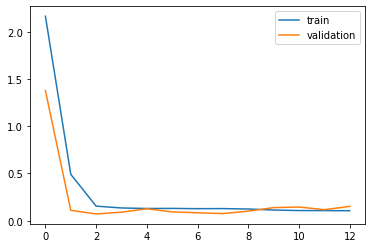


predict: [[32.55711527 18.85131561]]
real:      [[34.1 19.7]]

Train on 1733 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.0117 - mean_squared_error: 5.0358 - val_loss: 1.0027 - val_mean_squared_error: 1.9534
Epoch 2/1000
 - 1s - loss: 0.3706 - mean_squared_error: 0.3239 - val_loss: 0.2828 - val_mean_squared_error: 0.0905
Epoch 3/1000
 - 1s - loss: 0.1481 - mean_squared_error: 0.0358 - val_loss: 0.1858 - val_mean_squared_error: 0.0355
Epoch 4/1000
 - 1s - loss: 0.1312 - mean_squared_error: 0.0294 - val_loss: 0.1281 - val_mean_squared_error: 0.0190
Epoch 5/1000
 - 1s - loss: 0.1280 - mean_squared_error: 0.0279 - val_loss: 0.1355 - val_mean_squared_error: 0.0193
Epoch 6/1000
 - 1s - loss: 0.1276 - mean_squared_error: 0.0280 - val_loss: 0.1553 - val_mean_squared_error: 0.0263
Epoch 7/1000
 - 1s - loss: 0.1236 - mean_squared_error: 0.0262 - val_loss: 0.0954 - val_mean_squared_error: 0.0136
Epoch 8/1000
 - 1s - loss: 0.1192 - mean_squared_error: 0.0241 - val_loss: 0.1077 - v

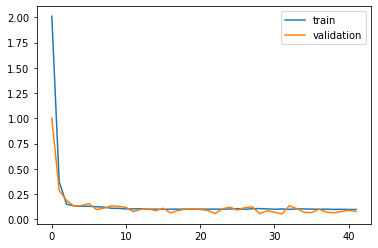


predict: [[30.9830599  20.42274322]]
real:      [[34.4 19.3]]

Train on 1732 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.2183 - mean_squared_error: 5.9630 - val_loss: 1.2825 - val_mean_squared_error: 2.9424
Epoch 2/1000
 - 1s - loss: 0.7883 - mean_squared_error: 1.1392 - val_loss: 0.3248 - val_mean_squared_error: 0.1704
Epoch 3/1000
 - 1s - loss: 0.1659 - mean_squared_error: 0.0450 - val_loss: 0.1723 - val_mean_squared_error: 0.0346
Epoch 4/1000
 - 1s - loss: 0.1351 - mean_squared_error: 0.0313 - val_loss: 0.1621 - val_mean_squared_error: 0.0277
Epoch 5/1000
 - 1s - loss: 0.1290 - mean_squared_error: 0.0287 - val_loss: 0.1753 - val_mean_squared_error: 0.0323
Epoch 6/1000
 - 1s - loss: 0.1202 - mean_squared_error: 0.0253 - val_loss: 0.1030 - val_mean_squared_error: 0.0173
Epoch 7/1000
 - 1s - loss: 0.1066 - mean_squared_error: 0.0201 - val_loss: 0.1682 - val_mean_squared_error: 0.0286
Epoch 8/1000
 - 1s - loss: 0.1065 - mean_squared_error: 0.0203 - val_loss: 0.0988 - v

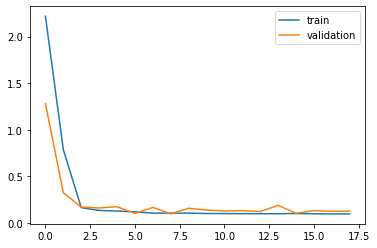


predict: [[29.8464992  20.35914119]]
real:      [[35.4 21.1]]

Train on 1731 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.1712 - mean_squared_error: 5.4248 - val_loss: 0.9883 - val_mean_squared_error: 1.1879
Epoch 2/1000
 - 1s - loss: 0.3028 - mean_squared_error: 0.1711 - val_loss: 0.3048 - val_mean_squared_error: 0.1176
Epoch 3/1000
 - 1s - loss: 0.1522 - mean_squared_error: 0.0386 - val_loss: 0.1724 - val_mean_squared_error: 0.0309
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0310 - val_loss: 0.1336 - val_mean_squared_error: 0.0185
Epoch 5/1000
 - 1s - loss: 0.1278 - mean_squared_error: 0.0284 - val_loss: 0.1500 - val_mean_squared_error: 0.0263
Epoch 6/1000
 - 1s - loss: 0.1246 - mean_squared_error: 0.0275 - val_loss: 0.1326 - val_mean_squared_error: 0.0179
Epoch 7/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0266 - val_loss: 0.1096 - val_mean_squared_error: 0.0149
Epoch 8/1000
 - 1s - loss: 0.1221 - mean_squared_error: 0.0261 - val_loss: 0.1303 - v

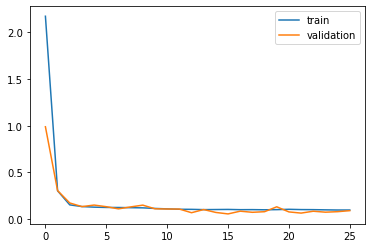


predict: [[32.32727952 20.11272575]]
real:      [[36.5 21.5]]

Train on 1730 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.8215 - mean_squared_error: 3.7369 - val_loss: 0.7313 - val_mean_squared_error: 0.5389
Epoch 2/1000
 - 1s - loss: 0.2384 - mean_squared_error: 0.0884 - val_loss: 0.2695 - val_mean_squared_error: 0.0728
Epoch 3/1000
 - 1s - loss: 0.1458 - mean_squared_error: 0.0360 - val_loss: 0.1732 - val_mean_squared_error: 0.0300
Epoch 4/1000
 - 1s - loss: 0.1360 - mean_squared_error: 0.0317 - val_loss: 0.1340 - val_mean_squared_error: 0.0209
Epoch 5/1000
 - 1s - loss: 0.1310 - mean_squared_error: 0.0301 - val_loss: 0.1285 - val_mean_squared_error: 0.0166
Epoch 6/1000
 - 1s - loss: 0.1293 - mean_squared_error: 0.0292 - val_loss: 0.1480 - val_mean_squared_error: 0.0235
Epoch 7/1000
 - 1s - loss: 0.1279 - mean_squared_error: 0.0282 - val_loss: 0.1437 - val_mean_squared_error: 0.0233
Epoch 8/1000
 - 1s - loss: 0.1235 - mean_squared_error: 0.0270 - val_loss: 0.0788 - v

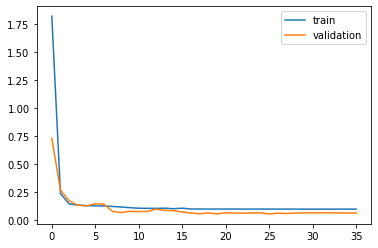


predict: [[32.16882004 19.68438627]]
real:      [[35.4 20.7]]

Train on 1729 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.2618 - mean_squared_error: 5.5615 - val_loss: 1.2464 - val_mean_squared_error: 1.7699
Epoch 2/1000
 - 1s - loss: 0.4396 - mean_squared_error: 0.3681 - val_loss: 0.1144 - val_mean_squared_error: 0.0178
Epoch 3/1000
 - 1s - loss: 0.1464 - mean_squared_error: 0.0351 - val_loss: 0.0704 - val_mean_squared_error: 0.0077
Epoch 4/1000
 - 1s - loss: 0.1325 - mean_squared_error: 0.0304 - val_loss: 0.0937 - val_mean_squared_error: 0.0145
Epoch 5/1000
 - 1s - loss: 0.1313 - mean_squared_error: 0.0296 - val_loss: 0.1470 - val_mean_squared_error: 0.0277
Epoch 6/1000
 - 1s - loss: 0.1346 - mean_squared_error: 0.0305 - val_loss: 0.0956 - val_mean_squared_error: 0.0175
Epoch 7/1000
 - 1s - loss: 0.1320 - mean_squared_error: 0.0301 - val_loss: 0.1364 - val_mean_squared_error: 0.0223
Epoch 8/1000
 - 1s - loss: 0.1308 - mean_squared_error: 0.0298 - val_loss: 0.0978 - v

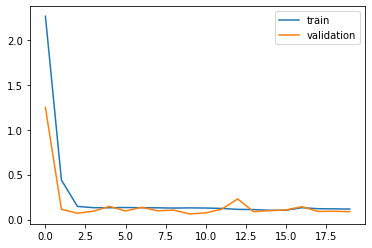


predict: [[31.4265007  18.83570311]]
real:      [[35.2 20.3]]

Train on 1728 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.1358 - mean_squared_error: 5.8945 - val_loss: 1.0636 - val_mean_squared_error: 2.0939
Epoch 2/1000
 - 1s - loss: 0.4764 - mean_squared_error: 0.5241 - val_loss: 0.2410 - val_mean_squared_error: 0.0581
Epoch 3/1000
 - 1s - loss: 0.1496 - mean_squared_error: 0.0374 - val_loss: 0.1294 - val_mean_squared_error: 0.0168
Epoch 4/1000
 - 1s - loss: 0.1324 - mean_squared_error: 0.0308 - val_loss: 0.0844 - val_mean_squared_error: 0.0080
Epoch 5/1000
 - 1s - loss: 0.1268 - mean_squared_error: 0.0283 - val_loss: 0.0935 - val_mean_squared_error: 0.0113
Epoch 6/1000
 - 1s - loss: 0.1236 - mean_squared_error: 0.0269 - val_loss: 0.1259 - val_mean_squared_error: 0.0187
Epoch 7/1000
 - 1s - loss: 0.1200 - mean_squared_error: 0.0257 - val_loss: 0.1509 - val_mean_squared_error: 0.0365
Epoch 8/1000
 - 1s - loss: 0.1144 - mean_squared_error: 0.0233 - val_loss: 0.1723 - v

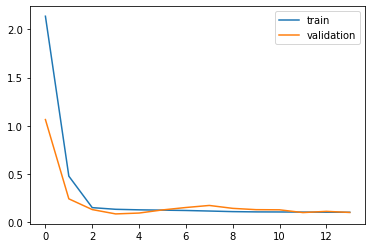


predict: [[30.27235498 18.27261008]]
real:      [[35.6 19. ]]

Train on 1727 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.3126 - mean_squared_error: 5.8698 - val_loss: 1.0464 - val_mean_squared_error: 1.1382
Epoch 2/1000
 - 1s - loss: 0.3141 - mean_squared_error: 0.1633 - val_loss: 0.2073 - val_mean_squared_error: 0.0501
Epoch 3/1000
 - 1s - loss: 0.1422 - mean_squared_error: 0.0336 - val_loss: 0.1386 - val_mean_squared_error: 0.0279
Epoch 4/1000
 - 1s - loss: 0.1313 - mean_squared_error: 0.0297 - val_loss: 0.0914 - val_mean_squared_error: 0.0143
Epoch 5/1000
 - 1s - loss: 0.1268 - mean_squared_error: 0.0280 - val_loss: 0.0915 - val_mean_squared_error: 0.0162
Epoch 6/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0267 - val_loss: 0.0998 - val_mean_squared_error: 0.0149
Epoch 7/1000
 - 1s - loss: 0.1167 - mean_squared_error: 0.0243 - val_loss: 0.1137 - val_mean_squared_error: 0.0188
Epoch 8/1000
 - 1s - loss: 0.1074 - mean_squared_error: 0.0203 - val_loss: 0.0848 - v

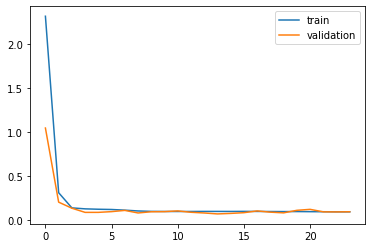


predict: [[32.06920969 20.00492406]]
real:      [[35.  17.4]]

Train on 1726 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.6911 - mean_squared_error: 3.7535 - val_loss: 0.8085 - val_mean_squared_error: 0.9409
Epoch 2/1000
 - 1s - loss: 0.3067 - mean_squared_error: 0.1695 - val_loss: 0.2190 - val_mean_squared_error: 0.0485
Epoch 3/1000
 - 1s - loss: 0.1464 - mean_squared_error: 0.0353 - val_loss: 0.0666 - val_mean_squared_error: 0.0066
Epoch 4/1000
 - 1s - loss: 0.1287 - mean_squared_error: 0.0287 - val_loss: 0.1109 - val_mean_squared_error: 0.0162
Epoch 5/1000
 - 1s - loss: 0.1197 - mean_squared_error: 0.0250 - val_loss: 0.0902 - val_mean_squared_error: 0.0130
Epoch 6/1000
 - 1s - loss: 0.1114 - mean_squared_error: 0.0224 - val_loss: 0.0820 - val_mean_squared_error: 0.0118
Epoch 7/1000
 - 1s - loss: 0.1053 - mean_squared_error: 0.0201 - val_loss: 0.0900 - val_mean_squared_error: 0.0087
Epoch 8/1000
 - 1s - loss: 0.1027 - mean_squared_error: 0.0191 - val_loss: 0.0857 - v

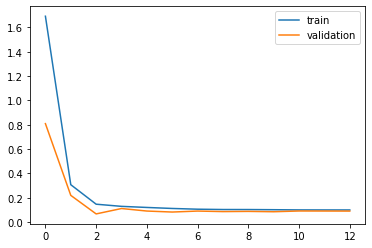


predict: [[30.6095416  17.64949669]]
real:      [[35.2 18.8]]

Train on 1725 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.4825 - mean_squared_error: 2.9221 - val_loss: 0.5734 - val_mean_squared_error: 0.3499
Epoch 2/1000
 - 1s - loss: 0.2435 - mean_squared_error: 0.0931 - val_loss: 0.0823 - val_mean_squared_error: 0.0077
Epoch 3/1000
 - 1s - loss: 0.1373 - mean_squared_error: 0.0331 - val_loss: 0.0692 - val_mean_squared_error: 0.0049
Epoch 4/1000
 - 1s - loss: 0.1289 - mean_squared_error: 0.0292 - val_loss: 0.1015 - val_mean_squared_error: 0.0104
Epoch 5/1000
 - 1s - loss: 0.1259 - mean_squared_error: 0.0277 - val_loss: 0.1046 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 1s - loss: 0.1252 - mean_squared_error: 0.0273 - val_loss: 0.1168 - val_mean_squared_error: 0.0158
Epoch 7/1000
 - 1s - loss: 0.1219 - mean_squared_error: 0.0265 - val_loss: 0.1073 - val_mean_squared_error: 0.0119
Epoch 8/1000
 - 1s - loss: 0.1155 - mean_squared_error: 0.0245 - val_loss: 0.1195 - v

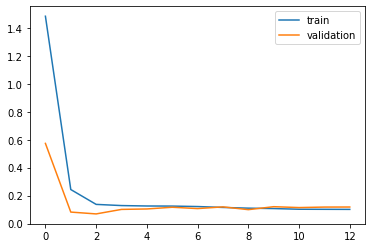


predict: [[30.54420166 17.33946823]]
real:      [[35.4 18.6]]

Train on 1724 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.8522 - mean_squared_error: 4.0188 - val_loss: 0.2726 - val_mean_squared_error: 0.1324
Epoch 2/1000
 - 1s - loss: 0.2578 - mean_squared_error: 0.1093 - val_loss: 0.2088 - val_mean_squared_error: 0.0560
Epoch 3/1000
 - 1s - loss: 0.1355 - mean_squared_error: 0.0325 - val_loss: 0.1588 - val_mean_squared_error: 0.0337
Epoch 4/1000
 - 1s - loss: 0.1225 - mean_squared_error: 0.0263 - val_loss: 0.1343 - val_mean_squared_error: 0.0317
Epoch 5/1000
 - 1s - loss: 0.1181 - mean_squared_error: 0.0255 - val_loss: 0.1560 - val_mean_squared_error: 0.0369
Epoch 6/1000
 - 1s - loss: 0.1134 - mean_squared_error: 0.0233 - val_loss: 0.1353 - val_mean_squared_error: 0.0340
Epoch 7/1000
 - 1s - loss: 0.1071 - mean_squared_error: 0.0208 - val_loss: 0.1577 - val_mean_squared_error: 0.0488
Epoch 8/1000
 - 1s - loss: 0.1045 - mean_squared_error: 0.0200 - val_loss: 0.1467 - v

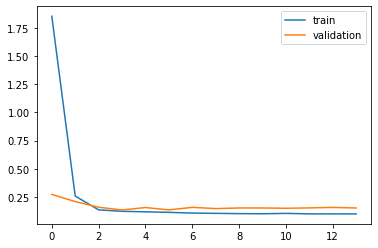


predict: [[28.83889518 17.62856152]]
real:      [[33.7 16.7]]

Train on 1723 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 2.1400 - mean_squared_error: 5.1554 - val_loss: 0.8240 - val_mean_squared_error: 1.1347
Epoch 2/1000
 - 1s - loss: 0.4384 - mean_squared_error: 0.3679 - val_loss: 0.1224 - val_mean_squared_error: 0.0164
Epoch 3/1000
 - 1s - loss: 0.1519 - mean_squared_error: 0.0380 - val_loss: 0.1721 - val_mean_squared_error: 0.0400
Epoch 4/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0300 - val_loss: 0.1953 - val_mean_squared_error: 0.0492
Epoch 5/1000
 - 1s - loss: 0.1242 - mean_squared_error: 0.0272 - val_loss: 0.1970 - val_mean_squared_error: 0.0466
Epoch 6/1000
 - 1s - loss: 0.1198 - mean_squared_error: 0.0263 - val_loss: 0.1944 - val_mean_squared_error: 0.0447
Epoch 7/1000
 - 1s - loss: 0.1154 - mean_squared_error: 0.0240 - val_loss: 0.1817 - val_mean_squared_error: 0.0384
Epoch 8/1000
 - 1s - loss: 0.1103 - mean_squared_error: 0.0224 - val_loss: 0.1150 - v

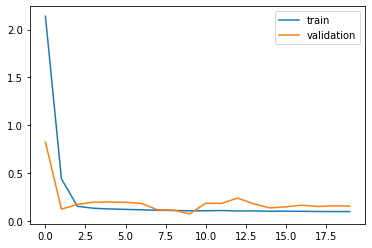


predict: [[30.97875949 19.7725375 ]]
real:      [[30.8 14.5]]

Train on 1722 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.8920 - mean_squared_error: 4.7900 - val_loss: 0.8292 - val_mean_squared_error: 1.0334
Epoch 2/1000
 - 1s - loss: 0.3004 - mean_squared_error: 0.2024 - val_loss: 0.1593 - val_mean_squared_error: 0.0264
Epoch 3/1000
 - 1s - loss: 0.1478 - mean_squared_error: 0.0370 - val_loss: 0.1278 - val_mean_squared_error: 0.0278
Epoch 4/1000
 - 1s - loss: 0.1334 - mean_squared_error: 0.0300 - val_loss: 0.1955 - val_mean_squared_error: 0.0518
Epoch 5/1000
 - 1s - loss: 0.1248 - mean_squared_error: 0.0276 - val_loss: 0.2441 - val_mean_squared_error: 0.0773
Epoch 6/1000
 - 1s - loss: 0.1199 - mean_squared_error: 0.0253 - val_loss: 0.2366 - val_mean_squared_error: 0.0736
Epoch 7/1000
 - 1s - loss: 0.1108 - mean_squared_error: 0.0222 - val_loss: 0.1929 - val_mean_squared_error: 0.0614
Epoch 8/1000
 - 1s - loss: 0.1063 - mean_squared_error: 0.0203 - val_loss: 0.2118 - v

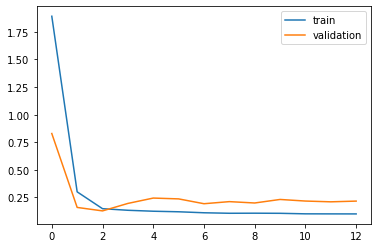


predict: [[27.59914623 17.65775546]]
real:      [[26.8 13.6]]

Train on 1721 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.3828 - mean_squared_error: 2.7372 - val_loss: 0.4433 - val_mean_squared_error: 0.2422
Epoch 2/1000
 - 1s - loss: 0.1941 - mean_squared_error: 0.0600 - val_loss: 0.2129 - val_mean_squared_error: 0.0625
Epoch 3/1000
 - 1s - loss: 0.1295 - mean_squared_error: 0.0293 - val_loss: 0.1484 - val_mean_squared_error: 0.0302
Epoch 4/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0264 - val_loss: 0.1732 - val_mean_squared_error: 0.0412
Epoch 5/1000
 - 1s - loss: 0.1204 - mean_squared_error: 0.0258 - val_loss: 0.1433 - val_mean_squared_error: 0.0305
Epoch 6/1000
 - 1s - loss: 0.1170 - mean_squared_error: 0.0245 - val_loss: 0.1493 - val_mean_squared_error: 0.0364
Epoch 7/1000
 - 1s - loss: 0.1103 - mean_squared_error: 0.0218 - val_loss: 0.1705 - val_mean_squared_error: 0.0392
Epoch 8/1000
 - 1s - loss: 0.1039 - mean_squared_error: 0.0196 - val_loss: 0.1712 - v

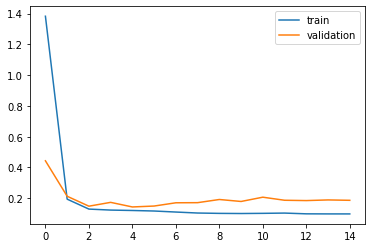


predict: [[28.12740677 18.15409091]]
real:      [[21.8 17.4]]

Train on 1720 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.4836 - mean_squared_error: 3.1366 - val_loss: 0.2339 - val_mean_squared_error: 0.0661
Epoch 2/1000
 - 1s - loss: 0.1998 - mean_squared_error: 0.0644 - val_loss: 0.1341 - val_mean_squared_error: 0.0196
Epoch 3/1000
 - 1s - loss: 0.1416 - mean_squared_error: 0.0344 - val_loss: 0.0903 - val_mean_squared_error: 0.0089
Epoch 4/1000
 - 1s - loss: 0.1357 - mean_squared_error: 0.0317 - val_loss: 0.0506 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.1307 - mean_squared_error: 0.0294 - val_loss: 0.0731 - val_mean_squared_error: 0.0060
Epoch 6/1000
 - 1s - loss: 0.1264 - mean_squared_error: 0.0279 - val_loss: 0.0470 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 1s - loss: 0.1206 - mean_squared_error: 0.0257 - val_loss: 0.0325 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.1104 - mean_squared_error: 0.0213 - val_loss: 0.0514 - v

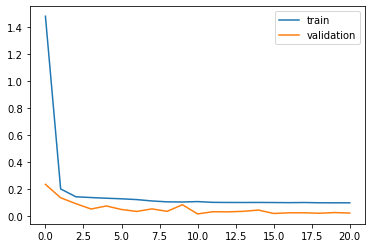


predict: [[29.98804912 19.81072211]]
real:      [[23.  18.4]]

Train on 1719 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 2.3852 - mean_squared_error: 6.0558 - val_loss: 1.7326 - val_mean_squared_error: 3.0086
Epoch 2/1000
 - 1s - loss: 0.7195 - mean_squared_error: 0.7874 - val_loss: 0.0854 - val_mean_squared_error: 0.0130
Epoch 3/1000
 - 1s - loss: 0.1691 - mean_squared_error: 0.0461 - val_loss: 0.0665 - val_mean_squared_error: 0.0084
Epoch 4/1000
 - 1s - loss: 0.1366 - mean_squared_error: 0.0329 - val_loss: 0.0886 - val_mean_squared_error: 0.0083
Epoch 5/1000
 - 1s - loss: 0.1322 - mean_squared_error: 0.0303 - val_loss: 0.0926 - val_mean_squared_error: 0.0111
Epoch 6/1000
 - 1s - loss: 0.1302 - mean_squared_error: 0.0294 - val_loss: 0.0807 - val_mean_squared_error: 0.0101
Epoch 7/1000
 - 1s - loss: 0.1301 - mean_squared_error: 0.0295 - val_loss: 0.0941 - val_mean_squared_error: 0.0102
Epoch 8/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0288 - val_loss: 0.0731 - v

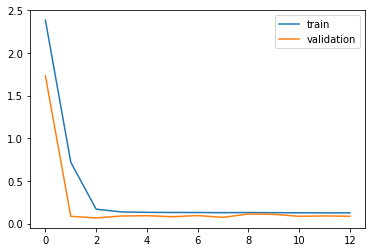


predict: [[29.41343127 19.67740439]]
real:      [[29.2 20.5]]

Train on 1718 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.1607 - mean_squared_error: 10.2200 - val_loss: 2.9192 - val_mean_squared_error: 8.6257
Epoch 2/1000
 - 1s - loss: 2.4505 - mean_squared_error: 6.2197 - val_loss: 2.0072 - val_mean_squared_error: 4.1623
Epoch 3/1000
 - 1s - loss: 1.1414 - mean_squared_error: 1.7611 - val_loss: 0.3462 - val_mean_squared_error: 0.2178
Epoch 4/1000
 - 1s - loss: 0.1939 - mean_squared_error: 0.0631 - val_loss: 0.1207 - val_mean_squared_error: 0.0215
Epoch 5/1000
 - 1s - loss: 0.1415 - mean_squared_error: 0.0326 - val_loss: 0.0660 - val_mean_squared_error: 0.0064
Epoch 6/1000
 - 1s - loss: 0.1345 - mean_squared_error: 0.0306 - val_loss: 0.0336 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.1328 - mean_squared_error: 0.0304 - val_loss: 0.0602 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.1305 - mean_squared_error: 0.0294 - val_loss: 0.0429 - 

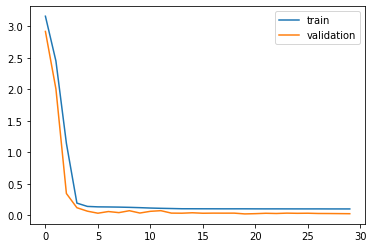


predict: [[30.71729803 19.30680011]]
real:      [[33.9 19.9]]

Train on 1717 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 2.9504 - mean_squared_error: 8.8385 - val_loss: 2.5709 - val_mean_squared_error: 6.6105
Epoch 2/1000
 - 1s - loss: 1.8200 - mean_squared_error: 3.6215 - val_loss: 0.8288 - val_mean_squared_error: 0.7436
Epoch 3/1000
 - 1s - loss: 0.3127 - mean_squared_error: 0.1808 - val_loss: 0.0202 - val_mean_squared_error: 6.4877e-04
Epoch 4/1000
 - 1s - loss: 0.1479 - mean_squared_error: 0.0357 - val_loss: 0.0521 - val_mean_squared_error: 0.0038
Epoch 5/1000
 - 1s - loss: 0.1357 - mean_squared_error: 0.0310 - val_loss: 0.0410 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.1350 - mean_squared_error: 0.0312 - val_loss: 0.0564 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.1342 - mean_squared_error: 0.0307 - val_loss: 0.0258 - val_mean_squared_error: 9.3531e-04
Epoch 8/1000
 - 1s - loss: 0.1344 - mean_squared_error: 0.0307 - val_loss: 0.

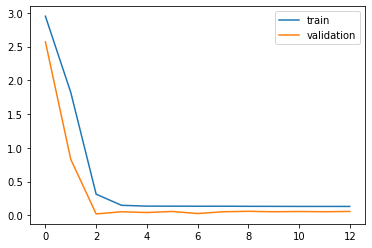


predict: [[28.49941892 18.81366783]]
real:      [[31. 19.]]

Train on 1716 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.0025 - mean_squared_error: 1.7331 - val_loss: 0.1826 - val_mean_squared_error: 0.0336
Epoch 2/1000
 - 1s - loss: 0.1670 - mean_squared_error: 0.0442 - val_loss: 0.1377 - val_mean_squared_error: 0.0251
Epoch 3/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0302 - val_loss: 0.0619 - val_mean_squared_error: 0.0040
Epoch 4/1000
 - 1s - loss: 0.1277 - mean_squared_error: 0.0292 - val_loss: 0.0712 - val_mean_squared_error: 0.0081
Epoch 5/1000
 - 1s - loss: 0.1219 - mean_squared_error: 0.0264 - val_loss: 0.0787 - val_mean_squared_error: 0.0062
Epoch 6/1000
 - 1s - loss: 0.1166 - mean_squared_error: 0.0243 - val_loss: 0.0831 - val_mean_squared_error: 0.0070
Epoch 7/1000
 - 1s - loss: 0.1124 - mean_squared_error: 0.0225 - val_loss: 0.0767 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 1s - loss: 0.1068 - mean_squared_error: 0.0209 - val_loss: 0.0768 - val

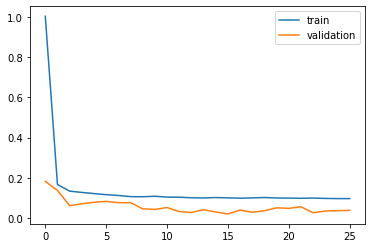


predict: [[30.67623277 20.24567398]]
real:      [[27.2 19.4]]

Train on 1715 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 2.4970 - mean_squared_error: 7.0117 - val_loss: 1.5406 - val_mean_squared_error: 4.0400
Epoch 2/1000
 - 1s - loss: 1.1969 - mean_squared_error: 2.4584 - val_loss: 0.9408 - val_mean_squared_error: 1.6211
Epoch 3/1000
 - 1s - loss: 0.5693 - mean_squared_error: 0.6167 - val_loss: 0.2478 - val_mean_squared_error: 0.0816
Epoch 4/1000
 - 1s - loss: 0.1507 - mean_squared_error: 0.0405 - val_loss: 0.1519 - val_mean_squared_error: 0.0272
Epoch 5/1000
 - 1s - loss: 0.1355 - mean_squared_error: 0.0311 - val_loss: 0.0884 - val_mean_squared_error: 0.0079
Epoch 6/1000
 - 1s - loss: 0.1280 - mean_squared_error: 0.0281 - val_loss: 0.0829 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 1s - loss: 0.1252 - mean_squared_error: 0.0279 - val_loss: 0.0793 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.1189 - mean_squared_error: 0.0257 - val_loss: 0.0925 - v

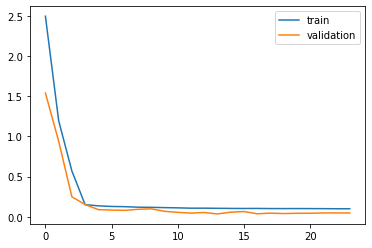


predict: [[29.13919036 19.74763611]]
real:      [[29.2 21. ]]

Train and validation time: 32.17350045442581

Maximum metrics
Test RMSE -------------------------- 3.978
Test VARIANCE ---------------------- 0.2113
Test MAX-ERROR --------------------- 8.619
Test MEAN-ABSOLUTE-ERROR ----------- 3.375
Test MEDIAN-ABSOLUTE-ERROR --------- 3.392

Errors
2018-12-31 = 4.106384343446081
2018-12-30 = 1.4399538567162864
2018-12-29 = 0.9776656238079369
2018-12-28 = 8.618607519445696
2018-12-27 = 3.8998279750678755
2018-12-26 = 5.694966188763747
2018-12-25 = 3.3679934918434284
2018-12-24 = 0.8148101179413381
2018-12-23 = 1.4014048381099613
2018-12-22 = 2.9354698167597633
2018-12-21 = 1.542884732484353
2018-12-20 = 3.416940095069574
2018-12-19 = 5.553500798572109
2018-12-18 = 4.172720478220235
2018-12-17 = 3.2311799644691988
2018-12-16 = 3.773499301457367
2018-12-15 = 5.3276450165815845
2018-12-14 = 2.9307903068683956
2018-12-13 = 4.5904583985174625
2018-12-12 = 4.8557983383749885
2018-12-11 = 4.861

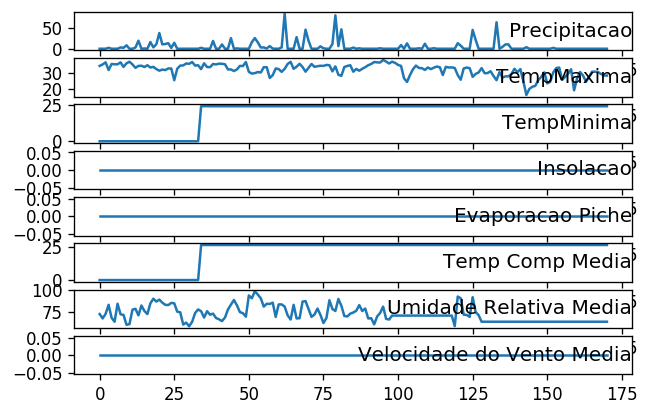

Train on 109 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.4487 - mean_squared_error: 11.9291 - val_loss: 3.2259 - val_mean_squared_error: 10.4421
Epoch 2/1000
 - 0s - loss: 3.2174 - mean_squared_error: 10.3877 - val_loss: 2.9774 - val_mean_squared_error: 8.8947
Epoch 3/1000
 - 0s - loss: 2.9976 - mean_squared_error: 9.0244 - val_loss: 2.7399 - val_mean_squared_error: 7.5349
Epoch 4/1000
 - 0s - loss: 2.7965 - mean_squared_error: 7.8693 - val_loss: 2.5804 - val_mean_squared_error: 6.7110
Epoch 5/1000
 - 0s - loss: 2.6258 - mean_squared_error: 6.9634 - val_loss: 2.4262 - val_mean_squared_error: 5.9734
Epoch 6/1000
 - 0s - loss: 2.4687 - mean_squared_error: 6.2035 - val_loss: 2.2854 - val_mean_squared_error: 5.3559
Epoch 7/1000
 - 0s - loss: 2.3108 - mean_squared_error: 5.4969 - val_loss: 2.1331 - val_mean_squared_error: 4.7363
Epoch 8/1000
 - 0s - loss: 2.1487 - mean_squared_error: 4.8196 - val_loss: 1.9646 - val_mean_squared_error: 4.1030
Epoch 9/1000
 - 0s - loss: 1.984

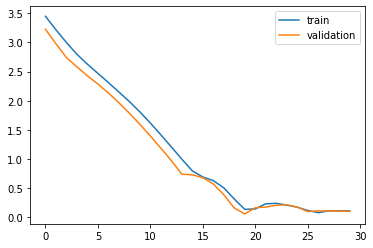


predict: [[27.07436124 26.62277763]]
real:      [[28.2 24. ]]

Train on 108 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.3015 - mean_squared_error: 11.0162 - val_loss: 3.1887 - val_mean_squared_error: 10.2449
Epoch 2/1000
 - 0s - loss: 3.1895 - mean_squared_error: 10.2764 - val_loss: 3.0847 - val_mean_squared_error: 9.5943
Epoch 3/1000
 - 0s - loss: 3.0789 - mean_squared_error: 9.5962 - val_loss: 2.9769 - val_mean_squared_error: 8.9872
Epoch 4/1000
 - 0s - loss: 2.9722 - mean_squared_error: 9.0071 - val_loss: 2.8621 - val_mean_squared_error: 8.3957
Epoch 5/1000
 - 0s - loss: 2.8616 - mean_squared_error: 8.4484 - val_loss: 2.7447 - val_mean_squared_error: 7.8514
Epoch 6/1000
 - 0s - loss: 2.7465 - mean_squared_error: 7.9216 - val_loss: 2.6249 - val_mean_squared_error: 7.3535
Epoch 7/1000
 - 0s - loss: 2.6266 - mean_squared_error: 7.4303 - val_loss: 2.5045 - val_mean_squared_error: 6.8959
Epoch 8/1000
 - 0s - loss: 2.5054 - mean_squared_error: 6.9760 - val_loss: 2.3823 -

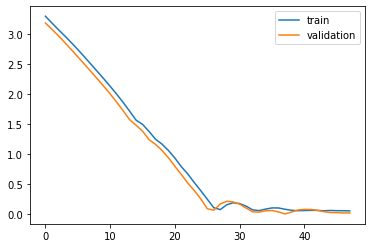


predict: [[29.04038344 23.78727673]]
real:      [[28.2 24. ]]

Train on 107 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.7290 - mean_squared_error: 13.9880 - val_loss: 3.6158 - val_mean_squared_error: 13.2165
Epoch 2/1000
 - 0s - loss: 3.5979 - mean_squared_error: 13.0846 - val_loss: 3.5304 - val_mean_squared_error: 12.5907
Epoch 3/1000
 - 0s - loss: 3.5058 - mean_squared_error: 12.4106 - val_loss: 3.4375 - val_mean_squared_error: 11.8906
Epoch 4/1000
 - 0s - loss: 3.4173 - mean_squared_error: 11.7412 - val_loss: 3.3481 - val_mean_squared_error: 11.2340
Epoch 5/1000
 - 0s - loss: 3.3328 - mean_squared_error: 11.1311 - val_loss: 3.2637 - val_mean_squared_error: 10.6537
Epoch 6/1000
 - 0s - loss: 3.2496 - mean_squared_error: 10.5701 - val_loss: 3.1844 - val_mean_squared_error: 10.1420
Epoch 7/1000
 - 0s - loss: 3.1833 - mean_squared_error: 10.1462 - val_loss: 3.1519 - val_mean_squared_error: 9.9424
Epoch 8/1000
 - 0s - loss: 3.1488 - mean_squared_error: 9.9340 - val_loss

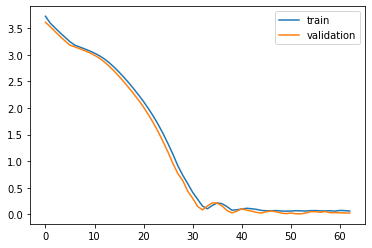


predict: [[30.8251107  23.83552352]]
real:      [[29.2 24. ]]

Train on 106 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.0375 - mean_squared_error: 9.2806 - val_loss: 2.8384 - val_mean_squared_error: 8.0698
Epoch 2/1000
 - 0s - loss: 2.8165 - mean_squared_error: 7.9575 - val_loss: 2.6196 - val_mean_squared_error: 6.8624
Epoch 3/1000
 - 0s - loss: 2.6028 - mean_squared_error: 6.7922 - val_loss: 2.4346 - val_mean_squared_error: 5.9365
Epoch 4/1000
 - 0s - loss: 2.3960 - mean_squared_error: 5.7683 - val_loss: 2.2844 - val_mean_squared_error: 5.2390
Epoch 5/1000
 - 0s - loss: 2.2429 - mean_squared_error: 5.0713 - val_loss: 2.1308 - val_mean_squared_error: 4.5770
Epoch 6/1000
 - 0s - loss: 2.0895 - mean_squared_error: 4.4251 - val_loss: 1.9710 - val_mean_squared_error: 3.9387
Epoch 7/1000
 - 0s - loss: 1.9299 - mean_squared_error: 3.7992 - val_loss: 1.8061 - val_mean_squared_error: 3.3317
Epoch 8/1000
 - 0s - loss: 1.7647 - mean_squared_error: 3.2034 - val_loss: 1.6370 - va

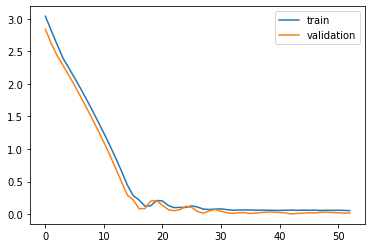


predict: [[30.91686416 24.10829862]]
real:      [[30.4 24. ]]

Train on 105 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.1668 - mean_squared_error: 10.0458 - val_loss: 2.9870 - val_mean_squared_error: 8.9353
Epoch 2/1000
 - 0s - loss: 2.9409 - mean_squared_error: 8.6816 - val_loss: 2.7501 - val_mean_squared_error: 7.5903
Epoch 3/1000
 - 0s - loss: 2.7055 - mean_squared_error: 7.3608 - val_loss: 2.5345 - val_mean_squared_error: 6.4546
Epoch 4/1000
 - 0s - loss: 2.5045 - mean_squared_error: 6.3149 - val_loss: 2.3343 - val_mean_squared_error: 5.4832
Epoch 5/1000
 - 0s - loss: 2.3077 - mean_squared_error: 5.3725 - val_loss: 2.1342 - val_mean_squared_error: 4.5958
Epoch 6/1000
 - 0s - loss: 2.1082 - mean_squared_error: 4.5006 - val_loss: 1.9483 - val_mean_squared_error: 3.8482
Epoch 7/1000
 - 0s - loss: 1.9101 - mean_squared_error: 3.7176 - val_loss: 1.7469 - val_mean_squared_error: 3.1214
Epoch 8/1000
 - 0s - loss: 1.7059 - mean_squared_error: 2.9976 - val_loss: 1.5295 - v

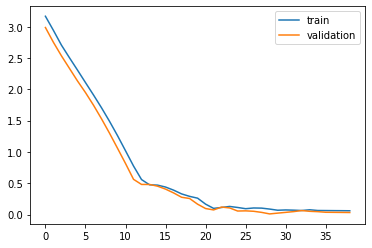


predict: [[30.0273345  24.05883485]]
real:      [[30.6 24. ]]

Train on 104 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.3266 - mean_squared_error: 11.1051 - val_loss: 3.0607 - val_mean_squared_error: 9.4108
Epoch 2/1000
 - 0s - loss: 3.0623 - mean_squared_error: 9.4705 - val_loss: 2.8310 - val_mean_squared_error: 8.0935
Epoch 3/1000
 - 0s - loss: 2.8451 - mean_squared_error: 8.2364 - val_loss: 2.6389 - val_mean_squared_error: 7.0881
Epoch 4/1000
 - 0s - loss: 2.6557 - mean_squared_error: 7.2387 - val_loss: 2.4669 - val_mean_squared_error: 6.2363
Epoch 5/1000
 - 0s - loss: 2.4902 - mean_squared_error: 6.4078 - val_loss: 2.3118 - val_mean_squared_error: 5.5051
Epoch 6/1000
 - 0s - loss: 2.3371 - mean_squared_error: 5.6830 - val_loss: 2.1627 - val_mean_squared_error: 4.8445
Epoch 7/1000
 - 0s - loss: 2.1872 - mean_squared_error: 5.0120 - val_loss: 2.0173 - val_mean_squared_error: 4.2418
Epoch 8/1000
 - 0s - loss: 2.0405 - mean_squared_error: 4.3961 - val_loss: 1.8758 - v

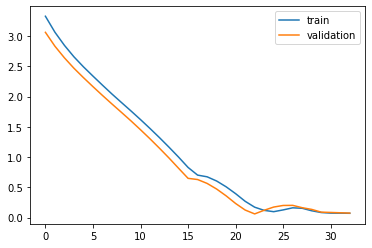


predict: [[26.2123751  21.81395713]]
real:      [[30.6 24. ]]

Train on 103 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.0795 - mean_squared_error: 9.5882 - val_loss: 2.7493 - val_mean_squared_error: 7.5780
Epoch 2/1000
 - 0s - loss: 2.8259 - mean_squared_error: 8.0719 - val_loss: 2.5321 - val_mean_squared_error: 6.4311
Epoch 3/1000
 - 0s - loss: 2.6042 - mean_squared_error: 6.8683 - val_loss: 2.2954 - val_mean_squared_error: 5.2899
Epoch 4/1000
 - 0s - loss: 2.3626 - mean_squared_error: 5.6736 - val_loss: 2.0344 - val_mean_squared_error: 4.1602
Epoch 5/1000
 - 0s - loss: 2.1114 - mean_squared_error: 4.5448 - val_loss: 1.7823 - val_mean_squared_error: 3.1948
Epoch 6/1000
 - 0s - loss: 1.8518 - mean_squared_error: 3.5027 - val_loss: 1.5073 - val_mean_squared_error: 2.2831
Epoch 7/1000
 - 0s - loss: 1.5777 - mean_squared_error: 2.5459 - val_loss: 1.2088 - val_mean_squared_error: 1.4665
Epoch 8/1000
 - 0s - loss: 1.2706 - mean_squared_error: 1.6597 - val_loss: 0.8813 - va

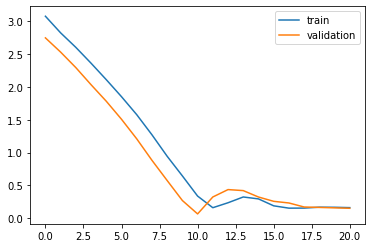


predict: [[24.78096455 25.93045902]]
real:      [[27.4 24. ]]

Train on 102 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.0836 - mean_squared_error: 9.5995 - val_loss: 2.8709 - val_mean_squared_error: 8.2496
Epoch 2/1000
 - 0s - loss: 2.8866 - mean_squared_error: 8.3672 - val_loss: 2.7319 - val_mean_squared_error: 7.4676
Epoch 3/1000
 - 0s - loss: 2.7448 - mean_squared_error: 7.5627 - val_loss: 2.5841 - val_mean_squared_error: 6.6842
Epoch 4/1000
 - 0s - loss: 2.5966 - mean_squared_error: 6.7761 - val_loss: 2.4284 - val_mean_squared_error: 5.9158
Epoch 5/1000
 - 0s - loss: 2.4404 - mean_squared_error: 6.0104 - val_loss: 2.2697 - val_mean_squared_error: 5.2126
Epoch 6/1000
 - 0s - loss: 2.2824 - mean_squared_error: 5.3204 - val_loss: 2.1162 - val_mean_squared_error: 4.6147
Epoch 7/1000
 - 0s - loss: 2.1299 - mean_squared_error: 4.7281 - val_loss: 1.9686 - val_mean_squared_error: 4.0883
Epoch 8/1000
 - 0s - loss: 1.9818 - mean_squared_error: 4.2083 - val_loss: 1.8213 - va

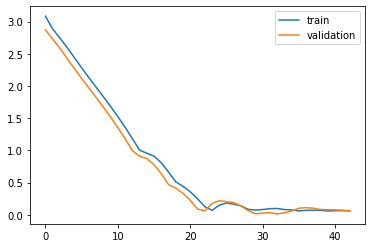


predict: [[28.37576771 23.3384608 ]]
real:      [[24.3 24. ]]

Train on 101 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.2253 - mean_squared_error: 10.4132 - val_loss: 3.1071 - val_mean_squared_error: 9.6540
Epoch 2/1000
 - 0s - loss: 3.0859 - mean_squared_error: 9.5331 - val_loss: 2.9764 - val_mean_squared_error: 8.8587
Epoch 3/1000
 - 0s - loss: 2.9591 - mean_squared_error: 8.7674 - val_loss: 2.8607 - val_mean_squared_error: 8.1848
Epoch 4/1000
 - 0s - loss: 2.8447 - mean_squared_error: 8.1046 - val_loss: 2.7514 - val_mean_squared_error: 7.5737
Epoch 5/1000
 - 0s - loss: 2.7351 - mean_squared_error: 7.4951 - val_loss: 2.6399 - val_mean_squared_error: 6.9746
Epoch 6/1000
 - 0s - loss: 2.6238 - mean_squared_error: 6.9007 - val_loss: 2.5238 - val_mean_squared_error: 6.3777
Epoch 7/1000
 - 0s - loss: 2.5080 - mean_squared_error: 6.3098 - val_loss: 2.4022 - val_mean_squared_error: 5.7819
Epoch 8/1000
 - 0s - loss: 2.3869 - mean_squared_error: 5.7197 - val_loss: 2.2772 - v

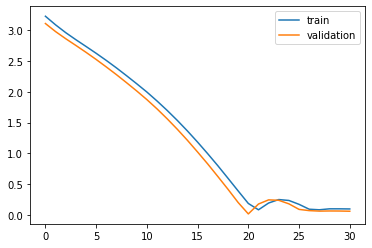


predict: [[30.73865272 24.34584963]]
real:      [[28.2 24. ]]

Train on 100 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.4832 - mean_squared_error: 12.2911 - val_loss: 3.2721 - val_mean_squared_error: 10.8258
Epoch 2/1000
 - 0s - loss: 3.2836 - mean_squared_error: 10.9944 - val_loss: 3.0428 - val_mean_squared_error: 9.4299
Epoch 3/1000
 - 0s - loss: 3.0778 - mean_squared_error: 9.7160 - val_loss: 2.8505 - val_mean_squared_error: 8.2968
Epoch 4/1000
 - 0s - loss: 2.8784 - mean_squared_error: 8.5246 - val_loss: 2.6364 - val_mean_squared_error: 7.0992
Epoch 5/1000
 - 0s - loss: 2.6682 - mean_squared_error: 7.3425 - val_loss: 2.4055 - val_mean_squared_error: 5.9038
Epoch 6/1000
 - 0s - loss: 2.4411 - mean_squared_error: 6.1495 - val_loss: 2.1526 - val_mean_squared_error: 4.7140
Epoch 7/1000
 - 0s - loss: 2.1935 - mean_squared_error: 4.9602 - val_loss: 1.8880 - val_mean_squared_error: 3.6115
Epoch 8/1000
 - 0s - loss: 1.9351 - mean_squared_error: 3.8512 - val_loss: 1.6446 -

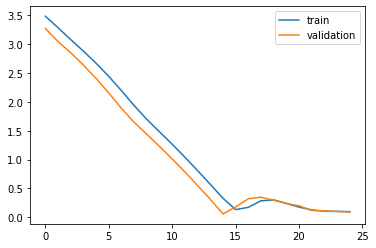


predict: [[23.21110585 23.35835492]]
real:      [[30.4 24. ]]

Train on 99 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.2203 - mean_squared_error: 10.4166 - val_loss: 2.7465 - val_mean_squared_error: 7.5453
Epoch 2/1000
 - 0s - loss: 2.9078 - mean_squared_error: 8.5263 - val_loss: 2.4602 - val_mean_squared_error: 6.0584
Epoch 3/1000
 - 0s - loss: 2.5989 - mean_squared_error: 6.8546 - val_loss: 2.1875 - val_mean_squared_error: 4.8046
Epoch 4/1000
 - 0s - loss: 2.3654 - mean_squared_error: 5.7474 - val_loss: 1.9382 - val_mean_squared_error: 3.8010
Epoch 5/1000
 - 0s - loss: 2.1329 - mean_squared_error: 4.7677 - val_loss: 1.7020 - val_mean_squared_error: 2.9867
Epoch 6/1000
 - 0s - loss: 1.8981 - mean_squared_error: 3.9145 - val_loss: 1.4607 - val_mean_squared_error: 2.2878
Epoch 7/1000
 - 0s - loss: 1.6576 - mean_squared_error: 3.1742 - val_loss: 1.2122 - val_mean_squared_error: 1.7042
Epoch 8/1000
 - 0s - loss: 1.4069 - mean_squared_error: 2.5360 - val_loss: 0.9572 - va

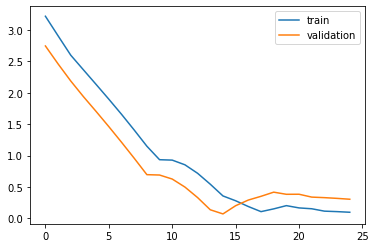


predict: [[18.01257846 21.45291372]]
real:      [[26.4 24. ]]

Train on 98 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.6676 - mean_squared_error: 13.4695 - val_loss: 3.4860 - val_mean_squared_error: 12.1529
Epoch 2/1000
 - 0s - loss: 3.4476 - mean_squared_error: 11.8983 - val_loss: 3.2985 - val_mean_squared_error: 10.8894
Epoch 3/1000
 - 0s - loss: 3.2542 - mean_squared_error: 10.6099 - val_loss: 3.1338 - val_mean_squared_error: 9.8532
Epoch 4/1000
 - 0s - loss: 3.0910 - mean_squared_error: 9.5988 - val_loss: 2.9859 - val_mean_squared_error: 8.9805
Epoch 5/1000
 - 0s - loss: 2.9512 - mean_squared_error: 8.7818 - val_loss: 2.8758 - val_mean_squared_error: 8.3589
Epoch 6/1000
 - 0s - loss: 2.8394 - mean_squared_error: 8.1576 - val_loss: 2.7640 - val_mean_squared_error: 7.7548
Epoch 7/1000
 - 0s - loss: 2.7256 - mean_squared_error: 7.5503 - val_loss: 2.6482 - val_mean_squared_error: 7.1578
Epoch 8/1000
 - 0s - loss: 2.6069 - mean_squared_error: 6.9470 - val_loss: 2.5257 

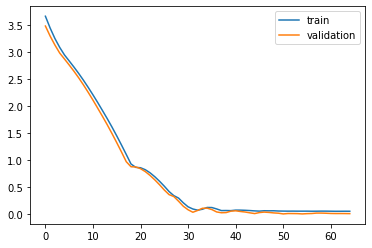


predict: [[31.98101531 24.07793062]]
real:      [[19. 24.]]

Train on 97 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.2913 - mean_squared_error: 10.8852 - val_loss: 3.0036 - val_mean_squared_error: 9.1077
Epoch 2/1000
 - 0s - loss: 3.0160 - mean_squared_error: 9.2341 - val_loss: 2.7466 - val_mean_squared_error: 7.7064
Epoch 3/1000
 - 0s - loss: 2.7634 - mean_squared_error: 7.8630 - val_loss: 2.5042 - val_mean_squared_error: 6.4907
Epoch 4/1000
 - 0s - loss: 2.5213 - mean_squared_error: 6.6510 - val_loss: 2.2641 - val_mean_squared_error: 5.3868
Epoch 5/1000
 - 0s - loss: 2.2790 - mean_squared_error: 5.5384 - val_loss: 2.0417 - val_mean_squared_error: 4.4972
Epoch 6/1000
 - 0s - loss: 2.0442 - mean_squared_error: 4.5900 - val_loss: 1.8282 - val_mean_squared_error: 3.7682
Epoch 7/1000
 - 0s - loss: 1.8236 - mean_squared_error: 3.8467 - val_loss: 1.6205 - val_mean_squared_error: 3.1877
Epoch 8/1000
 - 0s - loss: 1.6111 - mean_squared_error: 3.2656 - val_loss: 1.4209 - val_

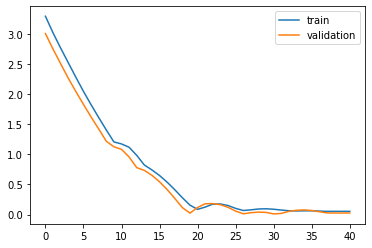


predict: [[28.8138781  23.73768453]]
real:      [[32.1 24. ]]

Train on 96 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.7427 - mean_squared_error: 14.0518 - val_loss: 3.5357 - val_mean_squared_error: 12.5221
Epoch 2/1000
 - 0s - loss: 3.5658 - mean_squared_error: 12.7589 - val_loss: 3.3733 - val_mean_squared_error: 11.4121
Epoch 3/1000
 - 0s - loss: 3.4018 - mean_squared_error: 11.6333 - val_loss: 3.1986 - val_mean_squared_error: 10.2875
Epoch 4/1000
 - 0s - loss: 3.2285 - mean_squared_error: 10.5121 - val_loss: 3.0360 - val_mean_squared_error: 9.3006
Epoch 5/1000
 - 0s - loss: 3.0820 - mean_squared_error: 9.6148 - val_loss: 2.9337 - val_mean_squared_error: 8.7081
Epoch 6/1000
 - 0s - loss: 2.9810 - mean_squared_error: 9.0238 - val_loss: 2.8296 - val_mean_squared_error: 8.1320
Epoch 7/1000
 - 0s - loss: 2.8761 - mean_squared_error: 8.4357 - val_loss: 2.7236 - val_mean_squared_error: 7.5704
Epoch 8/1000
 - 0s - loss: 2.7694 - mean_squared_error: 7.8632 - val_loss: 2.614

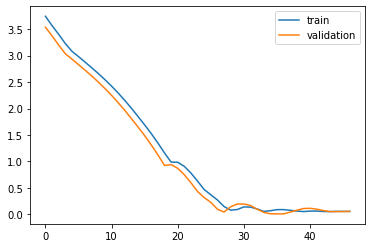


predict: [[27.61502426 23.60432755]]
real:      [[29.4 24. ]]

Train on 95 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.7046 - mean_squared_error: 13.8015 - val_loss: 3.3021 - val_mean_squared_error: 10.9304
Epoch 2/1000
 - 0s - loss: 3.3944 - mean_squared_error: 11.5949 - val_loss: 3.1507 - val_mean_squared_error: 9.9399
Epoch 3/1000
 - 0s - loss: 3.2462 - mean_squared_error: 10.5909 - val_loss: 3.0356 - val_mean_squared_error: 9.2272
Epoch 4/1000
 - 0s - loss: 3.1296 - mean_squared_error: 9.8473 - val_loss: 2.9571 - val_mean_squared_error: 8.7600
Epoch 5/1000
 - 0s - loss: 3.0513 - mean_squared_error: 9.3669 - val_loss: 2.8755 - val_mean_squared_error: 8.2848
Epoch 6/1000
 - 0s - loss: 2.9697 - mean_squared_error: 8.8764 - val_loss: 2.7914 - val_mean_squared_error: 7.8090
Epoch 7/1000
 - 0s - loss: 2.8817 - mean_squared_error: 8.3630 - val_loss: 2.7066 - val_mean_squared_error: 7.3446
Epoch 8/1000
 - 0s - loss: 2.7942 - mean_squared_error: 7.8698 - val_loss: 2.6182 -

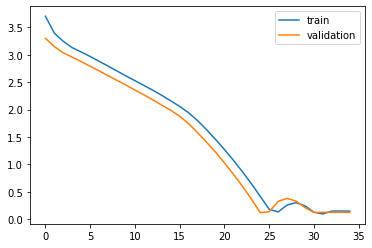


predict: [[22.57537515 20.68639167]]
real:      [[27.4 24. ]]

Train on 94 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.1749 - mean_squared_error: 10.1134 - val_loss: 3.0467 - val_mean_squared_error: 9.2980
Epoch 2/1000
 - 0s - loss: 3.0064 - mean_squared_error: 9.0741 - val_loss: 2.9204 - val_mean_squared_error: 8.5667
Epoch 3/1000
 - 0s - loss: 2.8909 - mean_squared_error: 8.4208 - val_loss: 2.7751 - val_mean_squared_error: 7.7875
Epoch 4/1000
 - 0s - loss: 2.7472 - mean_squared_error: 7.6687 - val_loss: 2.6155 - val_mean_squared_error: 7.0011
Epoch 5/1000
 - 0s - loss: 2.5831 - mean_squared_error: 6.8745 - val_loss: 2.4461 - val_mean_squared_error: 6.2452
Epoch 6/1000
 - 0s - loss: 2.4080 - mean_squared_error: 6.1123 - val_loss: 2.2697 - val_mean_squared_error: 5.5498
Epoch 7/1000
 - 0s - loss: 2.2259 - mean_squared_error: 5.4169 - val_loss: 2.0863 - val_mean_squared_error: 4.9319
Epoch 8/1000
 - 0s - loss: 2.0376 - mean_squared_error: 4.8078 - val_loss: 1.8952 - va

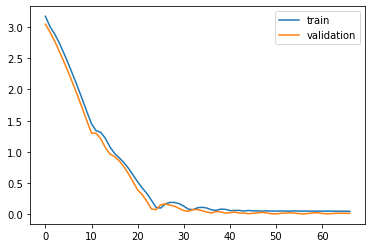


predict: [[33.79292835 24.18116745]]
real:      [[25.5 24. ]]

Train on 93 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.6405 - mean_squared_error: 13.2710 - val_loss: 3.3351 - val_mean_squared_error: 11.1233
Epoch 2/1000
 - 0s - loss: 3.3089 - mean_squared_error: 10.9702 - val_loss: 3.0504 - val_mean_squared_error: 9.3081
Epoch 3/1000
 - 0s - loss: 3.0267 - mean_squared_error: 9.1830 - val_loss: 2.8167 - val_mean_squared_error: 7.9373
Epoch 4/1000
 - 0s - loss: 2.7790 - mean_squared_error: 7.7473 - val_loss: 2.5830 - val_mean_squared_error: 6.6751
Epoch 5/1000
 - 0s - loss: 2.5308 - mean_squared_error: 6.4313 - val_loss: 2.3306 - val_mean_squared_error: 5.4424
Epoch 6/1000
 - 0s - loss: 2.2716 - mean_squared_error: 5.1961 - val_loss: 2.0640 - val_mean_squared_error: 4.2828
Epoch 7/1000
 - 0s - loss: 2.0076 - mean_squared_error: 4.0760 - val_loss: 1.8150 - val_mean_squared_error: 3.3269
Epoch 8/1000
 - 0s - loss: 1.7630 - mean_squared_error: 3.1628 - val_loss: 1.5830 - 

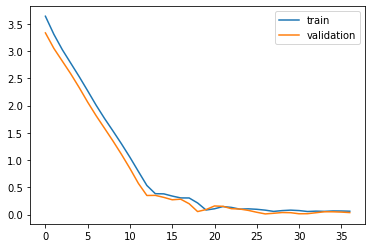


predict: [[33.14992153 24.46397309]]
real:      [[33.2 24. ]]

Train on 92 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.0840 - mean_squared_error: 9.5862 - val_loss: 2.8294 - val_mean_squared_error: 8.1379
Epoch 2/1000
 - 0s - loss: 2.8273 - mean_squared_error: 8.1603 - val_loss: 2.5831 - val_mean_squared_error: 6.8493
Epoch 3/1000
 - 0s - loss: 2.5990 - mean_squared_error: 6.9645 - val_loss: 2.3595 - val_mean_squared_error: 5.7890
Epoch 4/1000
 - 0s - loss: 2.3694 - mean_squared_error: 5.8701 - val_loss: 2.1340 - val_mean_squared_error: 4.8142
Epoch 5/1000
 - 0s - loss: 2.1376 - mean_squared_error: 4.8660 - val_loss: 1.9145 - val_mean_squared_error: 3.9688
Epoch 6/1000
 - 0s - loss: 1.9073 - mean_squared_error: 3.9780 - val_loss: 1.6908 - val_mean_squared_error: 3.2120
Epoch 7/1000
 - 0s - loss: 1.6799 - mean_squared_error: 3.2142 - val_loss: 1.4557 - val_mean_squared_error: 2.5229
Epoch 8/1000
 - 0s - loss: 1.4435 - mean_squared_error: 2.5295 - val_loss: 1.2158 - val

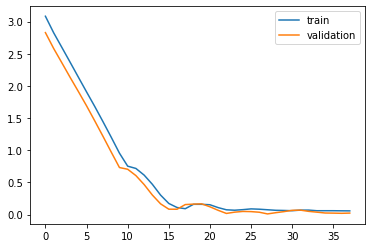


predict: [[30.62291383 24.68645504]]
real:      [[32.8 24. ]]

Train on 91 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 2.5104 - mean_squared_error: 6.3513 - val_loss: 2.1328 - val_mean_squared_error: 4.5986
Epoch 2/1000
 - 0s - loss: 2.2135 - mean_squared_error: 4.9232 - val_loss: 1.8474 - val_mean_squared_error: 3.4353
Epoch 3/1000
 - 0s - loss: 1.9444 - mean_squared_error: 3.7979 - val_loss: 1.5608 - val_mean_squared_error: 2.4454
Epoch 4/1000
 - 0s - loss: 1.6660 - mean_squared_error: 2.7909 - val_loss: 1.2631 - val_mean_squared_error: 1.6007
Epoch 5/1000
 - 0s - loss: 1.3715 - mean_squared_error: 1.8994 - val_loss: 0.9540 - val_mean_squared_error: 0.9158
Epoch 6/1000
 - 0s - loss: 1.0569 - mean_squared_error: 1.1369 - val_loss: 0.6307 - val_mean_squared_error: 0.4093
Epoch 7/1000
 - 0s - loss: 0.7277 - mean_squared_error: 0.5460 - val_loss: 0.2908 - val_mean_squared_error: 0.1133
Epoch 8/1000
 - 0s - loss: 0.3876 - mean_squared_error: 0.1671 - val_loss: 0.2300 - val

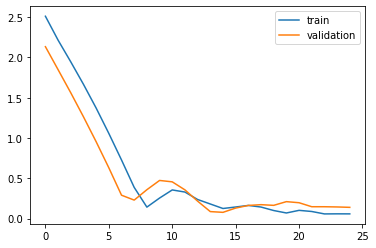


predict: [[24.77696339 22.1026795 ]]
real:      [[30.1 24. ]]

Train on 90 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.4699 - mean_squared_error: 12.0685 - val_loss: 3.1419 - val_mean_squared_error: 9.8722
Epoch 2/1000
 - 0s - loss: 3.2309 - mean_squared_error: 10.4554 - val_loss: 2.9714 - val_mean_squared_error: 8.8351
Epoch 3/1000
 - 0s - loss: 3.0814 - mean_squared_error: 9.5073 - val_loss: 2.8517 - val_mean_squared_error: 8.1422
Epoch 4/1000
 - 0s - loss: 2.9845 - mean_squared_error: 8.9182 - val_loss: 2.7391 - val_mean_squared_error: 7.5161
Epoch 5/1000
 - 0s - loss: 2.8756 - mean_squared_error: 8.2793 - val_loss: 2.6333 - val_mean_squared_error: 6.9520
Epoch 6/1000
 - 0s - loss: 2.7665 - mean_squared_error: 7.6637 - val_loss: 2.5351 - val_mean_squared_error: 6.4488
Epoch 7/1000
 - 0s - loss: 2.6630 - mean_squared_error: 7.1013 - val_loss: 2.4339 - val_mean_squared_error: 5.9503
Epoch 8/1000
 - 0s - loss: 2.5595 - mean_squared_error: 6.5622 - val_loss: 2.3302 - v

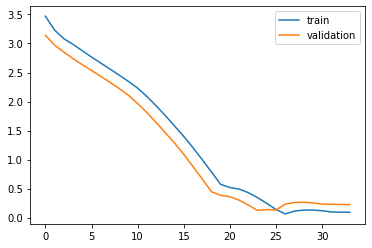


predict: [[23.46225108 30.41680286]]
real:      [[24.3 24. ]]

Train on 89 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.0814 - mean_squared_error: 9.5114 - val_loss: 2.8225 - val_mean_squared_error: 7.9685
Epoch 2/1000
 - 0s - loss: 2.8254 - mean_squared_error: 7.9975 - val_loss: 2.5808 - val_mean_squared_error: 6.6696
Epoch 3/1000
 - 0s - loss: 2.5795 - mean_squared_error: 6.6724 - val_loss: 2.3338 - val_mean_squared_error: 5.4711
Epoch 4/1000
 - 0s - loss: 2.3288 - mean_squared_error: 5.4565 - val_loss: 2.0867 - val_mean_squared_error: 4.4018
Epoch 5/1000
 - 0s - loss: 2.0749 - mean_squared_error: 4.3618 - val_loss: 1.8186 - val_mean_squared_error: 3.3910
Epoch 6/1000
 - 0s - loss: 1.8044 - mean_squared_error: 3.3469 - val_loss: 1.5381 - val_mean_squared_error: 2.4986
Epoch 7/1000
 - 0s - loss: 1.5203 - mean_squared_error: 2.4551 - val_loss: 1.2479 - val_mean_squared_error: 1.7542
Epoch 8/1000
 - 0s - loss: 1.2278 - mean_squared_error: 1.7143 - val_loss: 0.9504 - val

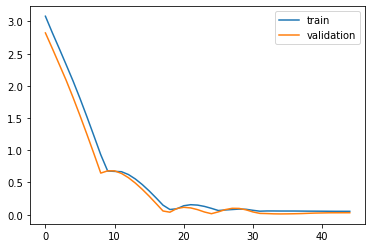


predict: [[31.15588107 23.83291831]]
real:      [[23.3 24. ]]

Train on 88 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.4332 - mean_squared_error: 11.8334 - val_loss: 3.1171 - val_mean_squared_error: 9.7178
Epoch 2/1000
 - 0s - loss: 3.1635 - mean_squared_error: 10.0368 - val_loss: 2.9122 - val_mean_squared_error: 8.4828
Epoch 3/1000
 - 0s - loss: 2.9764 - mean_squared_error: 8.8853 - val_loss: 2.7664 - val_mean_squared_error: 7.6553
Epoch 4/1000
 - 0s - loss: 2.8252 - mean_squared_error: 8.0066 - val_loss: 2.6170 - val_mean_squared_error: 6.8514
Epoch 5/1000
 - 0s - loss: 2.6741 - mean_squared_error: 7.1762 - val_loss: 2.4629 - val_mean_squared_error: 6.0683
Epoch 6/1000
 - 0s - loss: 2.5190 - mean_squared_error: 6.3711 - val_loss: 2.3058 - val_mean_squared_error: 5.3190
Epoch 7/1000
 - 0s - loss: 2.3630 - mean_squared_error: 5.6081 - val_loss: 2.1558 - val_mean_squared_error: 4.6490
Epoch 8/1000
 - 0s - loss: 2.2097 - mean_squared_error: 4.9055 - val_loss: 2.0019 - v

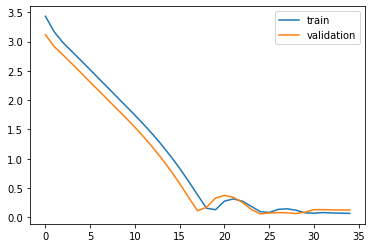


predict: [[29.56317919 23.20279505]]
real:      [[30.2 24. ]]

Train on 87 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.3348 - mean_squared_error: 11.1437 - val_loss: 3.0528 - val_mean_squared_error: 9.3198
Epoch 2/1000
 - 0s - loss: 3.0929 - mean_squared_error: 9.5819 - val_loss: 2.8399 - val_mean_squared_error: 8.0657
Epoch 3/1000
 - 0s - loss: 2.8922 - mean_squared_error: 8.3790 - val_loss: 2.6606 - val_mean_squared_error: 7.0890
Epoch 4/1000
 - 0s - loss: 2.7372 - mean_squared_error: 7.5086 - val_loss: 2.5137 - val_mean_squared_error: 6.3522
Epoch 5/1000
 - 0s - loss: 2.5877 - mean_squared_error: 6.7272 - val_loss: 2.3717 - val_mean_squared_error: 5.7124
Epoch 6/1000
 - 0s - loss: 2.4394 - mean_squared_error: 6.0148 - val_loss: 2.2180 - val_mean_squared_error: 5.0866
Epoch 7/1000
 - 0s - loss: 2.2850 - mean_squared_error: 5.3471 - val_loss: 2.0556 - val_mean_squared_error: 4.4914
Epoch 8/1000
 - 0s - loss: 2.1243 - mean_squared_error: 4.7179 - val_loss: 1.8895 - va

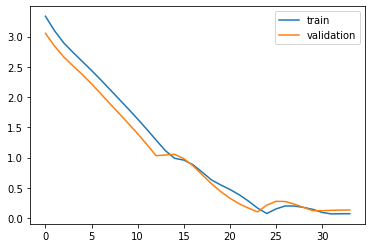


predict: [[30.28834454 23.43275183]]
real:      [[27.4 24. ]]

Train on 86 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.8801 - mean_squared_error: 15.0704 - val_loss: 3.4255 - val_mean_squared_error: 11.7843
Epoch 2/1000
 - 0s - loss: 3.6245 - mean_squared_error: 13.1517 - val_loss: 3.2559 - val_mean_squared_error: 10.6284
Epoch 3/1000
 - 0s - loss: 3.4357 - mean_squared_error: 11.8140 - val_loss: 3.0702 - val_mean_squared_error: 9.4346
Epoch 4/1000
 - 0s - loss: 3.2438 - mean_squared_error: 10.5374 - val_loss: 2.8885 - val_mean_squared_error: 8.3433
Epoch 5/1000
 - 0s - loss: 3.0514 - mean_squared_error: 9.3491 - val_loss: 2.7882 - val_mean_squared_error: 7.7787
Epoch 6/1000
 - 0s - loss: 2.9299 - mean_squared_error: 8.6561 - val_loss: 2.6409 - val_mean_squared_error: 6.9894
Epoch 7/1000
 - 0s - loss: 2.7839 - mean_squared_error: 7.8563 - val_loss: 2.4837 - val_mean_squared_error: 6.1972
Epoch 8/1000
 - 0s - loss: 2.6294 - mean_squared_error: 7.0496 - val_loss: 2.3265

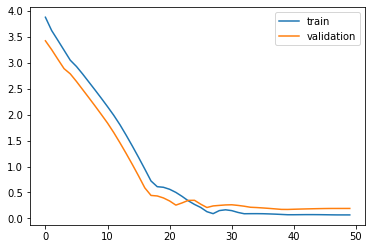


predict: [[30.24796131 23.48841689]]
real:      [[25.4 24. ]]

Train on 85 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.2930 - mean_squared_error: 10.9158 - val_loss: 2.8517 - val_mean_squared_error: 8.1355
Epoch 2/1000
 - 0s - loss: 3.0118 - mean_squared_error: 9.1485 - val_loss: 2.5399 - val_mean_squared_error: 6.4574
Epoch 3/1000
 - 0s - loss: 2.7278 - mean_squared_error: 7.5219 - val_loss: 2.3216 - val_mean_squared_error: 5.3940
Epoch 4/1000
 - 0s - loss: 2.4958 - mean_squared_error: 6.3020 - val_loss: 2.0943 - val_mean_squared_error: 4.3907
Epoch 5/1000
 - 0s - loss: 2.2709 - mean_squared_error: 5.2312 - val_loss: 1.8718 - val_mean_squared_error: 3.5115
Epoch 6/1000
 - 0s - loss: 2.0529 - mean_squared_error: 4.2986 - val_loss: 1.6667 - val_mean_squared_error: 2.7906
Epoch 7/1000
 - 0s - loss: 1.8493 - mean_squared_error: 3.5167 - val_loss: 1.4694 - val_mean_squared_error: 2.1769
Epoch 8/1000
 - 0s - loss: 1.6528 - mean_squared_error: 2.8407 - val_loss: 1.2791 - va

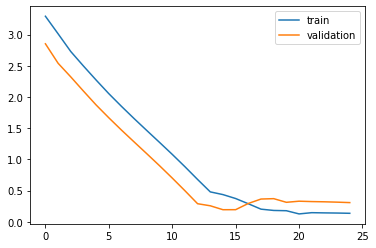


predict: [[18.50746206 31.24074667]]
real:      [[21.8 24. ]]

Train on 84 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 2.8819 - mean_squared_error: 8.5304 - val_loss: 2.4307 - val_mean_squared_error: 6.0475
Epoch 2/1000
 - 0s - loss: 2.6667 - mean_squared_error: 7.4847 - val_loss: 2.2056 - val_mean_squared_error: 5.1498
Epoch 3/1000
 - 0s - loss: 2.4461 - mean_squared_error: 6.5631 - val_loss: 1.9801 - val_mean_squared_error: 4.3787
Epoch 4/1000
 - 0s - loss: 2.2213 - mean_squared_error: 5.7533 - val_loss: 1.7392 - val_mean_squared_error: 3.7156
Epoch 5/1000
 - 0s - loss: 1.9797 - mean_squared_error: 5.0345 - val_loss: 1.4876 - val_mean_squared_error: 3.2113
Epoch 6/1000
 - 0s - loss: 1.7252 - mean_squared_error: 4.4707 - val_loss: 1.2230 - val_mean_squared_error: 2.9194
Epoch 7/1000
 - 0s - loss: 1.4832 - mean_squared_error: 4.1329 - val_loss: 1.3095 - val_mean_squared_error: 2.7032
Epoch 8/1000
 - 0s - loss: 1.5073 - mean_squared_error: 3.8211 - val_loss: 1.2323 - val

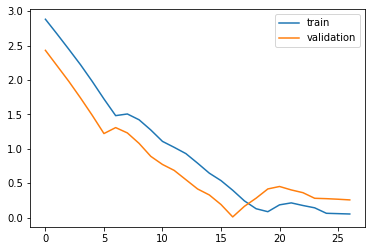


predict: [[19.39305529 23.80422576]]
real:      [[21.2 24. ]]

Train on 83 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.2456 - mean_squared_error: 10.5882 - val_loss: 2.8811 - val_mean_squared_error: 8.3193
Epoch 2/1000
 - 0s - loss: 2.9311 - mean_squared_error: 8.6529 - val_loss: 2.5919 - val_mean_squared_error: 6.7300
Epoch 3/1000
 - 0s - loss: 2.6314 - mean_squared_error: 6.9962 - val_loss: 2.1103 - val_mean_squared_error: 4.4568
Epoch 4/1000
 - 0s - loss: 2.3779 - mean_squared_error: 5.7450 - val_loss: 1.8556 - val_mean_squared_error: 3.4432
Epoch 5/1000
 - 0s - loss: 2.1465 - mean_squared_error: 4.7267 - val_loss: 1.6272 - val_mean_squared_error: 2.6498
Epoch 6/1000
 - 0s - loss: 1.9222 - mean_squared_error: 3.8467 - val_loss: 1.3964 - val_mean_squared_error: 1.9546
Epoch 7/1000
 - 0s - loss: 1.6952 - mean_squared_error: 3.0527 - val_loss: 1.1613 - val_mean_squared_error: 1.3551
Epoch 8/1000
 - 0s - loss: 1.4623 - mean_squared_error: 2.3292 - val_loss: 0.9157 - va

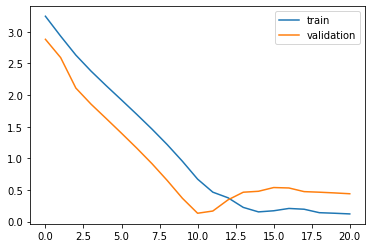


predict: [[12.93384781 26.16934225]]
real:      [[19.9 24. ]]

Train on 82 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.2835 - mean_squared_error: 10.7969 - val_loss: 2.8728 - val_mean_squared_error: 8.2590
Epoch 2/1000
 - 0s - loss: 3.0208 - mean_squared_error: 9.1352 - val_loss: 2.6462 - val_mean_squared_error: 7.0120
Epoch 3/1000
 - 0s - loss: 2.7846 - mean_squared_error: 7.7630 - val_loss: 2.4171 - val_mean_squared_error: 5.8594
Epoch 4/1000
 - 0s - loss: 2.5559 - mean_squared_error: 6.5390 - val_loss: 2.1874 - val_mean_squared_error: 4.8139
Epoch 5/1000
 - 0s - loss: 2.3258 - mean_squared_error: 5.4157 - val_loss: 1.9606 - val_mean_squared_error: 3.8908
Epoch 6/1000
 - 0s - loss: 2.0957 - mean_squared_error: 4.4034 - val_loss: 1.7384 - val_mean_squared_error: 3.0906
Epoch 7/1000
 - 0s - loss: 1.8677 - mean_squared_error: 3.5081 - val_loss: 1.5271 - val_mean_squared_error: 2.4235
Epoch 8/1000
 - 0s - loss: 1.6412 - mean_squared_error: 2.7254 - val_loss: 1.2856 - va

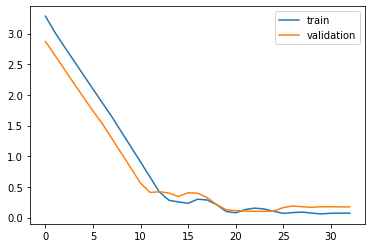


predict: [[25.98671828 20.8105779 ]]
real:      [[16.1 24. ]]

Train on 81 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 4.0383 - mean_squared_error: 16.3179 - val_loss: 3.7893 - val_mean_squared_error: 14.3635
Epoch 2/1000
 - 0s - loss: 3.7428 - mean_squared_error: 14.0226 - val_loss: 3.5067 - val_mean_squared_error: 12.3093
Epoch 3/1000
 - 0s - loss: 3.4793 - mean_squared_error: 12.1258 - val_loss: 3.2859 - val_mean_squared_error: 10.8182
Epoch 4/1000
 - 0s - loss: 3.2588 - mean_squared_error: 10.6495 - val_loss: 3.0741 - val_mean_squared_error: 9.4809
Epoch 5/1000
 - 0s - loss: 3.0479 - mean_squared_error: 9.3287 - val_loss: 2.8650 - val_mean_squared_error: 8.2484
Epoch 6/1000
 - 0s - loss: 2.8576 - mean_squared_error: 8.2102 - val_loss: 2.7765 - val_mean_squared_error: 7.7461
Epoch 7/1000
 - 0s - loss: 2.7658 - mean_squared_error: 7.6905 - val_loss: 2.6859 - val_mean_squared_error: 7.2440
Epoch 8/1000
 - 0s - loss: 2.6739 - mean_squared_error: 7.1829 - val_loss: 2.580

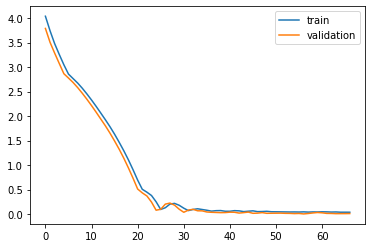


predict: [[32.26148147 23.91078985]]
real:      [[24.5 24. ]]

Train on 80 samples, validate on 1 samples
Epoch 1/1000
 - 23s - loss: 3.0572 - mean_squared_error: 9.4267 - val_loss: 2.8243 - val_mean_squared_error: 8.0493
Epoch 2/1000
 - 0s - loss: 2.8403 - mean_squared_error: 8.1578 - val_loss: 2.6503 - val_mean_squared_error: 7.1216
Epoch 3/1000
 - 0s - loss: 2.6653 - mean_squared_error: 7.2265 - val_loss: 2.4585 - val_mean_squared_error: 6.1817
Epoch 4/1000
 - 0s - loss: 2.4765 - mean_squared_error: 6.3004 - val_loss: 2.2564 - val_mean_squared_error: 5.2818
Epoch 5/1000
 - 0s - loss: 2.2779 - mean_squared_error: 5.4126 - val_loss: 2.0404 - val_mean_squared_error: 4.3842
Epoch 6/1000
 - 0s - loss: 2.0668 - mean_squared_error: 4.5318 - val_loss: 1.8168 - val_mean_squared_error: 3.5414
Epoch 7/1000
 - 0s - loss: 1.8448 - mean_squared_error: 3.6833 - val_loss: 1.5856 - val_mean_squared_error: 2.7714
Epoch 8/1000
 - 0s - loss: 1.6140 - mean_squared_error: 2.9014 - val_loss: 1.3455 - val

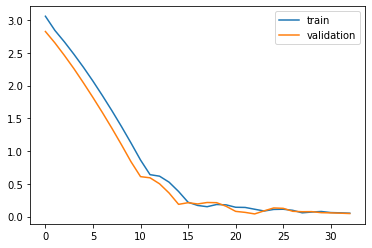


predict: [[29.40402801 25.33118818]]
real:      [[32.2 24. ]]

Train and validation time: 27.86746088663737

Maximum metrics
Test RMSE -------------------------- 5.187
Test VARIANCE ---------------------- -0.4842
Test MAX-ERROR --------------------- 12.98
Test MEAN-ABSOLUTE-ERROR ----------- 4.072
Test MEDIAN-ABSOLUTE-ERROR --------- 3.087

Errors
2014-06-28 = 1.1256387563568069
2014-06-27 = 0.8403834389862119
2014-06-26 = 1.6251107009185617
2014-06-25 = 0.5168641616673568
2014-06-24 = 0.5726654964918794
2014-06-23 = 4.38762489713249
2014-06-21 = 2.619035445018838
2014-06-20 = 4.075767708721919
2014-06-18 = 2.538652722027365
2014-06-17 = 7.188894154098019
2014-06-16 = 8.387421540643569
2014-06-14 = 12.981015307299877
2014-06-12 = 3.286121895686513
2014-06-11 = 1.7849757350979303
2014-06-10 = 4.8246248456023295
2014-06-09 = 8.29292835243367
2014-06-06 = 0.05007846903790636
2014-06-05 = 2.1770861710559544
2014-06-04 = 5.323036610769382
2014-06-03 = 0.8377489242607581
2014-06-02 = 7.8558

In [12]:
def main():
    input_paths = getFileNameIn('../../data_in/')
    input_paths = input_paths[:10]
    for input_path in input_paths:
        output_path = format_dataset(input_path)
        dataset = load_dataset(output_path)
        values = dataset.values
        plot_columns(dataset, values)

        # to get index the last 30 days
        days_to_predict = list(dataset.index[-30:])

        values_scaled = np.log1p(values)
        dataset_scaled = DataFrame(values_scaled)
        dataset_scaled.index = dataset.index
        dataset_scaled.columns = dataset.columns

        inicio = time.time()
        result = NCV(dataset_scaled, days_to_predict)
        fim = time.time()
        print('Train and validation time: {}\n'.format((fim - inicio)/60))
        
        y_hats = result[0]
        y_tests = result[1]

        metrics(y_hats, y_tests, days_to_predict)
    
if __name__ == "__main__":
    main()